## Day 5 : A Primer on JAX

# Installing JAX

### Install JAX

###### Why JAX ?

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap

In [2]:
# Define a function for computing the Matrix Powers and summing it
def fn(x):
    return x + x*x + x*x*x + x*x*x*x

In [10]:
## NumPy Evaluation
x = np.random.randn(10000, 10000).astype(dtype='float32')
%timeit -n5 -r5 fn(x)

614 ms ± 17.9 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [3]:
## JAX NumPy Evaluation
x = np.random.randn(10000, 10000).astype(dtype='float32')
jax_fn = jit(fn)
x = jnp.array(x)
%timeit -n5 -r5 jax_fn(x).block_until_ready()

107 ms ± 29.6 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap

### Scaler Valued function
### define f(x) = abs(x**3)
def abs_cube(x):
    r = 1   
    if x < 0.:
        for i in range(3):
            r *= x
        r = -r
    else:
        for i in range(3):
            r *= x
    return r

grad_fn = grad(abs_cube)

print(f"x = 8.0   f(x) = {abs_cube(8)}   f'(x) =  3x^2 = {grad_fn(8.0)}")
print(f"x = -6.0  f(x) = {abs_cube(-6)}  f'(x) = -3x^2 = {grad_fn(-6.0)}")

x = 8.0   f(x) = 512   f'(x) =  3x^2 = 192.0
x = -6.0  f(x) = 216  f'(x) = -3x^2 = -108.0


In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap, jacfwd, jacrev
import numpy as np
## Vector valued function
def vec_fn(v):
    x = v[0]
    y = v[1]
    z = v[2]
    return jnp.array([x**3, y*z])

#[d/dx x**3 , d/dy x**3, d/dz x**3]
#[d/dx y*z , d/dy y*z, d/dz y*z]

# [3*x**2 , 0, 0]
# [0 , z, y]

f = jax.jacfwd(vec_fn)
v = jnp.array([4., 5., 9.])
print(f(v))

[[48.  0.  0.]
 [ 0.  9.  5.]]


In [4]:
from jax import grad, jit, vmap, pmap, jacfwd, jacrev

def jax_hess(x):
    return jnp.sum(jnp.square(x))

jit_jax_fn = jit(jacrev(jacrev(jax_hess)))

x_np = np.random.rand(1000,1)
x = jnp.array(x_np)
%timeit jit_jax_fn(x).block_until_ready()

60.6 µs ± 946 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
import torch
def torch_hess(x):
    return torch.sum(torch.mul(x,x))
  
x = torch.randn((1000,))
%timeit -n 10 -r 5 torch.autograd.functional.hessian(torch_hess, x, vectorize=False)
%timeit -n 100 -r 10 torch.autograd.functional.hessian(torch_hess, x, vectorize=True)

76.1 ms ± 2.53 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
The slowest run took 5.43 times longer than the fastest. This could mean that an intermediate result is being cached.
2.75 ms ± 2.39 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [9]:
import tensorflow as tf
import os

def tf_hess(x):
    return tf.math.reduce_sum(x**2)

x_tf = tf.random.uniform(shape=(1000,1))

@tf.function(jit_compile=True)
def hess(x_tf):
    y_tf = tf_hess(x_tf)
    return tf.hessians(y_tf, x_tf, gate_gradients=False, aggregation_method=None,\
                       name='hessians')

%timeit  hess(x_tf)


865 µs ± 81.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## JVP in JAX

In [37]:
#### Full Jacobian using JACFWD for f:R^4 -> R^3
import jax
import jax.numpy as jnp

def f(x):
    u = jnp.array([x[0]**2*x[1]**2*x[2]**2*x[3]**3,
                  x[0]**4*x[1]**2*x[2]**5*x[3]**2,
                  x[0]**3*x[1]**2*x[2]**2*x[3]**2]
                 )
    return u
    
eval_points = jnp.array([1.0, 1.5, 0.2, 0.7])

f(eval_points)

jacobian_full = jax.jacfwd(f)(eval_points)
print(f"{jacobian_full=}")


jacobian_full=Array([[0.06174   , 0.04116   , 0.3087    , 0.1323    ],
       [0.0014112 , 0.0004704 , 0.00882   , 0.001008  ],
       [0.1323    , 0.0588    , 0.44099998, 0.126     ]], dtype=float32)


In [36]:
# ### One Row of Jacobian using JVP
# v = jnp.array([0.2,0.3, 0.4, 0.8])
# full_jvp = jacobian_full @ v
# print(f"JVP from full Jacobian: {full_jvp=}")
# print("****-----****-----****************")


# val, jax_jvp = jax.jvp(f, (eval_points, ), (v, )) 
# print(f"JVP from full JVP: {jax_jvp}")
print("****-----****-----****************")


# #### unitary Vector
e_1 = jnp.array([1.0, 0.0, 0.0, 0.0])
ve, jvp_e = jax.jvp(f, (eval_points, ), (e_1, ))
print(f"Projected JVP Results: {jvp_e}")


****-----****-----****************


ValueError: jvp called with different primal and tangent shapes;Got primal shape (100,) and tangent shape as (4,)

In [95]:
#### Full Jacobian JACOBIAN From JVP
def jacobian_jvp(f, eval_points):
    unit_vector = jnp.array([1.0, 0.0, 0.0, 0.0])
    n_col = len(eval_points)
    jac = []
    val = []
    for i in range(n_col):
        primal, ddx = jax.jvp(f, (eval_points, ), (jnp.roll(unit_vector, i), ))
        jac.append(ddx)
        val.append(primal)
        jac_f = jnp.stack(jac, axis=1)
        val_f = jnp.stack(val, axis=1)
        
    return val_f, jac_f
        
        
v, J = jacobian_jvp(f, eval_points)  
print(f"{v = }")
print(f"{J=}")

v = Array([[0.03087  , 0.03087  , 0.03087  , 0.03087  ],
       [0.0003528, 0.0003528, 0.0003528, 0.0003528],
       [0.0441   , 0.0441   , 0.0441   , 0.0441   ]], dtype=float32)
J=Array([[0.06174   , 0.04116   , 0.3087    , 0.1323    ],
       [0.0014112 , 0.0004704 , 0.00882   , 0.001008  ],
       [0.1323    , 0.0588    , 0.44099998, 0.126     ]], dtype=float32)


eval_points shape= (100,)
eval_points shape= (100,)
20.7 µs ± 661 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
7.36 µs ± 118 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


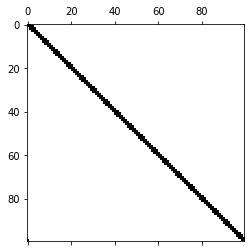

In [14]:
### benchmarking- JACFWD @v vs JVP
import matplotlib.pyplot as plt

def f(x):
    u = x**2 - jnp.roll(x, -1)**3 - jnp.roll(x, 1)**3
    return u

eval_points = jax.random.normal(jax.random.PRNGKey(100), (100,))
tangents = jax.random.normal(jax.random.PRNGKey(20), (100,))

print(f"eval_points shape= {eval_points.shape}")
print(f"eval_points shape= {f(eval_points).shape}")

full_jac = jax.jacfwd(f)(eval_points)
plt.spy(full_jac)

@jax.jit
def slow_jvp(eval_points, tangents):
    jvp_s = jax.jacfwd(f)(eval_points)
    jvp_slow = jvp_s @ tangents 
    return jvp_s

@jax.jit
def fast_jvp(eval_points, tangents):
    jvp_fast = jax.jvp(f, (eval_points,), (tangents,))
    return jvp_fast

%timeit slow_jvp(eval_points, tangents)
%timeit  fast_jvp(eval_points, tangents)




## VJP in JAX

In [13]:
## Define Function f:R^4 -> R^3

import jax
import jax.numpy as jnp

def f(x):
    u = jnp.array([x[0]**2*x[1]**2*x[2]**2*x[3]**3,
                  x[0]**4*x[1]**2*x[2]**5*x[3]**2,
                  x[0]**3*x[1]**2*x[2]**2*x[3]**2]
                 )
    return u

print(f"f_eval_original={f(eval_points)}")


f_eval_original=[0.03087   0.0003528 0.0441   ]


In [16]:
## Compute Full Jacbian uing Reverse Mode Automatic Differentiation
eval_points = jnp.array([1.0, 1.5, 0.2, 0.7])
full_jac = jax.jacrev(f)(eval_points)
print(f"{full_jac=}")

full_jac=Array([[0.06174   , 0.04116   , 0.3087    , 0.1323    ],
       [0.0014112 , 0.0004704 , 0.00882   , 0.001008  ],
       [0.1323    , 0.0588    , 0.44099998, 0.126     ]], dtype=float32)


In [18]:
left_mult_points = jnp.array([0.6, 0.8, 1.2])
vjp = left_mult_points.T @ full_jac
print(f"Full VJP: {vjp}")


Full VJP: [0.19693297 0.09563232 0.721476   0.23138641]


In [19]:
### Compute VJP with out computing the full jacobian
f_evaluated, vjp_fn = jax.vjp(f, eval_points)
vjp_prod = vjp_fn(left_mult_points.T)
print(vjp_prod)

(Array([0.19693297, 0.09563233, 0.721476  , 0.23138642], dtype=float32),)


In [16]:
import jax.numpy as jnp
from jax import vmap
a = jnp.array([[1, 10], [43, 8]])
b = jnp.array([[7, 8], [9, 10]])

a1 = jnp.add(a, b)

a1

Array([[ 8, 18],
       [52, 18]], dtype=int32)

In [17]:
b1 = vmap(jnp.add, in_axes=(0, 0),out_axes=0)(a, b)
b1

Array([[ 8, 18],
       [52, 18]], dtype=int32)

In [18]:
import jax.numpy as jnp
from jax import make_jaxpr
def f(a, b):
    temp = a + 10.0 * jnp.sin(b)
    return jnp.sum(temp)

a = jnp.ones(10)
b = jnp.ones(10)

print(make_jaxpr(f)(a, b))

{ lambda ; a:f32[10] b:f32[10]. let
    c:f32[10] = sin b
    d:f32[10] = mul 10.0 c
    e:f32[10] = add a d
    f:f32[] = reduce_sum[axes=(0,)] e
  in (f,) }


In [19]:
def fn_tanh(x):
    return (jnp.exp(-x) - jnp.exp(x))/(jnp.exp(-x) + jnp.exp(x))

x = jnp.arange(1000000)
%timeit fn_tanh(x).block_until_ready()

3.02 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
from jax import jit
fn_tanh_jit = jit(fn_tanh)
%timeit fn_tanh_jit(x).block_until_ready()

613 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
def f(x):
    if x > 0:
        return x
    else:
        return 4 * x
    
f_jit = jit(f)(15)




ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape bool[].
The problem arose with the `bool` function. 
The error occurred while tracing the function f at <ipython-input-21-30e16338ac37>:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [29]:
def f(x):
    if x > 0:
        return x
    else:
        return 4 * x
    
f_jit = jit(f)(15)


# Correct approach
# fn_true = lambda x: x 
# fn_false = lambda x: 4*x
# x=15
# f_lax = lambda x : jax.lax.cond(x>0, fn_true, fn_false, x)
# f_jit_lax = jit(f_lax)(x)

# f_jit_lax

Array(15, dtype=int32, weak_type=True)

In [30]:
import numpy as np
#In-place Update
np_arr = np.zeros((3,3), dtype=np.float32)
print("original array:")
print(np_arr)

# In place, mutating update
np_arr[1, :] = 1.0
print("updated array:")
print(np_arr)

original array:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
updated array:
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


In [32]:
jax_array = jnp.zeros((3,3), dtype=jnp.float32)

# In place update of JAX's array will yield an error!
try:
    jax_array[1, :] = 1.0
except Exception as e:
    print("Exception {}".format(e))

Exception '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


In [33]:
updated_array = jax_array.at[1, :].set(1.0)
print("updated array:\n", updated_array)

updated array:
 [[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


In [1]:
#Pytree
from jax.tree_util import tree_structure
tree_1 = [1, "a", object()]  # 3 leaves
tree_2 = (1, (2, 3), ())  # 3 leaves
tree_3 =[1, {"k1": 2, "k2": (3, 4)}, 5]  # 5 leaves

tree_struct_1=tree_structure(tree_1)
tree_struct_2=tree_structure(tree_2)
tree_struct_3=tree_structure(tree_3)


print(f"{tree_struct_1=}\n{tree_struct_2=}\n{tree_struct_3=}")


tree_struct_1=PyTreeDef([*, *, *])
tree_struct_2=PyTreeDef((*, (*, *), ()))
tree_struct_3=PyTreeDef([*, {'k1': *, 'k2': (*, *)}, *])


In [44]:
from jax.tree_util import tree_flatten, tree_unflatten
import jax.numpy as jnp
v_structured = [1., (8., 10.)]
v_flat, v_tree = tree_flatten(v_structured)
print(f"{v_flat=}\n{v_tree=}")

#Using the map function
transformed_flat = list(map(lambda v: v ** 2., v_flat))
print(f"{transformed_flat=}")
# Reconstruct the structured output, using the PyTree
transformed_structured = tree_unflatten(v_tree, transformed_flat)
print(f"{transformed_structured=}\n")

v_flat=[1.0, 8.0, 10.0]
v_tree=PyTreeDef([*, (*, *)])
transformed_flat=[1.0, 64.0, 100.0]
transformed_structured=[1.0, (64.0, 100.0)]



## Function Approximation in JAX

In [34]:
from jax import random
from jax.nn import tanh
from jax import numpy as jnp
from jax import vmap, value_and_grad, jit

def get_random_layer_params(m, n, random_key, scale=0.01):
    w_key, b_key = random.split(random_key)
    weights = 1/(jnp.sqrt(m+n)) * random.normal(w_key, (n, m))
    biases = jnp.zeros((n,)) 
    return weights, biases

def get_init_network_params(sizes, ran_key):
    keys = random.split(ran_key, len(sizes))
    return [get_random_layer_params(m, n, k) \
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def feedforward_prediction(params, x):     
    for w, b in params[:-1]:
        outputs = jnp.dot(w, x) + b  
        x = tanh(outputs)  
    w_final, b_final = params[-1] 
    final_outputs = jnp.dot(w_final, x) + b_final 
    return final_outputs  


batched_prediction = vmap(feedforward_prediction, in_axes=(None, 0))

@jit
def mse_loss(params, x, y):
    preds = batched_prediction(params, x)
    diff = preds - y
    return jnp.sum(diff*diff)/preds.shape[0]

@jit
def update(params, x, y, learning_rate):
    l, grads = value_and_grad(mse_loss)(params, x, y)
    return [(w - learning_rate * dw, b - learning_rate * db) 
            for (w, b), (dw, db) in zip(params, grads)], l



def f(x):
    return x**2

SEED = 1234
key = random.PRNGKey(SEED)
Niter = 100000
lr = 1e-02

num_features = 1
num_traget = 1
num_batches = 1000
layers = [1] + [32]*2 + [1]
ran_key, func_key = random.split(key)
params = get_init_network_params(layers, ran_key)


x_train = jnp.linspace(-1, 1, num_batches)
x_train = x_train.reshape((num_batches, num_features))
y_train = f(x_train)

for it in range(0, Niter):
    params, loss = update(params, x_train, y_train, lr)
    print(f"{it=} and {loss=}\n")
    
    



    





it=0 and loss=Array(0.2029252, dtype=float32)

it=1 and loss=Array(0.18818077, dtype=float32)

it=2 and loss=Array(0.1753866, dtype=float32)

it=3 and loss=Array(0.16428144, dtype=float32)

it=4 and loss=Array(0.15464024, dtype=float32)

it=5 and loss=Array(0.14626862, dtype=float32)

it=6 and loss=Array(0.13899848, dtype=float32)

it=7 and loss=Array(0.13268434, dtype=float32)

it=8 and loss=Array(0.1272001, dtype=float32)

it=9 and loss=Array(0.12243643, dtype=float32)

it=10 and loss=Array(0.11829847, dtype=float32)

it=11 and loss=Array(0.11470383, dtype=float32)

it=12 and loss=Array(0.111581, dtype=float32)

it=13 and loss=Array(0.10886786, dtype=float32)

it=14 and loss=Array(0.1065105, dtype=float32)

it=15 and loss=Array(0.104462, dtype=float32)

it=16 and loss=Array(0.10268167, dtype=float32)

it=17 and loss=Array(0.10113417, dtype=float32)

it=18 and loss=Array(0.09978875, dtype=float32)

it=19 and loss=Array(0.09861875, dtype=float32)

it=20 and loss=Array(0.09760101, dtype

it=241 and loss=Array(0.09001334, dtype=float32)

it=242 and loss=Array(0.09001241, dtype=float32)

it=243 and loss=Array(0.09001146, dtype=float32)

it=244 and loss=Array(0.09001053, dtype=float32)

it=245 and loss=Array(0.0900096, dtype=float32)

it=246 and loss=Array(0.09000866, dtype=float32)

it=247 and loss=Array(0.09000772, dtype=float32)

it=248 and loss=Array(0.09000679, dtype=float32)

it=249 and loss=Array(0.09000586, dtype=float32)

it=250 and loss=Array(0.09000492, dtype=float32)

it=251 and loss=Array(0.09000399, dtype=float32)

it=252 and loss=Array(0.09000306, dtype=float32)

it=253 and loss=Array(0.09000213, dtype=float32)

it=254 and loss=Array(0.0900012, dtype=float32)

it=255 and loss=Array(0.09000026, dtype=float32)

it=256 and loss=Array(0.08999934, dtype=float32)

it=257 and loss=Array(0.08999841, dtype=float32)

it=258 and loss=Array(0.08999747, dtype=float32)

it=259 and loss=Array(0.08999655, dtype=float32)

it=260 and loss=Array(0.08999562, dtype=float32)

it

it=480 and loss=Array(0.08979826, dtype=float32)

it=481 and loss=Array(0.08979739, dtype=float32)

it=482 and loss=Array(0.08979651, dtype=float32)

it=483 and loss=Array(0.08979563, dtype=float32)

it=484 and loss=Array(0.08979475, dtype=float32)

it=485 and loss=Array(0.08979389, dtype=float32)

it=486 and loss=Array(0.08979301, dtype=float32)

it=487 and loss=Array(0.08979213, dtype=float32)

it=488 and loss=Array(0.08979125, dtype=float32)

it=489 and loss=Array(0.08979038, dtype=float32)

it=490 and loss=Array(0.08978951, dtype=float32)

it=491 and loss=Array(0.08978864, dtype=float32)

it=492 and loss=Array(0.08978775, dtype=float32)

it=493 and loss=Array(0.08978689, dtype=float32)

it=494 and loss=Array(0.08978602, dtype=float32)

it=495 and loss=Array(0.08978513, dtype=float32)

it=496 and loss=Array(0.08978426, dtype=float32)

it=497 and loss=Array(0.08978339, dtype=float32)

it=498 and loss=Array(0.08978252, dtype=float32)

it=499 and loss=Array(0.08978164, dtype=float32)



it=717 and loss=Array(0.08959356, dtype=float32)

it=718 and loss=Array(0.0895927, dtype=float32)

it=719 and loss=Array(0.08959185, dtype=float32)

it=720 and loss=Array(0.08959099, dtype=float32)

it=721 and loss=Array(0.08959014, dtype=float32)

it=722 and loss=Array(0.08958928, dtype=float32)

it=723 and loss=Array(0.08958842, dtype=float32)

it=724 and loss=Array(0.08958756, dtype=float32)

it=725 and loss=Array(0.0895867, dtype=float32)

it=726 and loss=Array(0.08958585, dtype=float32)

it=727 and loss=Array(0.089585, dtype=float32)

it=728 and loss=Array(0.08958414, dtype=float32)

it=729 and loss=Array(0.08958329, dtype=float32)

it=730 and loss=Array(0.08958242, dtype=float32)

it=731 and loss=Array(0.08958157, dtype=float32)

it=732 and loss=Array(0.08958071, dtype=float32)

it=733 and loss=Array(0.08957986, dtype=float32)

it=734 and loss=Array(0.089579, dtype=float32)

it=735 and loss=Array(0.08957814, dtype=float32)

it=736 and loss=Array(0.08957729, dtype=float32)

it=737

it=943 and loss=Array(0.08939983, dtype=float32)

it=944 and loss=Array(0.08939896, dtype=float32)

it=945 and loss=Array(0.0893981, dtype=float32)

it=946 and loss=Array(0.08939724, dtype=float32)

it=947 and loss=Array(0.08939636, dtype=float32)

it=948 and loss=Array(0.08939552, dtype=float32)

it=949 and loss=Array(0.08939465, dtype=float32)

it=950 and loss=Array(0.08939379, dtype=float32)

it=951 and loss=Array(0.08939292, dtype=float32)

it=952 and loss=Array(0.08939207, dtype=float32)

it=953 and loss=Array(0.0893912, dtype=float32)

it=954 and loss=Array(0.08939033, dtype=float32)

it=955 and loss=Array(0.08938947, dtype=float32)

it=956 and loss=Array(0.0893886, dtype=float32)

it=957 and loss=Array(0.08938774, dtype=float32)

it=958 and loss=Array(0.08938687, dtype=float32)

it=959 and loss=Array(0.08938602, dtype=float32)

it=960 and loss=Array(0.08938515, dtype=float32)

it=961 and loss=Array(0.08938429, dtype=float32)

it=962 and loss=Array(0.08938342, dtype=float32)

it=

it=1170 and loss=Array(0.08920089, dtype=float32)

it=1171 and loss=Array(0.08919999, dtype=float32)

it=1172 and loss=Array(0.0891991, dtype=float32)

it=1173 and loss=Array(0.0891982, dtype=float32)

it=1174 and loss=Array(0.08919731, dtype=float32)

it=1175 and loss=Array(0.08919641, dtype=float32)

it=1176 and loss=Array(0.08919551, dtype=float32)

it=1177 and loss=Array(0.08919463, dtype=float32)

it=1178 and loss=Array(0.08919373, dtype=float32)

it=1179 and loss=Array(0.08919283, dtype=float32)

it=1180 and loss=Array(0.08919194, dtype=float32)

it=1181 and loss=Array(0.08919103, dtype=float32)

it=1182 and loss=Array(0.08919014, dtype=float32)

it=1183 and loss=Array(0.08918925, dtype=float32)

it=1184 and loss=Array(0.08918834, dtype=float32)

it=1185 and loss=Array(0.08918745, dtype=float32)

it=1186 and loss=Array(0.08918656, dtype=float32)

it=1187 and loss=Array(0.08918566, dtype=float32)

it=1188 and loss=Array(0.08918476, dtype=float32)

it=1189 and loss=Array(0.08918386

it=1407 and loss=Array(0.08898206, dtype=float32)

it=1408 and loss=Array(0.0889811, dtype=float32)

it=1409 and loss=Array(0.08898015, dtype=float32)

it=1410 and loss=Array(0.08897919, dtype=float32)

it=1411 and loss=Array(0.08897822, dtype=float32)

it=1412 and loss=Array(0.08897727, dtype=float32)

it=1413 and loss=Array(0.08897631, dtype=float32)

it=1414 and loss=Array(0.08897536, dtype=float32)

it=1415 and loss=Array(0.08897439, dtype=float32)

it=1416 and loss=Array(0.08897343, dtype=float32)

it=1417 and loss=Array(0.08897246, dtype=float32)

it=1418 and loss=Array(0.08897151, dtype=float32)

it=1419 and loss=Array(0.08897054, dtype=float32)

it=1420 and loss=Array(0.08896958, dtype=float32)

it=1421 and loss=Array(0.08896862, dtype=float32)

it=1422 and loss=Array(0.08896766, dtype=float32)

it=1423 and loss=Array(0.0889667, dtype=float32)

it=1424 and loss=Array(0.08896574, dtype=float32)

it=1425 and loss=Array(0.08896478, dtype=float32)

it=1426 and loss=Array(0.08896381

it=1643 and loss=Array(0.08874539, dtype=float32)

it=1644 and loss=Array(0.08874433, dtype=float32)

it=1645 and loss=Array(0.08874328, dtype=float32)

it=1646 and loss=Array(0.08874222, dtype=float32)

it=1647 and loss=Array(0.08874117, dtype=float32)

it=1648 and loss=Array(0.08874011, dtype=float32)

it=1649 and loss=Array(0.08873904, dtype=float32)

it=1650 and loss=Array(0.08873799, dtype=float32)

it=1651 and loss=Array(0.08873694, dtype=float32)

it=1652 and loss=Array(0.08873587, dtype=float32)

it=1653 and loss=Array(0.08873482, dtype=float32)

it=1654 and loss=Array(0.08873376, dtype=float32)

it=1655 and loss=Array(0.0887327, dtype=float32)

it=1656 and loss=Array(0.08873164, dtype=float32)

it=1657 and loss=Array(0.08873058, dtype=float32)

it=1658 and loss=Array(0.08872952, dtype=float32)

it=1659 and loss=Array(0.08872846, dtype=float32)

it=1660 and loss=Array(0.08872739, dtype=float32)

it=1661 and loss=Array(0.08872633, dtype=float32)

it=1662 and loss=Array(0.0887252

it=1875 and loss=Array(0.08848587, dtype=float32)

it=1876 and loss=Array(0.08848468, dtype=float32)

it=1877 and loss=Array(0.0884835, dtype=float32)

it=1878 and loss=Array(0.08848231, dtype=float32)

it=1879 and loss=Array(0.08848111, dtype=float32)

it=1880 and loss=Array(0.08847991, dtype=float32)

it=1881 and loss=Array(0.08847873, dtype=float32)

it=1882 and loss=Array(0.08847753, dtype=float32)

it=1883 and loss=Array(0.08847634, dtype=float32)

it=1884 and loss=Array(0.08847513, dtype=float32)

it=1885 and loss=Array(0.08847395, dtype=float32)

it=1886 and loss=Array(0.08847274, dtype=float32)

it=1887 and loss=Array(0.08847155, dtype=float32)

it=1888 and loss=Array(0.08847035, dtype=float32)

it=1889 and loss=Array(0.08846913, dtype=float32)

it=1890 and loss=Array(0.08846795, dtype=float32)

it=1891 and loss=Array(0.08846674, dtype=float32)

it=1892 and loss=Array(0.08846554, dtype=float32)

it=1893 and loss=Array(0.08846433, dtype=float32)

it=1894 and loss=Array(0.0884631

it=2118 and loss=Array(0.08817401, dtype=float32)

it=2119 and loss=Array(0.08817263, dtype=float32)

it=2120 and loss=Array(0.08817124, dtype=float32)

it=2121 and loss=Array(0.08816984, dtype=float32)

it=2122 and loss=Array(0.08816844, dtype=float32)

it=2123 and loss=Array(0.08816706, dtype=float32)

it=2124 and loss=Array(0.08816567, dtype=float32)

it=2125 and loss=Array(0.08816427, dtype=float32)

it=2126 and loss=Array(0.08816288, dtype=float32)

it=2127 and loss=Array(0.08816149, dtype=float32)

it=2128 and loss=Array(0.08816008, dtype=float32)

it=2129 and loss=Array(0.08815869, dtype=float32)

it=2130 and loss=Array(0.08815729, dtype=float32)

it=2131 and loss=Array(0.0881559, dtype=float32)

it=2132 and loss=Array(0.0881545, dtype=float32)

it=2133 and loss=Array(0.08815309, dtype=float32)

it=2134 and loss=Array(0.08815169, dtype=float32)

it=2135 and loss=Array(0.08815029, dtype=float32)

it=2136 and loss=Array(0.08814888, dtype=float32)

it=2137 and loss=Array(0.08814748

it=2374 and loss=Array(0.08778414, dtype=float32)

it=2375 and loss=Array(0.08778246, dtype=float32)

it=2376 and loss=Array(0.08778078, dtype=float32)

it=2377 and loss=Array(0.0877791, dtype=float32)

it=2378 and loss=Array(0.08777742, dtype=float32)

it=2379 and loss=Array(0.08777574, dtype=float32)

it=2380 and loss=Array(0.08777406, dtype=float32)

it=2381 and loss=Array(0.08777238, dtype=float32)

it=2382 and loss=Array(0.08777069, dtype=float32)

it=2383 and loss=Array(0.087769, dtype=float32)

it=2384 and loss=Array(0.08776733, dtype=float32)

it=2385 and loss=Array(0.08776563, dtype=float32)

it=2386 and loss=Array(0.08776394, dtype=float32)

it=2387 and loss=Array(0.08776225, dtype=float32)

it=2388 and loss=Array(0.08776056, dtype=float32)

it=2389 and loss=Array(0.08775886, dtype=float32)

it=2390 and loss=Array(0.08775718, dtype=float32)

it=2391 and loss=Array(0.08775546, dtype=float32)

it=2392 and loss=Array(0.08775377, dtype=float32)

it=2393 and loss=Array(0.08775207,

it=2632 and loss=Array(0.08730274, dtype=float32)

it=2633 and loss=Array(0.08730067, dtype=float32)

it=2634 and loss=Array(0.08729858, dtype=float32)

it=2635 and loss=Array(0.0872965, dtype=float32)

it=2636 and loss=Array(0.08729441, dtype=float32)

it=2637 and loss=Array(0.08729233, dtype=float32)

it=2638 and loss=Array(0.08729023, dtype=float32)

it=2639 and loss=Array(0.08728813, dtype=float32)

it=2640 and loss=Array(0.08728605, dtype=float32)

it=2641 and loss=Array(0.08728395, dtype=float32)

it=2642 and loss=Array(0.08728186, dtype=float32)

it=2643 and loss=Array(0.08727976, dtype=float32)

it=2644 and loss=Array(0.08727765, dtype=float32)

it=2645 and loss=Array(0.08727555, dtype=float32)

it=2646 and loss=Array(0.08727344, dtype=float32)

it=2647 and loss=Array(0.08727133, dtype=float32)

it=2648 and loss=Array(0.08726923, dtype=float32)

it=2649 and loss=Array(0.08726712, dtype=float32)

it=2650 and loss=Array(0.08726501, dtype=float32)

it=2651 and loss=Array(0.0872629

it=2896 and loss=Array(0.08668076, dtype=float32)

it=2897 and loss=Array(0.08667809, dtype=float32)

it=2898 and loss=Array(0.08667543, dtype=float32)

it=2899 and loss=Array(0.08667275, dtype=float32)

it=2900 and loss=Array(0.08667008, dtype=float32)

it=2901 and loss=Array(0.0866674, dtype=float32)

it=2902 and loss=Array(0.08666471, dtype=float32)

it=2903 and loss=Array(0.08666203, dtype=float32)

it=2904 and loss=Array(0.08665933, dtype=float32)

it=2905 and loss=Array(0.08665665, dtype=float32)

it=2906 and loss=Array(0.08665396, dtype=float32)

it=2907 and loss=Array(0.08665127, dtype=float32)

it=2908 and loss=Array(0.08664856, dtype=float32)

it=2909 and loss=Array(0.08664586, dtype=float32)

it=2910 and loss=Array(0.08664316, dtype=float32)

it=2911 and loss=Array(0.08664046, dtype=float32)

it=2912 and loss=Array(0.08663775, dtype=float32)

it=2913 and loss=Array(0.08663504, dtype=float32)

it=2914 and loss=Array(0.08663233, dtype=float32)

it=2915 and loss=Array(0.0866296

it=3159 and loss=Array(0.0858753, dtype=float32)

it=3160 and loss=Array(0.08587179, dtype=float32)

it=3161 and loss=Array(0.08586826, dtype=float32)

it=3162 and loss=Array(0.08586475, dtype=float32)

it=3163 and loss=Array(0.08586122, dtype=float32)

it=3164 and loss=Array(0.08585769, dtype=float32)

it=3165 and loss=Array(0.08585416, dtype=float32)

it=3166 and loss=Array(0.08585063, dtype=float32)

it=3167 and loss=Array(0.08584708, dtype=float32)

it=3168 and loss=Array(0.08584354, dtype=float32)

it=3169 and loss=Array(0.08584, dtype=float32)

it=3170 and loss=Array(0.08583645, dtype=float32)

it=3171 and loss=Array(0.08583289, dtype=float32)

it=3172 and loss=Array(0.08582933, dtype=float32)

it=3173 and loss=Array(0.08582576, dtype=float32)

it=3174 and loss=Array(0.08582221, dtype=float32)

it=3175 and loss=Array(0.08581863, dtype=float32)

it=3176 and loss=Array(0.08581505, dtype=float32)

it=3177 and loss=Array(0.08581147, dtype=float32)

it=3178 and loss=Array(0.0858079, d

it=3411 and loss=Array(0.08485181, dtype=float32)

it=3412 and loss=Array(0.08484711, dtype=float32)

it=3413 and loss=Array(0.08484243, dtype=float32)

it=3414 and loss=Array(0.08483773, dtype=float32)

it=3415 and loss=Array(0.08483302, dtype=float32)

it=3416 and loss=Array(0.08482831, dtype=float32)

it=3417 and loss=Array(0.08482359, dtype=float32)

it=3418 and loss=Array(0.08481888, dtype=float32)

it=3419 and loss=Array(0.08481415, dtype=float32)

it=3420 and loss=Array(0.08480941, dtype=float32)

it=3421 and loss=Array(0.08480467, dtype=float32)

it=3422 and loss=Array(0.08479993, dtype=float32)

it=3423 and loss=Array(0.08479517, dtype=float32)

it=3424 and loss=Array(0.08479042, dtype=float32)

it=3425 and loss=Array(0.08478565, dtype=float32)

it=3426 and loss=Array(0.08478089, dtype=float32)

it=3427 and loss=Array(0.08477611, dtype=float32)

it=3428 and loss=Array(0.08477134, dtype=float32)

it=3429 and loss=Array(0.08476654, dtype=float32)

it=3430 and loss=Array(0.084761

it=3675 and loss=Array(0.08338977, dtype=float32)

it=3676 and loss=Array(0.08338326, dtype=float32)

it=3677 and loss=Array(0.08337673, dtype=float32)

it=3678 and loss=Array(0.08337018, dtype=float32)

it=3679 and loss=Array(0.08336364, dtype=float32)

it=3680 and loss=Array(0.08335708, dtype=float32)

it=3681 and loss=Array(0.08335052, dtype=float32)

it=3682 and loss=Array(0.08334395, dtype=float32)

it=3683 and loss=Array(0.08333737, dtype=float32)

it=3684 and loss=Array(0.08333078, dtype=float32)

it=3685 and loss=Array(0.08332419, dtype=float32)

it=3686 and loss=Array(0.08331758, dtype=float32)

it=3687 and loss=Array(0.08331096, dtype=float32)

it=3688 and loss=Array(0.08330434, dtype=float32)

it=3689 and loss=Array(0.0832977, dtype=float32)

it=3690 and loss=Array(0.08329107, dtype=float32)

it=3691 and loss=Array(0.08328442, dtype=float32)

it=3692 and loss=Array(0.08327776, dtype=float32)

it=3693 and loss=Array(0.08327109, dtype=float32)

it=3694 and loss=Array(0.0832644

it=3927 and loss=Array(0.08143762, dtype=float32)

it=3928 and loss=Array(0.08142847, dtype=float32)

it=3929 and loss=Array(0.08141928, dtype=float32)

it=3930 and loss=Array(0.0814101, dtype=float32)

it=3931 and loss=Array(0.0814009, dtype=float32)

it=3932 and loss=Array(0.08139168, dtype=float32)

it=3933 and loss=Array(0.08138246, dtype=float32)

it=3934 and loss=Array(0.08137322, dtype=float32)

it=3935 and loss=Array(0.08136395, dtype=float32)

it=3936 and loss=Array(0.08135469, dtype=float32)

it=3937 and loss=Array(0.08134541, dtype=float32)

it=3938 and loss=Array(0.08133611, dtype=float32)

it=3939 and loss=Array(0.08132681, dtype=float32)

it=3940 and loss=Array(0.08131749, dtype=float32)

it=3941 and loss=Array(0.08130816, dtype=float32)

it=3942 and loss=Array(0.08129881, dtype=float32)

it=3943 and loss=Array(0.08128945, dtype=float32)

it=3944 and loss=Array(0.08128008, dtype=float32)

it=3945 and loss=Array(0.08127069, dtype=float32)

it=3946 and loss=Array(0.08126129

it=4166 and loss=Array(0.07882942, dtype=float32)

it=4167 and loss=Array(0.07881649, dtype=float32)

it=4168 and loss=Array(0.07880355, dtype=float32)

it=4169 and loss=Array(0.07879058, dtype=float32)

it=4170 and loss=Array(0.0787776, dtype=float32)

it=4171 and loss=Array(0.07876459, dtype=float32)

it=4172 and loss=Array(0.07875158, dtype=float32)

it=4173 and loss=Array(0.07873853, dtype=float32)

it=4174 and loss=Array(0.07872546, dtype=float32)

it=4175 and loss=Array(0.07871239, dtype=float32)

it=4176 and loss=Array(0.07869929, dtype=float32)

it=4177 and loss=Array(0.07868618, dtype=float32)

it=4178 and loss=Array(0.07867303, dtype=float32)

it=4179 and loss=Array(0.07865987, dtype=float32)

it=4180 and loss=Array(0.0786467, dtype=float32)

it=4181 and loss=Array(0.0786335, dtype=float32)

it=4182 and loss=Array(0.07862028, dtype=float32)

it=4183 and loss=Array(0.07860705, dtype=float32)

it=4184 and loss=Array(0.07859378, dtype=float32)

it=4185 and loss=Array(0.07858051,

it=4400 and loss=Array(0.07521035, dtype=float32)

it=4401 and loss=Array(0.07519197, dtype=float32)

it=4402 and loss=Array(0.07517356, dtype=float32)

it=4403 and loss=Array(0.07515514, dtype=float32)

it=4404 and loss=Array(0.07513668, dtype=float32)

it=4405 and loss=Array(0.07511819, dtype=float32)

it=4406 and loss=Array(0.07509968, dtype=float32)

it=4407 and loss=Array(0.07508113, dtype=float32)

it=4408 and loss=Array(0.07506257, dtype=float32)

it=4409 and loss=Array(0.07504396, dtype=float32)

it=4410 and loss=Array(0.07502534, dtype=float32)

it=4411 and loss=Array(0.07500669, dtype=float32)

it=4412 and loss=Array(0.07498799, dtype=float32)

it=4413 and loss=Array(0.07496928, dtype=float32)

it=4414 and loss=Array(0.07495054, dtype=float32)

it=4415 and loss=Array(0.07493176, dtype=float32)

it=4416 and loss=Array(0.07491297, dtype=float32)

it=4417 and loss=Array(0.07489414, dtype=float32)

it=4418 and loss=Array(0.07487529, dtype=float32)

it=4419 and loss=Array(0.074856

it=4641 and loss=Array(0.06986437, dtype=float32)

it=4642 and loss=Array(0.06983786, dtype=float32)

it=4643 and loss=Array(0.06981132, dtype=float32)

it=4644 and loss=Array(0.06978475, dtype=float32)

it=4645 and loss=Array(0.06975812, dtype=float32)

it=4646 and loss=Array(0.06973147, dtype=float32)

it=4647 and loss=Array(0.06970476, dtype=float32)

it=4648 and loss=Array(0.06967803, dtype=float32)

it=4649 and loss=Array(0.06965125, dtype=float32)

it=4650 and loss=Array(0.06962442, dtype=float32)

it=4651 and loss=Array(0.06959756, dtype=float32)

it=4652 and loss=Array(0.06957066, dtype=float32)

it=4653 and loss=Array(0.06954372, dtype=float32)

it=4654 and loss=Array(0.06951674, dtype=float32)

it=4655 and loss=Array(0.06948972, dtype=float32)

it=4656 and loss=Array(0.06946265, dtype=float32)

it=4657 and loss=Array(0.06943555, dtype=float32)

it=4658 and loss=Array(0.0694084, dtype=float32)

it=4659 and loss=Array(0.06938121, dtype=float32)

it=4660 and loss=Array(0.0693539

it=4893 and loss=Array(0.06179624, dtype=float32)

it=4894 and loss=Array(0.06175819, dtype=float32)

it=4895 and loss=Array(0.06172008, dtype=float32)

it=4896 and loss=Array(0.06168192, dtype=float32)

it=4897 and loss=Array(0.06164371, dtype=float32)

it=4898 and loss=Array(0.06160545, dtype=float32)

it=4899 and loss=Array(0.06156714, dtype=float32)

it=4900 and loss=Array(0.06152877, dtype=float32)

it=4901 and loss=Array(0.06149036, dtype=float32)

it=4902 and loss=Array(0.0614519, dtype=float32)

it=4903 and loss=Array(0.06141338, dtype=float32)

it=4904 and loss=Array(0.06137481, dtype=float32)

it=4905 and loss=Array(0.06133619, dtype=float32)

it=4906 and loss=Array(0.06129752, dtype=float32)

it=4907 and loss=Array(0.0612588, dtype=float32)

it=4908 and loss=Array(0.06122002, dtype=float32)

it=4909 and loss=Array(0.0611812, dtype=float32)

it=4910 and loss=Array(0.06114233, dtype=float32)

it=4911 and loss=Array(0.0611034, dtype=float32)

it=4912 and loss=Array(0.06106443, 

it=5155 and loss=Array(0.05005687, dtype=float32)

it=5156 and loss=Array(0.05000545, dtype=float32)

it=5157 and loss=Array(0.04995397, dtype=float32)

it=5158 and loss=Array(0.04990245, dtype=float32)

it=5159 and loss=Array(0.04985088, dtype=float32)

it=5160 and loss=Array(0.04979927, dtype=float32)

it=5161 and loss=Array(0.04974762, dtype=float32)

it=5162 and loss=Array(0.04969591, dtype=float32)

it=5163 and loss=Array(0.04964417, dtype=float32)

it=5164 and loss=Array(0.04959237, dtype=float32)

it=5165 and loss=Array(0.04954053, dtype=float32)

it=5166 and loss=Array(0.04948864, dtype=float32)

it=5167 and loss=Array(0.04943671, dtype=float32)

it=5168 and loss=Array(0.04938473, dtype=float32)

it=5169 and loss=Array(0.04933271, dtype=float32)

it=5170 and loss=Array(0.04928064, dtype=float32)

it=5171 and loss=Array(0.04922853, dtype=float32)

it=5172 and loss=Array(0.04917637, dtype=float32)

it=5173 and loss=Array(0.04912417, dtype=float32)

it=5174 and loss=Array(0.049071

it=5416 and loss=Array(0.03542192, dtype=float32)

it=5417 and loss=Array(0.03536306, dtype=float32)

it=5418 and loss=Array(0.03530417, dtype=float32)

it=5419 and loss=Array(0.0352453, dtype=float32)

it=5420 and loss=Array(0.03518641, dtype=float32)

it=5421 and loss=Array(0.03512753, dtype=float32)

it=5422 and loss=Array(0.03506863, dtype=float32)

it=5423 and loss=Array(0.03500975, dtype=float32)

it=5424 and loss=Array(0.03495086, dtype=float32)

it=5425 and loss=Array(0.03489197, dtype=float32)

it=5426 and loss=Array(0.03483307, dtype=float32)

it=5427 and loss=Array(0.03477418, dtype=float32)

it=5428 and loss=Array(0.03471528, dtype=float32)

it=5429 and loss=Array(0.03465639, dtype=float32)

it=5430 and loss=Array(0.03459749, dtype=float32)

it=5431 and loss=Array(0.03453859, dtype=float32)

it=5432 and loss=Array(0.03447969, dtype=float32)

it=5433 and loss=Array(0.0344208, dtype=float32)

it=5434 and loss=Array(0.0343619, dtype=float32)

it=5435 and loss=Array(0.034303, d

it=5679 and loss=Array(0.02059296, dtype=float32)

it=5680 and loss=Array(0.02054204, dtype=float32)

it=5681 and loss=Array(0.02049119, dtype=float32)

it=5682 and loss=Array(0.0204404, dtype=float32)

it=5683 and loss=Array(0.02038967, dtype=float32)

it=5684 and loss=Array(0.02033901, dtype=float32)

it=5685 and loss=Array(0.02028841, dtype=float32)

it=5686 and loss=Array(0.02023787, dtype=float32)

it=5687 and loss=Array(0.02018739, dtype=float32)

it=5688 and loss=Array(0.02013698, dtype=float32)

it=5689 and loss=Array(0.02008664, dtype=float32)

it=5690 and loss=Array(0.02003635, dtype=float32)

it=5691 and loss=Array(0.01998613, dtype=float32)

it=5692 and loss=Array(0.01993598, dtype=float32)

it=5693 and loss=Array(0.01988589, dtype=float32)

it=5694 and loss=Array(0.01983587, dtype=float32)

it=5695 and loss=Array(0.0197859, dtype=float32)

it=5696 and loss=Array(0.01973601, dtype=float32)

it=5697 and loss=Array(0.01968618, dtype=float32)

it=5698 and loss=Array(0.01963642

it=5934 and loss=Array(0.01002129, dtype=float32)

it=5935 and loss=Array(0.00999022, dtype=float32)

it=5936 and loss=Array(0.00995923, dtype=float32)

it=5937 and loss=Array(0.00992832, dtype=float32)

it=5938 and loss=Array(0.0098975, dtype=float32)

it=5939 and loss=Array(0.00986676, dtype=float32)

it=5940 and loss=Array(0.0098361, dtype=float32)

it=5941 and loss=Array(0.00980553, dtype=float32)

it=5942 and loss=Array(0.00977503, dtype=float32)

it=5943 and loss=Array(0.00974462, dtype=float32)

it=5944 and loss=Array(0.00971429, dtype=float32)

it=5945 and loss=Array(0.00968404, dtype=float32)

it=5946 and loss=Array(0.00965387, dtype=float32)

it=5947 and loss=Array(0.00962379, dtype=float32)

it=5948 and loss=Array(0.00959378, dtype=float32)

it=5949 and loss=Array(0.00956386, dtype=float32)

it=5950 and loss=Array(0.00953402, dtype=float32)

it=5951 and loss=Array(0.00950426, dtype=float32)

it=5952 and loss=Array(0.00947458, dtype=float32)

it=5953 and loss=Array(0.00944498

it=6197 and loss=Array(0.00440337, dtype=float32)

it=6198 and loss=Array(0.00439036, dtype=float32)

it=6199 and loss=Array(0.00437739, dtype=float32)

it=6200 and loss=Array(0.00436448, dtype=float32)

it=6201 and loss=Array(0.00435161, dtype=float32)

it=6202 and loss=Array(0.0043388, dtype=float32)

it=6203 and loss=Array(0.00432604, dtype=float32)

it=6204 and loss=Array(0.00431332, dtype=float32)

it=6205 and loss=Array(0.00430066, dtype=float32)

it=6206 and loss=Array(0.00428805, dtype=float32)

it=6207 and loss=Array(0.00427548, dtype=float32)

it=6208 and loss=Array(0.00426297, dtype=float32)

it=6209 and loss=Array(0.0042505, dtype=float32)

it=6210 and loss=Array(0.00423809, dtype=float32)

it=6211 and loss=Array(0.00422572, dtype=float32)

it=6212 and loss=Array(0.0042134, dtype=float32)

it=6213 and loss=Array(0.00420113, dtype=float32)

it=6214 and loss=Array(0.00418891, dtype=float32)

it=6215 and loss=Array(0.00417674, dtype=float32)

it=6216 and loss=Array(0.00416461,

it=6453 and loss=Array(0.00235112, dtype=float32)

it=6454 and loss=Array(0.00234681, dtype=float32)

it=6455 and loss=Array(0.00234253, dtype=float32)

it=6456 and loss=Array(0.00233826, dtype=float32)

it=6457 and loss=Array(0.00233402, dtype=float32)

it=6458 and loss=Array(0.00232979, dtype=float32)

it=6459 and loss=Array(0.00232558, dtype=float32)

it=6460 and loss=Array(0.00232139, dtype=float32)

it=6461 and loss=Array(0.00231722, dtype=float32)

it=6462 and loss=Array(0.00231308, dtype=float32)

it=6463 and loss=Array(0.00230895, dtype=float32)

it=6464 and loss=Array(0.00230484, dtype=float32)

it=6465 and loss=Array(0.00230074, dtype=float32)

it=6466 and loss=Array(0.00229667, dtype=float32)

it=6467 and loss=Array(0.00229262, dtype=float32)

it=6468 and loss=Array(0.00228858, dtype=float32)

it=6469 and loss=Array(0.00228457, dtype=float32)

it=6470 and loss=Array(0.00228057, dtype=float32)

it=6471 and loss=Array(0.00227659, dtype=float32)

it=6472 and loss=Array(0.002272

it=6709 and loss=Array(0.00171072, dtype=float32)

it=6710 and loss=Array(0.00170945, dtype=float32)

it=6711 and loss=Array(0.00170818, dtype=float32)

it=6712 and loss=Array(0.00170692, dtype=float32)

it=6713 and loss=Array(0.00170566, dtype=float32)

it=6714 and loss=Array(0.00170441, dtype=float32)

it=6715 and loss=Array(0.00170316, dtype=float32)

it=6716 and loss=Array(0.00170193, dtype=float32)

it=6717 and loss=Array(0.00170069, dtype=float32)

it=6718 and loss=Array(0.00169947, dtype=float32)

it=6719 and loss=Array(0.00169825, dtype=float32)

it=6720 and loss=Array(0.00169703, dtype=float32)

it=6721 and loss=Array(0.00169582, dtype=float32)

it=6722 and loss=Array(0.00169462, dtype=float32)

it=6723 and loss=Array(0.00169342, dtype=float32)

it=6724 and loss=Array(0.00169223, dtype=float32)

it=6725 and loss=Array(0.00169104, dtype=float32)

it=6726 and loss=Array(0.00168986, dtype=float32)

it=6727 and loss=Array(0.00168868, dtype=float32)

it=6728 and loss=Array(0.001687

it=6954 and loss=Array(0.0015222, dtype=float32)

it=6955 and loss=Array(0.00152177, dtype=float32)

it=6956 and loss=Array(0.00152133, dtype=float32)

it=6957 and loss=Array(0.0015209, dtype=float32)

it=6958 and loss=Array(0.00152047, dtype=float32)

it=6959 and loss=Array(0.00152004, dtype=float32)

it=6960 and loss=Array(0.00151962, dtype=float32)

it=6961 and loss=Array(0.00151919, dtype=float32)

it=6962 and loss=Array(0.00151877, dtype=float32)

it=6963 and loss=Array(0.00151834, dtype=float32)

it=6964 and loss=Array(0.00151792, dtype=float32)

it=6965 and loss=Array(0.0015175, dtype=float32)

it=6966 and loss=Array(0.00151709, dtype=float32)

it=6967 and loss=Array(0.00151667, dtype=float32)

it=6968 and loss=Array(0.00151626, dtype=float32)

it=6969 and loss=Array(0.00151584, dtype=float32)

it=6970 and loss=Array(0.00151543, dtype=float32)

it=6971 and loss=Array(0.00151502, dtype=float32)

it=6972 and loss=Array(0.00151462, dtype=float32)

it=6973 and loss=Array(0.00151421,

it=7195 and loss=Array(0.00145011, dtype=float32)

it=7196 and loss=Array(0.0014499, dtype=float32)

it=7197 and loss=Array(0.00144969, dtype=float32)

it=7198 and loss=Array(0.00144948, dtype=float32)

it=7199 and loss=Array(0.00144927, dtype=float32)

it=7200 and loss=Array(0.00144907, dtype=float32)

it=7201 and loss=Array(0.00144886, dtype=float32)

it=7202 and loss=Array(0.00144865, dtype=float32)

it=7203 and loss=Array(0.00144845, dtype=float32)

it=7204 and loss=Array(0.00144824, dtype=float32)

it=7205 and loss=Array(0.00144803, dtype=float32)

it=7206 and loss=Array(0.00144783, dtype=float32)

it=7207 and loss=Array(0.00144762, dtype=float32)

it=7208 and loss=Array(0.00144742, dtype=float32)

it=7209 and loss=Array(0.00144721, dtype=float32)

it=7210 and loss=Array(0.00144701, dtype=float32)

it=7211 and loss=Array(0.00144681, dtype=float32)

it=7212 and loss=Array(0.0014466, dtype=float32)

it=7213 and loss=Array(0.0014464, dtype=float32)

it=7214 and loss=Array(0.0014462, 

it=7442 and loss=Array(0.00140754, dtype=float32)

it=7443 and loss=Array(0.0014074, dtype=float32)

it=7444 and loss=Array(0.00140725, dtype=float32)

it=7445 and loss=Array(0.0014071, dtype=float32)

it=7446 and loss=Array(0.00140695, dtype=float32)

it=7447 and loss=Array(0.00140681, dtype=float32)

it=7448 and loss=Array(0.00140666, dtype=float32)

it=7449 and loss=Array(0.00140651, dtype=float32)

it=7450 and loss=Array(0.00140637, dtype=float32)

it=7451 and loss=Array(0.00140622, dtype=float32)

it=7452 and loss=Array(0.00140607, dtype=float32)

it=7453 and loss=Array(0.00140593, dtype=float32)

it=7454 and loss=Array(0.00140578, dtype=float32)

it=7455 and loss=Array(0.00140563, dtype=float32)

it=7456 and loss=Array(0.00140549, dtype=float32)

it=7457 and loss=Array(0.00140534, dtype=float32)

it=7458 and loss=Array(0.0014052, dtype=float32)

it=7459 and loss=Array(0.00140505, dtype=float32)

it=7460 and loss=Array(0.0014049, dtype=float32)

it=7461 and loss=Array(0.00140476, 

it=7688 and loss=Array(0.00137386, dtype=float32)

it=7689 and loss=Array(0.00137373, dtype=float32)

it=7690 and loss=Array(0.0013736, dtype=float32)

it=7691 and loss=Array(0.00137347, dtype=float32)

it=7692 and loss=Array(0.00137334, dtype=float32)

it=7693 and loss=Array(0.00137321, dtype=float32)

it=7694 and loss=Array(0.00137308, dtype=float32)

it=7695 and loss=Array(0.00137296, dtype=float32)

it=7696 and loss=Array(0.00137283, dtype=float32)

it=7697 and loss=Array(0.0013727, dtype=float32)

it=7698 and loss=Array(0.00137257, dtype=float32)

it=7699 and loss=Array(0.00137244, dtype=float32)

it=7700 and loss=Array(0.00137231, dtype=float32)

it=7701 and loss=Array(0.00137218, dtype=float32)

it=7702 and loss=Array(0.00137205, dtype=float32)

it=7703 and loss=Array(0.00137192, dtype=float32)

it=7704 and loss=Array(0.0013718, dtype=float32)

it=7705 and loss=Array(0.00137167, dtype=float32)

it=7706 and loss=Array(0.00137154, dtype=float32)

it=7707 and loss=Array(0.00137141,

it=7936 and loss=Array(0.00134285, dtype=float32)

it=7937 and loss=Array(0.00134273, dtype=float32)

it=7938 and loss=Array(0.00134261, dtype=float32)

it=7939 and loss=Array(0.00134248, dtype=float32)

it=7940 and loss=Array(0.00134236, dtype=float32)

it=7941 and loss=Array(0.00134224, dtype=float32)

it=7942 and loss=Array(0.00134212, dtype=float32)

it=7943 and loss=Array(0.001342, dtype=float32)

it=7944 and loss=Array(0.00134188, dtype=float32)

it=7945 and loss=Array(0.00134176, dtype=float32)

it=7946 and loss=Array(0.00134164, dtype=float32)

it=7947 and loss=Array(0.00134151, dtype=float32)

it=7948 and loss=Array(0.00134139, dtype=float32)

it=7949 and loss=Array(0.00134127, dtype=float32)

it=7950 and loss=Array(0.00134115, dtype=float32)

it=7951 and loss=Array(0.00134103, dtype=float32)

it=7952 and loss=Array(0.00134091, dtype=float32)

it=7953 and loss=Array(0.00134079, dtype=float32)

it=7954 and loss=Array(0.00134066, dtype=float32)

it=7955 and loss=Array(0.00134054

it=8189 and loss=Array(0.00131278, dtype=float32)

it=8190 and loss=Array(0.00131266, dtype=float32)

it=8191 and loss=Array(0.00131254, dtype=float32)

it=8192 and loss=Array(0.00131243, dtype=float32)

it=8193 and loss=Array(0.00131231, dtype=float32)

it=8194 and loss=Array(0.00131219, dtype=float32)

it=8195 and loss=Array(0.00131208, dtype=float32)

it=8196 and loss=Array(0.00131196, dtype=float32)

it=8197 and loss=Array(0.00131184, dtype=float32)

it=8198 and loss=Array(0.00131173, dtype=float32)

it=8199 and loss=Array(0.00131161, dtype=float32)

it=8200 and loss=Array(0.0013115, dtype=float32)

it=8201 and loss=Array(0.00131138, dtype=float32)

it=8202 and loss=Array(0.00131126, dtype=float32)

it=8203 and loss=Array(0.00131115, dtype=float32)

it=8204 and loss=Array(0.00131103, dtype=float32)

it=8205 and loss=Array(0.00131092, dtype=float32)

it=8206 and loss=Array(0.0013108, dtype=float32)

it=8207 and loss=Array(0.00131068, dtype=float32)

it=8208 and loss=Array(0.00131057

it=8432 and loss=Array(0.00128503, dtype=float32)

it=8433 and loss=Array(0.00128491, dtype=float32)

it=8434 and loss=Array(0.0012848, dtype=float32)

it=8435 and loss=Array(0.00128469, dtype=float32)

it=8436 and loss=Array(0.00128458, dtype=float32)

it=8437 and loss=Array(0.00128447, dtype=float32)

it=8438 and loss=Array(0.00128435, dtype=float32)

it=8439 and loss=Array(0.00128424, dtype=float32)

it=8440 and loss=Array(0.00128413, dtype=float32)

it=8441 and loss=Array(0.00128402, dtype=float32)

it=8442 and loss=Array(0.00128391, dtype=float32)

it=8443 and loss=Array(0.00128379, dtype=float32)

it=8444 and loss=Array(0.00128368, dtype=float32)

it=8445 and loss=Array(0.00128357, dtype=float32)

it=8446 and loss=Array(0.00128346, dtype=float32)

it=8447 and loss=Array(0.00128335, dtype=float32)

it=8448 and loss=Array(0.00128323, dtype=float32)

it=8449 and loss=Array(0.00128312, dtype=float32)

it=8450 and loss=Array(0.00128301, dtype=float32)

it=8451 and loss=Array(0.0012829

it=8676 and loss=Array(0.00125816, dtype=float32)

it=8677 and loss=Array(0.00125805, dtype=float32)

it=8678 and loss=Array(0.00125794, dtype=float32)

it=8679 and loss=Array(0.00125783, dtype=float32)

it=8680 and loss=Array(0.00125772, dtype=float32)

it=8681 and loss=Array(0.00125762, dtype=float32)

it=8682 and loss=Array(0.00125751, dtype=float32)

it=8683 and loss=Array(0.0012574, dtype=float32)

it=8684 and loss=Array(0.00125729, dtype=float32)

it=8685 and loss=Array(0.00125719, dtype=float32)

it=8686 and loss=Array(0.00125708, dtype=float32)

it=8687 and loss=Array(0.00125697, dtype=float32)

it=8688 and loss=Array(0.00125686, dtype=float32)

it=8689 and loss=Array(0.00125675, dtype=float32)

it=8690 and loss=Array(0.00125665, dtype=float32)

it=8691 and loss=Array(0.00125654, dtype=float32)

it=8692 and loss=Array(0.00125643, dtype=float32)

it=8693 and loss=Array(0.00125632, dtype=float32)

it=8694 and loss=Array(0.00125621, dtype=float32)

it=8695 and loss=Array(0.0012561

it=8924 and loss=Array(0.00123181, dtype=float32)

it=8925 and loss=Array(0.0012317, dtype=float32)

it=8926 and loss=Array(0.0012316, dtype=float32)

it=8927 and loss=Array(0.00123149, dtype=float32)

it=8928 and loss=Array(0.00123139, dtype=float32)

it=8929 and loss=Array(0.00123128, dtype=float32)

it=8930 and loss=Array(0.00123118, dtype=float32)

it=8931 and loss=Array(0.00123108, dtype=float32)

it=8932 and loss=Array(0.00123097, dtype=float32)

it=8933 and loss=Array(0.00123087, dtype=float32)

it=8934 and loss=Array(0.00123076, dtype=float32)

it=8935 and loss=Array(0.00123066, dtype=float32)

it=8936 and loss=Array(0.00123056, dtype=float32)

it=8937 and loss=Array(0.00123045, dtype=float32)

it=8938 and loss=Array(0.00123035, dtype=float32)

it=8939 and loss=Array(0.00123024, dtype=float32)

it=8940 and loss=Array(0.00123014, dtype=float32)

it=8941 and loss=Array(0.00123004, dtype=float32)

it=8942 and loss=Array(0.00122993, dtype=float32)

it=8943 and loss=Array(0.00122983

it=9157 and loss=Array(0.00120789, dtype=float32)

it=9158 and loss=Array(0.00120779, dtype=float32)

it=9159 and loss=Array(0.00120769, dtype=float32)

it=9160 and loss=Array(0.00120759, dtype=float32)

it=9161 and loss=Array(0.00120749, dtype=float32)

it=9162 and loss=Array(0.00120739, dtype=float32)

it=9163 and loss=Array(0.00120729, dtype=float32)

it=9164 and loss=Array(0.00120718, dtype=float32)

it=9165 and loss=Array(0.00120708, dtype=float32)

it=9166 and loss=Array(0.00120698, dtype=float32)

it=9167 and loss=Array(0.00120688, dtype=float32)

it=9168 and loss=Array(0.00120678, dtype=float32)

it=9169 and loss=Array(0.00120668, dtype=float32)

it=9170 and loss=Array(0.00120658, dtype=float32)

it=9171 and loss=Array(0.00120648, dtype=float32)

it=9172 and loss=Array(0.00120638, dtype=float32)

it=9173 and loss=Array(0.00120628, dtype=float32)

it=9174 and loss=Array(0.00120618, dtype=float32)

it=9175 and loss=Array(0.00120608, dtype=float32)

it=9176 and loss=Array(0.001205

it=9393 and loss=Array(0.00118446, dtype=float32)

it=9394 and loss=Array(0.00118436, dtype=float32)

it=9395 and loss=Array(0.00118427, dtype=float32)

it=9396 and loss=Array(0.00118417, dtype=float32)

it=9397 and loss=Array(0.00118407, dtype=float32)

it=9398 and loss=Array(0.00118397, dtype=float32)

it=9399 and loss=Array(0.00118388, dtype=float32)

it=9400 and loss=Array(0.00118378, dtype=float32)

it=9401 and loss=Array(0.00118368, dtype=float32)

it=9402 and loss=Array(0.00118358, dtype=float32)

it=9403 and loss=Array(0.00118349, dtype=float32)

it=9404 and loss=Array(0.00118339, dtype=float32)

it=9405 and loss=Array(0.00118329, dtype=float32)

it=9406 and loss=Array(0.00118319, dtype=float32)

it=9407 and loss=Array(0.0011831, dtype=float32)

it=9408 and loss=Array(0.001183, dtype=float32)

it=9409 and loss=Array(0.0011829, dtype=float32)

it=9410 and loss=Array(0.0011828, dtype=float32)

it=9411 and loss=Array(0.00118271, dtype=float32)

it=9412 and loss=Array(0.00118261, d

it=9627 and loss=Array(0.00116198, dtype=float32)

it=9628 and loss=Array(0.00116189, dtype=float32)

it=9629 and loss=Array(0.00116179, dtype=float32)

it=9630 and loss=Array(0.0011617, dtype=float32)

it=9631 and loss=Array(0.00116161, dtype=float32)

it=9632 and loss=Array(0.00116151, dtype=float32)

it=9633 and loss=Array(0.00116142, dtype=float32)

it=9634 and loss=Array(0.00116132, dtype=float32)

it=9635 and loss=Array(0.00116123, dtype=float32)

it=9636 and loss=Array(0.00116113, dtype=float32)

it=9637 and loss=Array(0.00116104, dtype=float32)

it=9638 and loss=Array(0.00116094, dtype=float32)

it=9639 and loss=Array(0.00116085, dtype=float32)

it=9640 and loss=Array(0.00116076, dtype=float32)

it=9641 and loss=Array(0.00116066, dtype=float32)

it=9642 and loss=Array(0.00116057, dtype=float32)

it=9643 and loss=Array(0.00116047, dtype=float32)

it=9644 and loss=Array(0.00116038, dtype=float32)

it=9645 and loss=Array(0.00116028, dtype=float32)

it=9646 and loss=Array(0.0011601

it=9872 and loss=Array(0.00113922, dtype=float32)

it=9873 and loss=Array(0.00113913, dtype=float32)

it=9874 and loss=Array(0.00113904, dtype=float32)

it=9875 and loss=Array(0.00113895, dtype=float32)

it=9876 and loss=Array(0.00113886, dtype=float32)

it=9877 and loss=Array(0.00113876, dtype=float32)

it=9878 and loss=Array(0.00113867, dtype=float32)

it=9879 and loss=Array(0.00113858, dtype=float32)

it=9880 and loss=Array(0.00113849, dtype=float32)

it=9881 and loss=Array(0.0011384, dtype=float32)

it=9882 and loss=Array(0.00113831, dtype=float32)

it=9883 and loss=Array(0.00113822, dtype=float32)

it=9884 and loss=Array(0.00113812, dtype=float32)

it=9885 and loss=Array(0.00113803, dtype=float32)

it=9886 and loss=Array(0.00113794, dtype=float32)

it=9887 and loss=Array(0.00113785, dtype=float32)

it=9888 and loss=Array(0.00113776, dtype=float32)

it=9889 and loss=Array(0.00113767, dtype=float32)

it=9890 and loss=Array(0.00113758, dtype=float32)

it=9891 and loss=Array(0.0011374

it=10102 and loss=Array(0.00111854, dtype=float32)

it=10103 and loss=Array(0.00111845, dtype=float32)

it=10104 and loss=Array(0.00111836, dtype=float32)

it=10105 and loss=Array(0.00111827, dtype=float32)

it=10106 and loss=Array(0.00111818, dtype=float32)

it=10107 and loss=Array(0.00111809, dtype=float32)

it=10108 and loss=Array(0.001118, dtype=float32)

it=10109 and loss=Array(0.00111792, dtype=float32)

it=10110 and loss=Array(0.00111783, dtype=float32)

it=10111 and loss=Array(0.00111774, dtype=float32)

it=10112 and loss=Array(0.00111765, dtype=float32)

it=10113 and loss=Array(0.00111756, dtype=float32)

it=10114 and loss=Array(0.00111747, dtype=float32)

it=10115 and loss=Array(0.00111739, dtype=float32)

it=10116 and loss=Array(0.0011173, dtype=float32)

it=10117 and loss=Array(0.00111721, dtype=float32)

it=10118 and loss=Array(0.00111712, dtype=float32)

it=10119 and loss=Array(0.00111703, dtype=float32)

it=10120 and loss=Array(0.00111694, dtype=float32)

it=10121 and lo

it=10340 and loss=Array(0.0010978, dtype=float32)

it=10341 and loss=Array(0.00109771, dtype=float32)

it=10342 and loss=Array(0.00109763, dtype=float32)

it=10343 and loss=Array(0.00109754, dtype=float32)

it=10344 and loss=Array(0.00109746, dtype=float32)

it=10345 and loss=Array(0.00109737, dtype=float32)

it=10346 and loss=Array(0.00109728, dtype=float32)

it=10347 and loss=Array(0.0010972, dtype=float32)

it=10348 and loss=Array(0.00109711, dtype=float32)

it=10349 and loss=Array(0.00109703, dtype=float32)

it=10350 and loss=Array(0.00109694, dtype=float32)

it=10351 and loss=Array(0.00109686, dtype=float32)

it=10352 and loss=Array(0.00109677, dtype=float32)

it=10353 and loss=Array(0.00109668, dtype=float32)

it=10354 and loss=Array(0.0010966, dtype=float32)

it=10355 and loss=Array(0.00109651, dtype=float32)

it=10356 and loss=Array(0.00109643, dtype=float32)

it=10357 and loss=Array(0.00109634, dtype=float32)

it=10358 and loss=Array(0.00109626, dtype=float32)

it=10359 and lo

it=10576 and loss=Array(0.00107788, dtype=float32)

it=10577 and loss=Array(0.00107779, dtype=float32)

it=10578 and loss=Array(0.00107771, dtype=float32)

it=10579 and loss=Array(0.00107763, dtype=float32)

it=10580 and loss=Array(0.00107755, dtype=float32)

it=10581 and loss=Array(0.00107746, dtype=float32)

it=10582 and loss=Array(0.00107738, dtype=float32)

it=10583 and loss=Array(0.0010773, dtype=float32)

it=10584 and loss=Array(0.00107721, dtype=float32)

it=10585 and loss=Array(0.00107713, dtype=float32)

it=10586 and loss=Array(0.00107705, dtype=float32)

it=10587 and loss=Array(0.00107696, dtype=float32)

it=10588 and loss=Array(0.00107688, dtype=float32)

it=10589 and loss=Array(0.0010768, dtype=float32)

it=10590 and loss=Array(0.00107672, dtype=float32)

it=10591 and loss=Array(0.00107663, dtype=float32)

it=10592 and loss=Array(0.00107655, dtype=float32)

it=10593 and loss=Array(0.00107647, dtype=float32)

it=10594 and loss=Array(0.00107638, dtype=float32)

it=10595 and l

it=10815 and loss=Array(0.00105833, dtype=float32)

it=10816 and loss=Array(0.00105825, dtype=float32)

it=10817 and loss=Array(0.00105817, dtype=float32)

it=10818 and loss=Array(0.00105809, dtype=float32)

it=10819 and loss=Array(0.00105801, dtype=float32)

it=10820 and loss=Array(0.00105793, dtype=float32)

it=10821 and loss=Array(0.00105785, dtype=float32)

it=10822 and loss=Array(0.00105777, dtype=float32)

it=10823 and loss=Array(0.00105769, dtype=float32)

it=10824 and loss=Array(0.00105761, dtype=float32)

it=10825 and loss=Array(0.00105753, dtype=float32)

it=10826 and loss=Array(0.00105745, dtype=float32)

it=10827 and loss=Array(0.00105737, dtype=float32)

it=10828 and loss=Array(0.00105728, dtype=float32)

it=10829 and loss=Array(0.0010572, dtype=float32)

it=10830 and loss=Array(0.00105712, dtype=float32)

it=10831 and loss=Array(0.00105704, dtype=float32)

it=10832 and loss=Array(0.00105696, dtype=float32)

it=10833 and loss=Array(0.00105688, dtype=float32)

it=10834 and 

it=11068 and loss=Array(0.00103829, dtype=float32)

it=11069 and loss=Array(0.00103821, dtype=float32)

it=11070 and loss=Array(0.00103814, dtype=float32)

it=11071 and loss=Array(0.00103806, dtype=float32)

it=11072 and loss=Array(0.00103798, dtype=float32)

it=11073 and loss=Array(0.0010379, dtype=float32)

it=11074 and loss=Array(0.00103782, dtype=float32)

it=11075 and loss=Array(0.00103775, dtype=float32)

it=11076 and loss=Array(0.00103767, dtype=float32)

it=11077 and loss=Array(0.00103759, dtype=float32)

it=11078 and loss=Array(0.00103751, dtype=float32)

it=11079 and loss=Array(0.00103744, dtype=float32)

it=11080 and loss=Array(0.00103736, dtype=float32)

it=11081 and loss=Array(0.00103728, dtype=float32)

it=11082 and loss=Array(0.0010372, dtype=float32)

it=11083 and loss=Array(0.00103712, dtype=float32)

it=11084 and loss=Array(0.00103705, dtype=float32)

it=11085 and loss=Array(0.00103697, dtype=float32)

it=11086 and loss=Array(0.00103689, dtype=float32)

it=11087 and l

it=11313 and loss=Array(0.0010195, dtype=float32)

it=11314 and loss=Array(0.00101942, dtype=float32)

it=11315 and loss=Array(0.00101935, dtype=float32)

it=11316 and loss=Array(0.00101927, dtype=float32)

it=11317 and loss=Array(0.00101919, dtype=float32)

it=11318 and loss=Array(0.00101912, dtype=float32)

it=11319 and loss=Array(0.00101904, dtype=float32)

it=11320 and loss=Array(0.00101897, dtype=float32)

it=11321 and loss=Array(0.00101889, dtype=float32)

it=11322 and loss=Array(0.00101882, dtype=float32)

it=11323 and loss=Array(0.00101874, dtype=float32)

it=11324 and loss=Array(0.00101867, dtype=float32)

it=11325 and loss=Array(0.00101859, dtype=float32)

it=11326 and loss=Array(0.00101852, dtype=float32)

it=11327 and loss=Array(0.00101844, dtype=float32)

it=11328 and loss=Array(0.00101837, dtype=float32)

it=11329 and loss=Array(0.00101829, dtype=float32)

it=11330 and loss=Array(0.00101821, dtype=float32)

it=11331 and loss=Array(0.00101814, dtype=float32)

it=11332 and 

it=11560 and loss=Array(0.00100114, dtype=float32)

it=11561 and loss=Array(0.00100107, dtype=float32)

it=11562 and loss=Array(0.00100099, dtype=float32)

it=11563 and loss=Array(0.00100092, dtype=float32)

it=11564 and loss=Array(0.00100085, dtype=float32)

it=11565 and loss=Array(0.00100077, dtype=float32)

it=11566 and loss=Array(0.0010007, dtype=float32)

it=11567 and loss=Array(0.00100063, dtype=float32)

it=11568 and loss=Array(0.00100056, dtype=float32)

it=11569 and loss=Array(0.00100048, dtype=float32)

it=11570 and loss=Array(0.00100041, dtype=float32)

it=11571 and loss=Array(0.00100034, dtype=float32)

it=11572 and loss=Array(0.00100026, dtype=float32)

it=11573 and loss=Array(0.00100019, dtype=float32)

it=11574 and loss=Array(0.00100012, dtype=float32)

it=11575 and loss=Array(0.00100004, dtype=float32)

it=11576 and loss=Array(0.00099997, dtype=float32)

it=11577 and loss=Array(0.0009999, dtype=float32)

it=11578 and loss=Array(0.00099982, dtype=float32)

it=11579 and l

it=11806 and loss=Array(0.00098341, dtype=float32)

it=11807 and loss=Array(0.00098334, dtype=float32)

it=11808 and loss=Array(0.00098327, dtype=float32)

it=11809 and loss=Array(0.0009832, dtype=float32)

it=11810 and loss=Array(0.00098313, dtype=float32)

it=11811 and loss=Array(0.00098306, dtype=float32)

it=11812 and loss=Array(0.00098299, dtype=float32)

it=11813 and loss=Array(0.00098292, dtype=float32)

it=11814 and loss=Array(0.00098285, dtype=float32)

it=11815 and loss=Array(0.00098278, dtype=float32)

it=11816 and loss=Array(0.00098271, dtype=float32)

it=11817 and loss=Array(0.00098263, dtype=float32)

it=11818 and loss=Array(0.00098256, dtype=float32)

it=11819 and loss=Array(0.00098249, dtype=float32)

it=11820 and loss=Array(0.00098242, dtype=float32)

it=11821 and loss=Array(0.00098235, dtype=float32)

it=11822 and loss=Array(0.00098228, dtype=float32)

it=11823 and loss=Array(0.00098221, dtype=float32)

it=11824 and loss=Array(0.00098214, dtype=float32)

it=11825 and 

it=12050 and loss=Array(0.00096636, dtype=float32)

it=12051 and loss=Array(0.00096629, dtype=float32)

it=12052 and loss=Array(0.00096622, dtype=float32)

it=12053 and loss=Array(0.00096615, dtype=float32)

it=12054 and loss=Array(0.00096608, dtype=float32)

it=12055 and loss=Array(0.00096601, dtype=float32)

it=12056 and loss=Array(0.00096595, dtype=float32)

it=12057 and loss=Array(0.00096588, dtype=float32)

it=12058 and loss=Array(0.00096581, dtype=float32)

it=12059 and loss=Array(0.00096574, dtype=float32)

it=12060 and loss=Array(0.00096567, dtype=float32)

it=12061 and loss=Array(0.0009656, dtype=float32)

it=12062 and loss=Array(0.00096553, dtype=float32)

it=12063 and loss=Array(0.00096546, dtype=float32)

it=12064 and loss=Array(0.00096539, dtype=float32)

it=12065 and loss=Array(0.00096533, dtype=float32)

it=12066 and loss=Array(0.00096526, dtype=float32)

it=12067 and loss=Array(0.00096519, dtype=float32)

it=12068 and loss=Array(0.00096512, dtype=float32)

it=12069 and 

it=12293 and loss=Array(0.00094988, dtype=float32)

it=12294 and loss=Array(0.00094981, dtype=float32)

it=12295 and loss=Array(0.00094974, dtype=float32)

it=12296 and loss=Array(0.00094967, dtype=float32)

it=12297 and loss=Array(0.00094961, dtype=float32)

it=12298 and loss=Array(0.00094954, dtype=float32)

it=12299 and loss=Array(0.00094947, dtype=float32)

it=12300 and loss=Array(0.00094941, dtype=float32)

it=12301 and loss=Array(0.00094934, dtype=float32)

it=12302 and loss=Array(0.00094927, dtype=float32)

it=12303 and loss=Array(0.00094921, dtype=float32)

it=12304 and loss=Array(0.00094914, dtype=float32)

it=12305 and loss=Array(0.00094907, dtype=float32)

it=12306 and loss=Array(0.00094901, dtype=float32)

it=12307 and loss=Array(0.00094894, dtype=float32)

it=12308 and loss=Array(0.00094887, dtype=float32)

it=12309 and loss=Array(0.00094881, dtype=float32)

it=12310 and loss=Array(0.00094874, dtype=float32)

it=12311 and loss=Array(0.00094867, dtype=float32)

it=12312 and

it=12534 and loss=Array(0.000934, dtype=float32)

it=12535 and loss=Array(0.00093394, dtype=float32)

it=12536 and loss=Array(0.00093387, dtype=float32)

it=12537 and loss=Array(0.00093381, dtype=float32)

it=12538 and loss=Array(0.00093374, dtype=float32)

it=12539 and loss=Array(0.00093368, dtype=float32)

it=12540 and loss=Array(0.00093361, dtype=float32)

it=12541 and loss=Array(0.00093355, dtype=float32)

it=12542 and loss=Array(0.00093348, dtype=float32)

it=12543 and loss=Array(0.00093342, dtype=float32)

it=12544 and loss=Array(0.00093335, dtype=float32)

it=12545 and loss=Array(0.00093329, dtype=float32)

it=12546 and loss=Array(0.00093322, dtype=float32)

it=12547 and loss=Array(0.00093316, dtype=float32)

it=12548 and loss=Array(0.00093309, dtype=float32)

it=12549 and loss=Array(0.00093303, dtype=float32)

it=12550 and loss=Array(0.00093296, dtype=float32)

it=12551 and loss=Array(0.0009329, dtype=float32)

it=12552 and loss=Array(0.00093283, dtype=float32)

it=12553 and lo

it=12779 and loss=Array(0.00091833, dtype=float32)

it=12780 and loss=Array(0.00091826, dtype=float32)

it=12781 and loss=Array(0.0009182, dtype=float32)

it=12782 and loss=Array(0.00091814, dtype=float32)

it=12783 and loss=Array(0.00091807, dtype=float32)

it=12784 and loss=Array(0.00091801, dtype=float32)

it=12785 and loss=Array(0.00091795, dtype=float32)

it=12786 and loss=Array(0.00091788, dtype=float32)

it=12787 and loss=Array(0.00091782, dtype=float32)

it=12788 and loss=Array(0.00091776, dtype=float32)

it=12789 and loss=Array(0.0009177, dtype=float32)

it=12790 and loss=Array(0.00091763, dtype=float32)

it=12791 and loss=Array(0.00091757, dtype=float32)

it=12792 and loss=Array(0.00091751, dtype=float32)

it=12793 and loss=Array(0.00091744, dtype=float32)

it=12794 and loss=Array(0.00091738, dtype=float32)

it=12795 and loss=Array(0.00091732, dtype=float32)

it=12796 and loss=Array(0.00091725, dtype=float32)

it=12797 and loss=Array(0.00091719, dtype=float32)

it=12798 and l

it=13030 and loss=Array(0.00090273, dtype=float32)

it=13031 and loss=Array(0.00090267, dtype=float32)

it=13032 and loss=Array(0.00090261, dtype=float32)

it=13033 and loss=Array(0.00090255, dtype=float32)

it=13034 and loss=Array(0.00090249, dtype=float32)

it=13035 and loss=Array(0.00090242, dtype=float32)

it=13036 and loss=Array(0.00090236, dtype=float32)

it=13037 and loss=Array(0.0009023, dtype=float32)

it=13038 and loss=Array(0.00090224, dtype=float32)

it=13039 and loss=Array(0.00090218, dtype=float32)

it=13040 and loss=Array(0.00090212, dtype=float32)

it=13041 and loss=Array(0.00090206, dtype=float32)

it=13042 and loss=Array(0.000902, dtype=float32)

it=13043 and loss=Array(0.00090193, dtype=float32)

it=13044 and loss=Array(0.00090187, dtype=float32)

it=13045 and loss=Array(0.00090181, dtype=float32)

it=13046 and loss=Array(0.00090175, dtype=float32)

it=13047 and loss=Array(0.00090169, dtype=float32)

it=13048 and loss=Array(0.00090163, dtype=float32)

it=13049 and lo

it=13274 and loss=Array(0.000888, dtype=float32)

it=13275 and loss=Array(0.00088794, dtype=float32)

it=13276 and loss=Array(0.00088788, dtype=float32)

it=13277 and loss=Array(0.00088782, dtype=float32)

it=13278 and loss=Array(0.00088776, dtype=float32)

it=13279 and loss=Array(0.0008877, dtype=float32)

it=13280 and loss=Array(0.00088764, dtype=float32)

it=13281 and loss=Array(0.00088758, dtype=float32)

it=13282 and loss=Array(0.00088752, dtype=float32)

it=13283 and loss=Array(0.00088746, dtype=float32)

it=13284 and loss=Array(0.00088741, dtype=float32)

it=13285 and loss=Array(0.00088735, dtype=float32)

it=13286 and loss=Array(0.00088729, dtype=float32)

it=13287 and loss=Array(0.00088723, dtype=float32)

it=13288 and loss=Array(0.00088717, dtype=float32)

it=13289 and loss=Array(0.00088711, dtype=float32)

it=13290 and loss=Array(0.00088705, dtype=float32)

it=13291 and loss=Array(0.00088699, dtype=float32)

it=13292 and loss=Array(0.00088693, dtype=float32)

it=13293 and lo

it=13517 and loss=Array(0.00087374, dtype=float32)

it=13518 and loss=Array(0.00087368, dtype=float32)

it=13519 and loss=Array(0.00087362, dtype=float32)

it=13520 and loss=Array(0.00087357, dtype=float32)

it=13521 and loss=Array(0.00087351, dtype=float32)

it=13522 and loss=Array(0.00087345, dtype=float32)

it=13523 and loss=Array(0.00087339, dtype=float32)

it=13524 and loss=Array(0.00087333, dtype=float32)

it=13525 and loss=Array(0.00087328, dtype=float32)

it=13526 and loss=Array(0.00087322, dtype=float32)

it=13527 and loss=Array(0.00087316, dtype=float32)

it=13528 and loss=Array(0.0008731, dtype=float32)

it=13529 and loss=Array(0.00087304, dtype=float32)

it=13530 and loss=Array(0.00087299, dtype=float32)

it=13531 and loss=Array(0.00087293, dtype=float32)

it=13532 and loss=Array(0.00087287, dtype=float32)

it=13533 and loss=Array(0.00087281, dtype=float32)

it=13534 and loss=Array(0.00087276, dtype=float32)

it=13535 and loss=Array(0.0008727, dtype=float32)

it=13536 and l

it=13768 and loss=Array(0.00085942, dtype=float32)

it=13769 and loss=Array(0.00085936, dtype=float32)

it=13770 and loss=Array(0.00085931, dtype=float32)

it=13771 and loss=Array(0.00085925, dtype=float32)

it=13772 and loss=Array(0.00085919, dtype=float32)

it=13773 and loss=Array(0.00085914, dtype=float32)

it=13774 and loss=Array(0.00085908, dtype=float32)

it=13775 and loss=Array(0.00085903, dtype=float32)

it=13776 and loss=Array(0.00085897, dtype=float32)

it=13777 and loss=Array(0.00085891, dtype=float32)

it=13778 and loss=Array(0.00085886, dtype=float32)

it=13779 and loss=Array(0.0008588, dtype=float32)

it=13780 and loss=Array(0.00085874, dtype=float32)

it=13781 and loss=Array(0.00085869, dtype=float32)

it=13782 and loss=Array(0.00085863, dtype=float32)

it=13783 and loss=Array(0.00085858, dtype=float32)

it=13784 and loss=Array(0.00085852, dtype=float32)

it=13785 and loss=Array(0.00085846, dtype=float32)

it=13786 and loss=Array(0.00085841, dtype=float32)

it=13787 and 

it=14029 and loss=Array(0.00084495, dtype=float32)

it=14030 and loss=Array(0.0008449, dtype=float32)

it=14031 and loss=Array(0.00084484, dtype=float32)

it=14032 and loss=Array(0.00084479, dtype=float32)

it=14033 and loss=Array(0.00084473, dtype=float32)

it=14034 and loss=Array(0.00084468, dtype=float32)

it=14035 and loss=Array(0.00084462, dtype=float32)

it=14036 and loss=Array(0.00084457, dtype=float32)

it=14037 and loss=Array(0.00084451, dtype=float32)

it=14038 and loss=Array(0.00084446, dtype=float32)

it=14039 and loss=Array(0.0008444, dtype=float32)

it=14040 and loss=Array(0.00084435, dtype=float32)

it=14041 and loss=Array(0.0008443, dtype=float32)

it=14042 and loss=Array(0.00084424, dtype=float32)

it=14043 and loss=Array(0.00084419, dtype=float32)

it=14044 and loss=Array(0.00084413, dtype=float32)

it=14045 and loss=Array(0.00084408, dtype=float32)

it=14046 and loss=Array(0.00084402, dtype=float32)

it=14047 and loss=Array(0.00084397, dtype=float32)

it=14048 and lo

it=14264 and loss=Array(0.00083228, dtype=float32)

it=14265 and loss=Array(0.00083222, dtype=float32)

it=14266 and loss=Array(0.00083217, dtype=float32)

it=14267 and loss=Array(0.00083212, dtype=float32)

it=14268 and loss=Array(0.00083206, dtype=float32)

it=14269 and loss=Array(0.00083201, dtype=float32)

it=14270 and loss=Array(0.00083196, dtype=float32)

it=14271 and loss=Array(0.00083191, dtype=float32)

it=14272 and loss=Array(0.00083185, dtype=float32)

it=14273 and loss=Array(0.0008318, dtype=float32)

it=14274 and loss=Array(0.00083175, dtype=float32)

it=14275 and loss=Array(0.00083169, dtype=float32)

it=14276 and loss=Array(0.00083164, dtype=float32)

it=14277 and loss=Array(0.00083159, dtype=float32)

it=14278 and loss=Array(0.00083153, dtype=float32)

it=14279 and loss=Array(0.00083148, dtype=float32)

it=14280 and loss=Array(0.00083143, dtype=float32)

it=14281 and loss=Array(0.00083137, dtype=float32)

it=14282 and loss=Array(0.00083132, dtype=float32)

it=14283 and 

it=14501 and loss=Array(0.00081982, dtype=float32)

it=14502 and loss=Array(0.00081977, dtype=float32)

it=14503 and loss=Array(0.00081972, dtype=float32)

it=14504 and loss=Array(0.00081967, dtype=float32)

it=14505 and loss=Array(0.00081962, dtype=float32)

it=14506 and loss=Array(0.00081956, dtype=float32)

it=14507 and loss=Array(0.00081951, dtype=float32)

it=14508 and loss=Array(0.00081946, dtype=float32)

it=14509 and loss=Array(0.00081941, dtype=float32)

it=14510 and loss=Array(0.00081936, dtype=float32)

it=14511 and loss=Array(0.0008193, dtype=float32)

it=14512 and loss=Array(0.00081925, dtype=float32)

it=14513 and loss=Array(0.0008192, dtype=float32)

it=14514 and loss=Array(0.00081915, dtype=float32)

it=14515 and loss=Array(0.0008191, dtype=float32)

it=14516 and loss=Array(0.00081905, dtype=float32)

it=14517 and loss=Array(0.00081899, dtype=float32)

it=14518 and loss=Array(0.00081894, dtype=float32)

it=14519 and loss=Array(0.00081889, dtype=float32)

it=14520 and lo

it=14733 and loss=Array(0.00080794, dtype=float32)

it=14734 and loss=Array(0.00080789, dtype=float32)

it=14735 and loss=Array(0.00080784, dtype=float32)

it=14736 and loss=Array(0.00080779, dtype=float32)

it=14737 and loss=Array(0.00080774, dtype=float32)

it=14738 and loss=Array(0.00080769, dtype=float32)

it=14739 and loss=Array(0.00080764, dtype=float32)

it=14740 and loss=Array(0.00080759, dtype=float32)

it=14741 and loss=Array(0.00080754, dtype=float32)

it=14742 and loss=Array(0.00080749, dtype=float32)

it=14743 and loss=Array(0.00080744, dtype=float32)

it=14744 and loss=Array(0.00080739, dtype=float32)

it=14745 and loss=Array(0.00080733, dtype=float32)

it=14746 and loss=Array(0.00080728, dtype=float32)

it=14747 and loss=Array(0.00080723, dtype=float32)

it=14748 and loss=Array(0.00080718, dtype=float32)

it=14749 and loss=Array(0.00080713, dtype=float32)

it=14750 and loss=Array(0.00080708, dtype=float32)

it=14751 and loss=Array(0.00080703, dtype=float32)

it=14752 and

it=14956 and loss=Array(0.00079679, dtype=float32)

it=14957 and loss=Array(0.00079674, dtype=float32)

it=14958 and loss=Array(0.0007967, dtype=float32)

it=14959 and loss=Array(0.00079665, dtype=float32)

it=14960 and loss=Array(0.0007966, dtype=float32)

it=14961 and loss=Array(0.00079655, dtype=float32)

it=14962 and loss=Array(0.0007965, dtype=float32)

it=14963 and loss=Array(0.00079645, dtype=float32)

it=14964 and loss=Array(0.0007964, dtype=float32)

it=14965 and loss=Array(0.00079635, dtype=float32)

it=14966 and loss=Array(0.0007963, dtype=float32)

it=14967 and loss=Array(0.00079625, dtype=float32)

it=14968 and loss=Array(0.0007962, dtype=float32)

it=14969 and loss=Array(0.00079615, dtype=float32)

it=14970 and loss=Array(0.0007961, dtype=float32)

it=14971 and loss=Array(0.00079605, dtype=float32)

it=14972 and loss=Array(0.000796, dtype=float32)

it=14973 and loss=Array(0.00079595, dtype=float32)

it=14974 and loss=Array(0.0007959, dtype=float32)

it=14975 and loss=Arra

it=15205 and loss=Array(0.00078466, dtype=float32)

it=15206 and loss=Array(0.00078461, dtype=float32)

it=15207 and loss=Array(0.00078456, dtype=float32)

it=15208 and loss=Array(0.00078451, dtype=float32)

it=15209 and loss=Array(0.00078446, dtype=float32)

it=15210 and loss=Array(0.00078442, dtype=float32)

it=15211 and loss=Array(0.00078437, dtype=float32)

it=15212 and loss=Array(0.00078432, dtype=float32)

it=15213 and loss=Array(0.00078427, dtype=float32)

it=15214 and loss=Array(0.00078422, dtype=float32)

it=15215 and loss=Array(0.00078418, dtype=float32)

it=15216 and loss=Array(0.00078413, dtype=float32)

it=15217 and loss=Array(0.00078408, dtype=float32)

it=15218 and loss=Array(0.00078403, dtype=float32)

it=15219 and loss=Array(0.00078398, dtype=float32)

it=15220 and loss=Array(0.00078394, dtype=float32)

it=15221 and loss=Array(0.00078389, dtype=float32)

it=15222 and loss=Array(0.00078384, dtype=float32)

it=15223 and loss=Array(0.00078379, dtype=float32)

it=15224 and

it=15440 and loss=Array(0.00077349, dtype=float32)

it=15441 and loss=Array(0.00077344, dtype=float32)

it=15442 and loss=Array(0.0007734, dtype=float32)

it=15443 and loss=Array(0.00077335, dtype=float32)

it=15444 and loss=Array(0.0007733, dtype=float32)

it=15445 and loss=Array(0.00077325, dtype=float32)

it=15446 and loss=Array(0.00077321, dtype=float32)

it=15447 and loss=Array(0.00077316, dtype=float32)

it=15448 and loss=Array(0.00077311, dtype=float32)

it=15449 and loss=Array(0.00077307, dtype=float32)

it=15450 and loss=Array(0.00077302, dtype=float32)

it=15451 and loss=Array(0.00077297, dtype=float32)

it=15452 and loss=Array(0.00077293, dtype=float32)

it=15453 and loss=Array(0.00077288, dtype=float32)

it=15454 and loss=Array(0.00077283, dtype=float32)

it=15455 and loss=Array(0.00077279, dtype=float32)

it=15456 and loss=Array(0.00077274, dtype=float32)

it=15457 and loss=Array(0.00077269, dtype=float32)

it=15458 and loss=Array(0.00077264, dtype=float32)

it=15459 and l

it=15679 and loss=Array(0.0007624, dtype=float32)

it=15680 and loss=Array(0.00076236, dtype=float32)

it=15681 and loss=Array(0.00076231, dtype=float32)

it=15682 and loss=Array(0.00076227, dtype=float32)

it=15683 and loss=Array(0.00076222, dtype=float32)

it=15684 and loss=Array(0.00076217, dtype=float32)

it=15685 and loss=Array(0.00076213, dtype=float32)

it=15686 and loss=Array(0.00076208, dtype=float32)

it=15687 and loss=Array(0.00076204, dtype=float32)

it=15688 and loss=Array(0.00076199, dtype=float32)

it=15689 and loss=Array(0.00076195, dtype=float32)

it=15690 and loss=Array(0.0007619, dtype=float32)

it=15691 and loss=Array(0.00076185, dtype=float32)

it=15692 and loss=Array(0.00076181, dtype=float32)

it=15693 and loss=Array(0.00076176, dtype=float32)

it=15694 and loss=Array(0.00076172, dtype=float32)

it=15695 and loss=Array(0.00076167, dtype=float32)

it=15696 and loss=Array(0.00076163, dtype=float32)

it=15697 and loss=Array(0.00076158, dtype=float32)

it=15698 and l

it=15918 and loss=Array(0.00075159, dtype=float32)

it=15919 and loss=Array(0.00075154, dtype=float32)

it=15920 and loss=Array(0.0007515, dtype=float32)

it=15921 and loss=Array(0.00075145, dtype=float32)

it=15922 and loss=Array(0.00075141, dtype=float32)

it=15923 and loss=Array(0.00075137, dtype=float32)

it=15924 and loss=Array(0.00075132, dtype=float32)

it=15925 and loss=Array(0.00075128, dtype=float32)

it=15926 and loss=Array(0.00075123, dtype=float32)

it=15927 and loss=Array(0.00075119, dtype=float32)

it=15928 and loss=Array(0.00075114, dtype=float32)

it=15929 and loss=Array(0.0007511, dtype=float32)

it=15930 and loss=Array(0.00075105, dtype=float32)

it=15931 and loss=Array(0.00075101, dtype=float32)

it=15932 and loss=Array(0.00075096, dtype=float32)

it=15933 and loss=Array(0.00075092, dtype=float32)

it=15934 and loss=Array(0.00075087, dtype=float32)

it=15935 and loss=Array(0.00075083, dtype=float32)

it=15936 and loss=Array(0.00075079, dtype=float32)

it=15937 and l

it=16169 and loss=Array(0.00074051, dtype=float32)

it=16170 and loss=Array(0.00074047, dtype=float32)

it=16171 and loss=Array(0.00074043, dtype=float32)

it=16172 and loss=Array(0.00074038, dtype=float32)

it=16173 and loss=Array(0.00074034, dtype=float32)

it=16174 and loss=Array(0.00074029, dtype=float32)

it=16175 and loss=Array(0.00074025, dtype=float32)

it=16176 and loss=Array(0.00074021, dtype=float32)

it=16177 and loss=Array(0.00074016, dtype=float32)

it=16178 and loss=Array(0.00074012, dtype=float32)

it=16179 and loss=Array(0.00074008, dtype=float32)

it=16180 and loss=Array(0.00074003, dtype=float32)

it=16181 and loss=Array(0.00073999, dtype=float32)

it=16182 and loss=Array(0.00073995, dtype=float32)

it=16183 and loss=Array(0.0007399, dtype=float32)

it=16184 and loss=Array(0.00073986, dtype=float32)

it=16185 and loss=Array(0.00073982, dtype=float32)

it=16186 and loss=Array(0.00073977, dtype=float32)

it=16187 and loss=Array(0.00073973, dtype=float32)

it=16188 and 

it=16416 and loss=Array(0.00072988, dtype=float32)

it=16417 and loss=Array(0.00072984, dtype=float32)

it=16418 and loss=Array(0.0007298, dtype=float32)

it=16419 and loss=Array(0.00072975, dtype=float32)

it=16420 and loss=Array(0.00072971, dtype=float32)

it=16421 and loss=Array(0.00072967, dtype=float32)

it=16422 and loss=Array(0.00072963, dtype=float32)

it=16423 and loss=Array(0.00072958, dtype=float32)

it=16424 and loss=Array(0.00072954, dtype=float32)

it=16425 and loss=Array(0.0007295, dtype=float32)

it=16426 and loss=Array(0.00072946, dtype=float32)

it=16427 and loss=Array(0.00072941, dtype=float32)

it=16428 and loss=Array(0.00072937, dtype=float32)

it=16429 and loss=Array(0.00072933, dtype=float32)

it=16430 and loss=Array(0.00072929, dtype=float32)

it=16431 and loss=Array(0.00072924, dtype=float32)

it=16432 and loss=Array(0.0007292, dtype=float32)

it=16433 and loss=Array(0.00072916, dtype=float32)

it=16434 and loss=Array(0.00072912, dtype=float32)

it=16435 and lo

it=16656 and loss=Array(0.0007198, dtype=float32)

it=16657 and loss=Array(0.00071975, dtype=float32)

it=16658 and loss=Array(0.00071971, dtype=float32)

it=16659 and loss=Array(0.00071967, dtype=float32)

it=16660 and loss=Array(0.00071963, dtype=float32)

it=16661 and loss=Array(0.00071959, dtype=float32)

it=16662 and loss=Array(0.00071955, dtype=float32)

it=16663 and loss=Array(0.0007195, dtype=float32)

it=16664 and loss=Array(0.00071946, dtype=float32)

it=16665 and loss=Array(0.00071942, dtype=float32)

it=16666 and loss=Array(0.00071938, dtype=float32)

it=16667 and loss=Array(0.00071934, dtype=float32)

it=16668 and loss=Array(0.0007193, dtype=float32)

it=16669 and loss=Array(0.00071926, dtype=float32)

it=16670 and loss=Array(0.00071921, dtype=float32)

it=16671 and loss=Array(0.00071917, dtype=float32)

it=16672 and loss=Array(0.00071913, dtype=float32)

it=16673 and loss=Array(0.00071909, dtype=float32)

it=16674 and loss=Array(0.00071905, dtype=float32)

it=16675 and lo

it=16896 and loss=Array(0.00070995, dtype=float32)

it=16897 and loss=Array(0.00070991, dtype=float32)

it=16898 and loss=Array(0.00070987, dtype=float32)

it=16899 and loss=Array(0.00070983, dtype=float32)

it=16900 and loss=Array(0.00070978, dtype=float32)

it=16901 and loss=Array(0.00070974, dtype=float32)

it=16902 and loss=Array(0.0007097, dtype=float32)

it=16903 and loss=Array(0.00070966, dtype=float32)

it=16904 and loss=Array(0.00070962, dtype=float32)

it=16905 and loss=Array(0.00070958, dtype=float32)

it=16906 and loss=Array(0.00070954, dtype=float32)

it=16907 and loss=Array(0.0007095, dtype=float32)

it=16908 and loss=Array(0.00070946, dtype=float32)

it=16909 and loss=Array(0.00070942, dtype=float32)

it=16910 and loss=Array(0.00070938, dtype=float32)

it=16911 and loss=Array(0.00070934, dtype=float32)

it=16912 and loss=Array(0.0007093, dtype=float32)

it=16913 and loss=Array(0.00070926, dtype=float32)

it=16914 and loss=Array(0.00070922, dtype=float32)

it=16915 and lo

it=17138 and loss=Array(0.00070024, dtype=float32)

it=17139 and loss=Array(0.0007002, dtype=float32)

it=17140 and loss=Array(0.00070016, dtype=float32)

it=17141 and loss=Array(0.00070013, dtype=float32)

it=17142 and loss=Array(0.00070009, dtype=float32)

it=17143 and loss=Array(0.00070005, dtype=float32)

it=17144 and loss=Array(0.00070001, dtype=float32)

it=17145 and loss=Array(0.00069997, dtype=float32)

it=17146 and loss=Array(0.00069993, dtype=float32)

it=17147 and loss=Array(0.00069989, dtype=float32)

it=17148 and loss=Array(0.00069985, dtype=float32)

it=17149 and loss=Array(0.00069981, dtype=float32)

it=17150 and loss=Array(0.00069977, dtype=float32)

it=17151 and loss=Array(0.00069973, dtype=float32)

it=17152 and loss=Array(0.00069969, dtype=float32)

it=17153 and loss=Array(0.00069965, dtype=float32)

it=17154 and loss=Array(0.00069961, dtype=float32)

it=17155 and loss=Array(0.00069957, dtype=float32)

it=17156 and loss=Array(0.00069953, dtype=float32)

it=17157 and 

it=17383 and loss=Array(0.00069065, dtype=float32)

it=17384 and loss=Array(0.00069061, dtype=float32)

it=17385 and loss=Array(0.00069057, dtype=float32)

it=17386 and loss=Array(0.00069053, dtype=float32)

it=17387 and loss=Array(0.00069049, dtype=float32)

it=17388 and loss=Array(0.00069045, dtype=float32)

it=17389 and loss=Array(0.00069041, dtype=float32)

it=17390 and loss=Array(0.00069038, dtype=float32)

it=17391 and loss=Array(0.00069034, dtype=float32)

it=17392 and loss=Array(0.0006903, dtype=float32)

it=17393 and loss=Array(0.00069026, dtype=float32)

it=17394 and loss=Array(0.00069022, dtype=float32)

it=17395 and loss=Array(0.00069018, dtype=float32)

it=17396 and loss=Array(0.00069014, dtype=float32)

it=17397 and loss=Array(0.00069011, dtype=float32)

it=17398 and loss=Array(0.00069007, dtype=float32)

it=17399 and loss=Array(0.00069003, dtype=float32)

it=17400 and loss=Array(0.00068999, dtype=float32)

it=17401 and loss=Array(0.00068995, dtype=float32)

it=17402 and 

it=17629 and loss=Array(0.00068123, dtype=float32)

it=17630 and loss=Array(0.00068119, dtype=float32)

it=17631 and loss=Array(0.00068116, dtype=float32)

it=17632 and loss=Array(0.00068112, dtype=float32)

it=17633 and loss=Array(0.00068108, dtype=float32)

it=17634 and loss=Array(0.00068104, dtype=float32)

it=17635 and loss=Array(0.000681, dtype=float32)

it=17636 and loss=Array(0.00068097, dtype=float32)

it=17637 and loss=Array(0.00068093, dtype=float32)

it=17638 and loss=Array(0.00068089, dtype=float32)

it=17639 and loss=Array(0.00068085, dtype=float32)

it=17640 and loss=Array(0.00068081, dtype=float32)

it=17641 and loss=Array(0.00068078, dtype=float32)

it=17642 and loss=Array(0.00068074, dtype=float32)

it=17643 and loss=Array(0.0006807, dtype=float32)

it=17644 and loss=Array(0.00068066, dtype=float32)

it=17645 and loss=Array(0.00068063, dtype=float32)

it=17646 and loss=Array(0.00068059, dtype=float32)

it=17647 and loss=Array(0.00068055, dtype=float32)

it=17648 and lo

it=17879 and loss=Array(0.00067189, dtype=float32)

it=17880 and loss=Array(0.00067185, dtype=float32)

it=17881 and loss=Array(0.00067181, dtype=float32)

it=17882 and loss=Array(0.00067178, dtype=float32)

it=17883 and loss=Array(0.00067174, dtype=float32)

it=17884 and loss=Array(0.0006717, dtype=float32)

it=17885 and loss=Array(0.00067167, dtype=float32)

it=17886 and loss=Array(0.00067163, dtype=float32)

it=17887 and loss=Array(0.00067159, dtype=float32)

it=17888 and loss=Array(0.00067155, dtype=float32)

it=17889 and loss=Array(0.00067152, dtype=float32)

it=17890 and loss=Array(0.00067148, dtype=float32)

it=17891 and loss=Array(0.00067144, dtype=float32)

it=17892 and loss=Array(0.00067141, dtype=float32)

it=17893 and loss=Array(0.00067137, dtype=float32)

it=17894 and loss=Array(0.00067133, dtype=float32)

it=17895 and loss=Array(0.0006713, dtype=float32)

it=17896 and loss=Array(0.00067126, dtype=float32)

it=17897 and loss=Array(0.00067122, dtype=float32)

it=17898 and l

it=18081 and loss=Array(0.00066449, dtype=float32)

it=18082 and loss=Array(0.00066445, dtype=float32)

it=18083 and loss=Array(0.00066442, dtype=float32)

it=18084 and loss=Array(0.00066438, dtype=float32)

it=18085 and loss=Array(0.00066434, dtype=float32)

it=18086 and loss=Array(0.00066431, dtype=float32)

it=18087 and loss=Array(0.00066427, dtype=float32)

it=18088 and loss=Array(0.00066424, dtype=float32)

it=18089 and loss=Array(0.0006642, dtype=float32)

it=18090 and loss=Array(0.00066416, dtype=float32)

it=18091 and loss=Array(0.00066413, dtype=float32)

it=18092 and loss=Array(0.00066409, dtype=float32)

it=18093 and loss=Array(0.00066406, dtype=float32)

it=18094 and loss=Array(0.00066402, dtype=float32)

it=18095 and loss=Array(0.00066398, dtype=float32)

it=18096 and loss=Array(0.00066395, dtype=float32)

it=18097 and loss=Array(0.00066391, dtype=float32)

it=18098 and loss=Array(0.00066387, dtype=float32)

it=18099 and loss=Array(0.00066384, dtype=float32)

it=18100 and 

it=18307 and loss=Array(0.00065638, dtype=float32)

it=18308 and loss=Array(0.00065634, dtype=float32)

it=18309 and loss=Array(0.0006563, dtype=float32)

it=18310 and loss=Array(0.00065627, dtype=float32)

it=18311 and loss=Array(0.00065623, dtype=float32)

it=18312 and loss=Array(0.0006562, dtype=float32)

it=18313 and loss=Array(0.00065616, dtype=float32)

it=18314 and loss=Array(0.00065613, dtype=float32)

it=18315 and loss=Array(0.00065609, dtype=float32)

it=18316 and loss=Array(0.00065606, dtype=float32)

it=18317 and loss=Array(0.00065602, dtype=float32)

it=18318 and loss=Array(0.00065598, dtype=float32)

it=18319 and loss=Array(0.00065595, dtype=float32)

it=18320 and loss=Array(0.00065591, dtype=float32)

it=18321 and loss=Array(0.00065588, dtype=float32)

it=18322 and loss=Array(0.00065584, dtype=float32)

it=18323 and loss=Array(0.00065581, dtype=float32)

it=18324 and loss=Array(0.00065577, dtype=float32)

it=18325 and loss=Array(0.00065574, dtype=float32)

it=18326 and l

it=18543 and loss=Array(0.00064808, dtype=float32)

it=18544 and loss=Array(0.00064805, dtype=float32)

it=18545 and loss=Array(0.00064801, dtype=float32)

it=18546 and loss=Array(0.00064798, dtype=float32)

it=18547 and loss=Array(0.00064794, dtype=float32)

it=18548 and loss=Array(0.00064791, dtype=float32)

it=18549 and loss=Array(0.00064787, dtype=float32)

it=18550 and loss=Array(0.00064784, dtype=float32)

it=18551 and loss=Array(0.0006478, dtype=float32)

it=18552 and loss=Array(0.00064777, dtype=float32)

it=18553 and loss=Array(0.00064773, dtype=float32)

it=18554 and loss=Array(0.0006477, dtype=float32)

it=18555 and loss=Array(0.00064766, dtype=float32)

it=18556 and loss=Array(0.00064763, dtype=float32)

it=18557 and loss=Array(0.00064759, dtype=float32)

it=18558 and loss=Array(0.00064756, dtype=float32)

it=18559 and loss=Array(0.00064752, dtype=float32)

it=18560 and loss=Array(0.00064749, dtype=float32)

it=18561 and loss=Array(0.00064745, dtype=float32)

it=18562 and l

it=18788 and loss=Array(0.00063965, dtype=float32)

it=18789 and loss=Array(0.00063962, dtype=float32)

it=18790 and loss=Array(0.00063958, dtype=float32)

it=18791 and loss=Array(0.00063955, dtype=float32)

it=18792 and loss=Array(0.00063952, dtype=float32)

it=18793 and loss=Array(0.00063948, dtype=float32)

it=18794 and loss=Array(0.00063945, dtype=float32)

it=18795 and loss=Array(0.00063941, dtype=float32)

it=18796 and loss=Array(0.00063938, dtype=float32)

it=18797 and loss=Array(0.00063935, dtype=float32)

it=18798 and loss=Array(0.00063931, dtype=float32)

it=18799 and loss=Array(0.00063928, dtype=float32)

it=18800 and loss=Array(0.00063924, dtype=float32)

it=18801 and loss=Array(0.00063921, dtype=float32)

it=18802 and loss=Array(0.00063918, dtype=float32)

it=18803 and loss=Array(0.00063914, dtype=float32)

it=18804 and loss=Array(0.00063911, dtype=float32)

it=18805 and loss=Array(0.00063907, dtype=float32)

it=18806 and loss=Array(0.00063904, dtype=float32)

it=18807 and

it=19031 and loss=Array(0.00063147, dtype=float32)

it=19032 and loss=Array(0.00063144, dtype=float32)

it=19033 and loss=Array(0.00063141, dtype=float32)

it=19034 and loss=Array(0.00063137, dtype=float32)

it=19035 and loss=Array(0.00063134, dtype=float32)

it=19036 and loss=Array(0.00063131, dtype=float32)

it=19037 and loss=Array(0.00063127, dtype=float32)

it=19038 and loss=Array(0.00063124, dtype=float32)

it=19039 and loss=Array(0.00063121, dtype=float32)

it=19040 and loss=Array(0.00063117, dtype=float32)

it=19041 and loss=Array(0.00063114, dtype=float32)

it=19042 and loss=Array(0.00063111, dtype=float32)

it=19043 and loss=Array(0.00063107, dtype=float32)

it=19044 and loss=Array(0.00063104, dtype=float32)

it=19045 and loss=Array(0.00063101, dtype=float32)

it=19046 and loss=Array(0.00063097, dtype=float32)

it=19047 and loss=Array(0.00063094, dtype=float32)

it=19048 and loss=Array(0.00063091, dtype=float32)

it=19049 and loss=Array(0.00063087, dtype=float32)

it=19050 and

it=19283 and loss=Array(0.00062317, dtype=float32)

it=19284 and loss=Array(0.00062314, dtype=float32)

it=19285 and loss=Array(0.00062311, dtype=float32)

it=19286 and loss=Array(0.00062308, dtype=float32)

it=19287 and loss=Array(0.00062304, dtype=float32)

it=19288 and loss=Array(0.00062301, dtype=float32)

it=19289 and loss=Array(0.00062298, dtype=float32)

it=19290 and loss=Array(0.00062295, dtype=float32)

it=19291 and loss=Array(0.00062291, dtype=float32)

it=19292 and loss=Array(0.00062288, dtype=float32)

it=19293 and loss=Array(0.00062285, dtype=float32)

it=19294 and loss=Array(0.00062282, dtype=float32)

it=19295 and loss=Array(0.00062278, dtype=float32)

it=19296 and loss=Array(0.00062275, dtype=float32)

it=19297 and loss=Array(0.00062272, dtype=float32)

it=19298 and loss=Array(0.00062269, dtype=float32)

it=19299 and loss=Array(0.00062265, dtype=float32)

it=19300 and loss=Array(0.00062262, dtype=float32)

it=19301 and loss=Array(0.00062259, dtype=float32)

it=19302 and

it=19526 and loss=Array(0.00061534, dtype=float32)

it=19527 and loss=Array(0.00061531, dtype=float32)

it=19528 and loss=Array(0.00061527, dtype=float32)

it=19529 and loss=Array(0.00061524, dtype=float32)

it=19530 and loss=Array(0.00061521, dtype=float32)

it=19531 and loss=Array(0.00061518, dtype=float32)

it=19532 and loss=Array(0.00061515, dtype=float32)

it=19533 and loss=Array(0.00061512, dtype=float32)

it=19534 and loss=Array(0.00061508, dtype=float32)

it=19535 and loss=Array(0.00061505, dtype=float32)

it=19536 and loss=Array(0.00061502, dtype=float32)

it=19537 and loss=Array(0.00061499, dtype=float32)

it=19538 and loss=Array(0.00061496, dtype=float32)

it=19539 and loss=Array(0.00061492, dtype=float32)

it=19540 and loss=Array(0.00061489, dtype=float32)

it=19541 and loss=Array(0.00061486, dtype=float32)

it=19542 and loss=Array(0.00061483, dtype=float32)

it=19543 and loss=Array(0.0006148, dtype=float32)

it=19544 and loss=Array(0.00061476, dtype=float32)

it=19545 and 

it=19763 and loss=Array(0.00060786, dtype=float32)

it=19764 and loss=Array(0.00060783, dtype=float32)

it=19765 and loss=Array(0.00060779, dtype=float32)

it=19766 and loss=Array(0.00060776, dtype=float32)

it=19767 and loss=Array(0.00060773, dtype=float32)

it=19768 and loss=Array(0.0006077, dtype=float32)

it=19769 and loss=Array(0.00060767, dtype=float32)

it=19770 and loss=Array(0.00060764, dtype=float32)

it=19771 and loss=Array(0.00060761, dtype=float32)

it=19772 and loss=Array(0.00060758, dtype=float32)

it=19773 and loss=Array(0.00060754, dtype=float32)

it=19774 and loss=Array(0.00060751, dtype=float32)

it=19775 and loss=Array(0.00060748, dtype=float32)

it=19776 and loss=Array(0.00060745, dtype=float32)

it=19777 and loss=Array(0.00060742, dtype=float32)

it=19778 and loss=Array(0.00060739, dtype=float32)

it=19779 and loss=Array(0.00060736, dtype=float32)

it=19780 and loss=Array(0.00060733, dtype=float32)

it=19781 and loss=Array(0.00060729, dtype=float32)

it=19782 and 

it=20007 and loss=Array(0.00060031, dtype=float32)

it=20008 and loss=Array(0.00060028, dtype=float32)

it=20009 and loss=Array(0.00060025, dtype=float32)

it=20010 and loss=Array(0.00060022, dtype=float32)

it=20011 and loss=Array(0.00060019, dtype=float32)

it=20012 and loss=Array(0.00060016, dtype=float32)

it=20013 and loss=Array(0.00060013, dtype=float32)

it=20014 and loss=Array(0.0006001, dtype=float32)

it=20015 and loss=Array(0.00060006, dtype=float32)

it=20016 and loss=Array(0.00060003, dtype=float32)

it=20017 and loss=Array(0.0006, dtype=float32)

it=20018 and loss=Array(0.00059997, dtype=float32)

it=20019 and loss=Array(0.00059994, dtype=float32)

it=20020 and loss=Array(0.00059991, dtype=float32)

it=20021 and loss=Array(0.00059988, dtype=float32)

it=20022 and loss=Array(0.00059985, dtype=float32)

it=20023 and loss=Array(0.00059982, dtype=float32)

it=20024 and loss=Array(0.00059979, dtype=float32)

it=20025 and loss=Array(0.00059976, dtype=float32)

it=20026 and loss

it=20248 and loss=Array(0.00059301, dtype=float32)

it=20249 and loss=Array(0.00059298, dtype=float32)

it=20250 and loss=Array(0.00059295, dtype=float32)

it=20251 and loss=Array(0.00059292, dtype=float32)

it=20252 and loss=Array(0.00059289, dtype=float32)

it=20253 and loss=Array(0.00059286, dtype=float32)

it=20254 and loss=Array(0.00059283, dtype=float32)

it=20255 and loss=Array(0.0005928, dtype=float32)

it=20256 and loss=Array(0.00059277, dtype=float32)

it=20257 and loss=Array(0.00059274, dtype=float32)

it=20258 and loss=Array(0.00059271, dtype=float32)

it=20259 and loss=Array(0.00059268, dtype=float32)

it=20260 and loss=Array(0.00059265, dtype=float32)

it=20261 and loss=Array(0.00059262, dtype=float32)

it=20262 and loss=Array(0.00059259, dtype=float32)

it=20263 and loss=Array(0.00059256, dtype=float32)

it=20264 and loss=Array(0.00059253, dtype=float32)

it=20265 and loss=Array(0.0005925, dtype=float32)

it=20266 and loss=Array(0.00059247, dtype=float32)

it=20267 and l

it=20478 and loss=Array(0.00058617, dtype=float32)

it=20479 and loss=Array(0.00058614, dtype=float32)

it=20480 and loss=Array(0.00058611, dtype=float32)

it=20481 and loss=Array(0.00058609, dtype=float32)

it=20482 and loss=Array(0.00058606, dtype=float32)

it=20483 and loss=Array(0.00058603, dtype=float32)

it=20484 and loss=Array(0.000586, dtype=float32)

it=20485 and loss=Array(0.00058597, dtype=float32)

it=20486 and loss=Array(0.00058594, dtype=float32)

it=20487 and loss=Array(0.00058591, dtype=float32)

it=20488 and loss=Array(0.00058588, dtype=float32)

it=20489 and loss=Array(0.00058585, dtype=float32)

it=20490 and loss=Array(0.00058582, dtype=float32)

it=20491 and loss=Array(0.00058579, dtype=float32)

it=20492 and loss=Array(0.00058576, dtype=float32)

it=20493 and loss=Array(0.00058573, dtype=float32)

it=20494 and loss=Array(0.0005857, dtype=float32)

it=20495 and loss=Array(0.00058567, dtype=float32)

it=20496 and loss=Array(0.00058564, dtype=float32)

it=20497 and lo

it=20710 and loss=Array(0.00057941, dtype=float32)

it=20711 and loss=Array(0.00057938, dtype=float32)

it=20712 and loss=Array(0.00057935, dtype=float32)

it=20713 and loss=Array(0.00057932, dtype=float32)

it=20714 and loss=Array(0.0005793, dtype=float32)

it=20715 and loss=Array(0.00057927, dtype=float32)

it=20716 and loss=Array(0.00057924, dtype=float32)

it=20717 and loss=Array(0.00057921, dtype=float32)

it=20718 and loss=Array(0.00057918, dtype=float32)

it=20719 and loss=Array(0.00057915, dtype=float32)

it=20720 and loss=Array(0.00057912, dtype=float32)

it=20721 and loss=Array(0.00057909, dtype=float32)

it=20722 and loss=Array(0.00057906, dtype=float32)

it=20723 and loss=Array(0.00057904, dtype=float32)

it=20724 and loss=Array(0.00057901, dtype=float32)

it=20725 and loss=Array(0.00057898, dtype=float32)

it=20726 and loss=Array(0.00057895, dtype=float32)

it=20727 and loss=Array(0.00057892, dtype=float32)

it=20728 and loss=Array(0.00057889, dtype=float32)

it=20729 and 

it=20948 and loss=Array(0.0005726, dtype=float32)

it=20949 and loss=Array(0.00057257, dtype=float32)

it=20950 and loss=Array(0.00057255, dtype=float32)

it=20951 and loss=Array(0.00057252, dtype=float32)

it=20952 and loss=Array(0.00057249, dtype=float32)

it=20953 and loss=Array(0.00057246, dtype=float32)

it=20954 and loss=Array(0.00057243, dtype=float32)

it=20955 and loss=Array(0.0005724, dtype=float32)

it=20956 and loss=Array(0.00057238, dtype=float32)

it=20957 and loss=Array(0.00057235, dtype=float32)

it=20958 and loss=Array(0.00057232, dtype=float32)

it=20959 and loss=Array(0.00057229, dtype=float32)

it=20960 and loss=Array(0.00057226, dtype=float32)

it=20961 and loss=Array(0.00057224, dtype=float32)

it=20962 and loss=Array(0.00057221, dtype=float32)

it=20963 and loss=Array(0.00057218, dtype=float32)

it=20964 and loss=Array(0.00057215, dtype=float32)

it=20965 and loss=Array(0.00057212, dtype=float32)

it=20966 and loss=Array(0.00057209, dtype=float32)

it=20967 and l

it=21195 and loss=Array(0.00056568, dtype=float32)

it=21196 and loss=Array(0.00056565, dtype=float32)

it=21197 and loss=Array(0.00056562, dtype=float32)

it=21198 and loss=Array(0.0005656, dtype=float32)

it=21199 and loss=Array(0.00056557, dtype=float32)

it=21200 and loss=Array(0.00056554, dtype=float32)

it=21201 and loss=Array(0.00056551, dtype=float32)

it=21202 and loss=Array(0.00056549, dtype=float32)

it=21203 and loss=Array(0.00056546, dtype=float32)

it=21204 and loss=Array(0.00056543, dtype=float32)

it=21205 and loss=Array(0.0005654, dtype=float32)

it=21206 and loss=Array(0.00056537, dtype=float32)

it=21207 and loss=Array(0.00056535, dtype=float32)

it=21208 and loss=Array(0.00056532, dtype=float32)

it=21209 and loss=Array(0.00056529, dtype=float32)

it=21210 and loss=Array(0.00056526, dtype=float32)

it=21211 and loss=Array(0.00056524, dtype=float32)

it=21212 and loss=Array(0.00056521, dtype=float32)

it=21213 and loss=Array(0.00056518, dtype=float32)

it=21214 and l

it=21425 and loss=Array(0.00055935, dtype=float32)

it=21426 and loss=Array(0.00055932, dtype=float32)

it=21427 and loss=Array(0.0005593, dtype=float32)

it=21428 and loss=Array(0.00055927, dtype=float32)

it=21429 and loss=Array(0.00055924, dtype=float32)

it=21430 and loss=Array(0.00055922, dtype=float32)

it=21431 and loss=Array(0.00055919, dtype=float32)

it=21432 and loss=Array(0.00055916, dtype=float32)

it=21433 and loss=Array(0.00055913, dtype=float32)

it=21434 and loss=Array(0.00055911, dtype=float32)

it=21435 and loss=Array(0.00055908, dtype=float32)

it=21436 and loss=Array(0.00055905, dtype=float32)

it=21437 and loss=Array(0.00055903, dtype=float32)

it=21438 and loss=Array(0.000559, dtype=float32)

it=21439 and loss=Array(0.00055897, dtype=float32)

it=21440 and loss=Array(0.00055894, dtype=float32)

it=21441 and loss=Array(0.00055892, dtype=float32)

it=21442 and loss=Array(0.00055889, dtype=float32)

it=21443 and loss=Array(0.00055886, dtype=float32)

it=21444 and lo

it=21662 and loss=Array(0.00055296, dtype=float32)

it=21663 and loss=Array(0.00055293, dtype=float32)

it=21664 and loss=Array(0.0005529, dtype=float32)

it=21665 and loss=Array(0.00055288, dtype=float32)

it=21666 and loss=Array(0.00055285, dtype=float32)

it=21667 and loss=Array(0.00055282, dtype=float32)

it=21668 and loss=Array(0.0005528, dtype=float32)

it=21669 and loss=Array(0.00055277, dtype=float32)

it=21670 and loss=Array(0.00055274, dtype=float32)

it=21671 and loss=Array(0.00055272, dtype=float32)

it=21672 and loss=Array(0.00055269, dtype=float32)

it=21673 and loss=Array(0.00055266, dtype=float32)

it=21674 and loss=Array(0.00055264, dtype=float32)

it=21675 and loss=Array(0.00055261, dtype=float32)

it=21676 and loss=Array(0.00055258, dtype=float32)

it=21677 and loss=Array(0.00055256, dtype=float32)

it=21678 and loss=Array(0.00055253, dtype=float32)

it=21679 and loss=Array(0.0005525, dtype=float32)

it=21680 and loss=Array(0.00055248, dtype=float32)

it=21681 and lo

it=21902 and loss=Array(0.0005466, dtype=float32)

it=21903 and loss=Array(0.00054657, dtype=float32)

it=21904 and loss=Array(0.00054654, dtype=float32)

it=21905 and loss=Array(0.00054652, dtype=float32)

it=21906 and loss=Array(0.00054649, dtype=float32)

it=21907 and loss=Array(0.00054646, dtype=float32)

it=21908 and loss=Array(0.00054644, dtype=float32)

it=21909 and loss=Array(0.00054641, dtype=float32)

it=21910 and loss=Array(0.00054639, dtype=float32)

it=21911 and loss=Array(0.00054636, dtype=float32)

it=21912 and loss=Array(0.00054633, dtype=float32)

it=21913 and loss=Array(0.00054631, dtype=float32)

it=21914 and loss=Array(0.00054628, dtype=float32)

it=21915 and loss=Array(0.00054625, dtype=float32)

it=21916 and loss=Array(0.00054623, dtype=float32)

it=21917 and loss=Array(0.0005462, dtype=float32)

it=21918 and loss=Array(0.00054618, dtype=float32)

it=21919 and loss=Array(0.00054615, dtype=float32)

it=21920 and loss=Array(0.00054612, dtype=float32)

it=21921 and l

it=22144 and loss=Array(0.00054031, dtype=float32)

it=22145 and loss=Array(0.00054028, dtype=float32)

it=22146 and loss=Array(0.00054026, dtype=float32)

it=22147 and loss=Array(0.00054023, dtype=float32)

it=22148 and loss=Array(0.0005402, dtype=float32)

it=22149 and loss=Array(0.00054018, dtype=float32)

it=22150 and loss=Array(0.00054015, dtype=float32)

it=22151 and loss=Array(0.00054013, dtype=float32)

it=22152 and loss=Array(0.0005401, dtype=float32)

it=22153 and loss=Array(0.00054008, dtype=float32)

it=22154 and loss=Array(0.00054005, dtype=float32)

it=22155 and loss=Array(0.00054002, dtype=float32)

it=22156 and loss=Array(0.00054, dtype=float32)

it=22157 and loss=Array(0.00053997, dtype=float32)

it=22158 and loss=Array(0.00053995, dtype=float32)

it=22159 and loss=Array(0.00053992, dtype=float32)

it=22160 and loss=Array(0.0005399, dtype=float32)

it=22161 and loss=Array(0.00053987, dtype=float32)

it=22162 and loss=Array(0.00053984, dtype=float32)

it=22163 and loss=

it=22389 and loss=Array(0.00053405, dtype=float32)

it=22390 and loss=Array(0.00053403, dtype=float32)

it=22391 and loss=Array(0.000534, dtype=float32)

it=22392 and loss=Array(0.00053398, dtype=float32)

it=22393 and loss=Array(0.00053395, dtype=float32)

it=22394 and loss=Array(0.00053393, dtype=float32)

it=22395 and loss=Array(0.0005339, dtype=float32)

it=22396 and loss=Array(0.00053388, dtype=float32)

it=22397 and loss=Array(0.00053385, dtype=float32)

it=22398 and loss=Array(0.00053383, dtype=float32)

it=22399 and loss=Array(0.0005338, dtype=float32)

it=22400 and loss=Array(0.00053378, dtype=float32)

it=22401 and loss=Array(0.00053375, dtype=float32)

it=22402 and loss=Array(0.00053373, dtype=float32)

it=22403 and loss=Array(0.0005337, dtype=float32)

it=22404 and loss=Array(0.00053368, dtype=float32)

it=22405 and loss=Array(0.00053365, dtype=float32)

it=22406 and loss=Array(0.00053363, dtype=float32)

it=22407 and loss=Array(0.0005336, dtype=float32)

it=22408 and loss=

it=22632 and loss=Array(0.00052797, dtype=float32)

it=22633 and loss=Array(0.00052795, dtype=float32)

it=22634 and loss=Array(0.00052792, dtype=float32)

it=22635 and loss=Array(0.0005279, dtype=float32)

it=22636 and loss=Array(0.00052787, dtype=float32)

it=22637 and loss=Array(0.00052785, dtype=float32)

it=22638 and loss=Array(0.00052783, dtype=float32)

it=22639 and loss=Array(0.0005278, dtype=float32)

it=22640 and loss=Array(0.00052778, dtype=float32)

it=22641 and loss=Array(0.00052775, dtype=float32)

it=22642 and loss=Array(0.00052773, dtype=float32)

it=22643 and loss=Array(0.0005277, dtype=float32)

it=22644 and loss=Array(0.00052768, dtype=float32)

it=22645 and loss=Array(0.00052765, dtype=float32)

it=22646 and loss=Array(0.00052763, dtype=float32)

it=22647 and loss=Array(0.0005276, dtype=float32)

it=22648 and loss=Array(0.00052758, dtype=float32)

it=22649 and loss=Array(0.00052755, dtype=float32)

it=22650 and loss=Array(0.00052753, dtype=float32)

it=22651 and los

it=22877 and loss=Array(0.00052195, dtype=float32)

it=22878 and loss=Array(0.00052193, dtype=float32)

it=22879 and loss=Array(0.0005219, dtype=float32)

it=22880 and loss=Array(0.00052188, dtype=float32)

it=22881 and loss=Array(0.00052185, dtype=float32)

it=22882 and loss=Array(0.00052183, dtype=float32)

it=22883 and loss=Array(0.00052181, dtype=float32)

it=22884 and loss=Array(0.00052178, dtype=float32)

it=22885 and loss=Array(0.00052176, dtype=float32)

it=22886 and loss=Array(0.00052173, dtype=float32)

it=22887 and loss=Array(0.00052171, dtype=float32)

it=22888 and loss=Array(0.00052168, dtype=float32)

it=22889 and loss=Array(0.00052166, dtype=float32)

it=22890 and loss=Array(0.00052164, dtype=float32)

it=22891 and loss=Array(0.00052161, dtype=float32)

it=22892 and loss=Array(0.00052159, dtype=float32)

it=22893 and loss=Array(0.00052156, dtype=float32)

it=22894 and loss=Array(0.00052154, dtype=float32)

it=22895 and loss=Array(0.00052151, dtype=float32)

it=22896 and 

it=23121 and loss=Array(0.00051606, dtype=float32)

it=23122 and loss=Array(0.00051604, dtype=float32)

it=23123 and loss=Array(0.00051601, dtype=float32)

it=23124 and loss=Array(0.00051599, dtype=float32)

it=23125 and loss=Array(0.00051597, dtype=float32)

it=23126 and loss=Array(0.00051594, dtype=float32)

it=23127 and loss=Array(0.00051592, dtype=float32)

it=23128 and loss=Array(0.0005159, dtype=float32)

it=23129 and loss=Array(0.00051587, dtype=float32)

it=23130 and loss=Array(0.00051585, dtype=float32)

it=23131 and loss=Array(0.00051582, dtype=float32)

it=23132 and loss=Array(0.0005158, dtype=float32)

it=23133 and loss=Array(0.00051578, dtype=float32)

it=23134 and loss=Array(0.00051575, dtype=float32)

it=23135 and loss=Array(0.00051573, dtype=float32)

it=23136 and loss=Array(0.0005157, dtype=float32)

it=23137 and loss=Array(0.00051568, dtype=float32)

it=23138 and loss=Array(0.00051566, dtype=float32)

it=23139 and loss=Array(0.00051563, dtype=float32)

it=23140 and lo

it=23374 and loss=Array(0.00051007, dtype=float32)

it=23375 and loss=Array(0.00051005, dtype=float32)

it=23376 and loss=Array(0.00051002, dtype=float32)

it=23377 and loss=Array(0.00051, dtype=float32)

it=23378 and loss=Array(0.00050998, dtype=float32)

it=23379 and loss=Array(0.00050995, dtype=float32)

it=23380 and loss=Array(0.00050993, dtype=float32)

it=23381 and loss=Array(0.00050991, dtype=float32)

it=23382 and loss=Array(0.00050988, dtype=float32)

it=23383 and loss=Array(0.00050986, dtype=float32)

it=23384 and loss=Array(0.00050984, dtype=float32)

it=23385 and loss=Array(0.00050981, dtype=float32)

it=23386 and loss=Array(0.00050979, dtype=float32)

it=23387 and loss=Array(0.00050976, dtype=float32)

it=23388 and loss=Array(0.00050974, dtype=float32)

it=23389 and loss=Array(0.00050972, dtype=float32)

it=23390 and loss=Array(0.00050969, dtype=float32)

it=23391 and loss=Array(0.00050967, dtype=float32)

it=23392 and loss=Array(0.00050965, dtype=float32)

it=23393 and lo

it=23617 and loss=Array(0.00050442, dtype=float32)

it=23618 and loss=Array(0.0005044, dtype=float32)

it=23619 and loss=Array(0.00050437, dtype=float32)

it=23620 and loss=Array(0.00050435, dtype=float32)

it=23621 and loss=Array(0.00050433, dtype=float32)

it=23622 and loss=Array(0.0005043, dtype=float32)

it=23623 and loss=Array(0.00050428, dtype=float32)

it=23624 and loss=Array(0.00050426, dtype=float32)

it=23625 and loss=Array(0.00050423, dtype=float32)

it=23626 and loss=Array(0.00050421, dtype=float32)

it=23627 and loss=Array(0.00050419, dtype=float32)

it=23628 and loss=Array(0.00050417, dtype=float32)

it=23629 and loss=Array(0.00050414, dtype=float32)

it=23630 and loss=Array(0.00050412, dtype=float32)

it=23631 and loss=Array(0.0005041, dtype=float32)

it=23632 and loss=Array(0.00050407, dtype=float32)

it=23633 and loss=Array(0.00050405, dtype=float32)

it=23634 and loss=Array(0.00050403, dtype=float32)

it=23635 and loss=Array(0.000504, dtype=float32)

it=23636 and loss

it=23865 and loss=Array(0.00049876, dtype=float32)

it=23866 and loss=Array(0.00049873, dtype=float32)

it=23867 and loss=Array(0.00049871, dtype=float32)

it=23868 and loss=Array(0.00049869, dtype=float32)

it=23869 and loss=Array(0.00049867, dtype=float32)

it=23870 and loss=Array(0.00049864, dtype=float32)

it=23871 and loss=Array(0.00049862, dtype=float32)

it=23872 and loss=Array(0.0004986, dtype=float32)

it=23873 and loss=Array(0.00049858, dtype=float32)

it=23874 and loss=Array(0.00049855, dtype=float32)

it=23875 and loss=Array(0.00049853, dtype=float32)

it=23876 and loss=Array(0.00049851, dtype=float32)

it=23877 and loss=Array(0.00049848, dtype=float32)

it=23878 and loss=Array(0.00049846, dtype=float32)

it=23879 and loss=Array(0.00049844, dtype=float32)

it=23880 and loss=Array(0.00049842, dtype=float32)

it=23881 and loss=Array(0.00049839, dtype=float32)

it=23882 and loss=Array(0.00049837, dtype=float32)

it=23883 and loss=Array(0.00049835, dtype=float32)

it=23884 and 

it=24108 and loss=Array(0.0004933, dtype=float32)

it=24109 and loss=Array(0.00049328, dtype=float32)

it=24110 and loss=Array(0.00049326, dtype=float32)

it=24111 and loss=Array(0.00049324, dtype=float32)

it=24112 and loss=Array(0.00049322, dtype=float32)

it=24113 and loss=Array(0.00049319, dtype=float32)

it=24114 and loss=Array(0.00049317, dtype=float32)

it=24115 and loss=Array(0.00049315, dtype=float32)

it=24116 and loss=Array(0.00049313, dtype=float32)

it=24117 and loss=Array(0.0004931, dtype=float32)

it=24118 and loss=Array(0.00049308, dtype=float32)

it=24119 and loss=Array(0.00049306, dtype=float32)

it=24120 and loss=Array(0.00049304, dtype=float32)

it=24121 and loss=Array(0.00049302, dtype=float32)

it=24122 and loss=Array(0.00049299, dtype=float32)

it=24123 and loss=Array(0.00049297, dtype=float32)

it=24124 and loss=Array(0.00049295, dtype=float32)

it=24125 and loss=Array(0.00049293, dtype=float32)

it=24126 and loss=Array(0.0004929, dtype=float32)

it=24127 and lo

it=24348 and loss=Array(0.00048801, dtype=float32)

it=24349 and loss=Array(0.00048799, dtype=float32)

it=24350 and loss=Array(0.00048797, dtype=float32)

it=24351 and loss=Array(0.00048794, dtype=float32)

it=24352 and loss=Array(0.00048792, dtype=float32)

it=24353 and loss=Array(0.0004879, dtype=float32)

it=24354 and loss=Array(0.00048788, dtype=float32)

it=24355 and loss=Array(0.00048786, dtype=float32)

it=24356 and loss=Array(0.00048784, dtype=float32)

it=24357 and loss=Array(0.00048781, dtype=float32)

it=24358 and loss=Array(0.00048779, dtype=float32)

it=24359 and loss=Array(0.00048777, dtype=float32)

it=24360 and loss=Array(0.00048775, dtype=float32)

it=24361 and loss=Array(0.00048773, dtype=float32)

it=24362 and loss=Array(0.0004877, dtype=float32)

it=24363 and loss=Array(0.00048768, dtype=float32)

it=24364 and loss=Array(0.00048766, dtype=float32)

it=24365 and loss=Array(0.00048764, dtype=float32)

it=24366 and loss=Array(0.00048762, dtype=float32)

it=24367 and l

it=24575 and loss=Array(0.00048309, dtype=float32)

it=24576 and loss=Array(0.00048307, dtype=float32)

it=24577 and loss=Array(0.00048304, dtype=float32)

it=24578 and loss=Array(0.00048302, dtype=float32)

it=24579 and loss=Array(0.000483, dtype=float32)

it=24580 and loss=Array(0.00048298, dtype=float32)

it=24581 and loss=Array(0.00048296, dtype=float32)

it=24582 and loss=Array(0.00048294, dtype=float32)

it=24583 and loss=Array(0.00048291, dtype=float32)

it=24584 and loss=Array(0.00048289, dtype=float32)

it=24585 and loss=Array(0.00048287, dtype=float32)

it=24586 and loss=Array(0.00048285, dtype=float32)

it=24587 and loss=Array(0.00048283, dtype=float32)

it=24588 and loss=Array(0.00048281, dtype=float32)

it=24589 and loss=Array(0.00048279, dtype=float32)

it=24590 and loss=Array(0.00048276, dtype=float32)

it=24591 and loss=Array(0.00048274, dtype=float32)

it=24592 and loss=Array(0.00048272, dtype=float32)

it=24593 and loss=Array(0.0004827, dtype=float32)

it=24594 and lo

it=24813 and loss=Array(0.00047801, dtype=float32)

it=24814 and loss=Array(0.00047799, dtype=float32)

it=24815 and loss=Array(0.00047797, dtype=float32)

it=24816 and loss=Array(0.00047795, dtype=float32)

it=24817 and loss=Array(0.00047792, dtype=float32)

it=24818 and loss=Array(0.0004779, dtype=float32)

it=24819 and loss=Array(0.00047788, dtype=float32)

it=24820 and loss=Array(0.00047786, dtype=float32)

it=24821 and loss=Array(0.00047784, dtype=float32)

it=24822 and loss=Array(0.00047782, dtype=float32)

it=24823 and loss=Array(0.0004778, dtype=float32)

it=24824 and loss=Array(0.00047778, dtype=float32)

it=24825 and loss=Array(0.00047775, dtype=float32)

it=24826 and loss=Array(0.00047773, dtype=float32)

it=24827 and loss=Array(0.00047771, dtype=float32)

it=24828 and loss=Array(0.00047769, dtype=float32)

it=24829 and loss=Array(0.00047767, dtype=float32)

it=24830 and loss=Array(0.00047765, dtype=float32)

it=24831 and loss=Array(0.00047763, dtype=float32)

it=24832 and l

it=25057 and loss=Array(0.00047289, dtype=float32)

it=25058 and loss=Array(0.00047287, dtype=float32)

it=25059 and loss=Array(0.00047285, dtype=float32)

it=25060 and loss=Array(0.00047283, dtype=float32)

it=25061 and loss=Array(0.00047281, dtype=float32)

it=25062 and loss=Array(0.00047279, dtype=float32)

it=25063 and loss=Array(0.00047276, dtype=float32)

it=25064 and loss=Array(0.00047274, dtype=float32)

it=25065 and loss=Array(0.00047272, dtype=float32)

it=25066 and loss=Array(0.0004727, dtype=float32)

it=25067 and loss=Array(0.00047268, dtype=float32)

it=25068 and loss=Array(0.00047266, dtype=float32)

it=25069 and loss=Array(0.00047264, dtype=float32)

it=25070 and loss=Array(0.00047262, dtype=float32)

it=25071 and loss=Array(0.0004726, dtype=float32)

it=25072 and loss=Array(0.00047258, dtype=float32)

it=25073 and loss=Array(0.00047256, dtype=float32)

it=25074 and loss=Array(0.00047254, dtype=float32)

it=25075 and loss=Array(0.00047252, dtype=float32)

it=25076 and l

it=25292 and loss=Array(0.00046805, dtype=float32)

it=25293 and loss=Array(0.00046803, dtype=float32)

it=25294 and loss=Array(0.000468, dtype=float32)

it=25295 and loss=Array(0.00046798, dtype=float32)

it=25296 and loss=Array(0.00046796, dtype=float32)

it=25297 and loss=Array(0.00046794, dtype=float32)

it=25298 and loss=Array(0.00046792, dtype=float32)

it=25299 and loss=Array(0.0004679, dtype=float32)

it=25300 and loss=Array(0.00046788, dtype=float32)

it=25301 and loss=Array(0.00046786, dtype=float32)

it=25302 and loss=Array(0.00046784, dtype=float32)

it=25303 and loss=Array(0.00046782, dtype=float32)

it=25304 and loss=Array(0.0004678, dtype=float32)

it=25305 and loss=Array(0.00046778, dtype=float32)

it=25306 and loss=Array(0.00046776, dtype=float32)

it=25307 and loss=Array(0.00046774, dtype=float32)

it=25308 and loss=Array(0.00046772, dtype=float32)

it=25309 and loss=Array(0.0004677, dtype=float32)

it=25310 and loss=Array(0.00046768, dtype=float32)

it=25311 and loss

it=25516 and loss=Array(0.00046349, dtype=float32)

it=25517 and loss=Array(0.00046347, dtype=float32)

it=25518 and loss=Array(0.00046345, dtype=float32)

it=25519 and loss=Array(0.00046343, dtype=float32)

it=25520 and loss=Array(0.00046341, dtype=float32)

it=25521 and loss=Array(0.00046339, dtype=float32)

it=25522 and loss=Array(0.00046337, dtype=float32)

it=25523 and loss=Array(0.00046335, dtype=float32)

it=25524 and loss=Array(0.00046333, dtype=float32)

it=25525 and loss=Array(0.00046331, dtype=float32)

it=25526 and loss=Array(0.00046329, dtype=float32)

it=25527 and loss=Array(0.00046327, dtype=float32)

it=25528 and loss=Array(0.00046325, dtype=float32)

it=25529 and loss=Array(0.00046323, dtype=float32)

it=25530 and loss=Array(0.00046321, dtype=float32)

it=25531 and loss=Array(0.00046319, dtype=float32)

it=25532 and loss=Array(0.00046317, dtype=float32)

it=25533 and loss=Array(0.00046315, dtype=float32)

it=25534 and loss=Array(0.00046313, dtype=float32)

it=25535 and

it=25746 and loss=Array(0.0004589, dtype=float32)

it=25747 and loss=Array(0.00045888, dtype=float32)

it=25748 and loss=Array(0.00045886, dtype=float32)

it=25749 and loss=Array(0.00045884, dtype=float32)

it=25750 and loss=Array(0.00045882, dtype=float32)

it=25751 and loss=Array(0.0004588, dtype=float32)

it=25752 and loss=Array(0.00045878, dtype=float32)

it=25753 and loss=Array(0.00045876, dtype=float32)

it=25754 and loss=Array(0.00045874, dtype=float32)

it=25755 and loss=Array(0.00045872, dtype=float32)

it=25756 and loss=Array(0.0004587, dtype=float32)

it=25757 and loss=Array(0.00045868, dtype=float32)

it=25758 and loss=Array(0.00045866, dtype=float32)

it=25759 and loss=Array(0.00045864, dtype=float32)

it=25760 and loss=Array(0.00045862, dtype=float32)

it=25761 and loss=Array(0.0004586, dtype=float32)

it=25762 and loss=Array(0.00045858, dtype=float32)

it=25763 and loss=Array(0.00045856, dtype=float32)

it=25764 and loss=Array(0.00045854, dtype=float32)

it=25765 and los

it=25985 and loss=Array(0.0004542, dtype=float32)

it=25986 and loss=Array(0.00045418, dtype=float32)

it=25987 and loss=Array(0.00045416, dtype=float32)

it=25988 and loss=Array(0.00045414, dtype=float32)

it=25989 and loss=Array(0.00045412, dtype=float32)

it=25990 and loss=Array(0.0004541, dtype=float32)

it=25991 and loss=Array(0.00045408, dtype=float32)

it=25992 and loss=Array(0.00045406, dtype=float32)

it=25993 and loss=Array(0.00045404, dtype=float32)

it=25994 and loss=Array(0.00045402, dtype=float32)

it=25995 and loss=Array(0.000454, dtype=float32)

it=25996 and loss=Array(0.00045398, dtype=float32)

it=25997 and loss=Array(0.00045396, dtype=float32)

it=25998 and loss=Array(0.00045394, dtype=float32)

it=25999 and loss=Array(0.00045392, dtype=float32)

it=26000 and loss=Array(0.0004539, dtype=float32)

it=26001 and loss=Array(0.00045388, dtype=float32)

it=26002 and loss=Array(0.00045386, dtype=float32)

it=26003 and loss=Array(0.00045384, dtype=float32)

it=26004 and loss

it=26231 and loss=Array(0.00044943, dtype=float32)

it=26232 and loss=Array(0.00044941, dtype=float32)

it=26233 and loss=Array(0.0004494, dtype=float32)

it=26234 and loss=Array(0.00044938, dtype=float32)

it=26235 and loss=Array(0.00044936, dtype=float32)

it=26236 and loss=Array(0.00044934, dtype=float32)

it=26237 and loss=Array(0.00044932, dtype=float32)

it=26238 and loss=Array(0.0004493, dtype=float32)

it=26239 and loss=Array(0.00044928, dtype=float32)

it=26240 and loss=Array(0.00044926, dtype=float32)

it=26241 and loss=Array(0.00044924, dtype=float32)

it=26242 and loss=Array(0.00044922, dtype=float32)

it=26243 and loss=Array(0.0004492, dtype=float32)

it=26244 and loss=Array(0.00044918, dtype=float32)

it=26245 and loss=Array(0.00044916, dtype=float32)

it=26246 and loss=Array(0.00044915, dtype=float32)

it=26247 and loss=Array(0.00044913, dtype=float32)

it=26248 and loss=Array(0.00044911, dtype=float32)

it=26249 and loss=Array(0.00044909, dtype=float32)

it=26250 and lo

it=26466 and loss=Array(0.00044496, dtype=float32)

it=26467 and loss=Array(0.00044494, dtype=float32)

it=26468 and loss=Array(0.00044492, dtype=float32)

it=26469 and loss=Array(0.0004449, dtype=float32)

it=26470 and loss=Array(0.00044488, dtype=float32)

it=26471 and loss=Array(0.00044486, dtype=float32)

it=26472 and loss=Array(0.00044484, dtype=float32)

it=26473 and loss=Array(0.00044482, dtype=float32)

it=26474 and loss=Array(0.00044481, dtype=float32)

it=26475 and loss=Array(0.00044479, dtype=float32)

it=26476 and loss=Array(0.00044477, dtype=float32)

it=26477 and loss=Array(0.00044475, dtype=float32)

it=26478 and loss=Array(0.00044473, dtype=float32)

it=26479 and loss=Array(0.00044471, dtype=float32)

it=26480 and loss=Array(0.00044469, dtype=float32)

it=26481 and loss=Array(0.00044467, dtype=float32)

it=26482 and loss=Array(0.00044465, dtype=float32)

it=26483 and loss=Array(0.00044464, dtype=float32)

it=26484 and loss=Array(0.00044462, dtype=float32)

it=26485 and 

it=26703 and loss=Array(0.00044052, dtype=float32)

it=26704 and loss=Array(0.0004405, dtype=float32)

it=26705 and loss=Array(0.00044048, dtype=float32)

it=26706 and loss=Array(0.00044046, dtype=float32)

it=26707 and loss=Array(0.00044044, dtype=float32)

it=26708 and loss=Array(0.00044042, dtype=float32)

it=26709 and loss=Array(0.00044041, dtype=float32)

it=26710 and loss=Array(0.00044039, dtype=float32)

it=26711 and loss=Array(0.00044037, dtype=float32)

it=26712 and loss=Array(0.00044035, dtype=float32)

it=26713 and loss=Array(0.00044033, dtype=float32)

it=26714 and loss=Array(0.00044031, dtype=float32)

it=26715 and loss=Array(0.00044029, dtype=float32)

it=26716 and loss=Array(0.00044028, dtype=float32)

it=26717 and loss=Array(0.00044026, dtype=float32)

it=26718 and loss=Array(0.00044024, dtype=float32)

it=26719 and loss=Array(0.00044022, dtype=float32)

it=26720 and loss=Array(0.0004402, dtype=float32)

it=26721 and loss=Array(0.00044018, dtype=float32)

it=26722 and l

it=26934 and loss=Array(0.00043625, dtype=float32)

it=26935 and loss=Array(0.00043623, dtype=float32)

it=26936 and loss=Array(0.00043621, dtype=float32)

it=26937 and loss=Array(0.0004362, dtype=float32)

it=26938 and loss=Array(0.00043618, dtype=float32)

it=26939 and loss=Array(0.00043616, dtype=float32)

it=26940 and loss=Array(0.00043614, dtype=float32)

it=26941 and loss=Array(0.00043612, dtype=float32)

it=26942 and loss=Array(0.0004361, dtype=float32)

it=26943 and loss=Array(0.00043609, dtype=float32)

it=26944 and loss=Array(0.00043607, dtype=float32)

it=26945 and loss=Array(0.00043605, dtype=float32)

it=26946 and loss=Array(0.00043603, dtype=float32)

it=26947 and loss=Array(0.00043601, dtype=float32)

it=26948 and loss=Array(0.00043599, dtype=float32)

it=26949 and loss=Array(0.00043598, dtype=float32)

it=26950 and loss=Array(0.00043596, dtype=float32)

it=26951 and loss=Array(0.00043594, dtype=float32)

it=26952 and loss=Array(0.00043592, dtype=float32)

it=26953 and l

it=27169 and loss=Array(0.00043197, dtype=float32)

it=27170 and loss=Array(0.00043196, dtype=float32)

it=27171 and loss=Array(0.00043194, dtype=float32)

it=27172 and loss=Array(0.00043192, dtype=float32)

it=27173 and loss=Array(0.0004319, dtype=float32)

it=27174 and loss=Array(0.00043188, dtype=float32)

it=27175 and loss=Array(0.00043187, dtype=float32)

it=27176 and loss=Array(0.00043185, dtype=float32)

it=27177 and loss=Array(0.00043183, dtype=float32)

it=27178 and loss=Array(0.00043181, dtype=float32)

it=27179 and loss=Array(0.00043179, dtype=float32)

it=27180 and loss=Array(0.00043178, dtype=float32)

it=27181 and loss=Array(0.00043176, dtype=float32)

it=27182 and loss=Array(0.00043174, dtype=float32)

it=27183 and loss=Array(0.00043172, dtype=float32)

it=27184 and loss=Array(0.0004317, dtype=float32)

it=27185 and loss=Array(0.00043169, dtype=float32)

it=27186 and loss=Array(0.00043167, dtype=float32)

it=27187 and loss=Array(0.00043165, dtype=float32)

it=27188 and l

it=27400 and loss=Array(0.00042784, dtype=float32)

it=27401 and loss=Array(0.00042782, dtype=float32)

it=27402 and loss=Array(0.0004278, dtype=float32)

it=27403 and loss=Array(0.00042778, dtype=float32)

it=27404 and loss=Array(0.00042776, dtype=float32)

it=27405 and loss=Array(0.00042775, dtype=float32)

it=27406 and loss=Array(0.00042773, dtype=float32)

it=27407 and loss=Array(0.00042771, dtype=float32)

it=27408 and loss=Array(0.00042769, dtype=float32)

it=27409 and loss=Array(0.00042768, dtype=float32)

it=27410 and loss=Array(0.00042766, dtype=float32)

it=27411 and loss=Array(0.00042764, dtype=float32)

it=27412 and loss=Array(0.00042762, dtype=float32)

it=27413 and loss=Array(0.00042761, dtype=float32)

it=27414 and loss=Array(0.00042759, dtype=float32)

it=27415 and loss=Array(0.00042757, dtype=float32)

it=27416 and loss=Array(0.00042755, dtype=float32)

it=27417 and loss=Array(0.00042753, dtype=float32)

it=27418 and loss=Array(0.00042752, dtype=float32)

it=27419 and 

it=27621 and loss=Array(0.00042393, dtype=float32)

it=27622 and loss=Array(0.00042392, dtype=float32)

it=27623 and loss=Array(0.0004239, dtype=float32)

it=27624 and loss=Array(0.00042388, dtype=float32)

it=27625 and loss=Array(0.00042386, dtype=float32)

it=27626 and loss=Array(0.00042385, dtype=float32)

it=27627 and loss=Array(0.00042383, dtype=float32)

it=27628 and loss=Array(0.00042381, dtype=float32)

it=27629 and loss=Array(0.00042379, dtype=float32)

it=27630 and loss=Array(0.00042378, dtype=float32)

it=27631 and loss=Array(0.00042376, dtype=float32)

it=27632 and loss=Array(0.00042374, dtype=float32)

it=27633 and loss=Array(0.00042372, dtype=float32)

it=27634 and loss=Array(0.00042371, dtype=float32)

it=27635 and loss=Array(0.00042369, dtype=float32)

it=27636 and loss=Array(0.00042367, dtype=float32)

it=27637 and loss=Array(0.00042365, dtype=float32)

it=27638 and loss=Array(0.00042364, dtype=float32)

it=27639 and loss=Array(0.00042362, dtype=float32)

it=27640 and 

it=27856 and loss=Array(0.00041984, dtype=float32)

it=27857 and loss=Array(0.00041982, dtype=float32)

it=27858 and loss=Array(0.00041981, dtype=float32)

it=27859 and loss=Array(0.00041979, dtype=float32)

it=27860 and loss=Array(0.00041977, dtype=float32)

it=27861 and loss=Array(0.00041976, dtype=float32)

it=27862 and loss=Array(0.00041974, dtype=float32)

it=27863 and loss=Array(0.00041972, dtype=float32)

it=27864 and loss=Array(0.0004197, dtype=float32)

it=27865 and loss=Array(0.00041969, dtype=float32)

it=27866 and loss=Array(0.00041967, dtype=float32)

it=27867 and loss=Array(0.00041965, dtype=float32)

it=27868 and loss=Array(0.00041963, dtype=float32)

it=27869 and loss=Array(0.00041962, dtype=float32)

it=27870 and loss=Array(0.0004196, dtype=float32)

it=27871 and loss=Array(0.00041958, dtype=float32)

it=27872 and loss=Array(0.00041957, dtype=float32)

it=27873 and loss=Array(0.00041955, dtype=float32)

it=27874 and loss=Array(0.00041953, dtype=float32)

it=27875 and l

it=28096 and loss=Array(0.00041573, dtype=float32)

it=28097 and loss=Array(0.00041571, dtype=float32)

it=28098 and loss=Array(0.0004157, dtype=float32)

it=28099 and loss=Array(0.00041568, dtype=float32)

it=28100 and loss=Array(0.00041566, dtype=float32)

it=28101 and loss=Array(0.00041565, dtype=float32)

it=28102 and loss=Array(0.00041563, dtype=float32)

it=28103 and loss=Array(0.00041561, dtype=float32)

it=28104 and loss=Array(0.0004156, dtype=float32)

it=28105 and loss=Array(0.00041558, dtype=float32)

it=28106 and loss=Array(0.00041556, dtype=float32)

it=28107 and loss=Array(0.00041554, dtype=float32)

it=28108 and loss=Array(0.00041553, dtype=float32)

it=28109 and loss=Array(0.00041551, dtype=float32)

it=28110 and loss=Array(0.00041549, dtype=float32)

it=28111 and loss=Array(0.00041548, dtype=float32)

it=28112 and loss=Array(0.00041546, dtype=float32)

it=28113 and loss=Array(0.00041544, dtype=float32)

it=28114 and loss=Array(0.00041543, dtype=float32)

it=28115 and l

it=28337 and loss=Array(0.00041166, dtype=float32)

it=28338 and loss=Array(0.00041165, dtype=float32)

it=28339 and loss=Array(0.00041163, dtype=float32)

it=28340 and loss=Array(0.00041161, dtype=float32)

it=28341 and loss=Array(0.0004116, dtype=float32)

it=28342 and loss=Array(0.00041158, dtype=float32)

it=28343 and loss=Array(0.00041156, dtype=float32)

it=28344 and loss=Array(0.00041155, dtype=float32)

it=28345 and loss=Array(0.00041153, dtype=float32)

it=28346 and loss=Array(0.00041151, dtype=float32)

it=28347 and loss=Array(0.0004115, dtype=float32)

it=28348 and loss=Array(0.00041148, dtype=float32)

it=28349 and loss=Array(0.00041146, dtype=float32)

it=28350 and loss=Array(0.00041145, dtype=float32)

it=28351 and loss=Array(0.00041143, dtype=float32)

it=28352 and loss=Array(0.00041141, dtype=float32)

it=28353 and loss=Array(0.0004114, dtype=float32)

it=28354 and loss=Array(0.00041138, dtype=float32)

it=28355 and loss=Array(0.00041136, dtype=float32)

it=28356 and lo

it=28579 and loss=Array(0.00040764, dtype=float32)

it=28580 and loss=Array(0.00040762, dtype=float32)

it=28581 and loss=Array(0.00040761, dtype=float32)

it=28582 and loss=Array(0.00040759, dtype=float32)

it=28583 and loss=Array(0.00040757, dtype=float32)

it=28584 and loss=Array(0.00040756, dtype=float32)

it=28585 and loss=Array(0.00040754, dtype=float32)

it=28586 and loss=Array(0.00040752, dtype=float32)

it=28587 and loss=Array(0.00040751, dtype=float32)

it=28588 and loss=Array(0.00040749, dtype=float32)

it=28589 and loss=Array(0.00040747, dtype=float32)

it=28590 and loss=Array(0.00040746, dtype=float32)

it=28591 and loss=Array(0.00040744, dtype=float32)

it=28592 and loss=Array(0.00040742, dtype=float32)

it=28593 and loss=Array(0.00040741, dtype=float32)

it=28594 and loss=Array(0.00040739, dtype=float32)

it=28595 and loss=Array(0.00040737, dtype=float32)

it=28596 and loss=Array(0.00040736, dtype=float32)

it=28597 and loss=Array(0.00040734, dtype=float32)

it=28598 and

it=28827 and loss=Array(0.00040358, dtype=float32)

it=28828 and loss=Array(0.00040356, dtype=float32)

it=28829 and loss=Array(0.00040354, dtype=float32)

it=28830 and loss=Array(0.00040353, dtype=float32)

it=28831 and loss=Array(0.00040351, dtype=float32)

it=28832 and loss=Array(0.0004035, dtype=float32)

it=28833 and loss=Array(0.00040348, dtype=float32)

it=28834 and loss=Array(0.00040346, dtype=float32)

it=28835 and loss=Array(0.00040345, dtype=float32)

it=28836 and loss=Array(0.00040343, dtype=float32)

it=28837 and loss=Array(0.00040341, dtype=float32)

it=28838 and loss=Array(0.0004034, dtype=float32)

it=28839 and loss=Array(0.00040338, dtype=float32)

it=28840 and loss=Array(0.00040337, dtype=float32)

it=28841 and loss=Array(0.00040335, dtype=float32)

it=28842 and loss=Array(0.00040333, dtype=float32)

it=28843 and loss=Array(0.00040332, dtype=float32)

it=28844 and loss=Array(0.0004033, dtype=float32)

it=28845 and loss=Array(0.00040329, dtype=float32)

it=28846 and lo

it=29060 and loss=Array(0.00039982, dtype=float32)

it=29061 and loss=Array(0.0003998, dtype=float32)

it=29062 and loss=Array(0.00039978, dtype=float32)

it=29063 and loss=Array(0.00039977, dtype=float32)

it=29064 and loss=Array(0.00039975, dtype=float32)

it=29065 and loss=Array(0.00039974, dtype=float32)

it=29066 and loss=Array(0.00039972, dtype=float32)

it=29067 and loss=Array(0.0003997, dtype=float32)

it=29068 and loss=Array(0.00039969, dtype=float32)

it=29069 and loss=Array(0.00039967, dtype=float32)

it=29070 and loss=Array(0.00039966, dtype=float32)

it=29071 and loss=Array(0.00039964, dtype=float32)

it=29072 and loss=Array(0.00039962, dtype=float32)

it=29073 and loss=Array(0.00039961, dtype=float32)

it=29074 and loss=Array(0.00039959, dtype=float32)

it=29075 and loss=Array(0.00039958, dtype=float32)

it=29076 and loss=Array(0.00039956, dtype=float32)

it=29077 and loss=Array(0.00039954, dtype=float32)

it=29078 and loss=Array(0.00039953, dtype=float32)

it=29079 and l

it=29298 and loss=Array(0.00039603, dtype=float32)

it=29299 and loss=Array(0.00039602, dtype=float32)

it=29300 and loss=Array(0.000396, dtype=float32)

it=29301 and loss=Array(0.00039599, dtype=float32)

it=29302 and loss=Array(0.00039597, dtype=float32)

it=29303 and loss=Array(0.00039595, dtype=float32)

it=29304 and loss=Array(0.00039594, dtype=float32)

it=29305 and loss=Array(0.00039592, dtype=float32)

it=29306 and loss=Array(0.00039591, dtype=float32)

it=29307 and loss=Array(0.00039589, dtype=float32)

it=29308 and loss=Array(0.00039587, dtype=float32)

it=29309 and loss=Array(0.00039586, dtype=float32)

it=29310 and loss=Array(0.00039584, dtype=float32)

it=29311 and loss=Array(0.00039583, dtype=float32)

it=29312 and loss=Array(0.00039581, dtype=float32)

it=29313 and loss=Array(0.0003958, dtype=float32)

it=29314 and loss=Array(0.00039578, dtype=float32)

it=29315 and loss=Array(0.00039576, dtype=float32)

it=29316 and loss=Array(0.00039575, dtype=float32)

it=29317 and lo

it=29534 and loss=Array(0.00039233, dtype=float32)

it=29535 and loss=Array(0.00039232, dtype=float32)

it=29536 and loss=Array(0.0003923, dtype=float32)

it=29537 and loss=Array(0.00039228, dtype=float32)

it=29538 and loss=Array(0.00039227, dtype=float32)

it=29539 and loss=Array(0.00039225, dtype=float32)

it=29540 and loss=Array(0.00039224, dtype=float32)

it=29541 and loss=Array(0.00039222, dtype=float32)

it=29542 and loss=Array(0.00039221, dtype=float32)

it=29543 and loss=Array(0.00039219, dtype=float32)

it=29544 and loss=Array(0.00039218, dtype=float32)

it=29545 and loss=Array(0.00039216, dtype=float32)

it=29546 and loss=Array(0.00039214, dtype=float32)

it=29547 and loss=Array(0.00039213, dtype=float32)

it=29548 and loss=Array(0.00039211, dtype=float32)

it=29549 and loss=Array(0.0003921, dtype=float32)

it=29550 and loss=Array(0.00039208, dtype=float32)

it=29551 and loss=Array(0.00039207, dtype=float32)

it=29552 and loss=Array(0.00039205, dtype=float32)

it=29553 and l

it=29764 and loss=Array(0.00038877, dtype=float32)

it=29765 and loss=Array(0.00038876, dtype=float32)

it=29766 and loss=Array(0.00038874, dtype=float32)

it=29767 and loss=Array(0.00038873, dtype=float32)

it=29768 and loss=Array(0.00038871, dtype=float32)

it=29769 and loss=Array(0.0003887, dtype=float32)

it=29770 and loss=Array(0.00038868, dtype=float32)

it=29771 and loss=Array(0.00038867, dtype=float32)

it=29772 and loss=Array(0.00038865, dtype=float32)

it=29773 and loss=Array(0.00038864, dtype=float32)

it=29774 and loss=Array(0.00038862, dtype=float32)

it=29775 and loss=Array(0.00038861, dtype=float32)

it=29776 and loss=Array(0.00038859, dtype=float32)

it=29777 and loss=Array(0.00038857, dtype=float32)

it=29778 and loss=Array(0.00038856, dtype=float32)

it=29779 and loss=Array(0.00038854, dtype=float32)

it=29780 and loss=Array(0.00038853, dtype=float32)

it=29781 and loss=Array(0.00038851, dtype=float32)

it=29782 and loss=Array(0.0003885, dtype=float32)

it=29783 and l

it=29998 and loss=Array(0.00038521, dtype=float32)

it=29999 and loss=Array(0.00038519, dtype=float32)

it=30000 and loss=Array(0.00038518, dtype=float32)

it=30001 and loss=Array(0.00038516, dtype=float32)

it=30002 and loss=Array(0.00038515, dtype=float32)

it=30003 and loss=Array(0.00038513, dtype=float32)

it=30004 and loss=Array(0.00038511, dtype=float32)

it=30005 and loss=Array(0.0003851, dtype=float32)

it=30006 and loss=Array(0.00038508, dtype=float32)

it=30007 and loss=Array(0.00038507, dtype=float32)

it=30008 and loss=Array(0.00038505, dtype=float32)

it=30009 and loss=Array(0.00038504, dtype=float32)

it=30010 and loss=Array(0.00038502, dtype=float32)

it=30011 and loss=Array(0.00038501, dtype=float32)

it=30012 and loss=Array(0.00038499, dtype=float32)

it=30013 and loss=Array(0.00038498, dtype=float32)

it=30014 and loss=Array(0.00038496, dtype=float32)

it=30015 and loss=Array(0.00038495, dtype=float32)

it=30016 and loss=Array(0.00038493, dtype=float32)

it=30017 and 

it=30240 and loss=Array(0.00038157, dtype=float32)

it=30241 and loss=Array(0.00038155, dtype=float32)

it=30242 and loss=Array(0.00038154, dtype=float32)

it=30243 and loss=Array(0.00038152, dtype=float32)

it=30244 and loss=Array(0.00038151, dtype=float32)

it=30245 and loss=Array(0.00038149, dtype=float32)

it=30246 and loss=Array(0.00038148, dtype=float32)

it=30247 and loss=Array(0.00038146, dtype=float32)

it=30248 and loss=Array(0.00038145, dtype=float32)

it=30249 and loss=Array(0.00038143, dtype=float32)

it=30250 and loss=Array(0.00038142, dtype=float32)

it=30251 and loss=Array(0.0003814, dtype=float32)

it=30252 and loss=Array(0.00038139, dtype=float32)

it=30253 and loss=Array(0.00038137, dtype=float32)

it=30254 and loss=Array(0.00038136, dtype=float32)

it=30255 and loss=Array(0.00038134, dtype=float32)

it=30256 and loss=Array(0.00038133, dtype=float32)

it=30257 and loss=Array(0.00038131, dtype=float32)

it=30258 and loss=Array(0.0003813, dtype=float32)

it=30259 and l

it=30472 and loss=Array(0.00037813, dtype=float32)

it=30473 and loss=Array(0.00037811, dtype=float32)

it=30474 and loss=Array(0.0003781, dtype=float32)

it=30475 and loss=Array(0.00037808, dtype=float32)

it=30476 and loss=Array(0.00037807, dtype=float32)

it=30477 and loss=Array(0.00037805, dtype=float32)

it=30478 and loss=Array(0.00037804, dtype=float32)

it=30479 and loss=Array(0.00037802, dtype=float32)

it=30480 and loss=Array(0.00037801, dtype=float32)

it=30481 and loss=Array(0.00037799, dtype=float32)

it=30482 and loss=Array(0.00037798, dtype=float32)

it=30483 and loss=Array(0.00037796, dtype=float32)

it=30484 and loss=Array(0.00037795, dtype=float32)

it=30485 and loss=Array(0.00037794, dtype=float32)

it=30486 and loss=Array(0.00037792, dtype=float32)

it=30487 and loss=Array(0.00037791, dtype=float32)

it=30488 and loss=Array(0.00037789, dtype=float32)

it=30489 and loss=Array(0.00037788, dtype=float32)

it=30490 and loss=Array(0.00037786, dtype=float32)

it=30491 and 

it=30703 and loss=Array(0.00037475, dtype=float32)

it=30704 and loss=Array(0.00037473, dtype=float32)

it=30705 and loss=Array(0.00037472, dtype=float32)

it=30706 and loss=Array(0.00037471, dtype=float32)

it=30707 and loss=Array(0.00037469, dtype=float32)

it=30708 and loss=Array(0.00037468, dtype=float32)

it=30709 and loss=Array(0.00037466, dtype=float32)

it=30710 and loss=Array(0.00037465, dtype=float32)

it=30711 and loss=Array(0.00037463, dtype=float32)

it=30712 and loss=Array(0.00037462, dtype=float32)

it=30713 and loss=Array(0.0003746, dtype=float32)

it=30714 and loss=Array(0.00037459, dtype=float32)

it=30715 and loss=Array(0.00037457, dtype=float32)

it=30716 and loss=Array(0.00037456, dtype=float32)

it=30717 and loss=Array(0.00037455, dtype=float32)

it=30718 and loss=Array(0.00037453, dtype=float32)

it=30719 and loss=Array(0.00037452, dtype=float32)

it=30720 and loss=Array(0.0003745, dtype=float32)

it=30721 and loss=Array(0.00037449, dtype=float32)

it=30722 and l

it=30933 and loss=Array(0.00037143, dtype=float32)

it=30934 and loss=Array(0.00037141, dtype=float32)

it=30935 and loss=Array(0.0003714, dtype=float32)

it=30936 and loss=Array(0.00037138, dtype=float32)

it=30937 and loss=Array(0.00037137, dtype=float32)

it=30938 and loss=Array(0.00037135, dtype=float32)

it=30939 and loss=Array(0.00037134, dtype=float32)

it=30940 and loss=Array(0.00037132, dtype=float32)

it=30941 and loss=Array(0.00037131, dtype=float32)

it=30942 and loss=Array(0.0003713, dtype=float32)

it=30943 and loss=Array(0.00037128, dtype=float32)

it=30944 and loss=Array(0.00037127, dtype=float32)

it=30945 and loss=Array(0.00037125, dtype=float32)

it=30946 and loss=Array(0.00037124, dtype=float32)

it=30947 and loss=Array(0.00037122, dtype=float32)

it=30948 and loss=Array(0.00037121, dtype=float32)

it=30949 and loss=Array(0.0003712, dtype=float32)

it=30950 and loss=Array(0.00037118, dtype=float32)

it=30951 and loss=Array(0.00037117, dtype=float32)

it=30952 and lo

it=31169 and loss=Array(0.00036807, dtype=float32)

it=31170 and loss=Array(0.00036805, dtype=float32)

it=31171 and loss=Array(0.00036804, dtype=float32)

it=31172 and loss=Array(0.00036803, dtype=float32)

it=31173 and loss=Array(0.00036801, dtype=float32)

it=31174 and loss=Array(0.000368, dtype=float32)

it=31175 and loss=Array(0.00036798, dtype=float32)

it=31176 and loss=Array(0.00036797, dtype=float32)

it=31177 and loss=Array(0.00036796, dtype=float32)

it=31178 and loss=Array(0.00036794, dtype=float32)

it=31179 and loss=Array(0.00036793, dtype=float32)

it=31180 and loss=Array(0.00036791, dtype=float32)

it=31181 and loss=Array(0.0003679, dtype=float32)

it=31182 and loss=Array(0.00036788, dtype=float32)

it=31183 and loss=Array(0.00036787, dtype=float32)

it=31184 and loss=Array(0.00036786, dtype=float32)

it=31185 and loss=Array(0.00036784, dtype=float32)

it=31186 and loss=Array(0.00036783, dtype=float32)

it=31187 and loss=Array(0.00036781, dtype=float32)

it=31188 and lo

it=31405 and loss=Array(0.00036475, dtype=float32)

it=31406 and loss=Array(0.00036474, dtype=float32)

it=31407 and loss=Array(0.00036473, dtype=float32)

it=31408 and loss=Array(0.00036471, dtype=float32)

it=31409 and loss=Array(0.0003647, dtype=float32)

it=31410 and loss=Array(0.00036468, dtype=float32)

it=31411 and loss=Array(0.00036467, dtype=float32)

it=31412 and loss=Array(0.00036466, dtype=float32)

it=31413 and loss=Array(0.00036464, dtype=float32)

it=31414 and loss=Array(0.00036463, dtype=float32)

it=31415 and loss=Array(0.00036461, dtype=float32)

it=31416 and loss=Array(0.0003646, dtype=float32)

it=31417 and loss=Array(0.00036459, dtype=float32)

it=31418 and loss=Array(0.00036457, dtype=float32)

it=31419 and loss=Array(0.00036456, dtype=float32)

it=31420 and loss=Array(0.00036454, dtype=float32)

it=31421 and loss=Array(0.00036453, dtype=float32)

it=31422 and loss=Array(0.00036452, dtype=float32)

it=31423 and loss=Array(0.0003645, dtype=float32)

it=31424 and lo

it=31635 and loss=Array(0.00036157, dtype=float32)

it=31636 and loss=Array(0.00036155, dtype=float32)

it=31637 and loss=Array(0.00036154, dtype=float32)

it=31638 and loss=Array(0.00036152, dtype=float32)

it=31639 and loss=Array(0.00036151, dtype=float32)

it=31640 and loss=Array(0.0003615, dtype=float32)

it=31641 and loss=Array(0.00036148, dtype=float32)

it=31642 and loss=Array(0.00036147, dtype=float32)

it=31643 and loss=Array(0.00036146, dtype=float32)

it=31644 and loss=Array(0.00036144, dtype=float32)

it=31645 and loss=Array(0.00036143, dtype=float32)

it=31646 and loss=Array(0.00036141, dtype=float32)

it=31647 and loss=Array(0.0003614, dtype=float32)

it=31648 and loss=Array(0.00036139, dtype=float32)

it=31649 and loss=Array(0.00036137, dtype=float32)

it=31650 and loss=Array(0.00036136, dtype=float32)

it=31651 and loss=Array(0.00036134, dtype=float32)

it=31652 and loss=Array(0.00036133, dtype=float32)

it=31653 and loss=Array(0.00036132, dtype=float32)

it=31654 and l

it=31868 and loss=Array(0.00035838, dtype=float32)

it=31869 and loss=Array(0.00035837, dtype=float32)

it=31870 and loss=Array(0.00035835, dtype=float32)

it=31871 and loss=Array(0.00035834, dtype=float32)

it=31872 and loss=Array(0.00035833, dtype=float32)

it=31873 and loss=Array(0.00035831, dtype=float32)

it=31874 and loss=Array(0.0003583, dtype=float32)

it=31875 and loss=Array(0.00035828, dtype=float32)

it=31876 and loss=Array(0.00035827, dtype=float32)

it=31877 and loss=Array(0.00035826, dtype=float32)

it=31878 and loss=Array(0.00035824, dtype=float32)

it=31879 and loss=Array(0.00035823, dtype=float32)

it=31880 and loss=Array(0.00035822, dtype=float32)

it=31881 and loss=Array(0.0003582, dtype=float32)

it=31882 and loss=Array(0.00035819, dtype=float32)

it=31883 and loss=Array(0.00035818, dtype=float32)

it=31884 and loss=Array(0.00035816, dtype=float32)

it=31885 and loss=Array(0.00035815, dtype=float32)

it=31886 and loss=Array(0.00035814, dtype=float32)

it=31887 and l

it=32099 and loss=Array(0.00035526, dtype=float32)

it=32100 and loss=Array(0.00035525, dtype=float32)

it=32101 and loss=Array(0.00035524, dtype=float32)

it=32102 and loss=Array(0.00035522, dtype=float32)

it=32103 and loss=Array(0.00035521, dtype=float32)

it=32104 and loss=Array(0.0003552, dtype=float32)

it=32105 and loss=Array(0.00035518, dtype=float32)

it=32106 and loss=Array(0.00035517, dtype=float32)

it=32107 and loss=Array(0.00035516, dtype=float32)

it=32108 and loss=Array(0.00035514, dtype=float32)

it=32109 and loss=Array(0.00035513, dtype=float32)

it=32110 and loss=Array(0.00035512, dtype=float32)

it=32111 and loss=Array(0.0003551, dtype=float32)

it=32112 and loss=Array(0.00035509, dtype=float32)

it=32113 and loss=Array(0.00035508, dtype=float32)

it=32114 and loss=Array(0.00035506, dtype=float32)

it=32115 and loss=Array(0.00035505, dtype=float32)

it=32116 and loss=Array(0.00035504, dtype=float32)

it=32117 and loss=Array(0.00035502, dtype=float32)

it=32118 and l

it=32323 and loss=Array(0.00035228, dtype=float32)

it=32324 and loss=Array(0.00035226, dtype=float32)

it=32325 and loss=Array(0.00035225, dtype=float32)

it=32326 and loss=Array(0.00035224, dtype=float32)

it=32327 and loss=Array(0.00035222, dtype=float32)

it=32328 and loss=Array(0.00035221, dtype=float32)

it=32329 and loss=Array(0.0003522, dtype=float32)

it=32330 and loss=Array(0.00035218, dtype=float32)

it=32331 and loss=Array(0.00035217, dtype=float32)

it=32332 and loss=Array(0.00035216, dtype=float32)

it=32333 and loss=Array(0.00035214, dtype=float32)

it=32334 and loss=Array(0.00035213, dtype=float32)

it=32335 and loss=Array(0.00035212, dtype=float32)

it=32336 and loss=Array(0.0003521, dtype=float32)

it=32337 and loss=Array(0.00035209, dtype=float32)

it=32338 and loss=Array(0.00035208, dtype=float32)

it=32339 and loss=Array(0.00035206, dtype=float32)

it=32340 and loss=Array(0.00035205, dtype=float32)

it=32341 and loss=Array(0.00035204, dtype=float32)

it=32342 and l

it=32554 and loss=Array(0.00034924, dtype=float32)

it=32555 and loss=Array(0.00034922, dtype=float32)

it=32556 and loss=Array(0.00034921, dtype=float32)

it=32557 and loss=Array(0.0003492, dtype=float32)

it=32558 and loss=Array(0.00034919, dtype=float32)

it=32559 and loss=Array(0.00034917, dtype=float32)

it=32560 and loss=Array(0.00034916, dtype=float32)

it=32561 and loss=Array(0.00034915, dtype=float32)

it=32562 and loss=Array(0.00034913, dtype=float32)

it=32563 and loss=Array(0.00034912, dtype=float32)

it=32564 and loss=Array(0.00034911, dtype=float32)

it=32565 and loss=Array(0.00034909, dtype=float32)

it=32566 and loss=Array(0.00034908, dtype=float32)

it=32567 and loss=Array(0.00034907, dtype=float32)

it=32568 and loss=Array(0.00034906, dtype=float32)

it=32569 and loss=Array(0.00034904, dtype=float32)

it=32570 and loss=Array(0.00034903, dtype=float32)

it=32571 and loss=Array(0.00034902, dtype=float32)

it=32572 and loss=Array(0.000349, dtype=float32)

it=32573 and lo

it=32784 and loss=Array(0.00034625, dtype=float32)

it=32785 and loss=Array(0.00034624, dtype=float32)

it=32786 and loss=Array(0.00034623, dtype=float32)

it=32787 and loss=Array(0.00034621, dtype=float32)

it=32788 and loss=Array(0.0003462, dtype=float32)

it=32789 and loss=Array(0.00034619, dtype=float32)

it=32790 and loss=Array(0.00034617, dtype=float32)

it=32791 and loss=Array(0.00034616, dtype=float32)

it=32792 and loss=Array(0.00034615, dtype=float32)

it=32793 and loss=Array(0.00034614, dtype=float32)

it=32794 and loss=Array(0.00034612, dtype=float32)

it=32795 and loss=Array(0.00034611, dtype=float32)

it=32796 and loss=Array(0.0003461, dtype=float32)

it=32797 and loss=Array(0.00034608, dtype=float32)

it=32798 and loss=Array(0.00034607, dtype=float32)

it=32799 and loss=Array(0.00034606, dtype=float32)

it=32800 and loss=Array(0.00034604, dtype=float32)

it=32801 and loss=Array(0.00034603, dtype=float32)

it=32802 and loss=Array(0.00034602, dtype=float32)

it=32803 and l

it=33014 and loss=Array(0.0003433, dtype=float32)

it=33015 and loss=Array(0.00034329, dtype=float32)

it=33016 and loss=Array(0.00034327, dtype=float32)

it=33017 and loss=Array(0.00034326, dtype=float32)

it=33018 and loss=Array(0.00034325, dtype=float32)

it=33019 and loss=Array(0.00034324, dtype=float32)

it=33020 and loss=Array(0.00034322, dtype=float32)

it=33021 and loss=Array(0.00034321, dtype=float32)

it=33022 and loss=Array(0.0003432, dtype=float32)

it=33023 and loss=Array(0.00034318, dtype=float32)

it=33024 and loss=Array(0.00034317, dtype=float32)

it=33025 and loss=Array(0.00034316, dtype=float32)

it=33026 and loss=Array(0.00034315, dtype=float32)

it=33027 and loss=Array(0.00034313, dtype=float32)

it=33028 and loss=Array(0.00034312, dtype=float32)

it=33029 and loss=Array(0.00034311, dtype=float32)

it=33030 and loss=Array(0.0003431, dtype=float32)

it=33031 and loss=Array(0.00034308, dtype=float32)

it=33032 and loss=Array(0.00034307, dtype=float32)

it=33033 and lo

it=33242 and loss=Array(0.00034041, dtype=float32)

it=33243 and loss=Array(0.0003404, dtype=float32)

it=33244 and loss=Array(0.00034039, dtype=float32)

it=33245 and loss=Array(0.00034037, dtype=float32)

it=33246 and loss=Array(0.00034036, dtype=float32)

it=33247 and loss=Array(0.00034035, dtype=float32)

it=33248 and loss=Array(0.00034034, dtype=float32)

it=33249 and loss=Array(0.00034032, dtype=float32)

it=33250 and loss=Array(0.00034031, dtype=float32)

it=33251 and loss=Array(0.0003403, dtype=float32)

it=33252 and loss=Array(0.00034029, dtype=float32)

it=33253 and loss=Array(0.00034027, dtype=float32)

it=33254 and loss=Array(0.00034026, dtype=float32)

it=33255 and loss=Array(0.00034025, dtype=float32)

it=33256 and loss=Array(0.00034024, dtype=float32)

it=33257 and loss=Array(0.00034022, dtype=float32)

it=33258 and loss=Array(0.00034021, dtype=float32)

it=33259 and loss=Array(0.0003402, dtype=float32)

it=33260 and loss=Array(0.00034019, dtype=float32)

it=33261 and lo

it=33496 and loss=Array(0.00033724, dtype=float32)

it=33497 and loss=Array(0.00033723, dtype=float32)

it=33498 and loss=Array(0.00033721, dtype=float32)

it=33499 and loss=Array(0.0003372, dtype=float32)

it=33500 and loss=Array(0.00033719, dtype=float32)

it=33501 and loss=Array(0.00033718, dtype=float32)

it=33502 and loss=Array(0.00033716, dtype=float32)

it=33503 and loss=Array(0.00033715, dtype=float32)

it=33504 and loss=Array(0.00033714, dtype=float32)

it=33505 and loss=Array(0.00033713, dtype=float32)

it=33506 and loss=Array(0.00033711, dtype=float32)

it=33507 and loss=Array(0.0003371, dtype=float32)

it=33508 and loss=Array(0.00033709, dtype=float32)

it=33509 and loss=Array(0.00033708, dtype=float32)

it=33510 and loss=Array(0.00033706, dtype=float32)

it=33511 and loss=Array(0.00033705, dtype=float32)

it=33512 and loss=Array(0.00033704, dtype=float32)

it=33513 and loss=Array(0.00033703, dtype=float32)

it=33514 and loss=Array(0.00033701, dtype=float32)

it=33515 and l

it=33720 and loss=Array(0.00033447, dtype=float32)

it=33721 and loss=Array(0.00033446, dtype=float32)

it=33722 and loss=Array(0.00033445, dtype=float32)

it=33723 and loss=Array(0.00033444, dtype=float32)

it=33724 and loss=Array(0.00033442, dtype=float32)

it=33725 and loss=Array(0.00033441, dtype=float32)

it=33726 and loss=Array(0.0003344, dtype=float32)

it=33727 and loss=Array(0.00033439, dtype=float32)

it=33728 and loss=Array(0.00033437, dtype=float32)

it=33729 and loss=Array(0.00033436, dtype=float32)

it=33730 and loss=Array(0.00033435, dtype=float32)

it=33731 and loss=Array(0.00033434, dtype=float32)

it=33732 and loss=Array(0.00033432, dtype=float32)

it=33733 and loss=Array(0.00033431, dtype=float32)

it=33734 and loss=Array(0.0003343, dtype=float32)

it=33735 and loss=Array(0.00033429, dtype=float32)

it=33736 and loss=Array(0.00033428, dtype=float32)

it=33737 and loss=Array(0.00033426, dtype=float32)

it=33738 and loss=Array(0.00033425, dtype=float32)

it=33739 and l

it=33950 and loss=Array(0.00033167, dtype=float32)

it=33951 and loss=Array(0.00033165, dtype=float32)

it=33952 and loss=Array(0.00033164, dtype=float32)

it=33953 and loss=Array(0.00033163, dtype=float32)

it=33954 and loss=Array(0.00033162, dtype=float32)

it=33955 and loss=Array(0.00033161, dtype=float32)

it=33956 and loss=Array(0.00033159, dtype=float32)

it=33957 and loss=Array(0.00033158, dtype=float32)

it=33958 and loss=Array(0.00033157, dtype=float32)

it=33959 and loss=Array(0.00033156, dtype=float32)

it=33960 and loss=Array(0.00033154, dtype=float32)

it=33961 and loss=Array(0.00033153, dtype=float32)

it=33962 and loss=Array(0.00033152, dtype=float32)

it=33963 and loss=Array(0.00033151, dtype=float32)

it=33964 and loss=Array(0.0003315, dtype=float32)

it=33965 and loss=Array(0.00033148, dtype=float32)

it=33966 and loss=Array(0.00033147, dtype=float32)

it=33967 and loss=Array(0.00033146, dtype=float32)

it=33968 and loss=Array(0.00033145, dtype=float32)

it=33969 and 

it=34193 and loss=Array(0.00032874, dtype=float32)

it=34194 and loss=Array(0.00032873, dtype=float32)

it=34195 and loss=Array(0.00032872, dtype=float32)

it=34196 and loss=Array(0.0003287, dtype=float32)

it=34197 and loss=Array(0.00032869, dtype=float32)

it=34198 and loss=Array(0.00032868, dtype=float32)

it=34199 and loss=Array(0.00032867, dtype=float32)

it=34200 and loss=Array(0.00032866, dtype=float32)

it=34201 and loss=Array(0.00032864, dtype=float32)

it=34202 and loss=Array(0.00032863, dtype=float32)

it=34203 and loss=Array(0.00032862, dtype=float32)

it=34204 and loss=Array(0.00032861, dtype=float32)

it=34205 and loss=Array(0.0003286, dtype=float32)

it=34206 and loss=Array(0.00032858, dtype=float32)

it=34207 and loss=Array(0.00032857, dtype=float32)

it=34208 and loss=Array(0.00032856, dtype=float32)

it=34209 and loss=Array(0.00032855, dtype=float32)

it=34210 and loss=Array(0.00032854, dtype=float32)

it=34211 and loss=Array(0.00032852, dtype=float32)

it=34212 and l

it=34423 and loss=Array(0.00032601, dtype=float32)

it=34424 and loss=Array(0.000326, dtype=float32)

it=34425 and loss=Array(0.00032599, dtype=float32)

it=34426 and loss=Array(0.00032597, dtype=float32)

it=34427 and loss=Array(0.00032596, dtype=float32)

it=34428 and loss=Array(0.00032595, dtype=float32)

it=34429 and loss=Array(0.00032594, dtype=float32)

it=34430 and loss=Array(0.00032593, dtype=float32)

it=34431 and loss=Array(0.00032591, dtype=float32)

it=34432 and loss=Array(0.0003259, dtype=float32)

it=34433 and loss=Array(0.00032589, dtype=float32)

it=34434 and loss=Array(0.00032588, dtype=float32)

it=34435 and loss=Array(0.00032587, dtype=float32)

it=34436 and loss=Array(0.00032586, dtype=float32)

it=34437 and loss=Array(0.00032584, dtype=float32)

it=34438 and loss=Array(0.00032583, dtype=float32)

it=34439 and loss=Array(0.00032582, dtype=float32)

it=34440 and loss=Array(0.00032581, dtype=float32)

it=34441 and loss=Array(0.0003258, dtype=float32)

it=34442 and los

it=34651 and loss=Array(0.00032333, dtype=float32)

it=34652 and loss=Array(0.00032332, dtype=float32)

it=34653 and loss=Array(0.00032331, dtype=float32)

it=34654 and loss=Array(0.0003233, dtype=float32)

it=34655 and loss=Array(0.00032328, dtype=float32)

it=34656 and loss=Array(0.00032327, dtype=float32)

it=34657 and loss=Array(0.00032326, dtype=float32)

it=34658 and loss=Array(0.00032325, dtype=float32)

it=34659 and loss=Array(0.00032324, dtype=float32)

it=34660 and loss=Array(0.00032323, dtype=float32)

it=34661 and loss=Array(0.00032321, dtype=float32)

it=34662 and loss=Array(0.0003232, dtype=float32)

it=34663 and loss=Array(0.00032319, dtype=float32)

it=34664 and loss=Array(0.00032318, dtype=float32)

it=34665 and loss=Array(0.00032317, dtype=float32)

it=34666 and loss=Array(0.00032316, dtype=float32)

it=34667 and loss=Array(0.00032314, dtype=float32)

it=34668 and loss=Array(0.00032313, dtype=float32)

it=34669 and loss=Array(0.00032312, dtype=float32)

it=34670 and l

it=34886 and loss=Array(0.0003206, dtype=float32)

it=34887 and loss=Array(0.00032059, dtype=float32)

it=34888 and loss=Array(0.00032058, dtype=float32)

it=34889 and loss=Array(0.00032057, dtype=float32)

it=34890 and loss=Array(0.00032056, dtype=float32)

it=34891 and loss=Array(0.00032055, dtype=float32)

it=34892 and loss=Array(0.00032054, dtype=float32)

it=34893 and loss=Array(0.00032052, dtype=float32)

it=34894 and loss=Array(0.00032051, dtype=float32)

it=34895 and loss=Array(0.0003205, dtype=float32)

it=34896 and loss=Array(0.00032049, dtype=float32)

it=34897 and loss=Array(0.00032048, dtype=float32)

it=34898 and loss=Array(0.00032047, dtype=float32)

it=34899 and loss=Array(0.00032045, dtype=float32)

it=34900 and loss=Array(0.00032044, dtype=float32)

it=34901 and loss=Array(0.00032043, dtype=float32)

it=34902 and loss=Array(0.00032042, dtype=float32)

it=34903 and loss=Array(0.00032041, dtype=float32)

it=34904 and loss=Array(0.0003204, dtype=float32)

it=34905 and lo

it=35128 and loss=Array(0.00031783, dtype=float32)

it=35129 and loss=Array(0.00031782, dtype=float32)

it=35130 and loss=Array(0.00031781, dtype=float32)

it=35131 and loss=Array(0.0003178, dtype=float32)

it=35132 and loss=Array(0.00031779, dtype=float32)

it=35133 and loss=Array(0.00031778, dtype=float32)

it=35134 and loss=Array(0.00031777, dtype=float32)

it=35135 and loss=Array(0.00031775, dtype=float32)

it=35136 and loss=Array(0.00031774, dtype=float32)

it=35137 and loss=Array(0.00031773, dtype=float32)

it=35138 and loss=Array(0.00031772, dtype=float32)

it=35139 and loss=Array(0.00031771, dtype=float32)

it=35140 and loss=Array(0.0003177, dtype=float32)

it=35141 and loss=Array(0.00031769, dtype=float32)

it=35142 and loss=Array(0.00031767, dtype=float32)

it=35143 and loss=Array(0.00031766, dtype=float32)

it=35144 and loss=Array(0.00031765, dtype=float32)

it=35145 and loss=Array(0.00031764, dtype=float32)

it=35146 and loss=Array(0.00031763, dtype=float32)

it=35147 and l

it=35363 and loss=Array(0.00031518, dtype=float32)

it=35364 and loss=Array(0.00031516, dtype=float32)

it=35365 and loss=Array(0.00031515, dtype=float32)

it=35366 and loss=Array(0.00031514, dtype=float32)

it=35367 and loss=Array(0.00031513, dtype=float32)

it=35368 and loss=Array(0.00031512, dtype=float32)

it=35369 and loss=Array(0.00031511, dtype=float32)

it=35370 and loss=Array(0.0003151, dtype=float32)

it=35371 and loss=Array(0.00031509, dtype=float32)

it=35372 and loss=Array(0.00031507, dtype=float32)

it=35373 and loss=Array(0.00031506, dtype=float32)

it=35374 and loss=Array(0.00031505, dtype=float32)

it=35375 and loss=Array(0.00031504, dtype=float32)

it=35376 and loss=Array(0.00031503, dtype=float32)

it=35377 and loss=Array(0.00031502, dtype=float32)

it=35378 and loss=Array(0.00031501, dtype=float32)

it=35379 and loss=Array(0.000315, dtype=float32)

it=35380 and loss=Array(0.00031498, dtype=float32)

it=35381 and loss=Array(0.00031497, dtype=float32)

it=35382 and lo

it=35590 and loss=Array(0.00031264, dtype=float32)

it=35591 and loss=Array(0.00031263, dtype=float32)

it=35592 and loss=Array(0.00031262, dtype=float32)

it=35593 and loss=Array(0.00031261, dtype=float32)

it=35594 and loss=Array(0.00031259, dtype=float32)

it=35595 and loss=Array(0.00031258, dtype=float32)

it=35596 and loss=Array(0.00031257, dtype=float32)

it=35597 and loss=Array(0.00031256, dtype=float32)

it=35598 and loss=Array(0.00031255, dtype=float32)

it=35599 and loss=Array(0.00031254, dtype=float32)

it=35600 and loss=Array(0.00031253, dtype=float32)

it=35601 and loss=Array(0.00031252, dtype=float32)

it=35602 and loss=Array(0.00031251, dtype=float32)

it=35603 and loss=Array(0.00031249, dtype=float32)

it=35604 and loss=Array(0.00031248, dtype=float32)

it=35605 and loss=Array(0.00031247, dtype=float32)

it=35606 and loss=Array(0.00031246, dtype=float32)

it=35607 and loss=Array(0.00031245, dtype=float32)

it=35608 and loss=Array(0.00031244, dtype=float32)

it=35609 and

it=35821 and loss=Array(0.00031008, dtype=float32)

it=35822 and loss=Array(0.00031007, dtype=float32)

it=35823 and loss=Array(0.00031006, dtype=float32)

it=35824 and loss=Array(0.00031005, dtype=float32)

it=35825 and loss=Array(0.00031004, dtype=float32)

it=35826 and loss=Array(0.00031003, dtype=float32)

it=35827 and loss=Array(0.00031002, dtype=float32)

it=35828 and loss=Array(0.00031001, dtype=float32)

it=35829 and loss=Array(0.00031, dtype=float32)

it=35830 and loss=Array(0.00030999, dtype=float32)

it=35831 and loss=Array(0.00030997, dtype=float32)

it=35832 and loss=Array(0.00030996, dtype=float32)

it=35833 and loss=Array(0.00030995, dtype=float32)

it=35834 and loss=Array(0.00030994, dtype=float32)

it=35835 and loss=Array(0.00030993, dtype=float32)

it=35836 and loss=Array(0.00030992, dtype=float32)

it=35837 and loss=Array(0.00030991, dtype=float32)

it=35838 and loss=Array(0.0003099, dtype=float32)

it=35839 and loss=Array(0.00030989, dtype=float32)

it=35840 and los

it=36050 and loss=Array(0.00030758, dtype=float32)

it=36051 and loss=Array(0.00030757, dtype=float32)

it=36052 and loss=Array(0.00030756, dtype=float32)

it=36053 and loss=Array(0.00030755, dtype=float32)

it=36054 and loss=Array(0.00030754, dtype=float32)

it=36055 and loss=Array(0.00030753, dtype=float32)

it=36056 and loss=Array(0.00030752, dtype=float32)

it=36057 and loss=Array(0.00030751, dtype=float32)

it=36058 and loss=Array(0.0003075, dtype=float32)

it=36059 and loss=Array(0.00030749, dtype=float32)

it=36060 and loss=Array(0.00030748, dtype=float32)

it=36061 and loss=Array(0.00030747, dtype=float32)

it=36062 and loss=Array(0.00030745, dtype=float32)

it=36063 and loss=Array(0.00030744, dtype=float32)

it=36064 and loss=Array(0.00030743, dtype=float32)

it=36065 and loss=Array(0.00030742, dtype=float32)

it=36066 and loss=Array(0.00030741, dtype=float32)

it=36067 and loss=Array(0.0003074, dtype=float32)

it=36068 and loss=Array(0.00030739, dtype=float32)

it=36069 and l

it=36289 and loss=Array(0.00030501, dtype=float32)

it=36290 and loss=Array(0.000305, dtype=float32)

it=36291 and loss=Array(0.00030499, dtype=float32)

it=36292 and loss=Array(0.00030498, dtype=float32)

it=36293 and loss=Array(0.00030497, dtype=float32)

it=36294 and loss=Array(0.00030496, dtype=float32)

it=36295 and loss=Array(0.00030495, dtype=float32)

it=36296 and loss=Array(0.00030493, dtype=float32)

it=36297 and loss=Array(0.00030492, dtype=float32)

it=36298 and loss=Array(0.00030491, dtype=float32)

it=36299 and loss=Array(0.0003049, dtype=float32)

it=36300 and loss=Array(0.00030489, dtype=float32)

it=36301 and loss=Array(0.00030488, dtype=float32)

it=36302 and loss=Array(0.00030487, dtype=float32)

it=36303 and loss=Array(0.00030486, dtype=float32)

it=36304 and loss=Array(0.00030485, dtype=float32)

it=36305 and loss=Array(0.00030484, dtype=float32)

it=36306 and loss=Array(0.00030483, dtype=float32)

it=36307 and loss=Array(0.00030482, dtype=float32)

it=36308 and lo

it=36540 and loss=Array(0.00030234, dtype=float32)

it=36541 and loss=Array(0.00030232, dtype=float32)

it=36542 and loss=Array(0.00030231, dtype=float32)

it=36543 and loss=Array(0.0003023, dtype=float32)

it=36544 and loss=Array(0.00030229, dtype=float32)

it=36545 and loss=Array(0.00030228, dtype=float32)

it=36546 and loss=Array(0.00030227, dtype=float32)

it=36547 and loss=Array(0.00030226, dtype=float32)

it=36548 and loss=Array(0.00030225, dtype=float32)

it=36549 and loss=Array(0.00030224, dtype=float32)

it=36550 and loss=Array(0.00030223, dtype=float32)

it=36551 and loss=Array(0.00030222, dtype=float32)

it=36552 and loss=Array(0.00030221, dtype=float32)

it=36553 and loss=Array(0.0003022, dtype=float32)

it=36554 and loss=Array(0.00030219, dtype=float32)

it=36555 and loss=Array(0.00030218, dtype=float32)

it=36556 and loss=Array(0.00030217, dtype=float32)

it=36557 and loss=Array(0.00030216, dtype=float32)

it=36558 and loss=Array(0.00030215, dtype=float32)

it=36559 and l

it=36776 and loss=Array(0.00029985, dtype=float32)

it=36777 and loss=Array(0.00029984, dtype=float32)

it=36778 and loss=Array(0.00029983, dtype=float32)

it=36779 and loss=Array(0.00029982, dtype=float32)

it=36780 and loss=Array(0.00029981, dtype=float32)

it=36781 and loss=Array(0.0002998, dtype=float32)

it=36782 and loss=Array(0.00029979, dtype=float32)

it=36783 and loss=Array(0.00029978, dtype=float32)

it=36784 and loss=Array(0.00029977, dtype=float32)

it=36785 and loss=Array(0.00029976, dtype=float32)

it=36786 and loss=Array(0.00029975, dtype=float32)

it=36787 and loss=Array(0.00029974, dtype=float32)

it=36788 and loss=Array(0.00029973, dtype=float32)

it=36789 and loss=Array(0.00029972, dtype=float32)

it=36790 and loss=Array(0.00029971, dtype=float32)

it=36791 and loss=Array(0.0002997, dtype=float32)

it=36792 and loss=Array(0.00029969, dtype=float32)

it=36793 and loss=Array(0.00029968, dtype=float32)

it=36794 and loss=Array(0.00029967, dtype=float32)

it=36795 and l

it=37019 and loss=Array(0.00029732, dtype=float32)

it=37020 and loss=Array(0.00029731, dtype=float32)

it=37021 and loss=Array(0.0002973, dtype=float32)

it=37022 and loss=Array(0.00029729, dtype=float32)

it=37023 and loss=Array(0.00029728, dtype=float32)

it=37024 and loss=Array(0.00029727, dtype=float32)

it=37025 and loss=Array(0.00029726, dtype=float32)

it=37026 and loss=Array(0.00029725, dtype=float32)

it=37027 and loss=Array(0.00029724, dtype=float32)

it=37028 and loss=Array(0.00029723, dtype=float32)

it=37029 and loss=Array(0.00029722, dtype=float32)

it=37030 and loss=Array(0.00029721, dtype=float32)

it=37031 and loss=Array(0.0002972, dtype=float32)

it=37032 and loss=Array(0.00029719, dtype=float32)

it=37033 and loss=Array(0.00029718, dtype=float32)

it=37034 and loss=Array(0.00029717, dtype=float32)

it=37035 and loss=Array(0.00029716, dtype=float32)

it=37036 and loss=Array(0.00029715, dtype=float32)

it=37037 and loss=Array(0.00029714, dtype=float32)

it=37038 and l

it=37259 and loss=Array(0.00029486, dtype=float32)

it=37260 and loss=Array(0.00029485, dtype=float32)

it=37261 and loss=Array(0.00029484, dtype=float32)

it=37262 and loss=Array(0.00029483, dtype=float32)

it=37263 and loss=Array(0.00029482, dtype=float32)

it=37264 and loss=Array(0.00029481, dtype=float32)

it=37265 and loss=Array(0.0002948, dtype=float32)

it=37266 and loss=Array(0.00029479, dtype=float32)

it=37267 and loss=Array(0.00029478, dtype=float32)

it=37268 and loss=Array(0.00029477, dtype=float32)

it=37269 and loss=Array(0.00029476, dtype=float32)

it=37270 and loss=Array(0.00029475, dtype=float32)

it=37271 and loss=Array(0.00029474, dtype=float32)

it=37272 and loss=Array(0.00029473, dtype=float32)

it=37273 and loss=Array(0.00029472, dtype=float32)

it=37274 and loss=Array(0.00029471, dtype=float32)

it=37275 and loss=Array(0.0002947, dtype=float32)

it=37276 and loss=Array(0.00029469, dtype=float32)

it=37277 and loss=Array(0.00029468, dtype=float32)

it=37278 and l

it=37502 and loss=Array(0.0002924, dtype=float32)

it=37503 and loss=Array(0.00029239, dtype=float32)

it=37504 and loss=Array(0.00029238, dtype=float32)

it=37505 and loss=Array(0.00029237, dtype=float32)

it=37506 and loss=Array(0.00029236, dtype=float32)

it=37507 and loss=Array(0.00029235, dtype=float32)

it=37508 and loss=Array(0.00029234, dtype=float32)

it=37509 and loss=Array(0.00029233, dtype=float32)

it=37510 and loss=Array(0.00029232, dtype=float32)

it=37511 and loss=Array(0.00029231, dtype=float32)

it=37512 and loss=Array(0.00029229, dtype=float32)

it=37513 and loss=Array(0.00029228, dtype=float32)

it=37514 and loss=Array(0.00029227, dtype=float32)

it=37515 and loss=Array(0.00029226, dtype=float32)

it=37516 and loss=Array(0.00029225, dtype=float32)

it=37517 and loss=Array(0.00029224, dtype=float32)

it=37518 and loss=Array(0.00029223, dtype=float32)

it=37519 and loss=Array(0.00029222, dtype=float32)

it=37520 and loss=Array(0.00029221, dtype=float32)

it=37521 and 

it=37739 and loss=Array(0.00029002, dtype=float32)

it=37740 and loss=Array(0.00029001, dtype=float32)

it=37741 and loss=Array(0.00029, dtype=float32)

it=37742 and loss=Array(0.00028999, dtype=float32)

it=37743 and loss=Array(0.00028998, dtype=float32)

it=37744 and loss=Array(0.00028997, dtype=float32)

it=37745 and loss=Array(0.00028996, dtype=float32)

it=37746 and loss=Array(0.00028995, dtype=float32)

it=37747 and loss=Array(0.00028994, dtype=float32)

it=37748 and loss=Array(0.00028993, dtype=float32)

it=37749 and loss=Array(0.00028992, dtype=float32)

it=37750 and loss=Array(0.00028991, dtype=float32)

it=37751 and loss=Array(0.0002899, dtype=float32)

it=37752 and loss=Array(0.00028989, dtype=float32)

it=37753 and loss=Array(0.00028988, dtype=float32)

it=37754 and loss=Array(0.00028987, dtype=float32)

it=37755 and loss=Array(0.00028986, dtype=float32)

it=37756 and loss=Array(0.00028985, dtype=float32)

it=37757 and loss=Array(0.00028984, dtype=float32)

it=37758 and los

it=37982 and loss=Array(0.00028761, dtype=float32)

it=37983 and loss=Array(0.0002876, dtype=float32)

it=37984 and loss=Array(0.00028759, dtype=float32)

it=37985 and loss=Array(0.00028758, dtype=float32)

it=37986 and loss=Array(0.00028757, dtype=float32)

it=37987 and loss=Array(0.00028756, dtype=float32)

it=37988 and loss=Array(0.00028755, dtype=float32)

it=37989 and loss=Array(0.00028754, dtype=float32)

it=37990 and loss=Array(0.00028753, dtype=float32)

it=37991 and loss=Array(0.00028752, dtype=float32)

it=37992 and loss=Array(0.00028751, dtype=float32)

it=37993 and loss=Array(0.0002875, dtype=float32)

it=37994 and loss=Array(0.00028749, dtype=float32)

it=37995 and loss=Array(0.00028748, dtype=float32)

it=37996 and loss=Array(0.00028747, dtype=float32)

it=37997 and loss=Array(0.00028746, dtype=float32)

it=37998 and loss=Array(0.00028745, dtype=float32)

it=37999 and loss=Array(0.00028744, dtype=float32)

it=38000 and loss=Array(0.00028743, dtype=float32)

it=38001 and l

it=38217 and loss=Array(0.00028531, dtype=float32)

it=38218 and loss=Array(0.0002853, dtype=float32)

it=38219 and loss=Array(0.00028529, dtype=float32)

it=38220 and loss=Array(0.00028528, dtype=float32)

it=38221 and loss=Array(0.00028527, dtype=float32)

it=38222 and loss=Array(0.00028526, dtype=float32)

it=38223 and loss=Array(0.00028525, dtype=float32)

it=38224 and loss=Array(0.00028524, dtype=float32)

it=38225 and loss=Array(0.00028523, dtype=float32)

it=38226 and loss=Array(0.00028522, dtype=float32)

it=38227 and loss=Array(0.00028521, dtype=float32)

it=38228 and loss=Array(0.0002852, dtype=float32)

it=38229 and loss=Array(0.00028519, dtype=float32)

it=38230 and loss=Array(0.00028518, dtype=float32)

it=38231 and loss=Array(0.00028517, dtype=float32)

it=38232 and loss=Array(0.00028516, dtype=float32)

it=38233 and loss=Array(0.00028515, dtype=float32)

it=38234 and loss=Array(0.00028514, dtype=float32)

it=38235 and loss=Array(0.00028513, dtype=float32)

it=38236 and l

it=38451 and loss=Array(0.00028304, dtype=float32)

it=38452 and loss=Array(0.00028303, dtype=float32)

it=38453 and loss=Array(0.00028302, dtype=float32)

it=38454 and loss=Array(0.00028301, dtype=float32)

it=38455 and loss=Array(0.000283, dtype=float32)

it=38456 and loss=Array(0.00028299, dtype=float32)

it=38457 and loss=Array(0.00028298, dtype=float32)

it=38458 and loss=Array(0.00028297, dtype=float32)

it=38459 and loss=Array(0.00028296, dtype=float32)

it=38460 and loss=Array(0.00028296, dtype=float32)

it=38461 and loss=Array(0.00028295, dtype=float32)

it=38462 and loss=Array(0.00028294, dtype=float32)

it=38463 and loss=Array(0.00028293, dtype=float32)

it=38464 and loss=Array(0.00028292, dtype=float32)

it=38465 and loss=Array(0.00028291, dtype=float32)

it=38466 and loss=Array(0.0002829, dtype=float32)

it=38467 and loss=Array(0.00028289, dtype=float32)

it=38468 and loss=Array(0.00028288, dtype=float32)

it=38469 and loss=Array(0.00028287, dtype=float32)

it=38470 and lo

it=38673 and loss=Array(0.00028092, dtype=float32)

it=38674 and loss=Array(0.00028091, dtype=float32)

it=38675 and loss=Array(0.0002809, dtype=float32)

it=38676 and loss=Array(0.00028089, dtype=float32)

it=38677 and loss=Array(0.00028088, dtype=float32)

it=38678 and loss=Array(0.00028087, dtype=float32)

it=38679 and loss=Array(0.00028086, dtype=float32)

it=38680 and loss=Array(0.00028085, dtype=float32)

it=38681 and loss=Array(0.00028084, dtype=float32)

it=38682 and loss=Array(0.00028083, dtype=float32)

it=38683 and loss=Array(0.00028082, dtype=float32)

it=38684 and loss=Array(0.00028081, dtype=float32)

it=38685 and loss=Array(0.0002808, dtype=float32)

it=38686 and loss=Array(0.00028079, dtype=float32)

it=38687 and loss=Array(0.00028078, dtype=float32)

it=38688 and loss=Array(0.00028077, dtype=float32)

it=38689 and loss=Array(0.00028076, dtype=float32)

it=38690 and loss=Array(0.00028075, dtype=float32)

it=38691 and loss=Array(0.00028074, dtype=float32)

it=38692 and l

it=38908 and loss=Array(0.00027869, dtype=float32)

it=38909 and loss=Array(0.00027868, dtype=float32)

it=38910 and loss=Array(0.00027867, dtype=float32)

it=38911 and loss=Array(0.00027866, dtype=float32)

it=38912 and loss=Array(0.00027865, dtype=float32)

it=38913 and loss=Array(0.00027864, dtype=float32)

it=38914 and loss=Array(0.00027863, dtype=float32)

it=38915 and loss=Array(0.00027862, dtype=float32)

it=38916 and loss=Array(0.00027861, dtype=float32)

it=38917 and loss=Array(0.0002786, dtype=float32)

it=38918 and loss=Array(0.00027859, dtype=float32)

it=38919 and loss=Array(0.00027858, dtype=float32)

it=38920 and loss=Array(0.00027858, dtype=float32)

it=38921 and loss=Array(0.00027857, dtype=float32)

it=38922 and loss=Array(0.00027856, dtype=float32)

it=38923 and loss=Array(0.00027855, dtype=float32)

it=38924 and loss=Array(0.00027854, dtype=float32)

it=38925 and loss=Array(0.00027853, dtype=float32)

it=38926 and loss=Array(0.00027852, dtype=float32)

it=38927 and 

it=39136 and loss=Array(0.00027655, dtype=float32)

it=39137 and loss=Array(0.00027654, dtype=float32)

it=39138 and loss=Array(0.00027653, dtype=float32)

it=39139 and loss=Array(0.00027652, dtype=float32)

it=39140 and loss=Array(0.00027651, dtype=float32)

it=39141 and loss=Array(0.00027651, dtype=float32)

it=39142 and loss=Array(0.0002765, dtype=float32)

it=39143 and loss=Array(0.00027649, dtype=float32)

it=39144 and loss=Array(0.00027648, dtype=float32)

it=39145 and loss=Array(0.00027647, dtype=float32)

it=39146 and loss=Array(0.00027646, dtype=float32)

it=39147 and loss=Array(0.00027645, dtype=float32)

it=39148 and loss=Array(0.00027644, dtype=float32)

it=39149 and loss=Array(0.00027643, dtype=float32)

it=39150 and loss=Array(0.00027642, dtype=float32)

it=39151 and loss=Array(0.00027641, dtype=float32)

it=39152 and loss=Array(0.0002764, dtype=float32)

it=39153 and loss=Array(0.00027639, dtype=float32)

it=39154 and loss=Array(0.00027638, dtype=float32)

it=39155 and l

it=39374 and loss=Array(0.00027435, dtype=float32)

it=39375 and loss=Array(0.00027434, dtype=float32)

it=39376 and loss=Array(0.00027433, dtype=float32)

it=39377 and loss=Array(0.00027432, dtype=float32)

it=39378 and loss=Array(0.00027431, dtype=float32)

it=39379 and loss=Array(0.0002743, dtype=float32)

it=39380 and loss=Array(0.00027429, dtype=float32)

it=39381 and loss=Array(0.00027428, dtype=float32)

it=39382 and loss=Array(0.00027427, dtype=float32)

it=39383 and loss=Array(0.00027426, dtype=float32)

it=39384 and loss=Array(0.00027425, dtype=float32)

it=39385 and loss=Array(0.00027425, dtype=float32)

it=39386 and loss=Array(0.00027424, dtype=float32)

it=39387 and loss=Array(0.00027423, dtype=float32)

it=39388 and loss=Array(0.00027422, dtype=float32)

it=39389 and loss=Array(0.00027421, dtype=float32)

it=39390 and loss=Array(0.0002742, dtype=float32)

it=39391 and loss=Array(0.00027419, dtype=float32)

it=39392 and loss=Array(0.00027418, dtype=float32)

it=39393 and l

it=39609 and loss=Array(0.0002722, dtype=float32)

it=39610 and loss=Array(0.00027219, dtype=float32)

it=39611 and loss=Array(0.00027218, dtype=float32)

it=39612 and loss=Array(0.00027217, dtype=float32)

it=39613 and loss=Array(0.00027216, dtype=float32)

it=39614 and loss=Array(0.00027215, dtype=float32)

it=39615 and loss=Array(0.00027214, dtype=float32)

it=39616 and loss=Array(0.00027213, dtype=float32)

it=39617 and loss=Array(0.00027213, dtype=float32)

it=39618 and loss=Array(0.00027212, dtype=float32)

it=39619 and loss=Array(0.00027211, dtype=float32)

it=39620 and loss=Array(0.0002721, dtype=float32)

it=39621 and loss=Array(0.00027209, dtype=float32)

it=39622 and loss=Array(0.00027208, dtype=float32)

it=39623 and loss=Array(0.00027207, dtype=float32)

it=39624 and loss=Array(0.00027206, dtype=float32)

it=39625 and loss=Array(0.00027205, dtype=float32)

it=39626 and loss=Array(0.00027204, dtype=float32)

it=39627 and loss=Array(0.00027203, dtype=float32)

it=39628 and l

it=39855 and loss=Array(0.00026997, dtype=float32)

it=39856 and loss=Array(0.00026996, dtype=float32)

it=39857 and loss=Array(0.00026995, dtype=float32)

it=39858 and loss=Array(0.00026994, dtype=float32)

it=39859 and loss=Array(0.00026993, dtype=float32)

it=39860 and loss=Array(0.00026992, dtype=float32)

it=39861 and loss=Array(0.00026992, dtype=float32)

it=39862 and loss=Array(0.00026991, dtype=float32)

it=39863 and loss=Array(0.0002699, dtype=float32)

it=39864 and loss=Array(0.00026989, dtype=float32)

it=39865 and loss=Array(0.00026988, dtype=float32)

it=39866 and loss=Array(0.00026987, dtype=float32)

it=39867 and loss=Array(0.00026986, dtype=float32)

it=39868 and loss=Array(0.00026985, dtype=float32)

it=39869 and loss=Array(0.00026984, dtype=float32)

it=39870 and loss=Array(0.00026983, dtype=float32)

it=39871 and loss=Array(0.00026982, dtype=float32)

it=39872 and loss=Array(0.00026982, dtype=float32)

it=39873 and loss=Array(0.00026981, dtype=float32)

it=39874 and 

it=40080 and loss=Array(0.00026795, dtype=float32)

it=40081 and loss=Array(0.00026794, dtype=float32)

it=40082 and loss=Array(0.00026794, dtype=float32)

it=40083 and loss=Array(0.00026793, dtype=float32)

it=40084 and loss=Array(0.00026792, dtype=float32)

it=40085 and loss=Array(0.00026791, dtype=float32)

it=40086 and loss=Array(0.0002679, dtype=float32)

it=40087 and loss=Array(0.00026789, dtype=float32)

it=40088 and loss=Array(0.00026788, dtype=float32)

it=40089 and loss=Array(0.00026787, dtype=float32)

it=40090 and loss=Array(0.00026786, dtype=float32)

it=40091 and loss=Array(0.00026786, dtype=float32)

it=40092 and loss=Array(0.00026785, dtype=float32)

it=40093 and loss=Array(0.00026784, dtype=float32)

it=40094 and loss=Array(0.00026783, dtype=float32)

it=40095 and loss=Array(0.00026782, dtype=float32)

it=40096 and loss=Array(0.00026781, dtype=float32)

it=40097 and loss=Array(0.0002678, dtype=float32)

it=40098 and loss=Array(0.00026779, dtype=float32)

it=40099 and l

it=40305 and loss=Array(0.00026596, dtype=float32)

it=40306 and loss=Array(0.00026595, dtype=float32)

it=40307 and loss=Array(0.00026594, dtype=float32)

it=40308 and loss=Array(0.00026594, dtype=float32)

it=40309 and loss=Array(0.00026593, dtype=float32)

it=40310 and loss=Array(0.00026592, dtype=float32)

it=40311 and loss=Array(0.00026591, dtype=float32)

it=40312 and loss=Array(0.0002659, dtype=float32)

it=40313 and loss=Array(0.00026589, dtype=float32)

it=40314 and loss=Array(0.00026588, dtype=float32)

it=40315 and loss=Array(0.00026587, dtype=float32)

it=40316 and loss=Array(0.00026586, dtype=float32)

it=40317 and loss=Array(0.00026586, dtype=float32)

it=40318 and loss=Array(0.00026585, dtype=float32)

it=40319 and loss=Array(0.00026584, dtype=float32)

it=40320 and loss=Array(0.00026583, dtype=float32)

it=40321 and loss=Array(0.00026582, dtype=float32)

it=40322 and loss=Array(0.00026581, dtype=float32)

it=40323 and loss=Array(0.0002658, dtype=float32)

it=40324 and l

it=40540 and loss=Array(0.0002639, dtype=float32)

it=40541 and loss=Array(0.00026389, dtype=float32)

it=40542 and loss=Array(0.00026388, dtype=float32)

it=40543 and loss=Array(0.00026387, dtype=float32)

it=40544 and loss=Array(0.00026386, dtype=float32)

it=40545 and loss=Array(0.00026385, dtype=float32)

it=40546 and loss=Array(0.00026385, dtype=float32)

it=40547 and loss=Array(0.00026384, dtype=float32)

it=40548 and loss=Array(0.00026383, dtype=float32)

it=40549 and loss=Array(0.00026382, dtype=float32)

it=40550 and loss=Array(0.00026381, dtype=float32)

it=40551 and loss=Array(0.0002638, dtype=float32)

it=40552 and loss=Array(0.00026379, dtype=float32)

it=40553 and loss=Array(0.00026378, dtype=float32)

it=40554 and loss=Array(0.00026378, dtype=float32)

it=40555 and loss=Array(0.00026377, dtype=float32)

it=40556 and loss=Array(0.00026376, dtype=float32)

it=40557 and loss=Array(0.00026375, dtype=float32)

it=40558 and loss=Array(0.00026374, dtype=float32)

it=40559 and l

it=40774 and loss=Array(0.00026187, dtype=float32)

it=40775 and loss=Array(0.00026186, dtype=float32)

it=40776 and loss=Array(0.00026185, dtype=float32)

it=40777 and loss=Array(0.00026184, dtype=float32)

it=40778 and loss=Array(0.00026184, dtype=float32)

it=40779 and loss=Array(0.00026183, dtype=float32)

it=40780 and loss=Array(0.00026182, dtype=float32)

it=40781 and loss=Array(0.00026181, dtype=float32)

it=40782 and loss=Array(0.0002618, dtype=float32)

it=40783 and loss=Array(0.00026179, dtype=float32)

it=40784 and loss=Array(0.00026178, dtype=float32)

it=40785 and loss=Array(0.00026178, dtype=float32)

it=40786 and loss=Array(0.00026177, dtype=float32)

it=40787 and loss=Array(0.00026176, dtype=float32)

it=40788 and loss=Array(0.00026175, dtype=float32)

it=40789 and loss=Array(0.00026174, dtype=float32)

it=40790 and loss=Array(0.00026173, dtype=float32)

it=40791 and loss=Array(0.00026172, dtype=float32)

it=40792 and loss=Array(0.00026171, dtype=float32)

it=40793 and 

it=41000 and loss=Array(0.00025994, dtype=float32)

it=41001 and loss=Array(0.00025993, dtype=float32)

it=41002 and loss=Array(0.00025992, dtype=float32)

it=41003 and loss=Array(0.00025991, dtype=float32)

it=41004 and loss=Array(0.0002599, dtype=float32)

it=41005 and loss=Array(0.00025989, dtype=float32)

it=41006 and loss=Array(0.00025988, dtype=float32)

it=41007 and loss=Array(0.00025988, dtype=float32)

it=41008 and loss=Array(0.00025987, dtype=float32)

it=41009 and loss=Array(0.00025986, dtype=float32)

it=41010 and loss=Array(0.00025985, dtype=float32)

it=41011 and loss=Array(0.00025984, dtype=float32)

it=41012 and loss=Array(0.00025983, dtype=float32)

it=41013 and loss=Array(0.00025982, dtype=float32)

it=41014 and loss=Array(0.00025982, dtype=float32)

it=41015 and loss=Array(0.00025981, dtype=float32)

it=41016 and loss=Array(0.0002598, dtype=float32)

it=41017 and loss=Array(0.00025979, dtype=float32)

it=41018 and loss=Array(0.00025978, dtype=float32)

it=41019 and l

it=41232 and loss=Array(0.00025797, dtype=float32)

it=41233 and loss=Array(0.00025796, dtype=float32)

it=41234 and loss=Array(0.00025795, dtype=float32)

it=41235 and loss=Array(0.00025794, dtype=float32)

it=41236 and loss=Array(0.00025793, dtype=float32)

it=41237 and loss=Array(0.00025793, dtype=float32)

it=41238 and loss=Array(0.00025792, dtype=float32)

it=41239 and loss=Array(0.00025791, dtype=float32)

it=41240 and loss=Array(0.0002579, dtype=float32)

it=41241 and loss=Array(0.00025789, dtype=float32)

it=41242 and loss=Array(0.00025788, dtype=float32)

it=41243 and loss=Array(0.00025788, dtype=float32)

it=41244 and loss=Array(0.00025787, dtype=float32)

it=41245 and loss=Array(0.00025786, dtype=float32)

it=41246 and loss=Array(0.00025785, dtype=float32)

it=41247 and loss=Array(0.00025784, dtype=float32)

it=41248 and loss=Array(0.00025783, dtype=float32)

it=41249 and loss=Array(0.00025782, dtype=float32)

it=41250 and loss=Array(0.00025782, dtype=float32)

it=41251 and 

it=41467 and loss=Array(0.00025599, dtype=float32)

it=41468 and loss=Array(0.00025599, dtype=float32)

it=41469 and loss=Array(0.00025598, dtype=float32)

it=41470 and loss=Array(0.00025597, dtype=float32)

it=41471 and loss=Array(0.00025596, dtype=float32)

it=41472 and loss=Array(0.00025595, dtype=float32)

it=41473 and loss=Array(0.00025594, dtype=float32)

it=41474 and loss=Array(0.00025594, dtype=float32)

it=41475 and loss=Array(0.00025593, dtype=float32)

it=41476 and loss=Array(0.00025592, dtype=float32)

it=41477 and loss=Array(0.00025591, dtype=float32)

it=41478 and loss=Array(0.0002559, dtype=float32)

it=41479 and loss=Array(0.00025589, dtype=float32)

it=41480 and loss=Array(0.00025589, dtype=float32)

it=41481 and loss=Array(0.00025588, dtype=float32)

it=41482 and loss=Array(0.00025587, dtype=float32)

it=41483 and loss=Array(0.00025586, dtype=float32)

it=41484 and loss=Array(0.00025585, dtype=float32)

it=41485 and loss=Array(0.00025584, dtype=float32)

it=41486 and 

it=41701 and loss=Array(0.00025405, dtype=float32)

it=41702 and loss=Array(0.00025404, dtype=float32)

it=41703 and loss=Array(0.00025403, dtype=float32)

it=41704 and loss=Array(0.00025402, dtype=float32)

it=41705 and loss=Array(0.00025402, dtype=float32)

it=41706 and loss=Array(0.00025401, dtype=float32)

it=41707 and loss=Array(0.000254, dtype=float32)

it=41708 and loss=Array(0.00025399, dtype=float32)

it=41709 and loss=Array(0.00025398, dtype=float32)

it=41710 and loss=Array(0.00025397, dtype=float32)

it=41711 and loss=Array(0.00025397, dtype=float32)

it=41712 and loss=Array(0.00025396, dtype=float32)

it=41713 and loss=Array(0.00025395, dtype=float32)

it=41714 and loss=Array(0.00025394, dtype=float32)

it=41715 and loss=Array(0.00025393, dtype=float32)

it=41716 and loss=Array(0.00025393, dtype=float32)

it=41717 and loss=Array(0.00025392, dtype=float32)

it=41718 and loss=Array(0.00025391, dtype=float32)

it=41719 and loss=Array(0.0002539, dtype=float32)

it=41720 and lo

it=41926 and loss=Array(0.0002522, dtype=float32)

it=41927 and loss=Array(0.00025219, dtype=float32)

it=41928 and loss=Array(0.00025218, dtype=float32)

it=41929 and loss=Array(0.00025217, dtype=float32)

it=41930 and loss=Array(0.00025216, dtype=float32)

it=41931 and loss=Array(0.00025216, dtype=float32)

it=41932 and loss=Array(0.00025215, dtype=float32)

it=41933 and loss=Array(0.00025214, dtype=float32)

it=41934 and loss=Array(0.00025213, dtype=float32)

it=41935 and loss=Array(0.00025212, dtype=float32)

it=41936 and loss=Array(0.00025212, dtype=float32)

it=41937 and loss=Array(0.00025211, dtype=float32)

it=41938 and loss=Array(0.0002521, dtype=float32)

it=41939 and loss=Array(0.00025209, dtype=float32)

it=41940 and loss=Array(0.00025208, dtype=float32)

it=41941 and loss=Array(0.00025207, dtype=float32)

it=41942 and loss=Array(0.00025207, dtype=float32)

it=41943 and loss=Array(0.00025206, dtype=float32)

it=41944 and loss=Array(0.00025205, dtype=float32)

it=41945 and l

it=42153 and loss=Array(0.00025035, dtype=float32)

it=42154 and loss=Array(0.00025034, dtype=float32)

it=42155 and loss=Array(0.00025034, dtype=float32)

it=42156 and loss=Array(0.00025033, dtype=float32)

it=42157 and loss=Array(0.00025032, dtype=float32)

it=42158 and loss=Array(0.00025031, dtype=float32)

it=42159 and loss=Array(0.0002503, dtype=float32)

it=42160 and loss=Array(0.00025029, dtype=float32)

it=42161 and loss=Array(0.00025029, dtype=float32)

it=42162 and loss=Array(0.00025028, dtype=float32)

it=42163 and loss=Array(0.00025027, dtype=float32)

it=42164 and loss=Array(0.00025026, dtype=float32)

it=42165 and loss=Array(0.00025025, dtype=float32)

it=42166 and loss=Array(0.00025025, dtype=float32)

it=42167 and loss=Array(0.00025024, dtype=float32)

it=42168 and loss=Array(0.00025023, dtype=float32)

it=42169 and loss=Array(0.00025022, dtype=float32)

it=42170 and loss=Array(0.00025021, dtype=float32)

it=42171 and loss=Array(0.00025021, dtype=float32)

it=42172 and 

it=42388 and loss=Array(0.00024846, dtype=float32)

it=42389 and loss=Array(0.00024845, dtype=float32)

it=42390 and loss=Array(0.00024845, dtype=float32)

it=42391 and loss=Array(0.00024844, dtype=float32)

it=42392 and loss=Array(0.00024843, dtype=float32)

it=42393 and loss=Array(0.00024842, dtype=float32)

it=42394 and loss=Array(0.00024841, dtype=float32)

it=42395 and loss=Array(0.00024841, dtype=float32)

it=42396 and loss=Array(0.0002484, dtype=float32)

it=42397 and loss=Array(0.00024839, dtype=float32)

it=42398 and loss=Array(0.00024838, dtype=float32)

it=42399 and loss=Array(0.00024837, dtype=float32)

it=42400 and loss=Array(0.00024837, dtype=float32)

it=42401 and loss=Array(0.00024836, dtype=float32)

it=42402 and loss=Array(0.00024835, dtype=float32)

it=42403 and loss=Array(0.00024834, dtype=float32)

it=42404 and loss=Array(0.00024833, dtype=float32)

it=42405 and loss=Array(0.00024833, dtype=float32)

it=42406 and loss=Array(0.00024832, dtype=float32)

it=42407 and 

it=42626 and loss=Array(0.00024657, dtype=float32)

it=42627 and loss=Array(0.00024656, dtype=float32)

it=42628 and loss=Array(0.00024655, dtype=float32)

it=42629 and loss=Array(0.00024654, dtype=float32)

it=42630 and loss=Array(0.00024653, dtype=float32)

it=42631 and loss=Array(0.00024653, dtype=float32)

it=42632 and loss=Array(0.00024652, dtype=float32)

it=42633 and loss=Array(0.00024651, dtype=float32)

it=42634 and loss=Array(0.0002465, dtype=float32)

it=42635 and loss=Array(0.00024649, dtype=float32)

it=42636 and loss=Array(0.00024649, dtype=float32)

it=42637 and loss=Array(0.00024648, dtype=float32)

it=42638 and loss=Array(0.00024647, dtype=float32)

it=42639 and loss=Array(0.00024646, dtype=float32)

it=42640 and loss=Array(0.00024645, dtype=float32)

it=42641 and loss=Array(0.00024645, dtype=float32)

it=42642 and loss=Array(0.00024644, dtype=float32)

it=42643 and loss=Array(0.00024643, dtype=float32)

it=42644 and loss=Array(0.00024642, dtype=float32)

it=42645 and 

it=42860 and loss=Array(0.00024472, dtype=float32)

it=42861 and loss=Array(0.00024471, dtype=float32)

it=42862 and loss=Array(0.00024471, dtype=float32)

it=42863 and loss=Array(0.0002447, dtype=float32)

it=42864 and loss=Array(0.00024469, dtype=float32)

it=42865 and loss=Array(0.00024468, dtype=float32)

it=42866 and loss=Array(0.00024467, dtype=float32)

it=42867 and loss=Array(0.00024467, dtype=float32)

it=42868 and loss=Array(0.00024466, dtype=float32)

it=42869 and loss=Array(0.00024465, dtype=float32)

it=42870 and loss=Array(0.00024464, dtype=float32)

it=42871 and loss=Array(0.00024463, dtype=float32)

it=42872 and loss=Array(0.00024463, dtype=float32)

it=42873 and loss=Array(0.00024462, dtype=float32)

it=42874 and loss=Array(0.00024461, dtype=float32)

it=42875 and loss=Array(0.0002446, dtype=float32)

it=42876 and loss=Array(0.0002446, dtype=float32)

it=42877 and loss=Array(0.00024459, dtype=float32)

it=42878 and loss=Array(0.00024458, dtype=float32)

it=42879 and lo

it=43088 and loss=Array(0.00024294, dtype=float32)

it=43089 and loss=Array(0.00024293, dtype=float32)

it=43090 and loss=Array(0.00024293, dtype=float32)

it=43091 and loss=Array(0.00024292, dtype=float32)

it=43092 and loss=Array(0.00024291, dtype=float32)

it=43093 and loss=Array(0.0002429, dtype=float32)

it=43094 and loss=Array(0.00024289, dtype=float32)

it=43095 and loss=Array(0.00024289, dtype=float32)

it=43096 and loss=Array(0.00024288, dtype=float32)

it=43097 and loss=Array(0.00024287, dtype=float32)

it=43098 and loss=Array(0.00024286, dtype=float32)

it=43099 and loss=Array(0.00024286, dtype=float32)

it=43100 and loss=Array(0.00024285, dtype=float32)

it=43101 and loss=Array(0.00024284, dtype=float32)

it=43102 and loss=Array(0.00024283, dtype=float32)

it=43103 and loss=Array(0.00024282, dtype=float32)

it=43104 and loss=Array(0.00024282, dtype=float32)

it=43105 and loss=Array(0.00024281, dtype=float32)

it=43106 and loss=Array(0.0002428, dtype=float32)

it=43107 and l

it=43324 and loss=Array(0.00024112, dtype=float32)

it=43325 and loss=Array(0.00024111, dtype=float32)

it=43326 and loss=Array(0.0002411, dtype=float32)

it=43327 and loss=Array(0.0002411, dtype=float32)

it=43328 and loss=Array(0.00024109, dtype=float32)

it=43329 and loss=Array(0.00024108, dtype=float32)

it=43330 and loss=Array(0.00024107, dtype=float32)

it=43331 and loss=Array(0.00024107, dtype=float32)

it=43332 and loss=Array(0.00024106, dtype=float32)

it=43333 and loss=Array(0.00024105, dtype=float32)

it=43334 and loss=Array(0.00024104, dtype=float32)

it=43335 and loss=Array(0.00024104, dtype=float32)

it=43336 and loss=Array(0.00024103, dtype=float32)

it=43337 and loss=Array(0.00024102, dtype=float32)

it=43338 and loss=Array(0.00024101, dtype=float32)

it=43339 and loss=Array(0.000241, dtype=float32)

it=43340 and loss=Array(0.000241, dtype=float32)

it=43341 and loss=Array(0.00024099, dtype=float32)

it=43342 and loss=Array(0.00024098, dtype=float32)

it=43343 and loss=

it=43551 and loss=Array(0.00023939, dtype=float32)

it=43552 and loss=Array(0.00023938, dtype=float32)

it=43553 and loss=Array(0.00023937, dtype=float32)

it=43554 and loss=Array(0.00023936, dtype=float32)

it=43555 and loss=Array(0.00023936, dtype=float32)

it=43556 and loss=Array(0.00023935, dtype=float32)

it=43557 and loss=Array(0.00023934, dtype=float32)

it=43558 and loss=Array(0.00023933, dtype=float32)

it=43559 and loss=Array(0.00023933, dtype=float32)

it=43560 and loss=Array(0.00023932, dtype=float32)

it=43561 and loss=Array(0.00023931, dtype=float32)

it=43562 and loss=Array(0.0002393, dtype=float32)

it=43563 and loss=Array(0.0002393, dtype=float32)

it=43564 and loss=Array(0.00023929, dtype=float32)

it=43565 and loss=Array(0.00023928, dtype=float32)

it=43566 and loss=Array(0.00023927, dtype=float32)

it=43567 and loss=Array(0.00023927, dtype=float32)

it=43568 and loss=Array(0.00023926, dtype=float32)

it=43569 and loss=Array(0.00023925, dtype=float32)

it=43570 and l

it=43784 and loss=Array(0.00023762, dtype=float32)

it=43785 and loss=Array(0.00023762, dtype=float32)

it=43786 and loss=Array(0.00023761, dtype=float32)

it=43787 and loss=Array(0.0002376, dtype=float32)

it=43788 and loss=Array(0.00023759, dtype=float32)

it=43789 and loss=Array(0.00023759, dtype=float32)

it=43790 and loss=Array(0.00023758, dtype=float32)

it=43791 and loss=Array(0.00023757, dtype=float32)

it=43792 and loss=Array(0.00023756, dtype=float32)

it=43793 and loss=Array(0.00023756, dtype=float32)

it=43794 and loss=Array(0.00023755, dtype=float32)

it=43795 and loss=Array(0.00023754, dtype=float32)

it=43796 and loss=Array(0.00023753, dtype=float32)

it=43797 and loss=Array(0.00023753, dtype=float32)

it=43798 and loss=Array(0.00023752, dtype=float32)

it=43799 and loss=Array(0.00023751, dtype=float32)

it=43800 and loss=Array(0.0002375, dtype=float32)

it=43801 and loss=Array(0.0002375, dtype=float32)

it=43802 and loss=Array(0.00023749, dtype=float32)

it=43803 and lo

it=44025 and loss=Array(0.00023582, dtype=float32)

it=44026 and loss=Array(0.00023581, dtype=float32)

it=44027 and loss=Array(0.0002358, dtype=float32)

it=44028 and loss=Array(0.0002358, dtype=float32)

it=44029 and loss=Array(0.00023579, dtype=float32)

it=44030 and loss=Array(0.00023578, dtype=float32)

it=44031 and loss=Array(0.00023577, dtype=float32)

it=44032 and loss=Array(0.00023577, dtype=float32)

it=44033 and loss=Array(0.00023576, dtype=float32)

it=44034 and loss=Array(0.00023575, dtype=float32)

it=44035 and loss=Array(0.00023574, dtype=float32)

it=44036 and loss=Array(0.00023574, dtype=float32)

it=44037 and loss=Array(0.00023573, dtype=float32)

it=44038 and loss=Array(0.00023572, dtype=float32)

it=44039 and loss=Array(0.00023571, dtype=float32)

it=44040 and loss=Array(0.00023571, dtype=float32)

it=44041 and loss=Array(0.0002357, dtype=float32)

it=44042 and loss=Array(0.00023569, dtype=float32)

it=44043 and loss=Array(0.00023568, dtype=float32)

it=44044 and lo

it=44264 and loss=Array(0.00023405, dtype=float32)

it=44265 and loss=Array(0.00023404, dtype=float32)

it=44266 and loss=Array(0.00023403, dtype=float32)

it=44267 and loss=Array(0.00023403, dtype=float32)

it=44268 and loss=Array(0.00023402, dtype=float32)

it=44269 and loss=Array(0.00023401, dtype=float32)

it=44270 and loss=Array(0.000234, dtype=float32)

it=44271 and loss=Array(0.000234, dtype=float32)

it=44272 and loss=Array(0.00023399, dtype=float32)

it=44273 and loss=Array(0.00023398, dtype=float32)

it=44274 and loss=Array(0.00023398, dtype=float32)

it=44275 and loss=Array(0.00023397, dtype=float32)

it=44276 and loss=Array(0.00023396, dtype=float32)

it=44277 and loss=Array(0.00023395, dtype=float32)

it=44278 and loss=Array(0.00023395, dtype=float32)

it=44279 and loss=Array(0.00023394, dtype=float32)

it=44280 and loss=Array(0.00023393, dtype=float32)

it=44281 and loss=Array(0.00023392, dtype=float32)

it=44282 and loss=Array(0.00023392, dtype=float32)

it=44283 and los

it=44490 and loss=Array(0.00023239, dtype=float32)

it=44491 and loss=Array(0.00023238, dtype=float32)

it=44492 and loss=Array(0.00023238, dtype=float32)

it=44493 and loss=Array(0.00023237, dtype=float32)

it=44494 and loss=Array(0.00023236, dtype=float32)

it=44495 and loss=Array(0.00023235, dtype=float32)

it=44496 and loss=Array(0.00023235, dtype=float32)

it=44497 and loss=Array(0.00023234, dtype=float32)

it=44498 and loss=Array(0.00023233, dtype=float32)

it=44499 and loss=Array(0.00023233, dtype=float32)

it=44500 and loss=Array(0.00023232, dtype=float32)

it=44501 and loss=Array(0.00023231, dtype=float32)

it=44502 and loss=Array(0.0002323, dtype=float32)

it=44503 and loss=Array(0.0002323, dtype=float32)

it=44504 and loss=Array(0.00023229, dtype=float32)

it=44505 and loss=Array(0.00023228, dtype=float32)

it=44506 and loss=Array(0.00023227, dtype=float32)

it=44507 and loss=Array(0.00023227, dtype=float32)

it=44508 and loss=Array(0.00023226, dtype=float32)

it=44509 and l

it=44739 and loss=Array(0.00023058, dtype=float32)

it=44740 and loss=Array(0.00023057, dtype=float32)

it=44741 and loss=Array(0.00023057, dtype=float32)

it=44742 and loss=Array(0.00023056, dtype=float32)

it=44743 and loss=Array(0.00023055, dtype=float32)

it=44744 and loss=Array(0.00023054, dtype=float32)

it=44745 and loss=Array(0.00023054, dtype=float32)

it=44746 and loss=Array(0.00023053, dtype=float32)

it=44747 and loss=Array(0.00023052, dtype=float32)

it=44748 and loss=Array(0.00023052, dtype=float32)

it=44749 and loss=Array(0.00023051, dtype=float32)

it=44750 and loss=Array(0.0002305, dtype=float32)

it=44751 and loss=Array(0.00023049, dtype=float32)

it=44752 and loss=Array(0.00023049, dtype=float32)

it=44753 and loss=Array(0.00023048, dtype=float32)

it=44754 and loss=Array(0.00023047, dtype=float32)

it=44755 and loss=Array(0.00023047, dtype=float32)

it=44756 and loss=Array(0.00023046, dtype=float32)

it=44757 and loss=Array(0.00023045, dtype=float32)

it=44758 and 

it=44976 and loss=Array(0.00022888, dtype=float32)

it=44977 and loss=Array(0.00022887, dtype=float32)

it=44978 and loss=Array(0.00022886, dtype=float32)

it=44979 and loss=Array(0.00022886, dtype=float32)

it=44980 and loss=Array(0.00022885, dtype=float32)

it=44981 and loss=Array(0.00022884, dtype=float32)

it=44982 and loss=Array(0.00022884, dtype=float32)

it=44983 and loss=Array(0.00022883, dtype=float32)

it=44984 and loss=Array(0.00022882, dtype=float32)

it=44985 and loss=Array(0.00022881, dtype=float32)

it=44986 and loss=Array(0.00022881, dtype=float32)

it=44987 and loss=Array(0.0002288, dtype=float32)

it=44988 and loss=Array(0.00022879, dtype=float32)

it=44989 and loss=Array(0.00022879, dtype=float32)

it=44990 and loss=Array(0.00022878, dtype=float32)

it=44991 and loss=Array(0.00022877, dtype=float32)

it=44992 and loss=Array(0.00022876, dtype=float32)

it=44993 and loss=Array(0.00022876, dtype=float32)

it=44994 and loss=Array(0.00022875, dtype=float32)

it=44995 and 

it=45204 and loss=Array(0.00022726, dtype=float32)

it=45205 and loss=Array(0.00022725, dtype=float32)

it=45206 and loss=Array(0.00022725, dtype=float32)

it=45207 and loss=Array(0.00022724, dtype=float32)

it=45208 and loss=Array(0.00022723, dtype=float32)

it=45209 and loss=Array(0.00022722, dtype=float32)

it=45210 and loss=Array(0.00022722, dtype=float32)

it=45211 and loss=Array(0.00022721, dtype=float32)

it=45212 and loss=Array(0.0002272, dtype=float32)

it=45213 and loss=Array(0.0002272, dtype=float32)

it=45214 and loss=Array(0.00022719, dtype=float32)

it=45215 and loss=Array(0.00022718, dtype=float32)

it=45216 and loss=Array(0.00022717, dtype=float32)

it=45217 and loss=Array(0.00022717, dtype=float32)

it=45218 and loss=Array(0.00022716, dtype=float32)

it=45219 and loss=Array(0.00022715, dtype=float32)

it=45220 and loss=Array(0.00022715, dtype=float32)

it=45221 and loss=Array(0.00022714, dtype=float32)

it=45222 and loss=Array(0.00022713, dtype=float32)

it=45223 and l

it=45444 and loss=Array(0.00022557, dtype=float32)

it=45445 and loss=Array(0.00022556, dtype=float32)

it=45446 and loss=Array(0.00022556, dtype=float32)

it=45447 and loss=Array(0.00022555, dtype=float32)

it=45448 and loss=Array(0.00022554, dtype=float32)

it=45449 and loss=Array(0.00022554, dtype=float32)

it=45450 and loss=Array(0.00022553, dtype=float32)

it=45451 and loss=Array(0.00022552, dtype=float32)

it=45452 and loss=Array(0.00022552, dtype=float32)

it=45453 and loss=Array(0.00022551, dtype=float32)

it=45454 and loss=Array(0.0002255, dtype=float32)

it=45455 and loss=Array(0.00022549, dtype=float32)

it=45456 and loss=Array(0.00022549, dtype=float32)

it=45457 and loss=Array(0.00022548, dtype=float32)

it=45458 and loss=Array(0.00022547, dtype=float32)

it=45459 and loss=Array(0.00022547, dtype=float32)

it=45460 and loss=Array(0.00022546, dtype=float32)

it=45461 and loss=Array(0.00022545, dtype=float32)

it=45462 and loss=Array(0.00022545, dtype=float32)

it=45463 and 

it=45681 and loss=Array(0.00022392, dtype=float32)

it=45682 and loss=Array(0.00022391, dtype=float32)

it=45683 and loss=Array(0.00022391, dtype=float32)

it=45684 and loss=Array(0.0002239, dtype=float32)

it=45685 and loss=Array(0.00022389, dtype=float32)

it=45686 and loss=Array(0.00022389, dtype=float32)

it=45687 and loss=Array(0.00022388, dtype=float32)

it=45688 and loss=Array(0.00022387, dtype=float32)

it=45689 and loss=Array(0.00022387, dtype=float32)

it=45690 and loss=Array(0.00022386, dtype=float32)

it=45691 and loss=Array(0.00022385, dtype=float32)

it=45692 and loss=Array(0.00022385, dtype=float32)

it=45693 and loss=Array(0.00022384, dtype=float32)

it=45694 and loss=Array(0.00022383, dtype=float32)

it=45695 and loss=Array(0.00022382, dtype=float32)

it=45696 and loss=Array(0.00022382, dtype=float32)

it=45697 and loss=Array(0.00022381, dtype=float32)

it=45698 and loss=Array(0.0002238, dtype=float32)

it=45699 and loss=Array(0.0002238, dtype=float32)

it=45700 and lo

it=45914 and loss=Array(0.00022232, dtype=float32)

it=45915 and loss=Array(0.00022231, dtype=float32)

it=45916 and loss=Array(0.0002223, dtype=float32)

it=45917 and loss=Array(0.0002223, dtype=float32)

it=45918 and loss=Array(0.00022229, dtype=float32)

it=45919 and loss=Array(0.00022228, dtype=float32)

it=45920 and loss=Array(0.00022228, dtype=float32)

it=45921 and loss=Array(0.00022227, dtype=float32)

it=45922 and loss=Array(0.00022226, dtype=float32)

it=45923 and loss=Array(0.00022226, dtype=float32)

it=45924 and loss=Array(0.00022225, dtype=float32)

it=45925 and loss=Array(0.00022224, dtype=float32)

it=45926 and loss=Array(0.00022224, dtype=float32)

it=45927 and loss=Array(0.00022223, dtype=float32)

it=45928 and loss=Array(0.00022222, dtype=float32)

it=45929 and loss=Array(0.00022221, dtype=float32)

it=45930 and loss=Array(0.00022221, dtype=float32)

it=45931 and loss=Array(0.0002222, dtype=float32)

it=45932 and loss=Array(0.00022219, dtype=float32)

it=45933 and lo

it=46138 and loss=Array(0.00022079, dtype=float32)

it=46139 and loss=Array(0.00022078, dtype=float32)

it=46140 and loss=Array(0.00022077, dtype=float32)

it=46141 and loss=Array(0.00022077, dtype=float32)

it=46142 and loss=Array(0.00022076, dtype=float32)

it=46143 and loss=Array(0.00022075, dtype=float32)

it=46144 and loss=Array(0.00022075, dtype=float32)

it=46145 and loss=Array(0.00022074, dtype=float32)

it=46146 and loss=Array(0.00022073, dtype=float32)

it=46147 and loss=Array(0.00022073, dtype=float32)

it=46148 and loss=Array(0.00022072, dtype=float32)

it=46149 and loss=Array(0.00022071, dtype=float32)

it=46150 and loss=Array(0.00022071, dtype=float32)

it=46151 and loss=Array(0.0002207, dtype=float32)

it=46152 and loss=Array(0.00022069, dtype=float32)

it=46153 and loss=Array(0.00022069, dtype=float32)

it=46154 and loss=Array(0.00022068, dtype=float32)

it=46155 and loss=Array(0.00022067, dtype=float32)

it=46156 and loss=Array(0.00022067, dtype=float32)

it=46157 and 

it=46371 and loss=Array(0.00021921, dtype=float32)

it=46372 and loss=Array(0.0002192, dtype=float32)

it=46373 and loss=Array(0.0002192, dtype=float32)

it=46374 and loss=Array(0.00021919, dtype=float32)

it=46375 and loss=Array(0.00021918, dtype=float32)

it=46376 and loss=Array(0.00021918, dtype=float32)

it=46377 and loss=Array(0.00021917, dtype=float32)

it=46378 and loss=Array(0.00021916, dtype=float32)

it=46379 and loss=Array(0.00021916, dtype=float32)

it=46380 and loss=Array(0.00021915, dtype=float32)

it=46381 and loss=Array(0.00021914, dtype=float32)

it=46382 and loss=Array(0.00021914, dtype=float32)

it=46383 and loss=Array(0.00021913, dtype=float32)

it=46384 and loss=Array(0.00021912, dtype=float32)

it=46385 and loss=Array(0.00021912, dtype=float32)

it=46386 and loss=Array(0.00021911, dtype=float32)

it=46387 and loss=Array(0.0002191, dtype=float32)

it=46388 and loss=Array(0.0002191, dtype=float32)

it=46389 and loss=Array(0.00021909, dtype=float32)

it=46390 and los

it=46616 and loss=Array(0.00021757, dtype=float32)

it=46617 and loss=Array(0.00021756, dtype=float32)

it=46618 and loss=Array(0.00021756, dtype=float32)

it=46619 and loss=Array(0.00021755, dtype=float32)

it=46620 and loss=Array(0.00021754, dtype=float32)

it=46621 and loss=Array(0.00021754, dtype=float32)

it=46622 and loss=Array(0.00021753, dtype=float32)

it=46623 and loss=Array(0.00021752, dtype=float32)

it=46624 and loss=Array(0.00021752, dtype=float32)

it=46625 and loss=Array(0.00021751, dtype=float32)

it=46626 and loss=Array(0.0002175, dtype=float32)

it=46627 and loss=Array(0.0002175, dtype=float32)

it=46628 and loss=Array(0.00021749, dtype=float32)

it=46629 and loss=Array(0.00021748, dtype=float32)

it=46630 and loss=Array(0.00021748, dtype=float32)

it=46631 and loss=Array(0.00021747, dtype=float32)

it=46632 and loss=Array(0.00021746, dtype=float32)

it=46633 and loss=Array(0.00021746, dtype=float32)

it=46634 and loss=Array(0.00021745, dtype=float32)

it=46635 and l

it=46838 and loss=Array(0.0002161, dtype=float32)

it=46839 and loss=Array(0.00021609, dtype=float32)

it=46840 and loss=Array(0.00021609, dtype=float32)

it=46841 and loss=Array(0.00021608, dtype=float32)

it=46842 and loss=Array(0.00021607, dtype=float32)

it=46843 and loss=Array(0.00021607, dtype=float32)

it=46844 and loss=Array(0.00021606, dtype=float32)

it=46845 and loss=Array(0.00021605, dtype=float32)

it=46846 and loss=Array(0.00021605, dtype=float32)

it=46847 and loss=Array(0.00021604, dtype=float32)

it=46848 and loss=Array(0.00021604, dtype=float32)

it=46849 and loss=Array(0.00021603, dtype=float32)

it=46850 and loss=Array(0.00021602, dtype=float32)

it=46851 and loss=Array(0.00021602, dtype=float32)

it=46852 and loss=Array(0.00021601, dtype=float32)

it=46853 and loss=Array(0.000216, dtype=float32)

it=46854 and loss=Array(0.000216, dtype=float32)

it=46855 and loss=Array(0.00021599, dtype=float32)

it=46856 and loss=Array(0.00021598, dtype=float32)

it=46857 and loss

it=47067 and loss=Array(0.0002146, dtype=float32)

it=47068 and loss=Array(0.00021459, dtype=float32)

it=47069 and loss=Array(0.00021459, dtype=float32)

it=47070 and loss=Array(0.00021458, dtype=float32)

it=47071 and loss=Array(0.00021457, dtype=float32)

it=47072 and loss=Array(0.00021457, dtype=float32)

it=47073 and loss=Array(0.00021456, dtype=float32)

it=47074 and loss=Array(0.00021455, dtype=float32)

it=47075 and loss=Array(0.00021455, dtype=float32)

it=47076 and loss=Array(0.00021454, dtype=float32)

it=47077 and loss=Array(0.00021453, dtype=float32)

it=47078 and loss=Array(0.00021453, dtype=float32)

it=47079 and loss=Array(0.00021452, dtype=float32)

it=47080 and loss=Array(0.00021451, dtype=float32)

it=47081 and loss=Array(0.00021451, dtype=float32)

it=47082 and loss=Array(0.0002145, dtype=float32)

it=47083 and loss=Array(0.0002145, dtype=float32)

it=47084 and loss=Array(0.00021449, dtype=float32)

it=47085 and loss=Array(0.00021448, dtype=float32)

it=47086 and lo

it=47309 and loss=Array(0.00021302, dtype=float32)

it=47310 and loss=Array(0.00021302, dtype=float32)

it=47311 and loss=Array(0.00021301, dtype=float32)

it=47312 and loss=Array(0.000213, dtype=float32)

it=47313 and loss=Array(0.000213, dtype=float32)

it=47314 and loss=Array(0.00021299, dtype=float32)

it=47315 and loss=Array(0.00021298, dtype=float32)

it=47316 and loss=Array(0.00021298, dtype=float32)

it=47317 and loss=Array(0.00021297, dtype=float32)

it=47318 and loss=Array(0.00021297, dtype=float32)

it=47319 and loss=Array(0.00021296, dtype=float32)

it=47320 and loss=Array(0.00021295, dtype=float32)

it=47321 and loss=Array(0.00021295, dtype=float32)

it=47322 and loss=Array(0.00021294, dtype=float32)

it=47323 and loss=Array(0.00021293, dtype=float32)

it=47324 and loss=Array(0.00021293, dtype=float32)

it=47325 and loss=Array(0.00021292, dtype=float32)

it=47326 and loss=Array(0.00021291, dtype=float32)

it=47327 and loss=Array(0.00021291, dtype=float32)

it=47328 and los

it=47536 and loss=Array(0.00021156, dtype=float32)

it=47537 and loss=Array(0.00021156, dtype=float32)

it=47538 and loss=Array(0.00021155, dtype=float32)

it=47539 and loss=Array(0.00021155, dtype=float32)

it=47540 and loss=Array(0.00021154, dtype=float32)

it=47541 and loss=Array(0.00021153, dtype=float32)

it=47542 and loss=Array(0.00021153, dtype=float32)

it=47543 and loss=Array(0.00021152, dtype=float32)

it=47544 and loss=Array(0.00021151, dtype=float32)

it=47545 and loss=Array(0.00021151, dtype=float32)

it=47546 and loss=Array(0.0002115, dtype=float32)

it=47547 and loss=Array(0.00021149, dtype=float32)

it=47548 and loss=Array(0.00021149, dtype=float32)

it=47549 and loss=Array(0.00021148, dtype=float32)

it=47550 and loss=Array(0.00021147, dtype=float32)

it=47551 and loss=Array(0.00021147, dtype=float32)

it=47552 and loss=Array(0.00021146, dtype=float32)

it=47553 and loss=Array(0.00021146, dtype=float32)

it=47554 and loss=Array(0.00021145, dtype=float32)

it=47555 and 

it=47764 and loss=Array(0.00021011, dtype=float32)

it=47765 and loss=Array(0.0002101, dtype=float32)

it=47766 and loss=Array(0.0002101, dtype=float32)

it=47767 and loss=Array(0.00021009, dtype=float32)

it=47768 and loss=Array(0.00021008, dtype=float32)

it=47769 and loss=Array(0.00021008, dtype=float32)

it=47770 and loss=Array(0.00021007, dtype=float32)

it=47771 and loss=Array(0.00021006, dtype=float32)

it=47772 and loss=Array(0.00021006, dtype=float32)

it=47773 and loss=Array(0.00021005, dtype=float32)

it=47774 and loss=Array(0.00021005, dtype=float32)

it=47775 and loss=Array(0.00021004, dtype=float32)

it=47776 and loss=Array(0.00021003, dtype=float32)

it=47777 and loss=Array(0.00021003, dtype=float32)

it=47778 and loss=Array(0.00021002, dtype=float32)

it=47779 and loss=Array(0.00021001, dtype=float32)

it=47780 and loss=Array(0.00021001, dtype=float32)

it=47781 and loss=Array(0.00021, dtype=float32)

it=47782 and loss=Array(0.00020999, dtype=float32)

it=47783 and loss

it=47998 and loss=Array(0.00020863, dtype=float32)

it=47999 and loss=Array(0.00020863, dtype=float32)

it=48000 and loss=Array(0.00020862, dtype=float32)

it=48001 and loss=Array(0.00020861, dtype=float32)

it=48002 and loss=Array(0.00020861, dtype=float32)

it=48003 and loss=Array(0.0002086, dtype=float32)

it=48004 and loss=Array(0.00020859, dtype=float32)

it=48005 and loss=Array(0.00020859, dtype=float32)

it=48006 and loss=Array(0.00020858, dtype=float32)

it=48007 and loss=Array(0.00020857, dtype=float32)

it=48008 and loss=Array(0.00020857, dtype=float32)

it=48009 and loss=Array(0.00020856, dtype=float32)

it=48010 and loss=Array(0.00020856, dtype=float32)

it=48011 and loss=Array(0.00020855, dtype=float32)

it=48012 and loss=Array(0.00020854, dtype=float32)

it=48013 and loss=Array(0.00020854, dtype=float32)

it=48014 and loss=Array(0.00020853, dtype=float32)

it=48015 and loss=Array(0.00020852, dtype=float32)

it=48016 and loss=Array(0.00020852, dtype=float32)

it=48017 and 

it=48238 and loss=Array(0.00020713, dtype=float32)

it=48239 and loss=Array(0.00020712, dtype=float32)

it=48240 and loss=Array(0.00020712, dtype=float32)

it=48241 and loss=Array(0.00020711, dtype=float32)

it=48242 and loss=Array(0.0002071, dtype=float32)

it=48243 and loss=Array(0.0002071, dtype=float32)

it=48244 and loss=Array(0.00020709, dtype=float32)

it=48245 and loss=Array(0.00020709, dtype=float32)

it=48246 and loss=Array(0.00020708, dtype=float32)

it=48247 and loss=Array(0.00020707, dtype=float32)

it=48248 and loss=Array(0.00020707, dtype=float32)

it=48249 and loss=Array(0.00020706, dtype=float32)

it=48250 and loss=Array(0.00020705, dtype=float32)

it=48251 and loss=Array(0.00020705, dtype=float32)

it=48252 and loss=Array(0.00020704, dtype=float32)

it=48253 and loss=Array(0.00020704, dtype=float32)

it=48254 and loss=Array(0.00020703, dtype=float32)

it=48255 and loss=Array(0.00020702, dtype=float32)

it=48256 and loss=Array(0.00020702, dtype=float32)

it=48257 and l

it=48464 and loss=Array(0.00020573, dtype=float32)

it=48465 and loss=Array(0.00020573, dtype=float32)

it=48466 and loss=Array(0.00020572, dtype=float32)

it=48467 and loss=Array(0.00020571, dtype=float32)

it=48468 and loss=Array(0.00020571, dtype=float32)

it=48469 and loss=Array(0.0002057, dtype=float32)

it=48470 and loss=Array(0.0002057, dtype=float32)

it=48471 and loss=Array(0.00020569, dtype=float32)

it=48472 and loss=Array(0.00020568, dtype=float32)

it=48473 and loss=Array(0.00020568, dtype=float32)

it=48474 and loss=Array(0.00020567, dtype=float32)

it=48475 and loss=Array(0.00020566, dtype=float32)

it=48476 and loss=Array(0.00020566, dtype=float32)

it=48477 and loss=Array(0.00020565, dtype=float32)

it=48478 and loss=Array(0.00020565, dtype=float32)

it=48479 and loss=Array(0.00020564, dtype=float32)

it=48480 and loss=Array(0.00020563, dtype=float32)

it=48481 and loss=Array(0.00020563, dtype=float32)

it=48482 and loss=Array(0.00020562, dtype=float32)

it=48483 and l

it=48703 and loss=Array(0.00020427, dtype=float32)

it=48704 and loss=Array(0.00020426, dtype=float32)

it=48705 and loss=Array(0.00020426, dtype=float32)

it=48706 and loss=Array(0.00020425, dtype=float32)

it=48707 and loss=Array(0.00020424, dtype=float32)

it=48708 and loss=Array(0.00020424, dtype=float32)

it=48709 and loss=Array(0.00020423, dtype=float32)

it=48710 and loss=Array(0.00020423, dtype=float32)

it=48711 and loss=Array(0.00020422, dtype=float32)

it=48712 and loss=Array(0.00020421, dtype=float32)

it=48713 and loss=Array(0.00020421, dtype=float32)

it=48714 and loss=Array(0.0002042, dtype=float32)

it=48715 and loss=Array(0.00020419, dtype=float32)

it=48716 and loss=Array(0.00020419, dtype=float32)

it=48717 and loss=Array(0.00020418, dtype=float32)

it=48718 and loss=Array(0.00020418, dtype=float32)

it=48719 and loss=Array(0.00020417, dtype=float32)

it=48720 and loss=Array(0.00020416, dtype=float32)

it=48721 and loss=Array(0.00020416, dtype=float32)

it=48722 and 

it=48931 and loss=Array(0.00020288, dtype=float32)

it=48932 and loss=Array(0.00020288, dtype=float32)

it=48933 and loss=Array(0.00020287, dtype=float32)

it=48934 and loss=Array(0.00020286, dtype=float32)

it=48935 and loss=Array(0.00020286, dtype=float32)

it=48936 and loss=Array(0.00020285, dtype=float32)

it=48937 and loss=Array(0.00020285, dtype=float32)

it=48938 and loss=Array(0.00020284, dtype=float32)

it=48939 and loss=Array(0.00020283, dtype=float32)

it=48940 and loss=Array(0.00020283, dtype=float32)

it=48941 and loss=Array(0.00020282, dtype=float32)

it=48942 and loss=Array(0.00020282, dtype=float32)

it=48943 and loss=Array(0.00020281, dtype=float32)

it=48944 and loss=Array(0.0002028, dtype=float32)

it=48945 and loss=Array(0.0002028, dtype=float32)

it=48946 and loss=Array(0.00020279, dtype=float32)

it=48947 and loss=Array(0.00020278, dtype=float32)

it=48948 and loss=Array(0.00020278, dtype=float32)

it=48949 and loss=Array(0.00020277, dtype=float32)

it=48950 and l

it=49171 and loss=Array(0.00020144, dtype=float32)

it=49172 and loss=Array(0.00020143, dtype=float32)

it=49173 and loss=Array(0.00020143, dtype=float32)

it=49174 and loss=Array(0.00020142, dtype=float32)

it=49175 and loss=Array(0.00020141, dtype=float32)

it=49176 and loss=Array(0.00020141, dtype=float32)

it=49177 and loss=Array(0.0002014, dtype=float32)

it=49178 and loss=Array(0.00020139, dtype=float32)

it=49179 and loss=Array(0.00020139, dtype=float32)

it=49180 and loss=Array(0.00020138, dtype=float32)

it=49181 and loss=Array(0.00020138, dtype=float32)

it=49182 and loss=Array(0.00020137, dtype=float32)

it=49183 and loss=Array(0.00020137, dtype=float32)

it=49184 and loss=Array(0.00020136, dtype=float32)

it=49185 and loss=Array(0.00020135, dtype=float32)

it=49186 and loss=Array(0.00020135, dtype=float32)

it=49187 and loss=Array(0.00020134, dtype=float32)

it=49188 and loss=Array(0.00020134, dtype=float32)

it=49189 and loss=Array(0.00020133, dtype=float32)

it=49190 and 

it=49413 and loss=Array(0.00019999, dtype=float32)

it=49414 and loss=Array(0.00019998, dtype=float32)

it=49415 and loss=Array(0.00019998, dtype=float32)

it=49416 and loss=Array(0.00019997, dtype=float32)

it=49417 and loss=Array(0.00019997, dtype=float32)

it=49418 and loss=Array(0.00019996, dtype=float32)

it=49419 and loss=Array(0.00019995, dtype=float32)

it=49420 and loss=Array(0.00019995, dtype=float32)

it=49421 and loss=Array(0.00019994, dtype=float32)

it=49422 and loss=Array(0.00019994, dtype=float32)

it=49423 and loss=Array(0.00019993, dtype=float32)

it=49424 and loss=Array(0.00019992, dtype=float32)

it=49425 and loss=Array(0.00019992, dtype=float32)

it=49426 and loss=Array(0.00019991, dtype=float32)

it=49427 and loss=Array(0.00019991, dtype=float32)

it=49428 and loss=Array(0.0001999, dtype=float32)

it=49429 and loss=Array(0.00019989, dtype=float32)

it=49430 and loss=Array(0.00019989, dtype=float32)

it=49431 and loss=Array(0.00019988, dtype=float32)

it=49432 and 

it=49636 and loss=Array(0.00019867, dtype=float32)

it=49637 and loss=Array(0.00019866, dtype=float32)

it=49638 and loss=Array(0.00019866, dtype=float32)

it=49639 and loss=Array(0.00019865, dtype=float32)

it=49640 and loss=Array(0.00019865, dtype=float32)

it=49641 and loss=Array(0.00019864, dtype=float32)

it=49642 and loss=Array(0.00019864, dtype=float32)

it=49643 and loss=Array(0.00019863, dtype=float32)

it=49644 and loss=Array(0.00019862, dtype=float32)

it=49645 and loss=Array(0.00019862, dtype=float32)

it=49646 and loss=Array(0.00019861, dtype=float32)

it=49647 and loss=Array(0.00019861, dtype=float32)

it=49648 and loss=Array(0.0001986, dtype=float32)

it=49649 and loss=Array(0.00019859, dtype=float32)

it=49650 and loss=Array(0.00019859, dtype=float32)

it=49651 and loss=Array(0.00019858, dtype=float32)

it=49652 and loss=Array(0.00019858, dtype=float32)

it=49653 and loss=Array(0.00019857, dtype=float32)

it=49654 and loss=Array(0.00019857, dtype=float32)

it=49655 and 

it=49873 and loss=Array(0.00019728, dtype=float32)

it=49874 and loss=Array(0.00019728, dtype=float32)

it=49875 and loss=Array(0.00019727, dtype=float32)

it=49876 and loss=Array(0.00019727, dtype=float32)

it=49877 and loss=Array(0.00019726, dtype=float32)

it=49878 and loss=Array(0.00019725, dtype=float32)

it=49879 and loss=Array(0.00019725, dtype=float32)

it=49880 and loss=Array(0.00019724, dtype=float32)

it=49881 and loss=Array(0.00019724, dtype=float32)

it=49882 and loss=Array(0.00019723, dtype=float32)

it=49883 and loss=Array(0.00019723, dtype=float32)

it=49884 and loss=Array(0.00019722, dtype=float32)

it=49885 and loss=Array(0.00019721, dtype=float32)

it=49886 and loss=Array(0.00019721, dtype=float32)

it=49887 and loss=Array(0.0001972, dtype=float32)

it=49888 and loss=Array(0.0001972, dtype=float32)

it=49889 and loss=Array(0.00019719, dtype=float32)

it=49890 and loss=Array(0.00019718, dtype=float32)

it=49891 and loss=Array(0.00019718, dtype=float32)

it=49892 and l

it=50094 and loss=Array(0.000196, dtype=float32)

it=50095 and loss=Array(0.000196, dtype=float32)

it=50096 and loss=Array(0.00019599, dtype=float32)

it=50097 and loss=Array(0.00019598, dtype=float32)

it=50098 and loss=Array(0.00019598, dtype=float32)

it=50099 and loss=Array(0.00019597, dtype=float32)

it=50100 and loss=Array(0.00019597, dtype=float32)

it=50101 and loss=Array(0.00019596, dtype=float32)

it=50102 and loss=Array(0.00019596, dtype=float32)

it=50103 and loss=Array(0.00019595, dtype=float32)

it=50104 and loss=Array(0.00019594, dtype=float32)

it=50105 and loss=Array(0.00019594, dtype=float32)

it=50106 and loss=Array(0.00019593, dtype=float32)

it=50107 and loss=Array(0.00019593, dtype=float32)

it=50108 and loss=Array(0.00019592, dtype=float32)

it=50109 and loss=Array(0.00019592, dtype=float32)

it=50110 and loss=Array(0.00019591, dtype=float32)

it=50111 and loss=Array(0.0001959, dtype=float32)

it=50112 and loss=Array(0.0001959, dtype=float32)

it=50113 and loss=

it=50324 and loss=Array(0.00019468, dtype=float32)

it=50325 and loss=Array(0.00019468, dtype=float32)

it=50326 and loss=Array(0.00019467, dtype=float32)

it=50327 and loss=Array(0.00019467, dtype=float32)

it=50328 and loss=Array(0.00019466, dtype=float32)

it=50329 and loss=Array(0.00019465, dtype=float32)

it=50330 and loss=Array(0.00019465, dtype=float32)

it=50331 and loss=Array(0.00019464, dtype=float32)

it=50332 and loss=Array(0.00019464, dtype=float32)

it=50333 and loss=Array(0.00019463, dtype=float32)

it=50334 and loss=Array(0.00019463, dtype=float32)

it=50335 and loss=Array(0.00019462, dtype=float32)

it=50336 and loss=Array(0.00019461, dtype=float32)

it=50337 and loss=Array(0.00019461, dtype=float32)

it=50338 and loss=Array(0.0001946, dtype=float32)

it=50339 and loss=Array(0.0001946, dtype=float32)

it=50340 and loss=Array(0.00019459, dtype=float32)

it=50341 and loss=Array(0.00019459, dtype=float32)

it=50342 and loss=Array(0.00019458, dtype=float32)

it=50343 and l

it=50558 and loss=Array(0.00019335, dtype=float32)

it=50559 and loss=Array(0.00019334, dtype=float32)

it=50560 and loss=Array(0.00019334, dtype=float32)

it=50561 and loss=Array(0.00019333, dtype=float32)

it=50562 and loss=Array(0.00019333, dtype=float32)

it=50563 and loss=Array(0.00019332, dtype=float32)

it=50564 and loss=Array(0.00019332, dtype=float32)

it=50565 and loss=Array(0.00019331, dtype=float32)

it=50566 and loss=Array(0.0001933, dtype=float32)

it=50567 and loss=Array(0.0001933, dtype=float32)

it=50568 and loss=Array(0.00019329, dtype=float32)

it=50569 and loss=Array(0.00019329, dtype=float32)

it=50570 and loss=Array(0.00019328, dtype=float32)

it=50571 and loss=Array(0.00019328, dtype=float32)

it=50572 and loss=Array(0.00019327, dtype=float32)

it=50573 and loss=Array(0.00019327, dtype=float32)

it=50574 and loss=Array(0.00019326, dtype=float32)

it=50575 and loss=Array(0.00019325, dtype=float32)

it=50576 and loss=Array(0.00019325, dtype=float32)

it=50577 and l

it=50788 and loss=Array(0.00019206, dtype=float32)

it=50789 and loss=Array(0.00019205, dtype=float32)

it=50790 and loss=Array(0.00019204, dtype=float32)

it=50791 and loss=Array(0.00019204, dtype=float32)

it=50792 and loss=Array(0.00019203, dtype=float32)

it=50793 and loss=Array(0.00019203, dtype=float32)

it=50794 and loss=Array(0.00019202, dtype=float32)

it=50795 and loss=Array(0.00019202, dtype=float32)

it=50796 and loss=Array(0.00019201, dtype=float32)

it=50797 and loss=Array(0.00019201, dtype=float32)

it=50798 and loss=Array(0.000192, dtype=float32)

it=50799 and loss=Array(0.00019199, dtype=float32)

it=50800 and loss=Array(0.00019199, dtype=float32)

it=50801 and loss=Array(0.00019198, dtype=float32)

it=50802 and loss=Array(0.00019198, dtype=float32)

it=50803 and loss=Array(0.00019197, dtype=float32)

it=50804 and loss=Array(0.00019197, dtype=float32)

it=50805 and loss=Array(0.00019196, dtype=float32)

it=50806 and loss=Array(0.00019196, dtype=float32)

it=50807 and l

it=51013 and loss=Array(0.0001908, dtype=float32)

it=51014 and loss=Array(0.00019079, dtype=float32)

it=51015 and loss=Array(0.00019079, dtype=float32)

it=51016 and loss=Array(0.00019078, dtype=float32)

it=51017 and loss=Array(0.00019078, dtype=float32)

it=51018 and loss=Array(0.00019077, dtype=float32)

it=51019 and loss=Array(0.00019076, dtype=float32)

it=51020 and loss=Array(0.00019076, dtype=float32)

it=51021 and loss=Array(0.00019075, dtype=float32)

it=51022 and loss=Array(0.00019075, dtype=float32)

it=51023 and loss=Array(0.00019074, dtype=float32)

it=51024 and loss=Array(0.00019074, dtype=float32)

it=51025 and loss=Array(0.00019073, dtype=float32)

it=51026 and loss=Array(0.00019073, dtype=float32)

it=51027 and loss=Array(0.00019072, dtype=float32)

it=51028 and loss=Array(0.00019071, dtype=float32)

it=51029 and loss=Array(0.00019071, dtype=float32)

it=51030 and loss=Array(0.0001907, dtype=float32)

it=51031 and loss=Array(0.0001907, dtype=float32)

it=51032 and lo

it=51246 and loss=Array(0.00018951, dtype=float32)

it=51247 and loss=Array(0.0001895, dtype=float32)

it=51248 and loss=Array(0.00018949, dtype=float32)

it=51249 and loss=Array(0.00018949, dtype=float32)

it=51250 and loss=Array(0.00018948, dtype=float32)

it=51251 and loss=Array(0.00018948, dtype=float32)

it=51252 and loss=Array(0.00018947, dtype=float32)

it=51253 and loss=Array(0.00018947, dtype=float32)

it=51254 and loss=Array(0.00018946, dtype=float32)

it=51255 and loss=Array(0.00018946, dtype=float32)

it=51256 and loss=Array(0.00018945, dtype=float32)

it=51257 and loss=Array(0.00018944, dtype=float32)

it=51258 and loss=Array(0.00018944, dtype=float32)

it=51259 and loss=Array(0.00018943, dtype=float32)

it=51260 and loss=Array(0.00018943, dtype=float32)

it=51261 and loss=Array(0.00018942, dtype=float32)

it=51262 and loss=Array(0.00018942, dtype=float32)

it=51263 and loss=Array(0.00018941, dtype=float32)

it=51264 and loss=Array(0.00018941, dtype=float32)

it=51265 and 

it=51477 and loss=Array(0.00018824, dtype=float32)

it=51478 and loss=Array(0.00018823, dtype=float32)

it=51479 and loss=Array(0.00018823, dtype=float32)

it=51480 and loss=Array(0.00018822, dtype=float32)

it=51481 and loss=Array(0.00018821, dtype=float32)

it=51482 and loss=Array(0.00018821, dtype=float32)

it=51483 and loss=Array(0.0001882, dtype=float32)

it=51484 and loss=Array(0.0001882, dtype=float32)

it=51485 and loss=Array(0.00018819, dtype=float32)

it=51486 and loss=Array(0.00018819, dtype=float32)

it=51487 and loss=Array(0.00018818, dtype=float32)

it=51488 and loss=Array(0.00018818, dtype=float32)

it=51489 and loss=Array(0.00018817, dtype=float32)

it=51490 and loss=Array(0.00018817, dtype=float32)

it=51491 and loss=Array(0.00018816, dtype=float32)

it=51492 and loss=Array(0.00018815, dtype=float32)

it=51493 and loss=Array(0.00018815, dtype=float32)

it=51494 and loss=Array(0.00018814, dtype=float32)

it=51495 and loss=Array(0.00018814, dtype=float32)

it=51496 and l

it=51720 and loss=Array(0.00018691, dtype=float32)

it=51721 and loss=Array(0.00018691, dtype=float32)

it=51722 and loss=Array(0.0001869, dtype=float32)

it=51723 and loss=Array(0.0001869, dtype=float32)

it=51724 and loss=Array(0.00018689, dtype=float32)

it=51725 and loss=Array(0.00018688, dtype=float32)

it=51726 and loss=Array(0.00018688, dtype=float32)

it=51727 and loss=Array(0.00018687, dtype=float32)

it=51728 and loss=Array(0.00018687, dtype=float32)

it=51729 and loss=Array(0.00018686, dtype=float32)

it=51730 and loss=Array(0.00018686, dtype=float32)

it=51731 and loss=Array(0.00018685, dtype=float32)

it=51732 and loss=Array(0.00018685, dtype=float32)

it=51733 and loss=Array(0.00018684, dtype=float32)

it=51734 and loss=Array(0.00018684, dtype=float32)

it=51735 and loss=Array(0.00018683, dtype=float32)

it=51736 and loss=Array(0.00018682, dtype=float32)

it=51737 and loss=Array(0.00018682, dtype=float32)

it=51738 and loss=Array(0.00018681, dtype=float32)

it=51739 and l

it=51960 and loss=Array(0.00018562, dtype=float32)

it=51961 and loss=Array(0.00018561, dtype=float32)

it=51962 and loss=Array(0.00018561, dtype=float32)

it=51963 and loss=Array(0.0001856, dtype=float32)

it=51964 and loss=Array(0.0001856, dtype=float32)

it=51965 and loss=Array(0.00018559, dtype=float32)

it=51966 and loss=Array(0.00018559, dtype=float32)

it=51967 and loss=Array(0.00018558, dtype=float32)

it=51968 and loss=Array(0.00018557, dtype=float32)

it=51969 and loss=Array(0.00018557, dtype=float32)

it=51970 and loss=Array(0.00018556, dtype=float32)

it=51971 and loss=Array(0.00018556, dtype=float32)

it=51972 and loss=Array(0.00018555, dtype=float32)

it=51973 and loss=Array(0.00018555, dtype=float32)

it=51974 and loss=Array(0.00018554, dtype=float32)

it=51975 and loss=Array(0.00018554, dtype=float32)

it=51976 and loss=Array(0.00018553, dtype=float32)

it=51977 and loss=Array(0.00018553, dtype=float32)

it=51978 and loss=Array(0.00018552, dtype=float32)

it=51979 and l

it=52201 and loss=Array(0.00018433, dtype=float32)

it=52202 and loss=Array(0.00018433, dtype=float32)

it=52203 and loss=Array(0.00018432, dtype=float32)

it=52204 and loss=Array(0.00018432, dtype=float32)

it=52205 and loss=Array(0.00018431, dtype=float32)

it=52206 and loss=Array(0.0001843, dtype=float32)

it=52207 and loss=Array(0.0001843, dtype=float32)

it=52208 and loss=Array(0.00018429, dtype=float32)

it=52209 and loss=Array(0.00018429, dtype=float32)

it=52210 and loss=Array(0.00018428, dtype=float32)

it=52211 and loss=Array(0.00018428, dtype=float32)

it=52212 and loss=Array(0.00018427, dtype=float32)

it=52213 and loss=Array(0.00018427, dtype=float32)

it=52214 and loss=Array(0.00018426, dtype=float32)

it=52215 and loss=Array(0.00018426, dtype=float32)

it=52216 and loss=Array(0.00018425, dtype=float32)

it=52217 and loss=Array(0.00018425, dtype=float32)

it=52218 and loss=Array(0.00018424, dtype=float32)

it=52219 and loss=Array(0.00018424, dtype=float32)

it=52220 and l

it=52432 and loss=Array(0.00018311, dtype=float32)

it=52433 and loss=Array(0.0001831, dtype=float32)

it=52434 and loss=Array(0.0001831, dtype=float32)

it=52435 and loss=Array(0.00018309, dtype=float32)

it=52436 and loss=Array(0.00018309, dtype=float32)

it=52437 and loss=Array(0.00018308, dtype=float32)

it=52438 and loss=Array(0.00018308, dtype=float32)

it=52439 and loss=Array(0.00018307, dtype=float32)

it=52440 and loss=Array(0.00018307, dtype=float32)

it=52441 and loss=Array(0.00018306, dtype=float32)

it=52442 and loss=Array(0.00018306, dtype=float32)

it=52443 and loss=Array(0.00018305, dtype=float32)

it=52444 and loss=Array(0.00018305, dtype=float32)

it=52445 and loss=Array(0.00018304, dtype=float32)

it=52446 and loss=Array(0.00018303, dtype=float32)

it=52447 and loss=Array(0.00018303, dtype=float32)

it=52448 and loss=Array(0.00018302, dtype=float32)

it=52449 and loss=Array(0.00018302, dtype=float32)

it=52450 and loss=Array(0.00018301, dtype=float32)

it=52451 and l

it=52660 and loss=Array(0.00018191, dtype=float32)

it=52661 and loss=Array(0.00018191, dtype=float32)

it=52662 and loss=Array(0.0001819, dtype=float32)

it=52663 and loss=Array(0.0001819, dtype=float32)

it=52664 and loss=Array(0.00018189, dtype=float32)

it=52665 and loss=Array(0.00018189, dtype=float32)

it=52666 and loss=Array(0.00018188, dtype=float32)

it=52667 and loss=Array(0.00018188, dtype=float32)

it=52668 and loss=Array(0.00018187, dtype=float32)

it=52669 and loss=Array(0.00018187, dtype=float32)

it=52670 and loss=Array(0.00018186, dtype=float32)

it=52671 and loss=Array(0.00018186, dtype=float32)

it=52672 and loss=Array(0.00018185, dtype=float32)

it=52673 and loss=Array(0.00018185, dtype=float32)

it=52674 and loss=Array(0.00018184, dtype=float32)

it=52675 and loss=Array(0.00018184, dtype=float32)

it=52676 and loss=Array(0.00018183, dtype=float32)

it=52677 and loss=Array(0.00018183, dtype=float32)

it=52678 and loss=Array(0.00018182, dtype=float32)

it=52679 and l

it=52897 and loss=Array(0.00018068, dtype=float32)

it=52898 and loss=Array(0.00018068, dtype=float32)

it=52899 and loss=Array(0.00018067, dtype=float32)

it=52900 and loss=Array(0.00018067, dtype=float32)

it=52901 and loss=Array(0.00018066, dtype=float32)

it=52902 and loss=Array(0.00018066, dtype=float32)

it=52903 and loss=Array(0.00018065, dtype=float32)

it=52904 and loss=Array(0.00018065, dtype=float32)

it=52905 and loss=Array(0.00018064, dtype=float32)

it=52906 and loss=Array(0.00018064, dtype=float32)

it=52907 and loss=Array(0.00018063, dtype=float32)

it=52908 and loss=Array(0.00018063, dtype=float32)

it=52909 and loss=Array(0.00018062, dtype=float32)

it=52910 and loss=Array(0.00018062, dtype=float32)

it=52911 and loss=Array(0.00018061, dtype=float32)

it=52912 and loss=Array(0.00018061, dtype=float32)

it=52913 and loss=Array(0.0001806, dtype=float32)

it=52914 and loss=Array(0.0001806, dtype=float32)

it=52915 and loss=Array(0.00018059, dtype=float32)

it=52916 and l

it=53129 and loss=Array(0.00017949, dtype=float32)

it=53130 and loss=Array(0.00017949, dtype=float32)

it=53131 and loss=Array(0.00017948, dtype=float32)

it=53132 and loss=Array(0.00017948, dtype=float32)

it=53133 and loss=Array(0.00017947, dtype=float32)

it=53134 and loss=Array(0.00017947, dtype=float32)

it=53135 and loss=Array(0.00017946, dtype=float32)

it=53136 and loss=Array(0.00017946, dtype=float32)

it=53137 and loss=Array(0.00017945, dtype=float32)

it=53138 and loss=Array(0.00017945, dtype=float32)

it=53139 and loss=Array(0.00017944, dtype=float32)

it=53140 and loss=Array(0.00017944, dtype=float32)

it=53141 and loss=Array(0.00017943, dtype=float32)

it=53142 and loss=Array(0.00017943, dtype=float32)

it=53143 and loss=Array(0.00017942, dtype=float32)

it=53144 and loss=Array(0.00017941, dtype=float32)

it=53145 and loss=Array(0.00017941, dtype=float32)

it=53146 and loss=Array(0.0001794, dtype=float32)

it=53147 and loss=Array(0.0001794, dtype=float32)

it=53148 and l

it=53361 and loss=Array(0.00017831, dtype=float32)

it=53362 and loss=Array(0.0001783, dtype=float32)

it=53363 and loss=Array(0.0001783, dtype=float32)

it=53364 and loss=Array(0.00017829, dtype=float32)

it=53365 and loss=Array(0.00017829, dtype=float32)

it=53366 and loss=Array(0.00017828, dtype=float32)

it=53367 and loss=Array(0.00017828, dtype=float32)

it=53368 and loss=Array(0.00017827, dtype=float32)

it=53369 and loss=Array(0.00017827, dtype=float32)

it=53370 and loss=Array(0.00017826, dtype=float32)

it=53371 and loss=Array(0.00017826, dtype=float32)

it=53372 and loss=Array(0.00017825, dtype=float32)

it=53373 and loss=Array(0.00017825, dtype=float32)

it=53374 and loss=Array(0.00017824, dtype=float32)

it=53375 and loss=Array(0.00017824, dtype=float32)

it=53376 and loss=Array(0.00017823, dtype=float32)

it=53377 and loss=Array(0.00017823, dtype=float32)

it=53378 and loss=Array(0.00017822, dtype=float32)

it=53379 and loss=Array(0.00017822, dtype=float32)

it=53380 and l

it=53611 and loss=Array(0.00017704, dtype=float32)

it=53612 and loss=Array(0.00017704, dtype=float32)

it=53613 and loss=Array(0.00017703, dtype=float32)

it=53614 and loss=Array(0.00017703, dtype=float32)

it=53615 and loss=Array(0.00017702, dtype=float32)

it=53616 and loss=Array(0.00017702, dtype=float32)

it=53617 and loss=Array(0.00017701, dtype=float32)

it=53618 and loss=Array(0.00017701, dtype=float32)

it=53619 and loss=Array(0.000177, dtype=float32)

it=53620 and loss=Array(0.000177, dtype=float32)

it=53621 and loss=Array(0.00017699, dtype=float32)

it=53622 and loss=Array(0.00017699, dtype=float32)

it=53623 and loss=Array(0.00017698, dtype=float32)

it=53624 and loss=Array(0.00017698, dtype=float32)

it=53625 and loss=Array(0.00017697, dtype=float32)

it=53626 and loss=Array(0.00017697, dtype=float32)

it=53627 and loss=Array(0.00017696, dtype=float32)

it=53628 and loss=Array(0.00017696, dtype=float32)

it=53629 and loss=Array(0.00017695, dtype=float32)

it=53630 and los

it=53858 and loss=Array(0.00017581, dtype=float32)

it=53859 and loss=Array(0.0001758, dtype=float32)

it=53860 and loss=Array(0.0001758, dtype=float32)

it=53861 and loss=Array(0.00017579, dtype=float32)

it=53862 and loss=Array(0.00017579, dtype=float32)

it=53863 and loss=Array(0.00017578, dtype=float32)

it=53864 and loss=Array(0.00017578, dtype=float32)

it=53865 and loss=Array(0.00017577, dtype=float32)

it=53866 and loss=Array(0.00017577, dtype=float32)

it=53867 and loss=Array(0.00017576, dtype=float32)

it=53868 and loss=Array(0.00017576, dtype=float32)

it=53869 and loss=Array(0.00017575, dtype=float32)

it=53870 and loss=Array(0.00017575, dtype=float32)

it=53871 and loss=Array(0.00017574, dtype=float32)

it=53872 and loss=Array(0.00017574, dtype=float32)

it=53873 and loss=Array(0.00017573, dtype=float32)

it=53874 and loss=Array(0.00017573, dtype=float32)

it=53875 and loss=Array(0.00017572, dtype=float32)

it=53876 and loss=Array(0.00017572, dtype=float32)

it=53877 and l

it=54102 and loss=Array(0.0001746, dtype=float32)

it=54103 and loss=Array(0.00017459, dtype=float32)

it=54104 and loss=Array(0.00017459, dtype=float32)

it=54105 and loss=Array(0.00017458, dtype=float32)

it=54106 and loss=Array(0.00017458, dtype=float32)

it=54107 and loss=Array(0.00017457, dtype=float32)

it=54108 and loss=Array(0.00017457, dtype=float32)

it=54109 and loss=Array(0.00017456, dtype=float32)

it=54110 and loss=Array(0.00017456, dtype=float32)

it=54111 and loss=Array(0.00017455, dtype=float32)

it=54112 and loss=Array(0.00017455, dtype=float32)

it=54113 and loss=Array(0.00017454, dtype=float32)

it=54114 and loss=Array(0.00017454, dtype=float32)

it=54115 and loss=Array(0.00017453, dtype=float32)

it=54116 and loss=Array(0.00017453, dtype=float32)

it=54117 and loss=Array(0.00017452, dtype=float32)

it=54118 and loss=Array(0.00017452, dtype=float32)

it=54119 and loss=Array(0.00017451, dtype=float32)

it=54120 and loss=Array(0.00017451, dtype=float32)

it=54121 and 

it=54338 and loss=Array(0.00017344, dtype=float32)

it=54339 and loss=Array(0.00017344, dtype=float32)

it=54340 and loss=Array(0.00017343, dtype=float32)

it=54341 and loss=Array(0.00017343, dtype=float32)

it=54342 and loss=Array(0.00017342, dtype=float32)

it=54343 and loss=Array(0.00017342, dtype=float32)

it=54344 and loss=Array(0.00017341, dtype=float32)

it=54345 and loss=Array(0.00017341, dtype=float32)

it=54346 and loss=Array(0.0001734, dtype=float32)

it=54347 and loss=Array(0.0001734, dtype=float32)

it=54348 and loss=Array(0.00017339, dtype=float32)

it=54349 and loss=Array(0.00017339, dtype=float32)

it=54350 and loss=Array(0.00017338, dtype=float32)

it=54351 and loss=Array(0.00017338, dtype=float32)

it=54352 and loss=Array(0.00017337, dtype=float32)

it=54353 and loss=Array(0.00017337, dtype=float32)

it=54354 and loss=Array(0.00017336, dtype=float32)

it=54355 and loss=Array(0.00017336, dtype=float32)

it=54356 and loss=Array(0.00017335, dtype=float32)

it=54357 and l

it=54579 and loss=Array(0.00017227, dtype=float32)

it=54580 and loss=Array(0.00017227, dtype=float32)

it=54581 and loss=Array(0.00017226, dtype=float32)

it=54582 and loss=Array(0.00017226, dtype=float32)

it=54583 and loss=Array(0.00017225, dtype=float32)

it=54584 and loss=Array(0.00017225, dtype=float32)

it=54585 and loss=Array(0.00017224, dtype=float32)

it=54586 and loss=Array(0.00017224, dtype=float32)

it=54587 and loss=Array(0.00017223, dtype=float32)

it=54588 and loss=Array(0.00017223, dtype=float32)

it=54589 and loss=Array(0.00017222, dtype=float32)

it=54590 and loss=Array(0.00017222, dtype=float32)

it=54591 and loss=Array(0.00017221, dtype=float32)

it=54592 and loss=Array(0.00017221, dtype=float32)

it=54593 and loss=Array(0.0001722, dtype=float32)

it=54594 and loss=Array(0.0001722, dtype=float32)

it=54595 and loss=Array(0.00017219, dtype=float32)

it=54596 and loss=Array(0.00017219, dtype=float32)

it=54597 and loss=Array(0.00017218, dtype=float32)

it=54598 and l

it=54828 and loss=Array(0.00017107, dtype=float32)

it=54829 and loss=Array(0.00017106, dtype=float32)

it=54830 and loss=Array(0.00017106, dtype=float32)

it=54831 and loss=Array(0.00017105, dtype=float32)

it=54832 and loss=Array(0.00017105, dtype=float32)

it=54833 and loss=Array(0.00017105, dtype=float32)

it=54834 and loss=Array(0.00017104, dtype=float32)

it=54835 and loss=Array(0.00017104, dtype=float32)

it=54836 and loss=Array(0.00017103, dtype=float32)

it=54837 and loss=Array(0.00017103, dtype=float32)

it=54838 and loss=Array(0.00017102, dtype=float32)

it=54839 and loss=Array(0.00017102, dtype=float32)

it=54840 and loss=Array(0.00017101, dtype=float32)

it=54841 and loss=Array(0.00017101, dtype=float32)

it=54842 and loss=Array(0.000171, dtype=float32)

it=54843 and loss=Array(0.000171, dtype=float32)

it=54844 and loss=Array(0.00017099, dtype=float32)

it=54845 and loss=Array(0.00017099, dtype=float32)

it=54846 and loss=Array(0.00017098, dtype=float32)

it=54847 and los

it=55072 and loss=Array(0.0001699, dtype=float32)

it=55073 and loss=Array(0.0001699, dtype=float32)

it=55074 and loss=Array(0.00016989, dtype=float32)

it=55075 and loss=Array(0.00016989, dtype=float32)

it=55076 and loss=Array(0.00016988, dtype=float32)

it=55077 and loss=Array(0.00016988, dtype=float32)

it=55078 and loss=Array(0.00016987, dtype=float32)

it=55079 and loss=Array(0.00016987, dtype=float32)

it=55080 and loss=Array(0.00016986, dtype=float32)

it=55081 and loss=Array(0.00016986, dtype=float32)

it=55082 and loss=Array(0.00016985, dtype=float32)

it=55083 and loss=Array(0.00016985, dtype=float32)

it=55084 and loss=Array(0.00016984, dtype=float32)

it=55085 and loss=Array(0.00016984, dtype=float32)

it=55086 and loss=Array(0.00016983, dtype=float32)

it=55087 and loss=Array(0.00016983, dtype=float32)

it=55088 and loss=Array(0.00016982, dtype=float32)

it=55089 and loss=Array(0.00016982, dtype=float32)

it=55090 and loss=Array(0.00016982, dtype=float32)

it=55091 and l

it=55317 and loss=Array(0.00016874, dtype=float32)

it=55318 and loss=Array(0.00016873, dtype=float32)

it=55319 and loss=Array(0.00016873, dtype=float32)

it=55320 and loss=Array(0.00016872, dtype=float32)

it=55321 and loss=Array(0.00016872, dtype=float32)

it=55322 and loss=Array(0.00016871, dtype=float32)

it=55323 and loss=Array(0.00016871, dtype=float32)

it=55324 and loss=Array(0.0001687, dtype=float32)

it=55325 and loss=Array(0.0001687, dtype=float32)

it=55326 and loss=Array(0.00016869, dtype=float32)

it=55327 and loss=Array(0.00016869, dtype=float32)

it=55328 and loss=Array(0.00016868, dtype=float32)

it=55329 and loss=Array(0.00016868, dtype=float32)

it=55330 and loss=Array(0.00016867, dtype=float32)

it=55331 and loss=Array(0.00016867, dtype=float32)

it=55332 and loss=Array(0.00016867, dtype=float32)

it=55333 and loss=Array(0.00016866, dtype=float32)

it=55334 and loss=Array(0.00016866, dtype=float32)

it=55335 and loss=Array(0.00016865, dtype=float32)

it=55336 and l

it=55557 and loss=Array(0.00016761, dtype=float32)

it=55558 and loss=Array(0.00016761, dtype=float32)

it=55559 and loss=Array(0.0001676, dtype=float32)

it=55560 and loss=Array(0.0001676, dtype=float32)

it=55561 and loss=Array(0.00016759, dtype=float32)

it=55562 and loss=Array(0.00016759, dtype=float32)

it=55563 and loss=Array(0.00016758, dtype=float32)

it=55564 and loss=Array(0.00016758, dtype=float32)

it=55565 and loss=Array(0.00016757, dtype=float32)

it=55566 and loss=Array(0.00016757, dtype=float32)

it=55567 and loss=Array(0.00016756, dtype=float32)

it=55568 and loss=Array(0.00016756, dtype=float32)

it=55569 and loss=Array(0.00016756, dtype=float32)

it=55570 and loss=Array(0.00016755, dtype=float32)

it=55571 and loss=Array(0.00016755, dtype=float32)

it=55572 and loss=Array(0.00016754, dtype=float32)

it=55573 and loss=Array(0.00016754, dtype=float32)

it=55574 and loss=Array(0.00016753, dtype=float32)

it=55575 and loss=Array(0.00016753, dtype=float32)

it=55576 and l

it=55800 and loss=Array(0.00016648, dtype=float32)

it=55801 and loss=Array(0.00016648, dtype=float32)

it=55802 and loss=Array(0.00016647, dtype=float32)

it=55803 and loss=Array(0.00016647, dtype=float32)

it=55804 and loss=Array(0.00016646, dtype=float32)

it=55805 and loss=Array(0.00016646, dtype=float32)

it=55806 and loss=Array(0.00016645, dtype=float32)

it=55807 and loss=Array(0.00016645, dtype=float32)

it=55808 and loss=Array(0.00016644, dtype=float32)

it=55809 and loss=Array(0.00016644, dtype=float32)

it=55810 and loss=Array(0.00016644, dtype=float32)

it=55811 and loss=Array(0.00016643, dtype=float32)

it=55812 and loss=Array(0.00016643, dtype=float32)

it=55813 and loss=Array(0.00016642, dtype=float32)

it=55814 and loss=Array(0.00016642, dtype=float32)

it=55815 and loss=Array(0.00016641, dtype=float32)

it=55816 and loss=Array(0.00016641, dtype=float32)

it=55817 and loss=Array(0.0001664, dtype=float32)

it=55818 and loss=Array(0.0001664, dtype=float32)

it=55819 and l

it=56043 and loss=Array(0.00016536, dtype=float32)

it=56044 and loss=Array(0.00016536, dtype=float32)

it=56045 and loss=Array(0.00016535, dtype=float32)

it=56046 and loss=Array(0.00016535, dtype=float32)

it=56047 and loss=Array(0.00016534, dtype=float32)

it=56048 and loss=Array(0.00016534, dtype=float32)

it=56049 and loss=Array(0.00016533, dtype=float32)

it=56050 and loss=Array(0.00016533, dtype=float32)

it=56051 and loss=Array(0.00016532, dtype=float32)

it=56052 and loss=Array(0.00016532, dtype=float32)

it=56053 and loss=Array(0.00016531, dtype=float32)

it=56054 and loss=Array(0.00016531, dtype=float32)

it=56055 and loss=Array(0.00016531, dtype=float32)

it=56056 and loss=Array(0.0001653, dtype=float32)

it=56057 and loss=Array(0.0001653, dtype=float32)

it=56058 and loss=Array(0.00016529, dtype=float32)

it=56059 and loss=Array(0.00016529, dtype=float32)

it=56060 and loss=Array(0.00016528, dtype=float32)

it=56061 and loss=Array(0.00016528, dtype=float32)

it=56062 and l

it=56290 and loss=Array(0.00016423, dtype=float32)

it=56291 and loss=Array(0.00016423, dtype=float32)

it=56292 and loss=Array(0.00016422, dtype=float32)

it=56293 and loss=Array(0.00016422, dtype=float32)

it=56294 and loss=Array(0.00016421, dtype=float32)

it=56295 and loss=Array(0.00016421, dtype=float32)

it=56296 and loss=Array(0.0001642, dtype=float32)

it=56297 and loss=Array(0.0001642, dtype=float32)

it=56298 and loss=Array(0.00016419, dtype=float32)

it=56299 and loss=Array(0.00016419, dtype=float32)

it=56300 and loss=Array(0.00016419, dtype=float32)

it=56301 and loss=Array(0.00016418, dtype=float32)

it=56302 and loss=Array(0.00016418, dtype=float32)

it=56303 and loss=Array(0.00016417, dtype=float32)

it=56304 and loss=Array(0.00016417, dtype=float32)

it=56305 and loss=Array(0.00016416, dtype=float32)

it=56306 and loss=Array(0.00016416, dtype=float32)

it=56307 and loss=Array(0.00016415, dtype=float32)

it=56308 and loss=Array(0.00016415, dtype=float32)

it=56309 and l

it=56529 and loss=Array(0.00016315, dtype=float32)

it=56530 and loss=Array(0.00016314, dtype=float32)

it=56531 and loss=Array(0.00016314, dtype=float32)

it=56532 and loss=Array(0.00016313, dtype=float32)

it=56533 and loss=Array(0.00016313, dtype=float32)

it=56534 and loss=Array(0.00016312, dtype=float32)

it=56535 and loss=Array(0.00016312, dtype=float32)

it=56536 and loss=Array(0.00016312, dtype=float32)

it=56537 and loss=Array(0.00016311, dtype=float32)

it=56538 and loss=Array(0.00016311, dtype=float32)

it=56539 and loss=Array(0.0001631, dtype=float32)

it=56540 and loss=Array(0.0001631, dtype=float32)

it=56541 and loss=Array(0.00016309, dtype=float32)

it=56542 and loss=Array(0.00016309, dtype=float32)

it=56543 and loss=Array(0.00016308, dtype=float32)

it=56544 and loss=Array(0.00016308, dtype=float32)

it=56545 and loss=Array(0.00016307, dtype=float32)

it=56546 and loss=Array(0.00016307, dtype=float32)

it=56547 and loss=Array(0.00016307, dtype=float32)

it=56548 and l

it=56774 and loss=Array(0.00016205, dtype=float32)

it=56775 and loss=Array(0.00016204, dtype=float32)

it=56776 and loss=Array(0.00016204, dtype=float32)

it=56777 and loss=Array(0.00016203, dtype=float32)

it=56778 and loss=Array(0.00016203, dtype=float32)

it=56779 and loss=Array(0.00016202, dtype=float32)

it=56780 and loss=Array(0.00016202, dtype=float32)

it=56781 and loss=Array(0.00016202, dtype=float32)

it=56782 and loss=Array(0.00016201, dtype=float32)

it=56783 and loss=Array(0.00016201, dtype=float32)

it=56784 and loss=Array(0.000162, dtype=float32)

it=56785 and loss=Array(0.000162, dtype=float32)

it=56786 and loss=Array(0.00016199, dtype=float32)

it=56787 and loss=Array(0.00016199, dtype=float32)

it=56788 and loss=Array(0.00016198, dtype=float32)

it=56789 and loss=Array(0.00016198, dtype=float32)

it=56790 and loss=Array(0.00016198, dtype=float32)

it=56791 and loss=Array(0.00016197, dtype=float32)

it=56792 and loss=Array(0.00016197, dtype=float32)

it=56793 and los

it=57015 and loss=Array(0.00016098, dtype=float32)

it=57016 and loss=Array(0.00016097, dtype=float32)

it=57017 and loss=Array(0.00016097, dtype=float32)

it=57018 and loss=Array(0.00016097, dtype=float32)

it=57019 and loss=Array(0.00016096, dtype=float32)

it=57020 and loss=Array(0.00016096, dtype=float32)

it=57021 and loss=Array(0.00016095, dtype=float32)

it=57022 and loss=Array(0.00016095, dtype=float32)

it=57023 and loss=Array(0.00016094, dtype=float32)

it=57024 and loss=Array(0.00016094, dtype=float32)

it=57025 and loss=Array(0.00016093, dtype=float32)

it=57026 and loss=Array(0.00016093, dtype=float32)

it=57027 and loss=Array(0.00016093, dtype=float32)

it=57028 and loss=Array(0.00016092, dtype=float32)

it=57029 and loss=Array(0.00016092, dtype=float32)

it=57030 and loss=Array(0.00016091, dtype=float32)

it=57031 and loss=Array(0.00016091, dtype=float32)

it=57032 and loss=Array(0.0001609, dtype=float32)

it=57033 and loss=Array(0.0001609, dtype=float32)

it=57034 and l

it=57251 and loss=Array(0.00015994, dtype=float32)

it=57252 and loss=Array(0.00015994, dtype=float32)

it=57253 and loss=Array(0.00015993, dtype=float32)

it=57254 and loss=Array(0.00015993, dtype=float32)

it=57255 and loss=Array(0.00015992, dtype=float32)

it=57256 and loss=Array(0.00015992, dtype=float32)

it=57257 and loss=Array(0.00015991, dtype=float32)

it=57258 and loss=Array(0.00015991, dtype=float32)

it=57259 and loss=Array(0.0001599, dtype=float32)

it=57260 and loss=Array(0.0001599, dtype=float32)

it=57261 and loss=Array(0.0001599, dtype=float32)

it=57262 and loss=Array(0.00015989, dtype=float32)

it=57263 and loss=Array(0.00015989, dtype=float32)

it=57264 and loss=Array(0.00015988, dtype=float32)

it=57265 and loss=Array(0.00015988, dtype=float32)

it=57266 and loss=Array(0.00015987, dtype=float32)

it=57267 and loss=Array(0.00015987, dtype=float32)

it=57268 and loss=Array(0.00015987, dtype=float32)

it=57269 and loss=Array(0.00015986, dtype=float32)

it=57270 and lo

it=57474 and loss=Array(0.00015896, dtype=float32)

it=57475 and loss=Array(0.00015896, dtype=float32)

it=57476 and loss=Array(0.00015896, dtype=float32)

it=57477 and loss=Array(0.00015895, dtype=float32)

it=57478 and loss=Array(0.00015895, dtype=float32)

it=57479 and loss=Array(0.00015894, dtype=float32)

it=57480 and loss=Array(0.00015894, dtype=float32)

it=57481 and loss=Array(0.00015893, dtype=float32)

it=57482 and loss=Array(0.00015893, dtype=float32)

it=57483 and loss=Array(0.00015893, dtype=float32)

it=57484 and loss=Array(0.00015892, dtype=float32)

it=57485 and loss=Array(0.00015892, dtype=float32)

it=57486 and loss=Array(0.00015891, dtype=float32)

it=57487 and loss=Array(0.00015891, dtype=float32)

it=57488 and loss=Array(0.0001589, dtype=float32)

it=57489 and loss=Array(0.0001589, dtype=float32)

it=57490 and loss=Array(0.00015889, dtype=float32)

it=57491 and loss=Array(0.00015889, dtype=float32)

it=57492 and loss=Array(0.00015889, dtype=float32)

it=57493 and l

it=57723 and loss=Array(0.00015788, dtype=float32)

it=57724 and loss=Array(0.00015788, dtype=float32)

it=57725 and loss=Array(0.00015787, dtype=float32)

it=57726 and loss=Array(0.00015787, dtype=float32)

it=57727 and loss=Array(0.00015787, dtype=float32)

it=57728 and loss=Array(0.00015786, dtype=float32)

it=57729 and loss=Array(0.00015786, dtype=float32)

it=57730 and loss=Array(0.00015785, dtype=float32)

it=57731 and loss=Array(0.00015785, dtype=float32)

it=57732 and loss=Array(0.00015784, dtype=float32)

it=57733 and loss=Array(0.00015784, dtype=float32)

it=57734 and loss=Array(0.00015784, dtype=float32)

it=57735 and loss=Array(0.00015783, dtype=float32)

it=57736 and loss=Array(0.00015783, dtype=float32)

it=57737 and loss=Array(0.00015782, dtype=float32)

it=57738 and loss=Array(0.00015782, dtype=float32)

it=57739 and loss=Array(0.00015781, dtype=float32)

it=57740 and loss=Array(0.00015781, dtype=float32)

it=57741 and loss=Array(0.00015781, dtype=float32)

it=57742 and

it=57963 and loss=Array(0.00015685, dtype=float32)

it=57964 and loss=Array(0.00015684, dtype=float32)

it=57965 and loss=Array(0.00015684, dtype=float32)

it=57966 and loss=Array(0.00015683, dtype=float32)

it=57967 and loss=Array(0.00015683, dtype=float32)

it=57968 and loss=Array(0.00015683, dtype=float32)

it=57969 and loss=Array(0.00015682, dtype=float32)

it=57970 and loss=Array(0.00015682, dtype=float32)

it=57971 and loss=Array(0.00015681, dtype=float32)

it=57972 and loss=Array(0.00015681, dtype=float32)

it=57973 and loss=Array(0.0001568, dtype=float32)

it=57974 and loss=Array(0.0001568, dtype=float32)

it=57975 and loss=Array(0.0001568, dtype=float32)

it=57976 and loss=Array(0.00015679, dtype=float32)

it=57977 and loss=Array(0.00015679, dtype=float32)

it=57978 and loss=Array(0.00015678, dtype=float32)

it=57979 and loss=Array(0.00015678, dtype=float32)

it=57980 and loss=Array(0.00015677, dtype=float32)

it=57981 and loss=Array(0.00015677, dtype=float32)

it=57982 and lo

it=58206 and loss=Array(0.00015581, dtype=float32)

it=58207 and loss=Array(0.0001558, dtype=float32)

it=58208 and loss=Array(0.0001558, dtype=float32)

it=58209 and loss=Array(0.00015579, dtype=float32)

it=58210 and loss=Array(0.00015579, dtype=float32)

it=58211 and loss=Array(0.00015578, dtype=float32)

it=58212 and loss=Array(0.00015578, dtype=float32)

it=58213 and loss=Array(0.00015578, dtype=float32)

it=58214 and loss=Array(0.00015577, dtype=float32)

it=58215 and loss=Array(0.00015577, dtype=float32)

it=58216 and loss=Array(0.00015576, dtype=float32)

it=58217 and loss=Array(0.00015576, dtype=float32)

it=58218 and loss=Array(0.00015576, dtype=float32)

it=58219 and loss=Array(0.00015575, dtype=float32)

it=58220 and loss=Array(0.00015575, dtype=float32)

it=58221 and loss=Array(0.00015574, dtype=float32)

it=58222 and loss=Array(0.00015574, dtype=float32)

it=58223 and loss=Array(0.00015573, dtype=float32)

it=58224 and loss=Array(0.00015573, dtype=float32)

it=58225 and l

it=58451 and loss=Array(0.00015478, dtype=float32)

it=58452 and loss=Array(0.00015477, dtype=float32)

it=58453 and loss=Array(0.00015477, dtype=float32)

it=58454 and loss=Array(0.00015476, dtype=float32)

it=58455 and loss=Array(0.00015476, dtype=float32)

it=58456 and loss=Array(0.00015476, dtype=float32)

it=58457 and loss=Array(0.00015475, dtype=float32)

it=58458 and loss=Array(0.00015475, dtype=float32)

it=58459 and loss=Array(0.00015474, dtype=float32)

it=58460 and loss=Array(0.00015474, dtype=float32)

it=58461 and loss=Array(0.00015473, dtype=float32)

it=58462 and loss=Array(0.00015473, dtype=float32)

it=58463 and loss=Array(0.00015473, dtype=float32)

it=58464 and loss=Array(0.00015472, dtype=float32)

it=58465 and loss=Array(0.00015472, dtype=float32)

it=58466 and loss=Array(0.00015471, dtype=float32)

it=58467 and loss=Array(0.00015471, dtype=float32)

it=58468 and loss=Array(0.00015471, dtype=float32)

it=58469 and loss=Array(0.0001547, dtype=float32)

it=58470 and 

it=58688 and loss=Array(0.00015379, dtype=float32)

it=58689 and loss=Array(0.00015379, dtype=float32)

it=58690 and loss=Array(0.00015378, dtype=float32)

it=58691 and loss=Array(0.00015378, dtype=float32)

it=58692 and loss=Array(0.00015377, dtype=float32)

it=58693 and loss=Array(0.00015377, dtype=float32)

it=58694 and loss=Array(0.00015376, dtype=float32)

it=58695 and loss=Array(0.00015376, dtype=float32)

it=58696 and loss=Array(0.00015376, dtype=float32)

it=58697 and loss=Array(0.00015375, dtype=float32)

it=58698 and loss=Array(0.00015375, dtype=float32)

it=58699 and loss=Array(0.00015374, dtype=float32)

it=58700 and loss=Array(0.00015374, dtype=float32)

it=58701 and loss=Array(0.00015374, dtype=float32)

it=58702 and loss=Array(0.00015373, dtype=float32)

it=58703 and loss=Array(0.00015373, dtype=float32)

it=58704 and loss=Array(0.00015372, dtype=float32)

it=58705 and loss=Array(0.00015372, dtype=float32)

it=58706 and loss=Array(0.00015372, dtype=float32)

it=58707 and

it=58931 and loss=Array(0.00015279, dtype=float32)

it=58932 and loss=Array(0.00015278, dtype=float32)

it=58933 and loss=Array(0.00015278, dtype=float32)

it=58934 and loss=Array(0.00015277, dtype=float32)

it=58935 and loss=Array(0.00015277, dtype=float32)

it=58936 and loss=Array(0.00015276, dtype=float32)

it=58937 and loss=Array(0.00015276, dtype=float32)

it=58938 and loss=Array(0.00015276, dtype=float32)

it=58939 and loss=Array(0.00015275, dtype=float32)

it=58940 and loss=Array(0.00015275, dtype=float32)

it=58941 and loss=Array(0.00015274, dtype=float32)

it=58942 and loss=Array(0.00015274, dtype=float32)

it=58943 and loss=Array(0.00015274, dtype=float32)

it=58944 and loss=Array(0.00015273, dtype=float32)

it=58945 and loss=Array(0.00015273, dtype=float32)

it=58946 and loss=Array(0.00015272, dtype=float32)

it=58947 and loss=Array(0.00015272, dtype=float32)

it=58948 and loss=Array(0.00015272, dtype=float32)

it=58949 and loss=Array(0.00015271, dtype=float32)

it=58950 and

it=59172 and loss=Array(0.00015179, dtype=float32)

it=59173 and loss=Array(0.00015179, dtype=float32)

it=59174 and loss=Array(0.00015179, dtype=float32)

it=59175 and loss=Array(0.00015178, dtype=float32)

it=59176 and loss=Array(0.00015178, dtype=float32)

it=59177 and loss=Array(0.00015177, dtype=float32)

it=59178 and loss=Array(0.00015177, dtype=float32)

it=59179 and loss=Array(0.00015177, dtype=float32)

it=59180 and loss=Array(0.00015176, dtype=float32)

it=59181 and loss=Array(0.00015176, dtype=float32)

it=59182 and loss=Array(0.00015175, dtype=float32)

it=59183 and loss=Array(0.00015175, dtype=float32)

it=59184 and loss=Array(0.00015175, dtype=float32)

it=59185 and loss=Array(0.00015174, dtype=float32)

it=59186 and loss=Array(0.00015174, dtype=float32)

it=59187 and loss=Array(0.00015173, dtype=float32)

it=59188 and loss=Array(0.00015173, dtype=float32)

it=59189 and loss=Array(0.00015172, dtype=float32)

it=59190 and loss=Array(0.00015172, dtype=float32)

it=59191 and

it=59420 and loss=Array(0.00015078, dtype=float32)

it=59421 and loss=Array(0.00015078, dtype=float32)

it=59422 and loss=Array(0.00015077, dtype=float32)

it=59423 and loss=Array(0.00015077, dtype=float32)

it=59424 and loss=Array(0.00015076, dtype=float32)

it=59425 and loss=Array(0.00015076, dtype=float32)

it=59426 and loss=Array(0.00015076, dtype=float32)

it=59427 and loss=Array(0.00015075, dtype=float32)

it=59428 and loss=Array(0.00015075, dtype=float32)

it=59429 and loss=Array(0.00015074, dtype=float32)

it=59430 and loss=Array(0.00015074, dtype=float32)

it=59431 and loss=Array(0.00015074, dtype=float32)

it=59432 and loss=Array(0.00015073, dtype=float32)

it=59433 and loss=Array(0.00015073, dtype=float32)

it=59434 and loss=Array(0.00015072, dtype=float32)

it=59435 and loss=Array(0.00015072, dtype=float32)

it=59436 and loss=Array(0.00015072, dtype=float32)

it=59437 and loss=Array(0.00015071, dtype=float32)

it=59438 and loss=Array(0.00015071, dtype=float32)

it=59439 and

it=59668 and loss=Array(0.00014977, dtype=float32)

it=59669 and loss=Array(0.00014977, dtype=float32)

it=59670 and loss=Array(0.00014977, dtype=float32)

it=59671 and loss=Array(0.00014976, dtype=float32)

it=59672 and loss=Array(0.00014976, dtype=float32)

it=59673 and loss=Array(0.00014975, dtype=float32)

it=59674 and loss=Array(0.00014975, dtype=float32)

it=59675 and loss=Array(0.00014975, dtype=float32)

it=59676 and loss=Array(0.00014974, dtype=float32)

it=59677 and loss=Array(0.00014974, dtype=float32)

it=59678 and loss=Array(0.00014973, dtype=float32)

it=59679 and loss=Array(0.00014973, dtype=float32)

it=59680 and loss=Array(0.00014972, dtype=float32)

it=59681 and loss=Array(0.00014972, dtype=float32)

it=59682 and loss=Array(0.00014972, dtype=float32)

it=59683 and loss=Array(0.00014971, dtype=float32)

it=59684 and loss=Array(0.00014971, dtype=float32)

it=59685 and loss=Array(0.0001497, dtype=float32)

it=59686 and loss=Array(0.0001497, dtype=float32)

it=59687 and l

it=59906 and loss=Array(0.00014882, dtype=float32)

it=59907 and loss=Array(0.00014882, dtype=float32)

it=59908 and loss=Array(0.00014881, dtype=float32)

it=59909 and loss=Array(0.00014881, dtype=float32)

it=59910 and loss=Array(0.0001488, dtype=float32)

it=59911 and loss=Array(0.0001488, dtype=float32)

it=59912 and loss=Array(0.0001488, dtype=float32)

it=59913 and loss=Array(0.00014879, dtype=float32)

it=59914 and loss=Array(0.00014879, dtype=float32)

it=59915 and loss=Array(0.00014878, dtype=float32)

it=59916 and loss=Array(0.00014878, dtype=float32)

it=59917 and loss=Array(0.00014878, dtype=float32)

it=59918 and loss=Array(0.00014877, dtype=float32)

it=59919 and loss=Array(0.00014877, dtype=float32)

it=59920 and loss=Array(0.00014876, dtype=float32)

it=59921 and loss=Array(0.00014876, dtype=float32)

it=59922 and loss=Array(0.00014876, dtype=float32)

it=59923 and loss=Array(0.00014875, dtype=float32)

it=59924 and loss=Array(0.00014875, dtype=float32)

it=59925 and lo

it=60160 and loss=Array(0.00014781, dtype=float32)

it=60161 and loss=Array(0.00014781, dtype=float32)

it=60162 and loss=Array(0.00014781, dtype=float32)

it=60163 and loss=Array(0.0001478, dtype=float32)

it=60164 and loss=Array(0.0001478, dtype=float32)

it=60165 and loss=Array(0.00014779, dtype=float32)

it=60166 and loss=Array(0.00014779, dtype=float32)

it=60167 and loss=Array(0.00014779, dtype=float32)

it=60168 and loss=Array(0.00014778, dtype=float32)

it=60169 and loss=Array(0.00014778, dtype=float32)

it=60170 and loss=Array(0.00014777, dtype=float32)

it=60171 and loss=Array(0.00014777, dtype=float32)

it=60172 and loss=Array(0.00014777, dtype=float32)

it=60173 and loss=Array(0.00014776, dtype=float32)

it=60174 and loss=Array(0.00014776, dtype=float32)

it=60175 and loss=Array(0.00014775, dtype=float32)

it=60176 and loss=Array(0.00014775, dtype=float32)

it=60177 and loss=Array(0.00014775, dtype=float32)

it=60178 and loss=Array(0.00014774, dtype=float32)

it=60179 and l

it=60406 and loss=Array(0.00014685, dtype=float32)

it=60407 and loss=Array(0.00014684, dtype=float32)

it=60408 and loss=Array(0.00014684, dtype=float32)

it=60409 and loss=Array(0.00014684, dtype=float32)

it=60410 and loss=Array(0.00014683, dtype=float32)

it=60411 and loss=Array(0.00014683, dtype=float32)

it=60412 and loss=Array(0.00014682, dtype=float32)

it=60413 and loss=Array(0.00014682, dtype=float32)

it=60414 and loss=Array(0.00014682, dtype=float32)

it=60415 and loss=Array(0.00014681, dtype=float32)

it=60416 and loss=Array(0.00014681, dtype=float32)

it=60417 and loss=Array(0.0001468, dtype=float32)

it=60418 and loss=Array(0.0001468, dtype=float32)

it=60419 and loss=Array(0.0001468, dtype=float32)

it=60420 and loss=Array(0.00014679, dtype=float32)

it=60421 and loss=Array(0.00014679, dtype=float32)

it=60422 and loss=Array(0.00014678, dtype=float32)

it=60423 and loss=Array(0.00014678, dtype=float32)

it=60424 and loss=Array(0.00014678, dtype=float32)

it=60425 and lo

it=60653 and loss=Array(0.00014588, dtype=float32)

it=60654 and loss=Array(0.00014588, dtype=float32)

it=60655 and loss=Array(0.00014588, dtype=float32)

it=60656 and loss=Array(0.00014587, dtype=float32)

it=60657 and loss=Array(0.00014587, dtype=float32)

it=60658 and loss=Array(0.00014587, dtype=float32)

it=60659 and loss=Array(0.00014586, dtype=float32)

it=60660 and loss=Array(0.00014586, dtype=float32)

it=60661 and loss=Array(0.00014585, dtype=float32)

it=60662 and loss=Array(0.00014585, dtype=float32)

it=60663 and loss=Array(0.00014585, dtype=float32)

it=60664 and loss=Array(0.00014584, dtype=float32)

it=60665 and loss=Array(0.00014584, dtype=float32)

it=60666 and loss=Array(0.00014583, dtype=float32)

it=60667 and loss=Array(0.00014583, dtype=float32)

it=60668 and loss=Array(0.00014583, dtype=float32)

it=60669 and loss=Array(0.00014582, dtype=float32)

it=60670 and loss=Array(0.00014582, dtype=float32)

it=60671 and loss=Array(0.00014582, dtype=float32)

it=60672 and

it=60907 and loss=Array(0.0001449, dtype=float32)

it=60908 and loss=Array(0.0001449, dtype=float32)

it=60909 and loss=Array(0.00014489, dtype=float32)

it=60910 and loss=Array(0.00014489, dtype=float32)

it=60911 and loss=Array(0.00014489, dtype=float32)

it=60912 and loss=Array(0.00014488, dtype=float32)

it=60913 and loss=Array(0.00014488, dtype=float32)

it=60914 and loss=Array(0.00014487, dtype=float32)

it=60915 and loss=Array(0.00014487, dtype=float32)

it=60916 and loss=Array(0.00014487, dtype=float32)

it=60917 and loss=Array(0.00014486, dtype=float32)

it=60918 and loss=Array(0.00014486, dtype=float32)

it=60919 and loss=Array(0.00014485, dtype=float32)

it=60920 and loss=Array(0.00014485, dtype=float32)

it=60921 and loss=Array(0.00014485, dtype=float32)

it=60922 and loss=Array(0.00014484, dtype=float32)

it=60923 and loss=Array(0.00014484, dtype=float32)

it=60924 and loss=Array(0.00014484, dtype=float32)

it=60925 and loss=Array(0.00014483, dtype=float32)

it=60926 and l

it=61155 and loss=Array(0.00014394, dtype=float32)

it=61156 and loss=Array(0.00014394, dtype=float32)

it=61157 and loss=Array(0.00014394, dtype=float32)

it=61158 and loss=Array(0.00014393, dtype=float32)

it=61159 and loss=Array(0.00014393, dtype=float32)

it=61160 and loss=Array(0.00014393, dtype=float32)

it=61161 and loss=Array(0.00014392, dtype=float32)

it=61162 and loss=Array(0.00014392, dtype=float32)

it=61163 and loss=Array(0.00014391, dtype=float32)

it=61164 and loss=Array(0.00014391, dtype=float32)

it=61165 and loss=Array(0.00014391, dtype=float32)

it=61166 and loss=Array(0.0001439, dtype=float32)

it=61167 and loss=Array(0.0001439, dtype=float32)

it=61168 and loss=Array(0.00014389, dtype=float32)

it=61169 and loss=Array(0.00014389, dtype=float32)

it=61170 and loss=Array(0.00014389, dtype=float32)

it=61171 and loss=Array(0.00014388, dtype=float32)

it=61172 and loss=Array(0.00014388, dtype=float32)

it=61173 and loss=Array(0.00014388, dtype=float32)

it=61174 and l

it=61392 and loss=Array(0.00014304, dtype=float32)

it=61393 and loss=Array(0.00014304, dtype=float32)

it=61394 and loss=Array(0.00014303, dtype=float32)

it=61395 and loss=Array(0.00014303, dtype=float32)

it=61396 and loss=Array(0.00014303, dtype=float32)

it=61397 and loss=Array(0.00014302, dtype=float32)

it=61398 and loss=Array(0.00014302, dtype=float32)

it=61399 and loss=Array(0.00014301, dtype=float32)

it=61400 and loss=Array(0.00014301, dtype=float32)

it=61401 and loss=Array(0.00014301, dtype=float32)

it=61402 and loss=Array(0.000143, dtype=float32)

it=61403 and loss=Array(0.000143, dtype=float32)

it=61404 and loss=Array(0.000143, dtype=float32)

it=61405 and loss=Array(0.00014299, dtype=float32)

it=61406 and loss=Array(0.00014299, dtype=float32)

it=61407 and loss=Array(0.00014298, dtype=float32)

it=61408 and loss=Array(0.00014298, dtype=float32)

it=61409 and loss=Array(0.00014298, dtype=float32)

it=61410 and loss=Array(0.00014297, dtype=float32)

it=61411 and loss=

it=61632 and loss=Array(0.00014214, dtype=float32)

it=61633 and loss=Array(0.00014213, dtype=float32)

it=61634 and loss=Array(0.00014213, dtype=float32)

it=61635 and loss=Array(0.00014213, dtype=float32)

it=61636 and loss=Array(0.00014212, dtype=float32)

it=61637 and loss=Array(0.00014212, dtype=float32)

it=61638 and loss=Array(0.00014212, dtype=float32)

it=61639 and loss=Array(0.00014211, dtype=float32)

it=61640 and loss=Array(0.00014211, dtype=float32)

it=61641 and loss=Array(0.0001421, dtype=float32)

it=61642 and loss=Array(0.0001421, dtype=float32)

it=61643 and loss=Array(0.0001421, dtype=float32)

it=61644 and loss=Array(0.00014209, dtype=float32)

it=61645 and loss=Array(0.00014209, dtype=float32)

it=61646 and loss=Array(0.00014209, dtype=float32)

it=61647 and loss=Array(0.00014208, dtype=float32)

it=61648 and loss=Array(0.00014208, dtype=float32)

it=61649 and loss=Array(0.00014207, dtype=float32)

it=61650 and loss=Array(0.00014207, dtype=float32)

it=61651 and lo

it=61873 and loss=Array(0.00014124, dtype=float32)

it=61874 and loss=Array(0.00014123, dtype=float32)

it=61875 and loss=Array(0.00014123, dtype=float32)

it=61876 and loss=Array(0.00014123, dtype=float32)

it=61877 and loss=Array(0.00014122, dtype=float32)

it=61878 and loss=Array(0.00014122, dtype=float32)

it=61879 and loss=Array(0.00014122, dtype=float32)

it=61880 and loss=Array(0.00014121, dtype=float32)

it=61881 and loss=Array(0.00014121, dtype=float32)

it=61882 and loss=Array(0.0001412, dtype=float32)

it=61883 and loss=Array(0.0001412, dtype=float32)

it=61884 and loss=Array(0.0001412, dtype=float32)

it=61885 and loss=Array(0.00014119, dtype=float32)

it=61886 and loss=Array(0.00014119, dtype=float32)

it=61887 and loss=Array(0.00014119, dtype=float32)

it=61888 and loss=Array(0.00014118, dtype=float32)

it=61889 and loss=Array(0.00014118, dtype=float32)

it=61890 and loss=Array(0.00014117, dtype=float32)

it=61891 and loss=Array(0.00014117, dtype=float32)

it=61892 and lo

it=62113 and loss=Array(0.00014035, dtype=float32)

it=62114 and loss=Array(0.00014034, dtype=float32)

it=62115 and loss=Array(0.00014034, dtype=float32)

it=62116 and loss=Array(0.00014034, dtype=float32)

it=62117 and loss=Array(0.00014033, dtype=float32)

it=62118 and loss=Array(0.00014033, dtype=float32)

it=62119 and loss=Array(0.00014033, dtype=float32)

it=62120 and loss=Array(0.00014032, dtype=float32)

it=62121 and loss=Array(0.00014032, dtype=float32)

it=62122 and loss=Array(0.00014031, dtype=float32)

it=62123 and loss=Array(0.00014031, dtype=float32)

it=62124 and loss=Array(0.00014031, dtype=float32)

it=62125 and loss=Array(0.0001403, dtype=float32)

it=62126 and loss=Array(0.0001403, dtype=float32)

it=62127 and loss=Array(0.0001403, dtype=float32)

it=62128 and loss=Array(0.00014029, dtype=float32)

it=62129 and loss=Array(0.00014029, dtype=float32)

it=62130 and loss=Array(0.00014029, dtype=float32)

it=62131 and loss=Array(0.00014028, dtype=float32)

it=62132 and lo

it=62356 and loss=Array(0.00013945, dtype=float32)

it=62357 and loss=Array(0.00013945, dtype=float32)

it=62358 and loss=Array(0.00013944, dtype=float32)

it=62359 and loss=Array(0.00013944, dtype=float32)

it=62360 and loss=Array(0.00013944, dtype=float32)

it=62361 and loss=Array(0.00013943, dtype=float32)

it=62362 and loss=Array(0.00013943, dtype=float32)

it=62363 and loss=Array(0.00013943, dtype=float32)

it=62364 and loss=Array(0.00013942, dtype=float32)

it=62365 and loss=Array(0.00013942, dtype=float32)

it=62366 and loss=Array(0.00013941, dtype=float32)

it=62367 and loss=Array(0.00013941, dtype=float32)

it=62368 and loss=Array(0.00013941, dtype=float32)

it=62369 and loss=Array(0.0001394, dtype=float32)

it=62370 and loss=Array(0.0001394, dtype=float32)

it=62371 and loss=Array(0.0001394, dtype=float32)

it=62372 and loss=Array(0.00013939, dtype=float32)

it=62373 and loss=Array(0.00013939, dtype=float32)

it=62374 and loss=Array(0.00013939, dtype=float32)

it=62375 and lo

it=62600 and loss=Array(0.00013856, dtype=float32)

it=62601 and loss=Array(0.00013856, dtype=float32)

it=62602 and loss=Array(0.00013855, dtype=float32)

it=62603 and loss=Array(0.00013855, dtype=float32)

it=62604 and loss=Array(0.00013855, dtype=float32)

it=62605 and loss=Array(0.00013854, dtype=float32)

it=62606 and loss=Array(0.00013854, dtype=float32)

it=62607 and loss=Array(0.00013853, dtype=float32)

it=62608 and loss=Array(0.00013853, dtype=float32)

it=62609 and loss=Array(0.00013853, dtype=float32)

it=62610 and loss=Array(0.00013852, dtype=float32)

it=62611 and loss=Array(0.00013852, dtype=float32)

it=62612 and loss=Array(0.00013852, dtype=float32)

it=62613 and loss=Array(0.00013851, dtype=float32)

it=62614 and loss=Array(0.00013851, dtype=float32)

it=62615 and loss=Array(0.00013851, dtype=float32)

it=62616 and loss=Array(0.0001385, dtype=float32)

it=62617 and loss=Array(0.0001385, dtype=float32)

it=62618 and loss=Array(0.00013849, dtype=float32)

it=62619 and l

it=62836 and loss=Array(0.00013771, dtype=float32)

it=62837 and loss=Array(0.0001377, dtype=float32)

it=62838 and loss=Array(0.0001377, dtype=float32)

it=62839 and loss=Array(0.00013769, dtype=float32)

it=62840 and loss=Array(0.00013769, dtype=float32)

it=62841 and loss=Array(0.00013769, dtype=float32)

it=62842 and loss=Array(0.00013768, dtype=float32)

it=62843 and loss=Array(0.00013768, dtype=float32)

it=62844 and loss=Array(0.00013768, dtype=float32)

it=62845 and loss=Array(0.00013767, dtype=float32)

it=62846 and loss=Array(0.00013767, dtype=float32)

it=62847 and loss=Array(0.00013767, dtype=float32)

it=62848 and loss=Array(0.00013766, dtype=float32)

it=62849 and loss=Array(0.00013766, dtype=float32)

it=62850 and loss=Array(0.00013765, dtype=float32)

it=62851 and loss=Array(0.00013765, dtype=float32)

it=62852 and loss=Array(0.00013765, dtype=float32)

it=62853 and loss=Array(0.00013764, dtype=float32)

it=62854 and loss=Array(0.00013764, dtype=float32)

it=62855 and l

it=63062 and loss=Array(0.0001369, dtype=float32)

it=63063 and loss=Array(0.00013689, dtype=float32)

it=63064 and loss=Array(0.00013689, dtype=float32)

it=63065 and loss=Array(0.00013689, dtype=float32)

it=63066 and loss=Array(0.00013688, dtype=float32)

it=63067 and loss=Array(0.00013688, dtype=float32)

it=63068 and loss=Array(0.00013687, dtype=float32)

it=63069 and loss=Array(0.00013687, dtype=float32)

it=63070 and loss=Array(0.00013687, dtype=float32)

it=63071 and loss=Array(0.00013686, dtype=float32)

it=63072 and loss=Array(0.00013686, dtype=float32)

it=63073 and loss=Array(0.00013686, dtype=float32)

it=63074 and loss=Array(0.00013685, dtype=float32)

it=63075 and loss=Array(0.00013685, dtype=float32)

it=63076 and loss=Array(0.00013685, dtype=float32)

it=63077 and loss=Array(0.00013684, dtype=float32)

it=63078 and loss=Array(0.00013684, dtype=float32)

it=63079 and loss=Array(0.00013684, dtype=float32)

it=63080 and loss=Array(0.00013683, dtype=float32)

it=63081 and 

it=63297 and loss=Array(0.00013606, dtype=float32)

it=63298 and loss=Array(0.00013606, dtype=float32)

it=63299 and loss=Array(0.00013606, dtype=float32)

it=63300 and loss=Array(0.00013605, dtype=float32)

it=63301 and loss=Array(0.00013605, dtype=float32)

it=63302 and loss=Array(0.00013605, dtype=float32)

it=63303 and loss=Array(0.00013604, dtype=float32)

it=63304 and loss=Array(0.00013604, dtype=float32)

it=63305 and loss=Array(0.00013604, dtype=float32)

it=63306 and loss=Array(0.00013603, dtype=float32)

it=63307 and loss=Array(0.00013603, dtype=float32)

it=63308 and loss=Array(0.00013603, dtype=float32)

it=63309 and loss=Array(0.00013602, dtype=float32)

it=63310 and loss=Array(0.00013602, dtype=float32)

it=63311 and loss=Array(0.00013601, dtype=float32)

it=63312 and loss=Array(0.00013601, dtype=float32)

it=63313 and loss=Array(0.00013601, dtype=float32)

it=63314 and loss=Array(0.000136, dtype=float32)

it=63315 and loss=Array(0.000136, dtype=float32)

it=63316 and los

it=63534 and loss=Array(0.00013523, dtype=float32)

it=63535 and loss=Array(0.00013523, dtype=float32)

it=63536 and loss=Array(0.00013522, dtype=float32)

it=63537 and loss=Array(0.00013522, dtype=float32)

it=63538 and loss=Array(0.00013522, dtype=float32)

it=63539 and loss=Array(0.00013521, dtype=float32)

it=63540 and loss=Array(0.00013521, dtype=float32)

it=63541 and loss=Array(0.00013521, dtype=float32)

it=63542 and loss=Array(0.0001352, dtype=float32)

it=63543 and loss=Array(0.0001352, dtype=float32)

it=63544 and loss=Array(0.0001352, dtype=float32)

it=63545 and loss=Array(0.00013519, dtype=float32)

it=63546 and loss=Array(0.00013519, dtype=float32)

it=63547 and loss=Array(0.00013518, dtype=float32)

it=63548 and loss=Array(0.00013518, dtype=float32)

it=63549 and loss=Array(0.00013518, dtype=float32)

it=63550 and loss=Array(0.00013517, dtype=float32)

it=63551 and loss=Array(0.00013517, dtype=float32)

it=63552 and loss=Array(0.00013517, dtype=float32)

it=63553 and lo

it=63764 and loss=Array(0.00013443, dtype=float32)

it=63765 and loss=Array(0.00013442, dtype=float32)

it=63766 and loss=Array(0.00013442, dtype=float32)

it=63767 and loss=Array(0.00013441, dtype=float32)

it=63768 and loss=Array(0.00013441, dtype=float32)

it=63769 and loss=Array(0.00013441, dtype=float32)

it=63770 and loss=Array(0.0001344, dtype=float32)

it=63771 and loss=Array(0.0001344, dtype=float32)

it=63772 and loss=Array(0.0001344, dtype=float32)

it=63773 and loss=Array(0.00013439, dtype=float32)

it=63774 and loss=Array(0.00013439, dtype=float32)

it=63775 and loss=Array(0.00013439, dtype=float32)

it=63776 and loss=Array(0.00013438, dtype=float32)

it=63777 and loss=Array(0.00013438, dtype=float32)

it=63778 and loss=Array(0.00013438, dtype=float32)

it=63779 and loss=Array(0.00013437, dtype=float32)

it=63780 and loss=Array(0.00013437, dtype=float32)

it=63781 and loss=Array(0.00013437, dtype=float32)

it=63782 and loss=Array(0.00013436, dtype=float32)

it=63783 and lo

it=63991 and loss=Array(0.00013363, dtype=float32)

it=63992 and loss=Array(0.00013363, dtype=float32)

it=63993 and loss=Array(0.00013363, dtype=float32)

it=63994 and loss=Array(0.00013362, dtype=float32)

it=63995 and loss=Array(0.00013362, dtype=float32)

it=63996 and loss=Array(0.00013362, dtype=float32)

it=63997 and loss=Array(0.00013361, dtype=float32)

it=63998 and loss=Array(0.00013361, dtype=float32)

it=63999 and loss=Array(0.00013361, dtype=float32)

it=64000 and loss=Array(0.0001336, dtype=float32)

it=64001 and loss=Array(0.0001336, dtype=float32)

it=64002 and loss=Array(0.0001336, dtype=float32)

it=64003 and loss=Array(0.00013359, dtype=float32)

it=64004 and loss=Array(0.00013359, dtype=float32)

it=64005 and loss=Array(0.00013359, dtype=float32)

it=64006 and loss=Array(0.00013358, dtype=float32)

it=64007 and loss=Array(0.00013358, dtype=float32)

it=64008 and loss=Array(0.00013358, dtype=float32)

it=64009 and loss=Array(0.00013357, dtype=float32)

it=64010 and lo

it=64227 and loss=Array(0.00013282, dtype=float32)

it=64228 and loss=Array(0.00013281, dtype=float32)

it=64229 and loss=Array(0.00013281, dtype=float32)

it=64230 and loss=Array(0.00013281, dtype=float32)

it=64231 and loss=Array(0.0001328, dtype=float32)

it=64232 and loss=Array(0.0001328, dtype=float32)

it=64233 and loss=Array(0.0001328, dtype=float32)

it=64234 and loss=Array(0.00013279, dtype=float32)

it=64235 and loss=Array(0.00013279, dtype=float32)

it=64236 and loss=Array(0.00013279, dtype=float32)

it=64237 and loss=Array(0.00013278, dtype=float32)

it=64238 and loss=Array(0.00013278, dtype=float32)

it=64239 and loss=Array(0.00013278, dtype=float32)

it=64240 and loss=Array(0.00013277, dtype=float32)

it=64241 and loss=Array(0.00013277, dtype=float32)

it=64242 and loss=Array(0.00013277, dtype=float32)

it=64243 and loss=Array(0.00013276, dtype=float32)

it=64244 and loss=Array(0.00013276, dtype=float32)

it=64245 and loss=Array(0.00013275, dtype=float32)

it=64246 and lo

it=64468 and loss=Array(0.00013199, dtype=float32)

it=64469 and loss=Array(0.00013198, dtype=float32)

it=64470 and loss=Array(0.00013198, dtype=float32)

it=64471 and loss=Array(0.00013198, dtype=float32)

it=64472 and loss=Array(0.00013197, dtype=float32)

it=64473 and loss=Array(0.00013197, dtype=float32)

it=64474 and loss=Array(0.00013197, dtype=float32)

it=64475 and loss=Array(0.00013196, dtype=float32)

it=64476 and loss=Array(0.00013196, dtype=float32)

it=64477 and loss=Array(0.00013196, dtype=float32)

it=64478 and loss=Array(0.00013195, dtype=float32)

it=64479 and loss=Array(0.00013195, dtype=float32)

it=64480 and loss=Array(0.00013195, dtype=float32)

it=64481 and loss=Array(0.00013194, dtype=float32)

it=64482 and loss=Array(0.00013194, dtype=float32)

it=64483 and loss=Array(0.00013194, dtype=float32)

it=64484 and loss=Array(0.00013193, dtype=float32)

it=64485 and loss=Array(0.00013193, dtype=float32)

it=64486 and loss=Array(0.00013193, dtype=float32)

it=64487 and

it=64701 and loss=Array(0.00013119, dtype=float32)

it=64702 and loss=Array(0.00013119, dtype=float32)

it=64703 and loss=Array(0.00013118, dtype=float32)

it=64704 and loss=Array(0.00013118, dtype=float32)

it=64705 and loss=Array(0.00013118, dtype=float32)

it=64706 and loss=Array(0.00013117, dtype=float32)

it=64707 and loss=Array(0.00013117, dtype=float32)

it=64708 and loss=Array(0.00013117, dtype=float32)

it=64709 and loss=Array(0.00013116, dtype=float32)

it=64710 and loss=Array(0.00013116, dtype=float32)

it=64711 and loss=Array(0.00013116, dtype=float32)

it=64712 and loss=Array(0.00013115, dtype=float32)

it=64713 and loss=Array(0.00013115, dtype=float32)

it=64714 and loss=Array(0.00013115, dtype=float32)

it=64715 and loss=Array(0.00013114, dtype=float32)

it=64716 and loss=Array(0.00013114, dtype=float32)

it=64717 and loss=Array(0.00013114, dtype=float32)

it=64718 and loss=Array(0.00013113, dtype=float32)

it=64719 and loss=Array(0.00013113, dtype=float32)

it=64720 and

it=64934 and loss=Array(0.0001304, dtype=float32)

it=64935 and loss=Array(0.0001304, dtype=float32)

it=64936 and loss=Array(0.0001304, dtype=float32)

it=64937 and loss=Array(0.00013039, dtype=float32)

it=64938 and loss=Array(0.00013039, dtype=float32)

it=64939 and loss=Array(0.00013039, dtype=float32)

it=64940 and loss=Array(0.00013038, dtype=float32)

it=64941 and loss=Array(0.00013038, dtype=float32)

it=64942 and loss=Array(0.00013038, dtype=float32)

it=64943 and loss=Array(0.00013037, dtype=float32)

it=64944 and loss=Array(0.00013037, dtype=float32)

it=64945 and loss=Array(0.00013037, dtype=float32)

it=64946 and loss=Array(0.00013036, dtype=float32)

it=64947 and loss=Array(0.00013036, dtype=float32)

it=64948 and loss=Array(0.00013036, dtype=float32)

it=64949 and loss=Array(0.00013035, dtype=float32)

it=64950 and loss=Array(0.00013035, dtype=float32)

it=64951 and loss=Array(0.00013035, dtype=float32)

it=64952 and loss=Array(0.00013034, dtype=float32)

it=64953 and lo

it=65161 and loss=Array(0.00012965, dtype=float32)

it=65162 and loss=Array(0.00012965, dtype=float32)

it=65163 and loss=Array(0.00012964, dtype=float32)

it=65164 and loss=Array(0.00012964, dtype=float32)

it=65165 and loss=Array(0.00012964, dtype=float32)

it=65166 and loss=Array(0.00012963, dtype=float32)

it=65167 and loss=Array(0.00012963, dtype=float32)

it=65168 and loss=Array(0.00012963, dtype=float32)

it=65169 and loss=Array(0.00012962, dtype=float32)

it=65170 and loss=Array(0.00012962, dtype=float32)

it=65171 and loss=Array(0.00012962, dtype=float32)

it=65172 and loss=Array(0.00012961, dtype=float32)

it=65173 and loss=Array(0.00012961, dtype=float32)

it=65174 and loss=Array(0.00012961, dtype=float32)

it=65175 and loss=Array(0.0001296, dtype=float32)

it=65176 and loss=Array(0.0001296, dtype=float32)

it=65177 and loss=Array(0.0001296, dtype=float32)

it=65178 and loss=Array(0.00012959, dtype=float32)

it=65179 and loss=Array(0.00012959, dtype=float32)

it=65180 and lo

it=65398 and loss=Array(0.00012887, dtype=float32)

it=65399 and loss=Array(0.00012886, dtype=float32)

it=65400 and loss=Array(0.00012886, dtype=float32)

it=65401 and loss=Array(0.00012886, dtype=float32)

it=65402 and loss=Array(0.00012885, dtype=float32)

it=65403 and loss=Array(0.00012885, dtype=float32)

it=65404 and loss=Array(0.00012885, dtype=float32)

it=65405 and loss=Array(0.00012884, dtype=float32)

it=65406 and loss=Array(0.00012884, dtype=float32)

it=65407 and loss=Array(0.00012884, dtype=float32)

it=65408 and loss=Array(0.00012883, dtype=float32)

it=65409 and loss=Array(0.00012883, dtype=float32)

it=65410 and loss=Array(0.00012883, dtype=float32)

it=65411 and loss=Array(0.00012882, dtype=float32)

it=65412 and loss=Array(0.00012882, dtype=float32)

it=65413 and loss=Array(0.00012882, dtype=float32)

it=65414 and loss=Array(0.00012881, dtype=float32)

it=65415 and loss=Array(0.00012881, dtype=float32)

it=65416 and loss=Array(0.00012881, dtype=float32)

it=65417 and

it=65635 and loss=Array(0.00012809, dtype=float32)

it=65636 and loss=Array(0.00012809, dtype=float32)

it=65637 and loss=Array(0.00012808, dtype=float32)

it=65638 and loss=Array(0.00012808, dtype=float32)

it=65639 and loss=Array(0.00012808, dtype=float32)

it=65640 and loss=Array(0.00012807, dtype=float32)

it=65641 and loss=Array(0.00012807, dtype=float32)

it=65642 and loss=Array(0.00012807, dtype=float32)

it=65643 and loss=Array(0.00012806, dtype=float32)

it=65644 and loss=Array(0.00012806, dtype=float32)

it=65645 and loss=Array(0.00012806, dtype=float32)

it=65646 and loss=Array(0.00012805, dtype=float32)

it=65647 and loss=Array(0.00012805, dtype=float32)

it=65648 and loss=Array(0.00012805, dtype=float32)

it=65649 and loss=Array(0.00012804, dtype=float32)

it=65650 and loss=Array(0.00012804, dtype=float32)

it=65651 and loss=Array(0.00012804, dtype=float32)

it=65652 and loss=Array(0.00012803, dtype=float32)

it=65653 and loss=Array(0.00012803, dtype=float32)

it=65654 and

it=65868 and loss=Array(0.00012733, dtype=float32)

it=65869 and loss=Array(0.00012732, dtype=float32)

it=65870 and loss=Array(0.00012732, dtype=float32)

it=65871 and loss=Array(0.00012732, dtype=float32)

it=65872 and loss=Array(0.00012731, dtype=float32)

it=65873 and loss=Array(0.00012731, dtype=float32)

it=65874 and loss=Array(0.00012731, dtype=float32)

it=65875 and loss=Array(0.00012731, dtype=float32)

it=65876 and loss=Array(0.0001273, dtype=float32)

it=65877 and loss=Array(0.0001273, dtype=float32)

it=65878 and loss=Array(0.0001273, dtype=float32)

it=65879 and loss=Array(0.00012729, dtype=float32)

it=65880 and loss=Array(0.00012729, dtype=float32)

it=65881 and loss=Array(0.00012729, dtype=float32)

it=65882 and loss=Array(0.00012728, dtype=float32)

it=65883 and loss=Array(0.00012728, dtype=float32)

it=65884 and loss=Array(0.00012728, dtype=float32)

it=65885 and loss=Array(0.00012727, dtype=float32)

it=65886 and loss=Array(0.00012727, dtype=float32)

it=65887 and lo

it=66094 and loss=Array(0.00012659, dtype=float32)

it=66095 and loss=Array(0.00012659, dtype=float32)

it=66096 and loss=Array(0.00012659, dtype=float32)

it=66097 and loss=Array(0.00012658, dtype=float32)

it=66098 and loss=Array(0.00012658, dtype=float32)

it=66099 and loss=Array(0.00012658, dtype=float32)

it=66100 and loss=Array(0.00012657, dtype=float32)

it=66101 and loss=Array(0.00012657, dtype=float32)

it=66102 and loss=Array(0.00012657, dtype=float32)

it=66103 and loss=Array(0.00012656, dtype=float32)

it=66104 and loss=Array(0.00012656, dtype=float32)

it=66105 and loss=Array(0.00012656, dtype=float32)

it=66106 and loss=Array(0.00012655, dtype=float32)

it=66107 and loss=Array(0.00012655, dtype=float32)

it=66108 and loss=Array(0.00012655, dtype=float32)

it=66109 and loss=Array(0.00012654, dtype=float32)

it=66110 and loss=Array(0.00012654, dtype=float32)

it=66111 and loss=Array(0.00012654, dtype=float32)

it=66112 and loss=Array(0.00012653, dtype=float32)

it=66113 and

it=66325 and loss=Array(0.00012585, dtype=float32)

it=66326 and loss=Array(0.00012584, dtype=float32)

it=66327 and loss=Array(0.00012584, dtype=float32)

it=66328 and loss=Array(0.00012584, dtype=float32)

it=66329 and loss=Array(0.00012583, dtype=float32)

it=66330 and loss=Array(0.00012583, dtype=float32)

it=66331 and loss=Array(0.00012583, dtype=float32)

it=66332 and loss=Array(0.00012582, dtype=float32)

it=66333 and loss=Array(0.00012582, dtype=float32)

it=66334 and loss=Array(0.00012582, dtype=float32)

it=66335 and loss=Array(0.00012581, dtype=float32)

it=66336 and loss=Array(0.00012581, dtype=float32)

it=66337 and loss=Array(0.00012581, dtype=float32)

it=66338 and loss=Array(0.00012581, dtype=float32)

it=66339 and loss=Array(0.0001258, dtype=float32)

it=66340 and loss=Array(0.0001258, dtype=float32)

it=66341 and loss=Array(0.0001258, dtype=float32)

it=66342 and loss=Array(0.00012579, dtype=float32)

it=66343 and loss=Array(0.00012579, dtype=float32)

it=66344 and lo

it=66565 and loss=Array(0.00012508, dtype=float32)

it=66566 and loss=Array(0.00012507, dtype=float32)

it=66567 and loss=Array(0.00012507, dtype=float32)

it=66568 and loss=Array(0.00012507, dtype=float32)

it=66569 and loss=Array(0.00012506, dtype=float32)

it=66570 and loss=Array(0.00012506, dtype=float32)

it=66571 and loss=Array(0.00012506, dtype=float32)

it=66572 and loss=Array(0.00012505, dtype=float32)

it=66573 and loss=Array(0.00012505, dtype=float32)

it=66574 and loss=Array(0.00012505, dtype=float32)

it=66575 and loss=Array(0.00012504, dtype=float32)

it=66576 and loss=Array(0.00012504, dtype=float32)

it=66577 and loss=Array(0.00012504, dtype=float32)

it=66578 and loss=Array(0.00012503, dtype=float32)

it=66579 and loss=Array(0.00012503, dtype=float32)

it=66580 and loss=Array(0.00012503, dtype=float32)

it=66581 and loss=Array(0.00012503, dtype=float32)

it=66582 and loss=Array(0.00012502, dtype=float32)

it=66583 and loss=Array(0.00012502, dtype=float32)

it=66584 and

it=66794 and loss=Array(0.00012434, dtype=float32)

it=66795 and loss=Array(0.00012434, dtype=float32)

it=66796 and loss=Array(0.00012434, dtype=float32)

it=66797 and loss=Array(0.00012434, dtype=float32)

it=66798 and loss=Array(0.00012433, dtype=float32)

it=66799 and loss=Array(0.00012433, dtype=float32)

it=66800 and loss=Array(0.00012433, dtype=float32)

it=66801 and loss=Array(0.00012432, dtype=float32)

it=66802 and loss=Array(0.00012432, dtype=float32)

it=66803 and loss=Array(0.00012432, dtype=float32)

it=66804 and loss=Array(0.00012431, dtype=float32)

it=66805 and loss=Array(0.00012431, dtype=float32)

it=66806 and loss=Array(0.00012431, dtype=float32)

it=66807 and loss=Array(0.0001243, dtype=float32)

it=66808 and loss=Array(0.0001243, dtype=float32)

it=66809 and loss=Array(0.0001243, dtype=float32)

it=66810 and loss=Array(0.00012429, dtype=float32)

it=66811 and loss=Array(0.00012429, dtype=float32)

it=66812 and loss=Array(0.00012429, dtype=float32)

it=66813 and lo

it=67023 and loss=Array(0.00012362, dtype=float32)

it=67024 and loss=Array(0.00012362, dtype=float32)

it=67025 and loss=Array(0.00012362, dtype=float32)

it=67026 and loss=Array(0.00012361, dtype=float32)

it=67027 and loss=Array(0.00012361, dtype=float32)

it=67028 and loss=Array(0.00012361, dtype=float32)

it=67029 and loss=Array(0.0001236, dtype=float32)

it=67030 and loss=Array(0.0001236, dtype=float32)

it=67031 and loss=Array(0.0001236, dtype=float32)

it=67032 and loss=Array(0.00012359, dtype=float32)

it=67033 and loss=Array(0.00012359, dtype=float32)

it=67034 and loss=Array(0.00012359, dtype=float32)

it=67035 and loss=Array(0.00012358, dtype=float32)

it=67036 and loss=Array(0.00012358, dtype=float32)

it=67037 and loss=Array(0.00012358, dtype=float32)

it=67038 and loss=Array(0.00012357, dtype=float32)

it=67039 and loss=Array(0.00012357, dtype=float32)

it=67040 and loss=Array(0.00012357, dtype=float32)

it=67041 and loss=Array(0.00012357, dtype=float32)

it=67042 and lo

it=67252 and loss=Array(0.00012291, dtype=float32)

it=67253 and loss=Array(0.00012291, dtype=float32)

it=67254 and loss=Array(0.00012291, dtype=float32)

it=67255 and loss=Array(0.0001229, dtype=float32)

it=67256 and loss=Array(0.0001229, dtype=float32)

it=67257 and loss=Array(0.0001229, dtype=float32)

it=67258 and loss=Array(0.00012289, dtype=float32)

it=67259 and loss=Array(0.00012289, dtype=float32)

it=67260 and loss=Array(0.00012289, dtype=float32)

it=67261 and loss=Array(0.00012288, dtype=float32)

it=67262 and loss=Array(0.00012288, dtype=float32)

it=67263 and loss=Array(0.00012288, dtype=float32)

it=67264 and loss=Array(0.00012287, dtype=float32)

it=67265 and loss=Array(0.00012287, dtype=float32)

it=67266 and loss=Array(0.00012287, dtype=float32)

it=67267 and loss=Array(0.00012287, dtype=float32)

it=67268 and loss=Array(0.00012286, dtype=float32)

it=67269 and loss=Array(0.00012286, dtype=float32)

it=67270 and loss=Array(0.00012286, dtype=float32)

it=67271 and lo

it=67500 and loss=Array(0.00012215, dtype=float32)

it=67501 and loss=Array(0.00012214, dtype=float32)

it=67502 and loss=Array(0.00012214, dtype=float32)

it=67503 and loss=Array(0.00012214, dtype=float32)

it=67504 and loss=Array(0.00012213, dtype=float32)

it=67505 and loss=Array(0.00012213, dtype=float32)

it=67506 and loss=Array(0.00012213, dtype=float32)

it=67507 and loss=Array(0.00012213, dtype=float32)

it=67508 and loss=Array(0.00012212, dtype=float32)

it=67509 and loss=Array(0.00012212, dtype=float32)

it=67510 and loss=Array(0.00012212, dtype=float32)

it=67511 and loss=Array(0.00012211, dtype=float32)

it=67512 and loss=Array(0.00012211, dtype=float32)

it=67513 and loss=Array(0.00012211, dtype=float32)

it=67514 and loss=Array(0.0001221, dtype=float32)

it=67515 and loss=Array(0.0001221, dtype=float32)

it=67516 and loss=Array(0.0001221, dtype=float32)

it=67517 and loss=Array(0.00012209, dtype=float32)

it=67518 and loss=Array(0.00012209, dtype=float32)

it=67519 and lo

it=67743 and loss=Array(0.0001214, dtype=float32)

it=67744 and loss=Array(0.0001214, dtype=float32)

it=67745 and loss=Array(0.0001214, dtype=float32)

it=67746 and loss=Array(0.00012139, dtype=float32)

it=67747 and loss=Array(0.00012139, dtype=float32)

it=67748 and loss=Array(0.00012139, dtype=float32)

it=67749 and loss=Array(0.00012138, dtype=float32)

it=67750 and loss=Array(0.00012138, dtype=float32)

it=67751 and loss=Array(0.00012138, dtype=float32)

it=67752 and loss=Array(0.00012137, dtype=float32)

it=67753 and loss=Array(0.00012137, dtype=float32)

it=67754 and loss=Array(0.00012137, dtype=float32)

it=67755 and loss=Array(0.00012136, dtype=float32)

it=67756 and loss=Array(0.00012136, dtype=float32)

it=67757 and loss=Array(0.00012136, dtype=float32)

it=67758 and loss=Array(0.00012136, dtype=float32)

it=67759 and loss=Array(0.00012135, dtype=float32)

it=67760 and loss=Array(0.00012135, dtype=float32)

it=67761 and loss=Array(0.00012135, dtype=float32)

it=67762 and lo

it=67977 and loss=Array(0.00012069, dtype=float32)

it=67978 and loss=Array(0.00012068, dtype=float32)

it=67979 and loss=Array(0.00012068, dtype=float32)

it=67980 and loss=Array(0.00012068, dtype=float32)

it=67981 and loss=Array(0.00012068, dtype=float32)

it=67982 and loss=Array(0.00012067, dtype=float32)

it=67983 and loss=Array(0.00012067, dtype=float32)

it=67984 and loss=Array(0.00012067, dtype=float32)

it=67985 and loss=Array(0.00012066, dtype=float32)

it=67986 and loss=Array(0.00012066, dtype=float32)

it=67987 and loss=Array(0.00012066, dtype=float32)

it=67988 and loss=Array(0.00012065, dtype=float32)

it=67989 and loss=Array(0.00012065, dtype=float32)

it=67990 and loss=Array(0.00012065, dtype=float32)

it=67991 and loss=Array(0.00012064, dtype=float32)

it=67992 and loss=Array(0.00012064, dtype=float32)

it=67993 and loss=Array(0.00012064, dtype=float32)

it=67994 and loss=Array(0.00012064, dtype=float32)

it=67995 and loss=Array(0.00012063, dtype=float32)

it=67996 and

it=68211 and loss=Array(0.00011998, dtype=float32)

it=68212 and loss=Array(0.00011997, dtype=float32)

it=68213 and loss=Array(0.00011997, dtype=float32)

it=68214 and loss=Array(0.00011997, dtype=float32)

it=68215 and loss=Array(0.00011997, dtype=float32)

it=68216 and loss=Array(0.00011996, dtype=float32)

it=68217 and loss=Array(0.00011996, dtype=float32)

it=68218 and loss=Array(0.00011996, dtype=float32)

it=68219 and loss=Array(0.00011995, dtype=float32)

it=68220 and loss=Array(0.00011995, dtype=float32)

it=68221 and loss=Array(0.00011995, dtype=float32)

it=68222 and loss=Array(0.00011994, dtype=float32)

it=68223 and loss=Array(0.00011994, dtype=float32)

it=68224 and loss=Array(0.00011994, dtype=float32)

it=68225 and loss=Array(0.00011994, dtype=float32)

it=68226 and loss=Array(0.00011993, dtype=float32)

it=68227 and loss=Array(0.00011993, dtype=float32)

it=68228 and loss=Array(0.00011993, dtype=float32)

it=68229 and loss=Array(0.00011992, dtype=float32)

it=68230 and

it=68452 and loss=Array(0.00011925, dtype=float32)

it=68453 and loss=Array(0.00011925, dtype=float32)

it=68454 and loss=Array(0.00011924, dtype=float32)

it=68455 and loss=Array(0.00011924, dtype=float32)

it=68456 and loss=Array(0.00011924, dtype=float32)

it=68457 and loss=Array(0.00011924, dtype=float32)

it=68458 and loss=Array(0.00011923, dtype=float32)

it=68459 and loss=Array(0.00011923, dtype=float32)

it=68460 and loss=Array(0.00011923, dtype=float32)

it=68461 and loss=Array(0.00011922, dtype=float32)

it=68462 and loss=Array(0.00011922, dtype=float32)

it=68463 and loss=Array(0.00011922, dtype=float32)

it=68464 and loss=Array(0.00011921, dtype=float32)

it=68465 and loss=Array(0.00011921, dtype=float32)

it=68466 and loss=Array(0.00011921, dtype=float32)

it=68467 and loss=Array(0.00011921, dtype=float32)

it=68468 and loss=Array(0.0001192, dtype=float32)

it=68469 and loss=Array(0.0001192, dtype=float32)

it=68470 and loss=Array(0.0001192, dtype=float32)

it=68471 and lo

it=68682 and loss=Array(0.00011856, dtype=float32)

it=68683 and loss=Array(0.00011856, dtype=float32)

it=68684 and loss=Array(0.00011856, dtype=float32)

it=68685 and loss=Array(0.00011855, dtype=float32)

it=68686 and loss=Array(0.00011855, dtype=float32)

it=68687 and loss=Array(0.00011855, dtype=float32)

it=68688 and loss=Array(0.00011854, dtype=float32)

it=68689 and loss=Array(0.00011854, dtype=float32)

it=68690 and loss=Array(0.00011854, dtype=float32)

it=68691 and loss=Array(0.00011853, dtype=float32)

it=68692 and loss=Array(0.00011853, dtype=float32)

it=68693 and loss=Array(0.00011853, dtype=float32)

it=68694 and loss=Array(0.00011853, dtype=float32)

it=68695 and loss=Array(0.00011852, dtype=float32)

it=68696 and loss=Array(0.00011852, dtype=float32)

it=68697 and loss=Array(0.00011852, dtype=float32)

it=68698 and loss=Array(0.00011851, dtype=float32)

it=68699 and loss=Array(0.00011851, dtype=float32)

it=68700 and loss=Array(0.00011851, dtype=float32)

it=68701 and

it=68848 and loss=Array(0.00011807, dtype=float32)

it=68849 and loss=Array(0.00011806, dtype=float32)

it=68850 and loss=Array(0.00011806, dtype=float32)

it=68851 and loss=Array(0.00011806, dtype=float32)

it=68852 and loss=Array(0.00011805, dtype=float32)

it=68853 and loss=Array(0.00011805, dtype=float32)

it=68854 and loss=Array(0.00011805, dtype=float32)

it=68855 and loss=Array(0.00011804, dtype=float32)

it=68856 and loss=Array(0.00011804, dtype=float32)

it=68857 and loss=Array(0.00011804, dtype=float32)

it=68858 and loss=Array(0.00011804, dtype=float32)

it=68859 and loss=Array(0.00011803, dtype=float32)

it=68860 and loss=Array(0.00011803, dtype=float32)

it=68861 and loss=Array(0.00011803, dtype=float32)

it=68862 and loss=Array(0.00011802, dtype=float32)

it=68863 and loss=Array(0.00011802, dtype=float32)

it=68864 and loss=Array(0.00011802, dtype=float32)

it=68865 and loss=Array(0.00011801, dtype=float32)

it=68866 and loss=Array(0.00011801, dtype=float32)

it=68867 and

it=69077 and loss=Array(0.00011739, dtype=float32)

it=69078 and loss=Array(0.00011738, dtype=float32)

it=69079 and loss=Array(0.00011738, dtype=float32)

it=69080 and loss=Array(0.00011738, dtype=float32)

it=69081 and loss=Array(0.00011737, dtype=float32)

it=69082 and loss=Array(0.00011737, dtype=float32)

it=69083 and loss=Array(0.00011737, dtype=float32)

it=69084 and loss=Array(0.00011737, dtype=float32)

it=69085 and loss=Array(0.00011736, dtype=float32)

it=69086 and loss=Array(0.00011736, dtype=float32)

it=69087 and loss=Array(0.00011736, dtype=float32)

it=69088 and loss=Array(0.00011735, dtype=float32)

it=69089 and loss=Array(0.00011735, dtype=float32)

it=69090 and loss=Array(0.00011735, dtype=float32)

it=69091 and loss=Array(0.00011734, dtype=float32)

it=69092 and loss=Array(0.00011734, dtype=float32)

it=69093 and loss=Array(0.00011734, dtype=float32)

it=69094 and loss=Array(0.00011734, dtype=float32)

it=69095 and loss=Array(0.00011733, dtype=float32)

it=69096 and

it=69306 and loss=Array(0.00011672, dtype=float32)

it=69307 and loss=Array(0.00011671, dtype=float32)

it=69308 and loss=Array(0.00011671, dtype=float32)

it=69309 and loss=Array(0.00011671, dtype=float32)

it=69310 and loss=Array(0.00011671, dtype=float32)

it=69311 and loss=Array(0.0001167, dtype=float32)

it=69312 and loss=Array(0.0001167, dtype=float32)

it=69313 and loss=Array(0.0001167, dtype=float32)

it=69314 and loss=Array(0.00011669, dtype=float32)

it=69315 and loss=Array(0.00011669, dtype=float32)

it=69316 and loss=Array(0.00011669, dtype=float32)

it=69317 and loss=Array(0.00011669, dtype=float32)

it=69318 and loss=Array(0.00011668, dtype=float32)

it=69319 and loss=Array(0.00011668, dtype=float32)

it=69320 and loss=Array(0.00011668, dtype=float32)

it=69321 and loss=Array(0.00011667, dtype=float32)

it=69322 and loss=Array(0.00011667, dtype=float32)

it=69323 and loss=Array(0.00011667, dtype=float32)

it=69324 and loss=Array(0.00011667, dtype=float32)

it=69325 and lo

it=69556 and loss=Array(0.000116, dtype=float32)

it=69557 and loss=Array(0.00011599, dtype=float32)

it=69558 and loss=Array(0.00011599, dtype=float32)

it=69559 and loss=Array(0.00011599, dtype=float32)

it=69560 and loss=Array(0.00011599, dtype=float32)

it=69561 and loss=Array(0.00011598, dtype=float32)

it=69562 and loss=Array(0.00011598, dtype=float32)

it=69563 and loss=Array(0.00011598, dtype=float32)

it=69564 and loss=Array(0.00011597, dtype=float32)

it=69565 and loss=Array(0.00011597, dtype=float32)

it=69566 and loss=Array(0.00011597, dtype=float32)

it=69567 and loss=Array(0.00011596, dtype=float32)

it=69568 and loss=Array(0.00011596, dtype=float32)

it=69569 and loss=Array(0.00011596, dtype=float32)

it=69570 and loss=Array(0.00011596, dtype=float32)

it=69571 and loss=Array(0.00011595, dtype=float32)

it=69572 and loss=Array(0.00011595, dtype=float32)

it=69573 and loss=Array(0.00011595, dtype=float32)

it=69574 and loss=Array(0.00011594, dtype=float32)

it=69575 and l

it=69798 and loss=Array(0.0001153, dtype=float32)

it=69799 and loss=Array(0.0001153, dtype=float32)

it=69800 and loss=Array(0.0001153, dtype=float32)

it=69801 and loss=Array(0.00011529, dtype=float32)

it=69802 and loss=Array(0.00011529, dtype=float32)

it=69803 and loss=Array(0.00011529, dtype=float32)

it=69804 and loss=Array(0.00011529, dtype=float32)

it=69805 and loss=Array(0.00011528, dtype=float32)

it=69806 and loss=Array(0.00011528, dtype=float32)

it=69807 and loss=Array(0.00011528, dtype=float32)

it=69808 and loss=Array(0.00011527, dtype=float32)

it=69809 and loss=Array(0.00011527, dtype=float32)

it=69810 and loss=Array(0.00011527, dtype=float32)

it=69811 and loss=Array(0.00011527, dtype=float32)

it=69812 and loss=Array(0.00011526, dtype=float32)

it=69813 and loss=Array(0.00011526, dtype=float32)

it=69814 and loss=Array(0.00011526, dtype=float32)

it=69815 and loss=Array(0.00011525, dtype=float32)

it=69816 and loss=Array(0.00011525, dtype=float32)

it=69817 and lo

it=70027 and loss=Array(0.00011465, dtype=float32)

it=70028 and loss=Array(0.00011465, dtype=float32)

it=70029 and loss=Array(0.00011465, dtype=float32)

it=70030 and loss=Array(0.00011464, dtype=float32)

it=70031 and loss=Array(0.00011464, dtype=float32)

it=70032 and loss=Array(0.00011464, dtype=float32)

it=70033 and loss=Array(0.00011463, dtype=float32)

it=70034 and loss=Array(0.00011463, dtype=float32)

it=70035 and loss=Array(0.00011463, dtype=float32)

it=70036 and loss=Array(0.00011463, dtype=float32)

it=70037 and loss=Array(0.00011462, dtype=float32)

it=70038 and loss=Array(0.00011462, dtype=float32)

it=70039 and loss=Array(0.00011462, dtype=float32)

it=70040 and loss=Array(0.00011461, dtype=float32)

it=70041 and loss=Array(0.00011461, dtype=float32)

it=70042 and loss=Array(0.00011461, dtype=float32)

it=70043 and loss=Array(0.00011461, dtype=float32)

it=70044 and loss=Array(0.0001146, dtype=float32)

it=70045 and loss=Array(0.0001146, dtype=float32)

it=70046 and l

it=70262 and loss=Array(0.00011399, dtype=float32)

it=70263 and loss=Array(0.00011398, dtype=float32)

it=70264 and loss=Array(0.00011398, dtype=float32)

it=70265 and loss=Array(0.00011398, dtype=float32)

it=70266 and loss=Array(0.00011398, dtype=float32)

it=70267 and loss=Array(0.00011397, dtype=float32)

it=70268 and loss=Array(0.00011397, dtype=float32)

it=70269 and loss=Array(0.00011397, dtype=float32)

it=70270 and loss=Array(0.00011396, dtype=float32)

it=70271 and loss=Array(0.00011396, dtype=float32)

it=70272 and loss=Array(0.00011396, dtype=float32)

it=70273 and loss=Array(0.00011396, dtype=float32)

it=70274 and loss=Array(0.00011395, dtype=float32)

it=70275 and loss=Array(0.00011395, dtype=float32)

it=70276 and loss=Array(0.00011395, dtype=float32)

it=70277 and loss=Array(0.00011394, dtype=float32)

it=70278 and loss=Array(0.00011394, dtype=float32)

it=70279 and loss=Array(0.00011394, dtype=float32)

it=70280 and loss=Array(0.00011394, dtype=float32)

it=70281 and

it=70512 and loss=Array(0.00011328, dtype=float32)

it=70513 and loss=Array(0.00011328, dtype=float32)

it=70514 and loss=Array(0.00011328, dtype=float32)

it=70515 and loss=Array(0.00011327, dtype=float32)

it=70516 and loss=Array(0.00011327, dtype=float32)

it=70517 and loss=Array(0.00011327, dtype=float32)

it=70518 and loss=Array(0.00011327, dtype=float32)

it=70519 and loss=Array(0.00011326, dtype=float32)

it=70520 and loss=Array(0.00011326, dtype=float32)

it=70521 and loss=Array(0.00011326, dtype=float32)

it=70522 and loss=Array(0.00011325, dtype=float32)

it=70523 and loss=Array(0.00011325, dtype=float32)

it=70524 and loss=Array(0.00011325, dtype=float32)

it=70525 and loss=Array(0.00011325, dtype=float32)

it=70526 and loss=Array(0.00011324, dtype=float32)

it=70527 and loss=Array(0.00011324, dtype=float32)

it=70528 and loss=Array(0.00011324, dtype=float32)

it=70529 and loss=Array(0.00011324, dtype=float32)

it=70530 and loss=Array(0.00011323, dtype=float32)

it=70531 and

it=70755 and loss=Array(0.0001126, dtype=float32)

it=70756 and loss=Array(0.0001126, dtype=float32)

it=70757 and loss=Array(0.0001126, dtype=float32)

it=70758 and loss=Array(0.00011259, dtype=float32)

it=70759 and loss=Array(0.00011259, dtype=float32)

it=70760 and loss=Array(0.00011259, dtype=float32)

it=70761 and loss=Array(0.00011259, dtype=float32)

it=70762 and loss=Array(0.00011258, dtype=float32)

it=70763 and loss=Array(0.00011258, dtype=float32)

it=70764 and loss=Array(0.00011258, dtype=float32)

it=70765 and loss=Array(0.00011257, dtype=float32)

it=70766 and loss=Array(0.00011257, dtype=float32)

it=70767 and loss=Array(0.00011257, dtype=float32)

it=70768 and loss=Array(0.00011257, dtype=float32)

it=70769 and loss=Array(0.00011256, dtype=float32)

it=70770 and loss=Array(0.00011256, dtype=float32)

it=70771 and loss=Array(0.00011256, dtype=float32)

it=70772 and loss=Array(0.00011255, dtype=float32)

it=70773 and loss=Array(0.00011255, dtype=float32)

it=70774 and lo

it=70996 and loss=Array(0.00011193, dtype=float32)

it=70997 and loss=Array(0.00011193, dtype=float32)

it=70998 and loss=Array(0.00011192, dtype=float32)

it=70999 and loss=Array(0.00011192, dtype=float32)

it=71000 and loss=Array(0.00011192, dtype=float32)

it=71001 and loss=Array(0.00011192, dtype=float32)

it=71002 and loss=Array(0.00011191, dtype=float32)

it=71003 and loss=Array(0.00011191, dtype=float32)

it=71004 and loss=Array(0.00011191, dtype=float32)

it=71005 and loss=Array(0.00011191, dtype=float32)

it=71006 and loss=Array(0.0001119, dtype=float32)

it=71007 and loss=Array(0.0001119, dtype=float32)

it=71008 and loss=Array(0.0001119, dtype=float32)

it=71009 and loss=Array(0.00011189, dtype=float32)

it=71010 and loss=Array(0.00011189, dtype=float32)

it=71011 and loss=Array(0.00011189, dtype=float32)

it=71012 and loss=Array(0.00011189, dtype=float32)

it=71013 and loss=Array(0.00011188, dtype=float32)

it=71014 and loss=Array(0.00011188, dtype=float32)

it=71015 and lo

it=71240 and loss=Array(0.00011126, dtype=float32)

it=71241 and loss=Array(0.00011126, dtype=float32)

it=71242 and loss=Array(0.00011125, dtype=float32)

it=71243 and loss=Array(0.00011125, dtype=float32)

it=71244 and loss=Array(0.00011125, dtype=float32)

it=71245 and loss=Array(0.00011125, dtype=float32)

it=71246 and loss=Array(0.00011124, dtype=float32)

it=71247 and loss=Array(0.00011124, dtype=float32)

it=71248 and loss=Array(0.00011124, dtype=float32)

it=71249 and loss=Array(0.00011123, dtype=float32)

it=71250 and loss=Array(0.00011123, dtype=float32)

it=71251 and loss=Array(0.00011123, dtype=float32)

it=71252 and loss=Array(0.00011123, dtype=float32)

it=71253 and loss=Array(0.00011122, dtype=float32)

it=71254 and loss=Array(0.00011122, dtype=float32)

it=71255 and loss=Array(0.00011122, dtype=float32)

it=71256 and loss=Array(0.00011122, dtype=float32)

it=71257 and loss=Array(0.00011121, dtype=float32)

it=71258 and loss=Array(0.00011121, dtype=float32)

it=71259 and

it=71467 and loss=Array(0.00011064, dtype=float32)

it=71468 and loss=Array(0.00011064, dtype=float32)

it=71469 and loss=Array(0.00011064, dtype=float32)

it=71470 and loss=Array(0.00011063, dtype=float32)

it=71471 and loss=Array(0.00011063, dtype=float32)

it=71472 and loss=Array(0.00011063, dtype=float32)

it=71473 and loss=Array(0.00011063, dtype=float32)

it=71474 and loss=Array(0.00011062, dtype=float32)

it=71475 and loss=Array(0.00011062, dtype=float32)

it=71476 and loss=Array(0.00011062, dtype=float32)

it=71477 and loss=Array(0.00011062, dtype=float32)

it=71478 and loss=Array(0.00011061, dtype=float32)

it=71479 and loss=Array(0.00011061, dtype=float32)

it=71480 and loss=Array(0.00011061, dtype=float32)

it=71481 and loss=Array(0.0001106, dtype=float32)

it=71482 and loss=Array(0.0001106, dtype=float32)

it=71483 and loss=Array(0.0001106, dtype=float32)

it=71484 and loss=Array(0.0001106, dtype=float32)

it=71485 and loss=Array(0.00011059, dtype=float32)

it=71486 and los

it=71695 and loss=Array(0.00011003, dtype=float32)

it=71696 and loss=Array(0.00011002, dtype=float32)

it=71697 and loss=Array(0.00011002, dtype=float32)

it=71698 and loss=Array(0.00011002, dtype=float32)

it=71699 and loss=Array(0.00011002, dtype=float32)

it=71700 and loss=Array(0.00011001, dtype=float32)

it=71701 and loss=Array(0.00011001, dtype=float32)

it=71702 and loss=Array(0.00011001, dtype=float32)

it=71703 and loss=Array(0.00011, dtype=float32)

it=71704 and loss=Array(0.00011, dtype=float32)

it=71705 and loss=Array(0.00011, dtype=float32)

it=71706 and loss=Array(0.00011, dtype=float32)

it=71707 and loss=Array(0.00010999, dtype=float32)

it=71708 and loss=Array(0.00010999, dtype=float32)

it=71709 and loss=Array(0.00010999, dtype=float32)

it=71710 and loss=Array(0.00010999, dtype=float32)

it=71711 and loss=Array(0.00010998, dtype=float32)

it=71712 and loss=Array(0.00010998, dtype=float32)

it=71713 and loss=Array(0.00010998, dtype=float32)

it=71714 and loss=Array(

it=71933 and loss=Array(0.00010939, dtype=float32)

it=71934 and loss=Array(0.00010939, dtype=float32)

it=71935 and loss=Array(0.00010938, dtype=float32)

it=71936 and loss=Array(0.00010938, dtype=float32)

it=71937 and loss=Array(0.00010938, dtype=float32)

it=71938 and loss=Array(0.00010938, dtype=float32)

it=71939 and loss=Array(0.00010937, dtype=float32)

it=71940 and loss=Array(0.00010937, dtype=float32)

it=71941 and loss=Array(0.00010937, dtype=float32)

it=71942 and loss=Array(0.00010936, dtype=float32)

it=71943 and loss=Array(0.00010936, dtype=float32)

it=71944 and loss=Array(0.00010936, dtype=float32)

it=71945 and loss=Array(0.00010936, dtype=float32)

it=71946 and loss=Array(0.00010935, dtype=float32)

it=71947 and loss=Array(0.00010935, dtype=float32)

it=71948 and loss=Array(0.00010935, dtype=float32)

it=71949 and loss=Array(0.00010935, dtype=float32)

it=71950 and loss=Array(0.00010934, dtype=float32)

it=71951 and loss=Array(0.00010934, dtype=float32)

it=71952 and

it=72162 and loss=Array(0.00010878, dtype=float32)

it=72163 and loss=Array(0.00010878, dtype=float32)

it=72164 and loss=Array(0.00010877, dtype=float32)

it=72165 and loss=Array(0.00010877, dtype=float32)

it=72166 and loss=Array(0.00010877, dtype=float32)

it=72167 and loss=Array(0.00010877, dtype=float32)

it=72168 and loss=Array(0.00010876, dtype=float32)

it=72169 and loss=Array(0.00010876, dtype=float32)

it=72170 and loss=Array(0.00010876, dtype=float32)

it=72171 and loss=Array(0.00010876, dtype=float32)

it=72172 and loss=Array(0.00010875, dtype=float32)

it=72173 and loss=Array(0.00010875, dtype=float32)

it=72174 and loss=Array(0.00010875, dtype=float32)

it=72175 and loss=Array(0.00010874, dtype=float32)

it=72176 and loss=Array(0.00010874, dtype=float32)

it=72177 and loss=Array(0.00010874, dtype=float32)

it=72178 and loss=Array(0.00010874, dtype=float32)

it=72179 and loss=Array(0.00010873, dtype=float32)

it=72180 and loss=Array(0.00010873, dtype=float32)

it=72181 and

it=72400 and loss=Array(0.00010815, dtype=float32)

it=72401 and loss=Array(0.00010815, dtype=float32)

it=72402 and loss=Array(0.00010814, dtype=float32)

it=72403 and loss=Array(0.00010814, dtype=float32)

it=72404 and loss=Array(0.00010814, dtype=float32)

it=72405 and loss=Array(0.00010814, dtype=float32)

it=72406 and loss=Array(0.00010813, dtype=float32)

it=72407 and loss=Array(0.00010813, dtype=float32)

it=72408 and loss=Array(0.00010813, dtype=float32)

it=72409 and loss=Array(0.00010813, dtype=float32)

it=72410 and loss=Array(0.00010812, dtype=float32)

it=72411 and loss=Array(0.00010812, dtype=float32)

it=72412 and loss=Array(0.00010812, dtype=float32)

it=72413 and loss=Array(0.00010811, dtype=float32)

it=72414 and loss=Array(0.00010811, dtype=float32)

it=72415 and loss=Array(0.00010811, dtype=float32)

it=72416 and loss=Array(0.00010811, dtype=float32)

it=72417 and loss=Array(0.0001081, dtype=float32)

it=72418 and loss=Array(0.0001081, dtype=float32)

it=72419 and l

it=72629 and loss=Array(0.00010755, dtype=float32)

it=72630 and loss=Array(0.00010754, dtype=float32)

it=72631 and loss=Array(0.00010754, dtype=float32)

it=72632 and loss=Array(0.00010754, dtype=float32)

it=72633 and loss=Array(0.00010753, dtype=float32)

it=72634 and loss=Array(0.00010753, dtype=float32)

it=72635 and loss=Array(0.00010753, dtype=float32)

it=72636 and loss=Array(0.00010753, dtype=float32)

it=72637 and loss=Array(0.00010752, dtype=float32)

it=72638 and loss=Array(0.00010752, dtype=float32)

it=72639 and loss=Array(0.00010752, dtype=float32)

it=72640 and loss=Array(0.00010752, dtype=float32)

it=72641 and loss=Array(0.00010751, dtype=float32)

it=72642 and loss=Array(0.00010751, dtype=float32)

it=72643 and loss=Array(0.00010751, dtype=float32)

it=72644 and loss=Array(0.00010751, dtype=float32)

it=72645 and loss=Array(0.0001075, dtype=float32)

it=72646 and loss=Array(0.0001075, dtype=float32)

it=72647 and loss=Array(0.0001075, dtype=float32)

it=72648 and lo

it=72879 and loss=Array(0.00010689, dtype=float32)

it=72880 and loss=Array(0.00010689, dtype=float32)

it=72881 and loss=Array(0.00010688, dtype=float32)

it=72882 and loss=Array(0.00010688, dtype=float32)

it=72883 and loss=Array(0.00010688, dtype=float32)

it=72884 and loss=Array(0.00010688, dtype=float32)

it=72885 and loss=Array(0.00010687, dtype=float32)

it=72886 and loss=Array(0.00010687, dtype=float32)

it=72887 and loss=Array(0.00010687, dtype=float32)

it=72888 and loss=Array(0.00010687, dtype=float32)

it=72889 and loss=Array(0.00010686, dtype=float32)

it=72890 and loss=Array(0.00010686, dtype=float32)

it=72891 and loss=Array(0.00010686, dtype=float32)

it=72892 and loss=Array(0.00010686, dtype=float32)

it=72893 and loss=Array(0.00010685, dtype=float32)

it=72894 and loss=Array(0.00010685, dtype=float32)

it=72895 and loss=Array(0.00010685, dtype=float32)

it=72896 and loss=Array(0.00010684, dtype=float32)

it=72897 and loss=Array(0.00010684, dtype=float32)

it=72898 and

it=73125 and loss=Array(0.00010625, dtype=float32)

it=73126 and loss=Array(0.00010625, dtype=float32)

it=73127 and loss=Array(0.00010624, dtype=float32)

it=73128 and loss=Array(0.00010624, dtype=float32)

it=73129 and loss=Array(0.00010624, dtype=float32)

it=73130 and loss=Array(0.00010623, dtype=float32)

it=73131 and loss=Array(0.00010623, dtype=float32)

it=73132 and loss=Array(0.00010623, dtype=float32)

it=73133 and loss=Array(0.00010623, dtype=float32)

it=73134 and loss=Array(0.00010622, dtype=float32)

it=73135 and loss=Array(0.00010622, dtype=float32)

it=73136 and loss=Array(0.00010622, dtype=float32)

it=73137 and loss=Array(0.00010622, dtype=float32)

it=73138 and loss=Array(0.00010621, dtype=float32)

it=73139 and loss=Array(0.00010621, dtype=float32)

it=73140 and loss=Array(0.00010621, dtype=float32)

it=73141 and loss=Array(0.00010621, dtype=float32)

it=73142 and loss=Array(0.0001062, dtype=float32)

it=73143 and loss=Array(0.0001062, dtype=float32)

it=73144 and l

it=73358 and loss=Array(0.00010565, dtype=float32)

it=73359 and loss=Array(0.00010565, dtype=float32)

it=73360 and loss=Array(0.00010564, dtype=float32)

it=73361 and loss=Array(0.00010564, dtype=float32)

it=73362 and loss=Array(0.00010564, dtype=float32)

it=73363 and loss=Array(0.00010563, dtype=float32)

it=73364 and loss=Array(0.00010563, dtype=float32)

it=73365 and loss=Array(0.00010563, dtype=float32)

it=73366 and loss=Array(0.00010563, dtype=float32)

it=73367 and loss=Array(0.00010563, dtype=float32)

it=73368 and loss=Array(0.00010562, dtype=float32)

it=73369 and loss=Array(0.00010562, dtype=float32)

it=73370 and loss=Array(0.00010562, dtype=float32)

it=73371 and loss=Array(0.00010561, dtype=float32)

it=73372 and loss=Array(0.00010561, dtype=float32)

it=73373 and loss=Array(0.00010561, dtype=float32)

it=73374 and loss=Array(0.00010561, dtype=float32)

it=73375 and loss=Array(0.0001056, dtype=float32)

it=73376 and loss=Array(0.0001056, dtype=float32)

it=73377 and l

it=73585 and loss=Array(0.00010507, dtype=float32)

it=73586 and loss=Array(0.00010507, dtype=float32)

it=73587 and loss=Array(0.00010507, dtype=float32)

it=73588 and loss=Array(0.00010506, dtype=float32)

it=73589 and loss=Array(0.00010506, dtype=float32)

it=73590 and loss=Array(0.00010506, dtype=float32)

it=73591 and loss=Array(0.00010506, dtype=float32)

it=73592 and loss=Array(0.00010505, dtype=float32)

it=73593 and loss=Array(0.00010505, dtype=float32)

it=73594 and loss=Array(0.00010505, dtype=float32)

it=73595 and loss=Array(0.00010505, dtype=float32)

it=73596 and loss=Array(0.00010504, dtype=float32)

it=73597 and loss=Array(0.00010504, dtype=float32)

it=73598 and loss=Array(0.00010504, dtype=float32)

it=73599 and loss=Array(0.00010504, dtype=float32)

it=73600 and loss=Array(0.00010503, dtype=float32)

it=73601 and loss=Array(0.00010503, dtype=float32)

it=73602 and loss=Array(0.00010503, dtype=float32)

it=73603 and loss=Array(0.00010503, dtype=float32)

it=73604 and

it=73789 and loss=Array(0.00010456, dtype=float32)

it=73790 and loss=Array(0.00010455, dtype=float32)

it=73791 and loss=Array(0.00010455, dtype=float32)

it=73792 and loss=Array(0.00010455, dtype=float32)

it=73793 and loss=Array(0.00010455, dtype=float32)

it=73794 and loss=Array(0.00010454, dtype=float32)

it=73795 and loss=Array(0.00010454, dtype=float32)

it=73796 and loss=Array(0.00010454, dtype=float32)

it=73797 and loss=Array(0.00010454, dtype=float32)

it=73798 and loss=Array(0.00010453, dtype=float32)

it=73799 and loss=Array(0.00010453, dtype=float32)

it=73800 and loss=Array(0.00010453, dtype=float32)

it=73801 and loss=Array(0.00010453, dtype=float32)

it=73802 and loss=Array(0.00010452, dtype=float32)

it=73803 and loss=Array(0.00010452, dtype=float32)

it=73804 and loss=Array(0.00010452, dtype=float32)

it=73805 and loss=Array(0.00010451, dtype=float32)

it=73806 and loss=Array(0.00010451, dtype=float32)

it=73807 and loss=Array(0.00010451, dtype=float32)

it=73808 and

it=74024 and loss=Array(0.00010397, dtype=float32)

it=74025 and loss=Array(0.00010396, dtype=float32)

it=74026 and loss=Array(0.00010396, dtype=float32)

it=74027 and loss=Array(0.00010396, dtype=float32)

it=74028 and loss=Array(0.00010396, dtype=float32)

it=74029 and loss=Array(0.00010395, dtype=float32)

it=74030 and loss=Array(0.00010395, dtype=float32)

it=74031 and loss=Array(0.00010395, dtype=float32)

it=74032 and loss=Array(0.00010395, dtype=float32)

it=74033 and loss=Array(0.00010394, dtype=float32)

it=74034 and loss=Array(0.00010394, dtype=float32)

it=74035 and loss=Array(0.00010394, dtype=float32)

it=74036 and loss=Array(0.00010393, dtype=float32)

it=74037 and loss=Array(0.00010393, dtype=float32)

it=74038 and loss=Array(0.00010393, dtype=float32)

it=74039 and loss=Array(0.00010393, dtype=float32)

it=74040 and loss=Array(0.00010392, dtype=float32)

it=74041 and loss=Array(0.00010392, dtype=float32)

it=74042 and loss=Array(0.00010392, dtype=float32)

it=74043 and

it=74273 and loss=Array(0.00010334, dtype=float32)

it=74274 and loss=Array(0.00010334, dtype=float32)

it=74275 and loss=Array(0.00010334, dtype=float32)

it=74276 and loss=Array(0.00010334, dtype=float32)

it=74277 and loss=Array(0.00010333, dtype=float32)

it=74278 and loss=Array(0.00010333, dtype=float32)

it=74279 and loss=Array(0.00010333, dtype=float32)

it=74280 and loss=Array(0.00010333, dtype=float32)

it=74281 and loss=Array(0.00010332, dtype=float32)

it=74282 and loss=Array(0.00010332, dtype=float32)

it=74283 and loss=Array(0.00010332, dtype=float32)

it=74284 and loss=Array(0.00010332, dtype=float32)

it=74285 and loss=Array(0.00010331, dtype=float32)

it=74286 and loss=Array(0.00010331, dtype=float32)

it=74287 and loss=Array(0.00010331, dtype=float32)

it=74288 and loss=Array(0.00010331, dtype=float32)

it=74289 and loss=Array(0.0001033, dtype=float32)

it=74290 and loss=Array(0.0001033, dtype=float32)

it=74291 and loss=Array(0.0001033, dtype=float32)

it=74292 and lo

it=74515 and loss=Array(0.00010274, dtype=float32)

it=74516 and loss=Array(0.00010274, dtype=float32)

it=74517 and loss=Array(0.00010274, dtype=float32)

it=74518 and loss=Array(0.00010274, dtype=float32)

it=74519 and loss=Array(0.00010273, dtype=float32)

it=74520 and loss=Array(0.00010273, dtype=float32)

it=74521 and loss=Array(0.00010273, dtype=float32)

it=74522 and loss=Array(0.00010273, dtype=float32)

it=74523 and loss=Array(0.00010272, dtype=float32)

it=74524 and loss=Array(0.00010272, dtype=float32)

it=74525 and loss=Array(0.00010272, dtype=float32)

it=74526 and loss=Array(0.00010272, dtype=float32)

it=74527 and loss=Array(0.00010271, dtype=float32)

it=74528 and loss=Array(0.00010271, dtype=float32)

it=74529 and loss=Array(0.00010271, dtype=float32)

it=74530 and loss=Array(0.00010271, dtype=float32)

it=74531 and loss=Array(0.0001027, dtype=float32)

it=74532 and loss=Array(0.0001027, dtype=float32)

it=74533 and loss=Array(0.0001027, dtype=float32)

it=74534 and lo

it=74753 and loss=Array(0.00010216, dtype=float32)

it=74754 and loss=Array(0.00010216, dtype=float32)

it=74755 and loss=Array(0.00010215, dtype=float32)

it=74756 and loss=Array(0.00010215, dtype=float32)

it=74757 and loss=Array(0.00010215, dtype=float32)

it=74758 and loss=Array(0.00010215, dtype=float32)

it=74759 and loss=Array(0.00010214, dtype=float32)

it=74760 and loss=Array(0.00010214, dtype=float32)

it=74761 and loss=Array(0.00010214, dtype=float32)

it=74762 and loss=Array(0.00010214, dtype=float32)

it=74763 and loss=Array(0.00010213, dtype=float32)

it=74764 and loss=Array(0.00010213, dtype=float32)

it=74765 and loss=Array(0.00010213, dtype=float32)

it=74766 and loss=Array(0.00010213, dtype=float32)

it=74767 and loss=Array(0.00010212, dtype=float32)

it=74768 and loss=Array(0.00010212, dtype=float32)

it=74769 and loss=Array(0.00010212, dtype=float32)

it=74770 and loss=Array(0.00010212, dtype=float32)

it=74771 and loss=Array(0.00010211, dtype=float32)

it=74772 and

it=74971 and loss=Array(0.00010162, dtype=float32)

it=74972 and loss=Array(0.00010162, dtype=float32)

it=74973 and loss=Array(0.00010162, dtype=float32)

it=74974 and loss=Array(0.00010162, dtype=float32)

it=74975 and loss=Array(0.00010161, dtype=float32)

it=74976 and loss=Array(0.00010161, dtype=float32)

it=74977 and loss=Array(0.00010161, dtype=float32)

it=74978 and loss=Array(0.00010161, dtype=float32)

it=74979 and loss=Array(0.0001016, dtype=float32)

it=74980 and loss=Array(0.0001016, dtype=float32)

it=74981 and loss=Array(0.0001016, dtype=float32)

it=74982 and loss=Array(0.0001016, dtype=float32)

it=74983 and loss=Array(0.00010159, dtype=float32)

it=74984 and loss=Array(0.00010159, dtype=float32)

it=74985 and loss=Array(0.00010159, dtype=float32)

it=74986 and loss=Array(0.00010159, dtype=float32)

it=74987 and loss=Array(0.00010158, dtype=float32)

it=74988 and loss=Array(0.00010158, dtype=float32)

it=74989 and loss=Array(0.00010158, dtype=float32)

it=74990 and los

it=75196 and loss=Array(0.00010107, dtype=float32)

it=75197 and loss=Array(0.00010107, dtype=float32)

it=75198 and loss=Array(0.00010107, dtype=float32)

it=75199 and loss=Array(0.00010107, dtype=float32)

it=75200 and loss=Array(0.00010106, dtype=float32)

it=75201 and loss=Array(0.00010106, dtype=float32)

it=75202 and loss=Array(0.00010106, dtype=float32)

it=75203 and loss=Array(0.00010106, dtype=float32)

it=75204 and loss=Array(0.00010105, dtype=float32)

it=75205 and loss=Array(0.00010105, dtype=float32)

it=75206 and loss=Array(0.00010105, dtype=float32)

it=75207 and loss=Array(0.00010105, dtype=float32)

it=75208 and loss=Array(0.00010105, dtype=float32)

it=75209 and loss=Array(0.00010104, dtype=float32)

it=75210 and loss=Array(0.00010104, dtype=float32)

it=75211 and loss=Array(0.00010104, dtype=float32)

it=75212 and loss=Array(0.00010104, dtype=float32)

it=75213 and loss=Array(0.00010103, dtype=float32)

it=75214 and loss=Array(0.00010103, dtype=float32)

it=75215 and

it=75418 and loss=Array(0.00010054, dtype=float32)

it=75419 and loss=Array(0.00010053, dtype=float32)

it=75420 and loss=Array(0.00010053, dtype=float32)

it=75421 and loss=Array(0.00010053, dtype=float32)

it=75422 and loss=Array(0.00010053, dtype=float32)

it=75423 and loss=Array(0.00010052, dtype=float32)

it=75424 and loss=Array(0.00010052, dtype=float32)

it=75425 and loss=Array(0.00010052, dtype=float32)

it=75426 and loss=Array(0.00010052, dtype=float32)

it=75427 and loss=Array(0.00010051, dtype=float32)

it=75428 and loss=Array(0.00010051, dtype=float32)

it=75429 and loss=Array(0.00010051, dtype=float32)

it=75430 and loss=Array(0.00010051, dtype=float32)

it=75431 and loss=Array(0.0001005, dtype=float32)

it=75432 and loss=Array(0.0001005, dtype=float32)

it=75433 and loss=Array(0.0001005, dtype=float32)

it=75434 and loss=Array(0.0001005, dtype=float32)

it=75435 and loss=Array(0.00010049, dtype=float32)

it=75436 and loss=Array(0.00010049, dtype=float32)

it=75437 and los

it=75664 and loss=Array(9.994022e-05, dtype=float32)

it=75665 and loss=Array(9.9937904e-05, dtype=float32)

it=75666 and loss=Array(9.993554e-05, dtype=float32)

it=75667 and loss=Array(9.9933124e-05, dtype=float32)

it=75668 and loss=Array(9.993079e-05, dtype=float32)

it=75669 and loss=Array(9.992831e-05, dtype=float32)

it=75670 and loss=Array(9.992585e-05, dtype=float32)

it=75671 and loss=Array(9.992346e-05, dtype=float32)

it=75672 and loss=Array(9.992108e-05, dtype=float32)

it=75673 and loss=Array(9.991868e-05, dtype=float32)

it=75674 and loss=Array(9.991629e-05, dtype=float32)

it=75675 and loss=Array(9.991391e-05, dtype=float32)

it=75676 and loss=Array(9.99115e-05, dtype=float32)

it=75677 and loss=Array(9.990904e-05, dtype=float32)

it=75678 and loss=Array(9.9906596e-05, dtype=float32)

it=75679 and loss=Array(9.990426e-05, dtype=float32)

it=75680 and loss=Array(9.990176e-05, dtype=float32)

it=75681 and loss=Array(9.98994e-05, dtype=float32)

it=75682 and loss=Array(9.9

it=75892 and loss=Array(9.939714e-05, dtype=float32)

it=75893 and loss=Array(9.939476e-05, dtype=float32)

it=75894 and loss=Array(9.939245e-05, dtype=float32)

it=75895 and loss=Array(9.939027e-05, dtype=float32)

it=75896 and loss=Array(9.9387784e-05, dtype=float32)

it=75897 and loss=Array(9.938541e-05, dtype=float32)

it=75898 and loss=Array(9.938302e-05, dtype=float32)

it=75899 and loss=Array(9.9380806e-05, dtype=float32)

it=75900 and loss=Array(9.937841e-05, dtype=float32)

it=75901 and loss=Array(9.937588e-05, dtype=float32)

it=75902 and loss=Array(9.9373545e-05, dtype=float32)

it=75903 and loss=Array(9.937128e-05, dtype=float32)

it=75904 and loss=Array(9.936891e-05, dtype=float32)

it=75905 and loss=Array(9.936635e-05, dtype=float32)

it=75906 and loss=Array(9.9364195e-05, dtype=float32)

it=75907 and loss=Array(9.936177e-05, dtype=float32)

it=75908 and loss=Array(9.935931e-05, dtype=float32)

it=75909 and loss=Array(9.9356985e-05, dtype=float32)

it=75910 and loss=Array

it=76130 and loss=Array(9.883744e-05, dtype=float32)

it=76131 and loss=Array(9.883511e-05, dtype=float32)

it=76132 and loss=Array(9.883288e-05, dtype=float32)

it=76133 and loss=Array(9.88303e-05, dtype=float32)

it=76134 and loss=Array(9.882809e-05, dtype=float32)

it=76135 and loss=Array(9.882579e-05, dtype=float32)

it=76136 and loss=Array(9.88235e-05, dtype=float32)

it=76137 and loss=Array(9.882098e-05, dtype=float32)

it=76138 and loss=Array(9.881884e-05, dtype=float32)

it=76139 and loss=Array(9.881643e-05, dtype=float32)

it=76140 and loss=Array(9.881407e-05, dtype=float32)

it=76141 and loss=Array(9.881164e-05, dtype=float32)

it=76142 and loss=Array(9.8809374e-05, dtype=float32)

it=76143 and loss=Array(9.880698e-05, dtype=float32)

it=76144 and loss=Array(9.880474e-05, dtype=float32)

it=76145 and loss=Array(9.880239e-05, dtype=float32)

it=76146 and loss=Array(9.8800054e-05, dtype=float32)

it=76147 and loss=Array(9.879769e-05, dtype=float32)

it=76148 and loss=Array(9.87

it=76368 and loss=Array(9.828411e-05, dtype=float32)

it=76369 and loss=Array(9.828179e-05, dtype=float32)

it=76370 and loss=Array(9.827954e-05, dtype=float32)

it=76371 and loss=Array(9.82773e-05, dtype=float32)

it=76372 and loss=Array(9.827484e-05, dtype=float32)

it=76373 and loss=Array(9.827263e-05, dtype=float32)

it=76374 and loss=Array(9.827027e-05, dtype=float32)

it=76375 and loss=Array(9.826811e-05, dtype=float32)

it=76376 and loss=Array(9.8265744e-05, dtype=float32)

it=76377 and loss=Array(9.8263445e-05, dtype=float32)

it=76378 and loss=Array(9.8261e-05, dtype=float32)

it=76379 and loss=Array(9.8258766e-05, dtype=float32)

it=76380 and loss=Array(9.825655e-05, dtype=float32)

it=76381 and loss=Array(9.8254015e-05, dtype=float32)

it=76382 and loss=Array(9.825187e-05, dtype=float32)

it=76383 and loss=Array(9.824944e-05, dtype=float32)

it=76384 and loss=Array(9.824712e-05, dtype=float32)

it=76385 and loss=Array(9.824483e-05, dtype=float32)

it=76386 and loss=Array(9.8

it=76610 and loss=Array(9.772626e-05, dtype=float32)

it=76611 and loss=Array(9.7723896e-05, dtype=float32)

it=76612 and loss=Array(9.772159e-05, dtype=float32)

it=76613 and loss=Array(9.7719436e-05, dtype=float32)

it=76614 and loss=Array(9.771692e-05, dtype=float32)

it=76615 and loss=Array(9.771467e-05, dtype=float32)

it=76616 and loss=Array(9.7712546e-05, dtype=float32)

it=76617 and loss=Array(9.7710166e-05, dtype=float32)

it=76618 and loss=Array(9.770784e-05, dtype=float32)

it=76619 and loss=Array(9.7705444e-05, dtype=float32)

it=76620 and loss=Array(9.7703196e-05, dtype=float32)

it=76621 and loss=Array(9.7700955e-05, dtype=float32)

it=76622 and loss=Array(9.769871e-05, dtype=float32)

it=76623 and loss=Array(9.769643e-05, dtype=float32)

it=76624 and loss=Array(9.7694014e-05, dtype=float32)

it=76625 and loss=Array(9.7691765e-05, dtype=float32)

it=76626 and loss=Array(9.768956e-05, dtype=float32)

it=76627 and loss=Array(9.768724e-05, dtype=float32)

it=76628 and loss=A

it=76845 and loss=Array(9.7186916e-05, dtype=float32)

it=76846 and loss=Array(9.718465e-05, dtype=float32)

it=76847 and loss=Array(9.718235e-05, dtype=float32)

it=76848 and loss=Array(9.717995e-05, dtype=float32)

it=76849 and loss=Array(9.717787e-05, dtype=float32)

it=76850 and loss=Array(9.71755e-05, dtype=float32)

it=76851 and loss=Array(9.7173215e-05, dtype=float32)

it=76852 and loss=Array(9.717088e-05, dtype=float32)

it=76853 and loss=Array(9.716859e-05, dtype=float32)

it=76854 and loss=Array(9.716635e-05, dtype=float32)

it=76855 and loss=Array(9.71641e-05, dtype=float32)

it=76856 and loss=Array(9.7161654e-05, dtype=float32)

it=76857 and loss=Array(9.715942e-05, dtype=float32)

it=76858 and loss=Array(9.7157164e-05, dtype=float32)

it=76859 and loss=Array(9.715486e-05, dtype=float32)

it=76860 and loss=Array(9.715249e-05, dtype=float32)

it=76861 and loss=Array(9.715033e-05, dtype=float32)

it=76862 and loss=Array(9.714793e-05, dtype=float32)

it=76863 and loss=Array(9.

it=77084 and loss=Array(9.664083e-05, dtype=float32)

it=77085 and loss=Array(9.663862e-05, dtype=float32)

it=77086 and loss=Array(9.6636366e-05, dtype=float32)

it=77087 and loss=Array(9.663395e-05, dtype=float32)

it=77088 and loss=Array(9.663165e-05, dtype=float32)

it=77089 and loss=Array(9.662941e-05, dtype=float32)

it=77090 and loss=Array(9.662715e-05, dtype=float32)

it=77091 and loss=Array(9.662491e-05, dtype=float32)

it=77092 and loss=Array(9.66225e-05, dtype=float32)

it=77093 and loss=Array(9.662024e-05, dtype=float32)

it=77094 and loss=Array(9.661796e-05, dtype=float32)

it=77095 and loss=Array(9.661581e-05, dtype=float32)

it=77096 and loss=Array(9.661349e-05, dtype=float32)

it=77097 and loss=Array(9.661126e-05, dtype=float32)

it=77098 and loss=Array(9.660897e-05, dtype=float32)

it=77099 and loss=Array(9.660661e-05, dtype=float32)

it=77100 and loss=Array(9.660431e-05, dtype=float32)

it=77101 and loss=Array(9.6602074e-05, dtype=float32)

it=77102 and loss=Array(9.6

it=77322 and loss=Array(9.609926e-05, dtype=float32)

it=77323 and loss=Array(9.609697e-05, dtype=float32)

it=77324 and loss=Array(9.60947e-05, dtype=float32)

it=77325 and loss=Array(9.609237e-05, dtype=float32)

it=77326 and loss=Array(9.609013e-05, dtype=float32)

it=77327 and loss=Array(9.6087875e-05, dtype=float32)

it=77328 and loss=Array(9.608549e-05, dtype=float32)

it=77329 and loss=Array(9.608332e-05, dtype=float32)

it=77330 and loss=Array(9.6081094e-05, dtype=float32)

it=77331 and loss=Array(9.607877e-05, dtype=float32)

it=77332 and loss=Array(9.6076496e-05, dtype=float32)

it=77333 and loss=Array(9.607424e-05, dtype=float32)

it=77334 and loss=Array(9.607198e-05, dtype=float32)

it=77335 and loss=Array(9.606972e-05, dtype=float32)

it=77336 and loss=Array(9.60674e-05, dtype=float32)

it=77337 and loss=Array(9.60652e-05, dtype=float32)

it=77338 and loss=Array(9.6062875e-05, dtype=float32)

it=77339 and loss=Array(9.6060634e-05, dtype=float32)

it=77340 and loss=Array(9.

it=77562 and loss=Array(9.5555566e-05, dtype=float32)

it=77563 and loss=Array(9.555336e-05, dtype=float32)

it=77564 and loss=Array(9.5550975e-05, dtype=float32)

it=77565 and loss=Array(9.5548836e-05, dtype=float32)

it=77566 and loss=Array(9.554644e-05, dtype=float32)

it=77567 and loss=Array(9.554437e-05, dtype=float32)

it=77568 and loss=Array(9.554205e-05, dtype=float32)

it=77569 and loss=Array(9.5539595e-05, dtype=float32)

it=77570 and loss=Array(9.553747e-05, dtype=float32)

it=77571 and loss=Array(9.553536e-05, dtype=float32)

it=77572 and loss=Array(9.55329e-05, dtype=float32)

it=77573 and loss=Array(9.553072e-05, dtype=float32)

it=77574 and loss=Array(9.552831e-05, dtype=float32)

it=77575 and loss=Array(9.552626e-05, dtype=float32)

it=77576 and loss=Array(9.552389e-05, dtype=float32)

it=77577 and loss=Array(9.552163e-05, dtype=float32)

it=77578 and loss=Array(9.5519455e-05, dtype=float32)

it=77579 and loss=Array(9.551712e-05, dtype=float32)

it=77580 and loss=Array(

it=77800 and loss=Array(9.501892e-05, dtype=float32)

it=77801 and loss=Array(9.5016774e-05, dtype=float32)

it=77802 and loss=Array(9.5014584e-05, dtype=float32)

it=77803 and loss=Array(9.501223e-05, dtype=float32)

it=77804 and loss=Array(9.500994e-05, dtype=float32)

it=77805 and loss=Array(9.5007796e-05, dtype=float32)

it=77806 and loss=Array(9.500553e-05, dtype=float32)

it=77807 and loss=Array(9.50033e-05, dtype=float32)

it=77808 and loss=Array(9.5001e-05, dtype=float32)

it=77809 and loss=Array(9.499865e-05, dtype=float32)

it=77810 and loss=Array(9.499674e-05, dtype=float32)

it=77811 and loss=Array(9.499433e-05, dtype=float32)

it=77812 and loss=Array(9.499191e-05, dtype=float32)

it=77813 and loss=Array(9.498969e-05, dtype=float32)

it=77814 and loss=Array(9.498749e-05, dtype=float32)

it=77815 and loss=Array(9.498527e-05, dtype=float32)

it=77816 and loss=Array(9.498292e-05, dtype=float32)

it=77817 and loss=Array(9.4980714e-05, dtype=float32)

it=77818 and loss=Array(9.4

it=78031 and loss=Array(9.4500276e-05, dtype=float32)

it=78032 and loss=Array(9.449801e-05, dtype=float32)

it=78033 and loss=Array(9.4495874e-05, dtype=float32)

it=78034 and loss=Array(9.449358e-05, dtype=float32)

it=78035 and loss=Array(9.44914e-05, dtype=float32)

it=78036 and loss=Array(9.4489085e-05, dtype=float32)

it=78037 and loss=Array(9.448672e-05, dtype=float32)

it=78038 and loss=Array(9.448459e-05, dtype=float32)

it=78039 and loss=Array(9.448232e-05, dtype=float32)

it=78040 and loss=Array(9.4480085e-05, dtype=float32)

it=78041 and loss=Array(9.4477895e-05, dtype=float32)

it=78042 and loss=Array(9.447564e-05, dtype=float32)

it=78043 and loss=Array(9.447339e-05, dtype=float32)

it=78044 and loss=Array(9.447121e-05, dtype=float32)

it=78045 and loss=Array(9.446892e-05, dtype=float32)

it=78046 and loss=Array(9.44666e-05, dtype=float32)

it=78047 and loss=Array(9.4464456e-05, dtype=float32)

it=78048 and loss=Array(9.446221e-05, dtype=float32)

it=78049 and loss=Array(

it=78276 and loss=Array(9.39524e-05, dtype=float32)

it=78277 and loss=Array(9.395032e-05, dtype=float32)

it=78278 and loss=Array(9.394805e-05, dtype=float32)

it=78279 and loss=Array(9.3945775e-05, dtype=float32)

it=78280 and loss=Array(9.3943556e-05, dtype=float32)

it=78281 and loss=Array(9.3941366e-05, dtype=float32)

it=78282 and loss=Array(9.39391e-05, dtype=float32)

it=78283 and loss=Array(9.3936906e-05, dtype=float32)

it=78284 and loss=Array(9.393464e-05, dtype=float32)

it=78285 and loss=Array(9.39325e-05, dtype=float32)

it=78286 and loss=Array(9.393019e-05, dtype=float32)

it=78287 and loss=Array(9.392805e-05, dtype=float32)

it=78288 and loss=Array(9.3925795e-05, dtype=float32)

it=78289 and loss=Array(9.39235e-05, dtype=float32)

it=78290 and loss=Array(9.392122e-05, dtype=float32)

it=78291 and loss=Array(9.391921e-05, dtype=float32)

it=78292 and loss=Array(9.391684e-05, dtype=float32)

it=78293 and loss=Array(9.3914554e-05, dtype=float32)

it=78294 and loss=Array(9.

it=78517 and loss=Array(9.341881e-05, dtype=float32)

it=78518 and loss=Array(9.341667e-05, dtype=float32)

it=78519 and loss=Array(9.341455e-05, dtype=float32)

it=78520 and loss=Array(9.341222e-05, dtype=float32)

it=78521 and loss=Array(9.341006e-05, dtype=float32)

it=78522 and loss=Array(9.340784e-05, dtype=float32)

it=78523 and loss=Array(9.340562e-05, dtype=float32)

it=78524 and loss=Array(9.3403476e-05, dtype=float32)

it=78525 and loss=Array(9.34012e-05, dtype=float32)

it=78526 and loss=Array(9.3399045e-05, dtype=float32)

it=78527 and loss=Array(9.339676e-05, dtype=float32)

it=78528 and loss=Array(9.339463e-05, dtype=float32)

it=78529 and loss=Array(9.339243e-05, dtype=float32)

it=78530 and loss=Array(9.339025e-05, dtype=float32)

it=78531 and loss=Array(9.3388015e-05, dtype=float32)

it=78532 and loss=Array(9.3385774e-05, dtype=float32)

it=78533 and loss=Array(9.338358e-05, dtype=float32)

it=78534 and loss=Array(9.338128e-05, dtype=float32)

it=78535 and loss=Array(9

it=78756 and loss=Array(9.289582e-05, dtype=float32)

it=78757 and loss=Array(9.289365e-05, dtype=float32)

it=78758 and loss=Array(9.2891554e-05, dtype=float32)

it=78759 and loss=Array(9.2889364e-05, dtype=float32)

it=78760 and loss=Array(9.2887174e-05, dtype=float32)

it=78761 and loss=Array(9.288511e-05, dtype=float32)

it=78762 and loss=Array(9.288292e-05, dtype=float32)

it=78763 and loss=Array(9.288069e-05, dtype=float32)

it=78764 and loss=Array(9.287859e-05, dtype=float32)

it=78765 and loss=Array(9.2876435e-05, dtype=float32)

it=78766 and loss=Array(9.287434e-05, dtype=float32)

it=78767 and loss=Array(9.2872055e-05, dtype=float32)

it=78768 and loss=Array(9.286997e-05, dtype=float32)

it=78769 and loss=Array(9.2867755e-05, dtype=float32)

it=78770 and loss=Array(9.286564e-05, dtype=float32)

it=78771 and loss=Array(9.2863476e-05, dtype=float32)

it=78772 and loss=Array(9.286127e-05, dtype=float32)

it=78773 and loss=Array(9.2859154e-05, dtype=float32)

it=78774 and loss=Ar

it=78992 and loss=Array(9.238902e-05, dtype=float32)

it=78993 and loss=Array(9.238672e-05, dtype=float32)

it=78994 and loss=Array(9.238464e-05, dtype=float32)

it=78995 and loss=Array(9.2382616e-05, dtype=float32)

it=78996 and loss=Array(9.238029e-05, dtype=float32)

it=78997 and loss=Array(9.237825e-05, dtype=float32)

it=78998 and loss=Array(9.237594e-05, dtype=float32)

it=78999 and loss=Array(9.237389e-05, dtype=float32)

it=79000 and loss=Array(9.2371854e-05, dtype=float32)

it=79001 and loss=Array(9.2369606e-05, dtype=float32)

it=79002 and loss=Array(9.2367605e-05, dtype=float32)

it=79003 and loss=Array(9.236537e-05, dtype=float32)

it=79004 and loss=Array(9.236335e-05, dtype=float32)

it=79005 and loss=Array(9.236103e-05, dtype=float32)

it=79006 and loss=Array(9.235909e-05, dtype=float32)

it=79007 and loss=Array(9.235674e-05, dtype=float32)

it=79008 and loss=Array(9.2354676e-05, dtype=float32)

it=79009 and loss=Array(9.2352486e-05, dtype=float32)

it=79010 and loss=Arra

it=79252 and loss=Array(9.1833615e-05, dtype=float32)

it=79253 and loss=Array(9.183169e-05, dtype=float32)

it=79254 and loss=Array(9.182947e-05, dtype=float32)

it=79255 and loss=Array(9.182738e-05, dtype=float32)

it=79256 and loss=Array(9.182516e-05, dtype=float32)

it=79257 and loss=Array(9.182306e-05, dtype=float32)

it=79258 and loss=Array(9.1820795e-05, dtype=float32)

it=79259 and loss=Array(9.181871e-05, dtype=float32)

it=79260 and loss=Array(9.181667e-05, dtype=float32)

it=79261 and loss=Array(9.181454e-05, dtype=float32)

it=79262 and loss=Array(9.1812304e-05, dtype=float32)

it=79263 and loss=Array(9.181026e-05, dtype=float32)

it=79264 and loss=Array(9.180808e-05, dtype=float32)

it=79265 and loss=Array(9.180598e-05, dtype=float32)

it=79266 and loss=Array(9.180387e-05, dtype=float32)

it=79267 and loss=Array(9.180184e-05, dtype=float32)

it=79268 and loss=Array(9.179958e-05, dtype=float32)

it=79269 and loss=Array(9.1797476e-05, dtype=float32)

it=79270 and loss=Array(

it=79502 and loss=Array(9.130274e-05, dtype=float32)

it=79503 and loss=Array(9.1300586e-05, dtype=float32)

it=79504 and loss=Array(9.12985e-05, dtype=float32)

it=79505 and loss=Array(9.129634e-05, dtype=float32)

it=79506 and loss=Array(9.129428e-05, dtype=float32)

it=79507 and loss=Array(9.129216e-05, dtype=float32)

it=79508 and loss=Array(9.129002e-05, dtype=float32)

it=79509 and loss=Array(9.128795e-05, dtype=float32)

it=79510 and loss=Array(9.128572e-05, dtype=float32)

it=79511 and loss=Array(9.1283546e-05, dtype=float32)

it=79512 and loss=Array(9.1281494e-05, dtype=float32)

it=79513 and loss=Array(9.127933e-05, dtype=float32)

it=79514 and loss=Array(9.1277376e-05, dtype=float32)

it=79515 and loss=Array(9.127517e-05, dtype=float32)

it=79516 and loss=Array(9.127294e-05, dtype=float32)

it=79517 and loss=Array(9.127103e-05, dtype=float32)

it=79518 and loss=Array(9.1268754e-05, dtype=float32)

it=79519 and loss=Array(9.1266724e-05, dtype=float32)

it=79520 and loss=Array

it=79740 and loss=Array(9.079968e-05, dtype=float32)

it=79741 and loss=Array(9.079773e-05, dtype=float32)

it=79742 and loss=Array(9.079552e-05, dtype=float32)

it=79743 and loss=Array(9.079351e-05, dtype=float32)

it=79744 and loss=Array(9.079134e-05, dtype=float32)

it=79745 and loss=Array(9.0789385e-05, dtype=float32)

it=79746 and loss=Array(9.078714e-05, dtype=float32)

it=79747 and loss=Array(9.078504e-05, dtype=float32)

it=79748 and loss=Array(9.078299e-05, dtype=float32)

it=79749 and loss=Array(9.0780886e-05, dtype=float32)

it=79750 and loss=Array(9.077862e-05, dtype=float32)

it=79751 and loss=Array(9.077651e-05, dtype=float32)

it=79752 and loss=Array(9.077439e-05, dtype=float32)

it=79753 and loss=Array(9.077231e-05, dtype=float32)

it=79754 and loss=Array(9.077029e-05, dtype=float32)

it=79755 and loss=Array(9.076819e-05, dtype=float32)

it=79756 and loss=Array(9.076617e-05, dtype=float32)

it=79757 and loss=Array(9.076397e-05, dtype=float32)

it=79758 and loss=Array(9.

it=79988 and loss=Array(9.0278816e-05, dtype=float32)

it=79989 and loss=Array(9.027672e-05, dtype=float32)

it=79990 and loss=Array(9.0274785e-05, dtype=float32)

it=79991 and loss=Array(9.027246e-05, dtype=float32)

it=79992 and loss=Array(9.027039e-05, dtype=float32)

it=79993 and loss=Array(9.026841e-05, dtype=float32)

it=79994 and loss=Array(9.0266214e-05, dtype=float32)

it=79995 and loss=Array(9.026412e-05, dtype=float32)

it=79996 and loss=Array(9.02621e-05, dtype=float32)

it=79997 and loss=Array(9.025988e-05, dtype=float32)

it=79998 and loss=Array(9.0257854e-05, dtype=float32)

it=79999 and loss=Array(9.0255846e-05, dtype=float32)

it=80000 and loss=Array(9.025363e-05, dtype=float32)

it=80001 and loss=Array(9.025168e-05, dtype=float32)

it=80002 and loss=Array(9.024962e-05, dtype=float32)

it=80003 and loss=Array(9.024749e-05, dtype=float32)

it=80004 and loss=Array(9.02454e-05, dtype=float32)

it=80005 and loss=Array(9.024332e-05, dtype=float32)

it=80006 and loss=Array(9

it=80243 and loss=Array(8.974584e-05, dtype=float32)

it=80244 and loss=Array(8.974368e-05, dtype=float32)

it=80245 and loss=Array(8.974159e-05, dtype=float32)

it=80246 and loss=Array(8.97395e-05, dtype=float32)

it=80247 and loss=Array(8.973731e-05, dtype=float32)

it=80248 and loss=Array(8.9735426e-05, dtype=float32)

it=80249 and loss=Array(8.9733316e-05, dtype=float32)

it=80250 and loss=Array(8.9731184e-05, dtype=float32)

it=80251 and loss=Array(8.972912e-05, dtype=float32)

it=80252 and loss=Array(8.972696e-05, dtype=float32)

it=80253 and loss=Array(8.972489e-05, dtype=float32)

it=80254 and loss=Array(8.9722686e-05, dtype=float32)

it=80255 and loss=Array(8.972081e-05, dtype=float32)

it=80256 and loss=Array(8.971875e-05, dtype=float32)

it=80257 and loss=Array(8.9716625e-05, dtype=float32)

it=80258 and loss=Array(8.971445e-05, dtype=float32)

it=80259 and loss=Array(8.971245e-05, dtype=float32)

it=80260 and loss=Array(8.971041e-05, dtype=float32)

it=80261 and loss=Array(

it=80478 and loss=Array(8.925648e-05, dtype=float32)

it=80479 and loss=Array(8.9254485e-05, dtype=float32)

it=80480 and loss=Array(8.925247e-05, dtype=float32)

it=80481 and loss=Array(8.9250345e-05, dtype=float32)

it=80482 and loss=Array(8.924823e-05, dtype=float32)

it=80483 and loss=Array(8.9246096e-05, dtype=float32)

it=80484 and loss=Array(8.924416e-05, dtype=float32)

it=80485 and loss=Array(8.924194e-05, dtype=float32)

it=80486 and loss=Array(8.9239824e-05, dtype=float32)

it=80487 and loss=Array(8.923775e-05, dtype=float32)

it=80488 and loss=Array(8.923567e-05, dtype=float32)

it=80489 and loss=Array(8.923358e-05, dtype=float32)

it=80490 and loss=Array(8.923151e-05, dtype=float32)

it=80491 and loss=Array(8.9229434e-05, dtype=float32)

it=80492 and loss=Array(8.9227244e-05, dtype=float32)

it=80493 and loss=Array(8.922526e-05, dtype=float32)

it=80494 and loss=Array(8.922333e-05, dtype=float32)

it=80495 and loss=Array(8.9221256e-05, dtype=float32)

it=80496 and loss=Arr

it=80721 and loss=Array(8.875262e-05, dtype=float32)

it=80722 and loss=Array(8.8750596e-05, dtype=float32)

it=80723 and loss=Array(8.87486e-05, dtype=float32)

it=80724 and loss=Array(8.874648e-05, dtype=float32)

it=80725 and loss=Array(8.874432e-05, dtype=float32)

it=80726 and loss=Array(8.8742214e-05, dtype=float32)

it=80727 and loss=Array(8.8740104e-05, dtype=float32)

it=80728 and loss=Array(8.8738176e-05, dtype=float32)

it=80729 and loss=Array(8.87361e-05, dtype=float32)

it=80730 and loss=Array(8.8733985e-05, dtype=float32)

it=80731 and loss=Array(8.873189e-05, dtype=float32)

it=80732 and loss=Array(8.8729845e-05, dtype=float32)

it=80733 and loss=Array(8.872782e-05, dtype=float32)

it=80734 and loss=Array(8.8725734e-05, dtype=float32)

it=80735 and loss=Array(8.8723595e-05, dtype=float32)

it=80736 and loss=Array(8.872161e-05, dtype=float32)

it=80737 and loss=Array(8.87195e-05, dtype=float32)

it=80738 and loss=Array(8.871752e-05, dtype=float32)

it=80739 and loss=Array

it=80961 and loss=Array(8.825703e-05, dtype=float32)

it=80962 and loss=Array(8.825502e-05, dtype=float32)

it=80963 and loss=Array(8.825305e-05, dtype=float32)

it=80964 and loss=Array(8.825086e-05, dtype=float32)

it=80965 and loss=Array(8.82489e-05, dtype=float32)

it=80966 and loss=Array(8.824673e-05, dtype=float32)

it=80967 and loss=Array(8.824473e-05, dtype=float32)

it=80968 and loss=Array(8.824273e-05, dtype=float32)

it=80969 and loss=Array(8.824065e-05, dtype=float32)

it=80970 and loss=Array(8.8238594e-05, dtype=float32)

it=80971 and loss=Array(8.823656e-05, dtype=float32)

it=80972 and loss=Array(8.823452e-05, dtype=float32)

it=80973 and loss=Array(8.823259e-05, dtype=float32)

it=80974 and loss=Array(8.823041e-05, dtype=float32)

it=80975 and loss=Array(8.822835e-05, dtype=float32)

it=80976 and loss=Array(8.8226334e-05, dtype=float32)

it=80977 and loss=Array(8.822426e-05, dtype=float32)

it=80978 and loss=Array(8.822215e-05, dtype=float32)

it=80979 and loss=Array(8.8

it=81192 and loss=Array(8.7784014e-05, dtype=float32)

it=81193 and loss=Array(8.7781926e-05, dtype=float32)

it=81194 and loss=Array(8.777987e-05, dtype=float32)

it=81195 and loss=Array(8.7777786e-05, dtype=float32)

it=81196 and loss=Array(8.77759e-05, dtype=float32)

it=81197 and loss=Array(8.777378e-05, dtype=float32)

it=81198 and loss=Array(8.7771754e-05, dtype=float32)

it=81199 and loss=Array(8.776966e-05, dtype=float32)

it=81200 and loss=Array(8.776761e-05, dtype=float32)

it=81201 and loss=Array(8.776558e-05, dtype=float32)

it=81202 and loss=Array(8.776364e-05, dtype=float32)

it=81203 and loss=Array(8.776163e-05, dtype=float32)

it=81204 and loss=Array(8.7759494e-05, dtype=float32)

it=81205 and loss=Array(8.7757624e-05, dtype=float32)

it=81206 and loss=Array(8.7755594e-05, dtype=float32)

it=81207 and loss=Array(8.7753535e-05, dtype=float32)

it=81208 and loss=Array(8.77513e-05, dtype=float32)

it=81209 and loss=Array(8.7749366e-05, dtype=float32)

it=81210 and loss=Arr

it=81434 and loss=Array(8.729242e-05, dtype=float32)

it=81435 and loss=Array(8.72905e-05, dtype=float32)

it=81436 and loss=Array(8.728837e-05, dtype=float32)

it=81437 and loss=Array(8.728639e-05, dtype=float32)

it=81438 and loss=Array(8.7284476e-05, dtype=float32)

it=81439 and loss=Array(8.7282446e-05, dtype=float32)

it=81440 and loss=Array(8.728042e-05, dtype=float32)

it=81441 and loss=Array(8.727828e-05, dtype=float32)

it=81442 and loss=Array(8.727628e-05, dtype=float32)

it=81443 and loss=Array(8.727428e-05, dtype=float32)

it=81444 and loss=Array(8.727231e-05, dtype=float32)

it=81445 and loss=Array(8.727028e-05, dtype=float32)

it=81446 and loss=Array(8.726822e-05, dtype=float32)

it=81447 and loss=Array(8.7266344e-05, dtype=float32)

it=81448 and loss=Array(8.726422e-05, dtype=float32)

it=81449 and loss=Array(8.726225e-05, dtype=float32)

it=81450 and loss=Array(8.726016e-05, dtype=float32)

it=81451 and loss=Array(8.725822e-05, dtype=float32)

it=81452 and loss=Array(8.

it=81697 and loss=Array(8.676387e-05, dtype=float32)

it=81698 and loss=Array(8.676185e-05, dtype=float32)

it=81699 and loss=Array(8.6759865e-05, dtype=float32)

it=81700 and loss=Array(8.675786e-05, dtype=float32)

it=81701 and loss=Array(8.675579e-05, dtype=float32)

it=81702 and loss=Array(8.675384e-05, dtype=float32)

it=81703 and loss=Array(8.675179e-05, dtype=float32)

it=81704 and loss=Array(8.6749744e-05, dtype=float32)

it=81705 and loss=Array(8.674776e-05, dtype=float32)

it=81706 and loss=Array(8.674583e-05, dtype=float32)

it=81707 and loss=Array(8.6743785e-05, dtype=float32)

it=81708 and loss=Array(8.674182e-05, dtype=float32)

it=81709 and loss=Array(8.67398e-05, dtype=float32)

it=81710 and loss=Array(8.673774e-05, dtype=float32)

it=81711 and loss=Array(8.67358e-05, dtype=float32)

it=81712 and loss=Array(8.6733795e-05, dtype=float32)

it=81713 and loss=Array(8.673185e-05, dtype=float32)

it=81714 and loss=Array(8.672983e-05, dtype=float32)

it=81715 and loss=Array(8.

it=81940 and loss=Array(8.627959e-05, dtype=float32)

it=81941 and loss=Array(8.627741e-05, dtype=float32)

it=81942 and loss=Array(8.6275475e-05, dtype=float32)

it=81943 and loss=Array(8.627357e-05, dtype=float32)

it=81944 and loss=Array(8.6271546e-05, dtype=float32)

it=81945 and loss=Array(8.6269705e-05, dtype=float32)

it=81946 and loss=Array(8.626748e-05, dtype=float32)

it=81947 and loss=Array(8.626575e-05, dtype=float32)

it=81948 and loss=Array(8.626362e-05, dtype=float32)

it=81949 and loss=Array(8.6261636e-05, dtype=float32)

it=81950 and loss=Array(8.625954e-05, dtype=float32)

it=81951 and loss=Array(8.625774e-05, dtype=float32)

it=81952 and loss=Array(8.625559e-05, dtype=float32)

it=81953 and loss=Array(8.625366e-05, dtype=float32)

it=81954 and loss=Array(8.6251704e-05, dtype=float32)

it=81955 and loss=Array(8.624982e-05, dtype=float32)

it=81956 and loss=Array(8.624769e-05, dtype=float32)

it=81957 and loss=Array(8.624553e-05, dtype=float32)

it=81958 and loss=Array

it=82198 and loss=Array(8.577096e-05, dtype=float32)

it=82199 and loss=Array(8.5769076e-05, dtype=float32)

it=82200 and loss=Array(8.5767126e-05, dtype=float32)

it=82201 and loss=Array(8.576524e-05, dtype=float32)

it=82202 and loss=Array(8.5763204e-05, dtype=float32)

it=82203 and loss=Array(8.576113e-05, dtype=float32)

it=82204 and loss=Array(8.5759355e-05, dtype=float32)

it=82205 and loss=Array(8.575722e-05, dtype=float32)

it=82206 and loss=Array(8.575537e-05, dtype=float32)

it=82207 and loss=Array(8.575346e-05, dtype=float32)

it=82208 and loss=Array(8.575142e-05, dtype=float32)

it=82209 and loss=Array(8.574954e-05, dtype=float32)

it=82210 and loss=Array(8.574745e-05, dtype=float32)

it=82211 and loss=Array(8.574557e-05, dtype=float32)

it=82212 and loss=Array(8.574349e-05, dtype=float32)

it=82213 and loss=Array(8.5741616e-05, dtype=float32)

it=82214 and loss=Array(8.573966e-05, dtype=float32)

it=82215 and loss=Array(8.573767e-05, dtype=float32)

it=82216 and loss=Array

it=82444 and loss=Array(8.5290216e-05, dtype=float32)

it=82445 and loss=Array(8.528834e-05, dtype=float32)

it=82446 and loss=Array(8.5286265e-05, dtype=float32)

it=82447 and loss=Array(8.528429e-05, dtype=float32)

it=82448 and loss=Array(8.5282496e-05, dtype=float32)

it=82449 and loss=Array(8.528048e-05, dtype=float32)

it=82450 and loss=Array(8.527846e-05, dtype=float32)

it=82451 and loss=Array(8.5276515e-05, dtype=float32)

it=82452 and loss=Array(8.527453e-05, dtype=float32)

it=82453 and loss=Array(8.5272644e-05, dtype=float32)

it=82454 and loss=Array(8.52707e-05, dtype=float32)

it=82455 and loss=Array(8.526865e-05, dtype=float32)

it=82456 and loss=Array(8.526685e-05, dtype=float32)

it=82457 and loss=Array(8.526484e-05, dtype=float32)

it=82458 and loss=Array(8.526285e-05, dtype=float32)

it=82459 and loss=Array(8.5260974e-05, dtype=float32)

it=82460 and loss=Array(8.525896e-05, dtype=float32)

it=82461 and loss=Array(8.525707e-05, dtype=float32)

it=82462 and loss=Array

it=82678 and loss=Array(8.483486e-05, dtype=float32)

it=82679 and loss=Array(8.483288e-05, dtype=float32)

it=82680 and loss=Array(8.483099e-05, dtype=float32)

it=82681 and loss=Array(8.4829044e-05, dtype=float32)

it=82682 and loss=Array(8.482711e-05, dtype=float32)

it=82683 and loss=Array(8.4825224e-05, dtype=float32)

it=82684 and loss=Array(8.482322e-05, dtype=float32)

it=82685 and loss=Array(8.4821215e-05, dtype=float32)

it=82686 and loss=Array(8.481942e-05, dtype=float32)

it=82687 and loss=Array(8.481742e-05, dtype=float32)

it=82688 and loss=Array(8.481543e-05, dtype=float32)

it=82689 and loss=Array(8.481361e-05, dtype=float32)

it=82690 and loss=Array(8.4811654e-05, dtype=float32)

it=82691 and loss=Array(8.4809726e-05, dtype=float32)

it=82692 and loss=Array(8.480765e-05, dtype=float32)

it=82693 and loss=Array(8.480576e-05, dtype=float32)

it=82694 and loss=Array(8.4803694e-05, dtype=float32)

it=82695 and loss=Array(8.480191e-05, dtype=float32)

it=82696 and loss=Arra

it=82918 and loss=Array(8.437033e-05, dtype=float32)

it=82919 and loss=Array(8.436837e-05, dtype=float32)

it=82920 and loss=Array(8.436646e-05, dtype=float32)

it=82921 and loss=Array(8.43644e-05, dtype=float32)

it=82922 and loss=Array(8.4362575e-05, dtype=float32)

it=82923 and loss=Array(8.4360625e-05, dtype=float32)

it=82924 and loss=Array(8.435874e-05, dtype=float32)

it=82925 and loss=Array(8.435681e-05, dtype=float32)

it=82926 and loss=Array(8.435489e-05, dtype=float32)

it=82927 and loss=Array(8.435297e-05, dtype=float32)

it=82928 and loss=Array(8.4351035e-05, dtype=float32)

it=82929 and loss=Array(8.43491e-05, dtype=float32)

it=82930 and loss=Array(8.434715e-05, dtype=float32)

it=82931 and loss=Array(8.434523e-05, dtype=float32)

it=82932 and loss=Array(8.434317e-05, dtype=float32)

it=82933 and loss=Array(8.434134e-05, dtype=float32)

it=82934 and loss=Array(8.433955e-05, dtype=float32)

it=82935 and loss=Array(8.4337415e-05, dtype=float32)

it=82936 and loss=Array(8.

it=83169 and loss=Array(8.388748e-05, dtype=float32)

it=83170 and loss=Array(8.388539e-05, dtype=float32)

it=83171 and loss=Array(8.388347e-05, dtype=float32)

it=83172 and loss=Array(8.388162e-05, dtype=float32)

it=83173 and loss=Array(8.387953e-05, dtype=float32)

it=83174 and loss=Array(8.387768e-05, dtype=float32)

it=83175 and loss=Array(8.3875704e-05, dtype=float32)

it=83176 and loss=Array(8.387378e-05, dtype=float32)

it=83177 and loss=Array(8.387202e-05, dtype=float32)

it=83178 and loss=Array(8.387008e-05, dtype=float32)

it=83179 and loss=Array(8.3868224e-05, dtype=float32)

it=83180 and loss=Array(8.386614e-05, dtype=float32)

it=83181 and loss=Array(8.3864354e-05, dtype=float32)

it=83182 and loss=Array(8.3862404e-05, dtype=float32)

it=83183 and loss=Array(8.3860476e-05, dtype=float32)

it=83184 and loss=Array(8.385863e-05, dtype=float32)

it=83185 and loss=Array(8.3856554e-05, dtype=float32)

it=83186 and loss=Array(8.385468e-05, dtype=float32)

it=83187 and loss=Arra

it=83407 and loss=Array(8.3431114e-05, dtype=float32)

it=83408 and loss=Array(8.342935e-05, dtype=float32)

it=83409 and loss=Array(8.342739e-05, dtype=float32)

it=83410 and loss=Array(8.3425424e-05, dtype=float32)

it=83411 and loss=Array(8.342349e-05, dtype=float32)

it=83412 and loss=Array(8.3421604e-05, dtype=float32)

it=83413 and loss=Array(8.341968e-05, dtype=float32)

it=83414 and loss=Array(8.341788e-05, dtype=float32)

it=83415 and loss=Array(8.3415885e-05, dtype=float32)

it=83416 and loss=Array(8.3413994e-05, dtype=float32)

it=83417 and loss=Array(8.34121e-05, dtype=float32)

it=83418 and loss=Array(8.3410196e-05, dtype=float32)

it=83419 and loss=Array(8.340827e-05, dtype=float32)

it=83420 and loss=Array(8.340632e-05, dtype=float32)

it=83421 and loss=Array(8.3404426e-05, dtype=float32)

it=83422 and loss=Array(8.340245e-05, dtype=float32)

it=83423 and loss=Array(8.3400606e-05, dtype=float32)

it=83424 and loss=Array(8.3398656e-05, dtype=float32)

it=83425 and loss=Ar

it=83643 and loss=Array(8.2980725e-05, dtype=float32)

it=83644 and loss=Array(8.2978775e-05, dtype=float32)

it=83645 and loss=Array(8.297693e-05, dtype=float32)

it=83646 and loss=Array(8.2975e-05, dtype=float32)

it=83647 and loss=Array(8.2973056e-05, dtype=float32)

it=83648 and loss=Array(8.297113e-05, dtype=float32)

it=83649 and loss=Array(8.296943e-05, dtype=float32)

it=83650 and loss=Array(8.296738e-05, dtype=float32)

it=83651 and loss=Array(8.296548e-05, dtype=float32)

it=83652 and loss=Array(8.296351e-05, dtype=float32)

it=83653 and loss=Array(8.296159e-05, dtype=float32)

it=83654 and loss=Array(8.295979e-05, dtype=float32)

it=83655 and loss=Array(8.295787e-05, dtype=float32)

it=83656 and loss=Array(8.295591e-05, dtype=float32)

it=83657 and loss=Array(8.295416e-05, dtype=float32)

it=83658 and loss=Array(8.295226e-05, dtype=float32)

it=83659 and loss=Array(8.295024e-05, dtype=float32)

it=83660 and loss=Array(8.2948354e-05, dtype=float32)

it=83661 and loss=Array(8.

it=83879 and loss=Array(8.2532264e-05, dtype=float32)

it=83880 and loss=Array(8.253033e-05, dtype=float32)

it=83881 and loss=Array(8.252842e-05, dtype=float32)

it=83882 and loss=Array(8.252663e-05, dtype=float32)

it=83883 and loss=Array(8.252463e-05, dtype=float32)

it=83884 and loss=Array(8.252281e-05, dtype=float32)

it=83885 and loss=Array(8.2520906e-05, dtype=float32)

it=83886 and loss=Array(8.251886e-05, dtype=float32)

it=83887 and loss=Array(8.2517014e-05, dtype=float32)

it=83888 and loss=Array(8.2515166e-05, dtype=float32)

it=83889 and loss=Array(8.251333e-05, dtype=float32)

it=83890 and loss=Array(8.251132e-05, dtype=float32)

it=83891 and loss=Array(8.2509505e-05, dtype=float32)

it=83892 and loss=Array(8.25076e-05, dtype=float32)

it=83893 and loss=Array(8.250574e-05, dtype=float32)

it=83894 and loss=Array(8.250372e-05, dtype=float32)

it=83895 and loss=Array(8.250191e-05, dtype=float32)

it=83896 and loss=Array(8.249994e-05, dtype=float32)

it=83897 and loss=Array(

it=84122 and loss=Array(8.2073675e-05, dtype=float32)

it=84123 and loss=Array(8.207171e-05, dtype=float32)

it=84124 and loss=Array(8.206989e-05, dtype=float32)

it=84125 and loss=Array(8.206806e-05, dtype=float32)

it=84126 and loss=Array(8.2066224e-05, dtype=float32)

it=84127 and loss=Array(8.206414e-05, dtype=float32)

it=84128 and loss=Array(8.206235e-05, dtype=float32)

it=84129 and loss=Array(8.206054e-05, dtype=float32)

it=84130 and loss=Array(8.205861e-05, dtype=float32)

it=84131 and loss=Array(8.205673e-05, dtype=float32)

it=84132 and loss=Array(8.205489e-05, dtype=float32)

it=84133 and loss=Array(8.205298e-05, dtype=float32)

it=84134 and loss=Array(8.2051105e-05, dtype=float32)

it=84135 and loss=Array(8.204923e-05, dtype=float32)

it=84136 and loss=Array(8.204716e-05, dtype=float32)

it=84137 and loss=Array(8.204533e-05, dtype=float32)

it=84138 and loss=Array(8.204353e-05, dtype=float32)

it=84139 and loss=Array(8.20417e-05, dtype=float32)

it=84140 and loss=Array(8.

it=84364 and loss=Array(8.162031e-05, dtype=float32)

it=84365 and loss=Array(8.16185e-05, dtype=float32)

it=84366 and loss=Array(8.161665e-05, dtype=float32)

it=84367 and loss=Array(8.161481e-05, dtype=float32)

it=84368 and loss=Array(8.1613e-05, dtype=float32)

it=84369 and loss=Array(8.161107e-05, dtype=float32)

it=84370 and loss=Array(8.1609265e-05, dtype=float32)

it=84371 and loss=Array(8.160732e-05, dtype=float32)

it=84372 and loss=Array(8.1605474e-05, dtype=float32)

it=84373 and loss=Array(8.160365e-05, dtype=float32)

it=84374 and loss=Array(8.160169e-05, dtype=float32)

it=84375 and loss=Array(8.159995e-05, dtype=float32)

it=84376 and loss=Array(8.159805e-05, dtype=float32)

it=84377 and loss=Array(8.159617e-05, dtype=float32)

it=84378 and loss=Array(8.159423e-05, dtype=float32)

it=84379 and loss=Array(8.159237e-05, dtype=float32)

it=84380 and loss=Array(8.159067e-05, dtype=float32)

it=84381 and loss=Array(8.15886e-05, dtype=float32)

it=84382 and loss=Array(8.1586

it=84602 and loss=Array(8.117744e-05, dtype=float32)

it=84603 and loss=Array(8.1175574e-05, dtype=float32)

it=84604 and loss=Array(8.1173785e-05, dtype=float32)

it=84605 and loss=Array(8.1171944e-05, dtype=float32)

it=84606 and loss=Array(8.1169994e-05, dtype=float32)

it=84607 and loss=Array(8.1168146e-05, dtype=float32)

it=84608 and loss=Array(8.116636e-05, dtype=float32)

it=84609 and loss=Array(8.1164515e-05, dtype=float32)

it=84610 and loss=Array(8.1162616e-05, dtype=float32)

it=84611 and loss=Array(8.116073e-05, dtype=float32)

it=84612 and loss=Array(8.1158796e-05, dtype=float32)

it=84613 and loss=Array(8.11571e-05, dtype=float32)

it=84614 and loss=Array(8.115503e-05, dtype=float32)

it=84615 and loss=Array(8.1153245e-05, dtype=float32)

it=84616 and loss=Array(8.115134e-05, dtype=float32)

it=84617 and loss=Array(8.11496e-05, dtype=float32)

it=84618 and loss=Array(8.1147795e-05, dtype=float32)

it=84619 and loss=Array(8.114569e-05, dtype=float32)

it=84620 and loss=Ar

it=84838 and loss=Array(8.0741054e-05, dtype=float32)

it=84839 and loss=Array(8.073918e-05, dtype=float32)

it=84840 and loss=Array(8.073741e-05, dtype=float32)

it=84841 and loss=Array(8.073567e-05, dtype=float32)

it=84842 and loss=Array(8.07338e-05, dtype=float32)

it=84843 and loss=Array(8.0731996e-05, dtype=float32)

it=84844 and loss=Array(8.073022e-05, dtype=float32)

it=84845 and loss=Array(8.072834e-05, dtype=float32)

it=84846 and loss=Array(8.072651e-05, dtype=float32)

it=84847 and loss=Array(8.072457e-05, dtype=float32)

it=84848 and loss=Array(8.072277e-05, dtype=float32)

it=84849 and loss=Array(8.072107e-05, dtype=float32)

it=84850 and loss=Array(8.071919e-05, dtype=float32)

it=84851 and loss=Array(8.071742e-05, dtype=float32)

it=84852 and loss=Array(8.0715574e-05, dtype=float32)

it=84853 and loss=Array(8.0713835e-05, dtype=float32)

it=84854 and loss=Array(8.071188e-05, dtype=float32)

it=84855 and loss=Array(8.0710095e-05, dtype=float32)

it=84856 and loss=Array(

it=85093 and loss=Array(8.027909e-05, dtype=float32)

it=85094 and loss=Array(8.027733e-05, dtype=float32)

it=85095 and loss=Array(8.027538e-05, dtype=float32)

it=85096 and loss=Array(8.02736e-05, dtype=float32)

it=85097 and loss=Array(8.027201e-05, dtype=float32)

it=85098 and loss=Array(8.0269994e-05, dtype=float32)

it=85099 and loss=Array(8.026815e-05, dtype=float32)

it=85100 and loss=Array(8.026639e-05, dtype=float32)

it=85101 and loss=Array(8.026457e-05, dtype=float32)

it=85102 and loss=Array(8.026287e-05, dtype=float32)

it=85103 and loss=Array(8.026094e-05, dtype=float32)

it=85104 and loss=Array(8.025913e-05, dtype=float32)

it=85105 and loss=Array(8.025741e-05, dtype=float32)

it=85106 and loss=Array(8.0255595e-05, dtype=float32)

it=85107 and loss=Array(8.025371e-05, dtype=float32)

it=85108 and loss=Array(8.0251906e-05, dtype=float32)

it=85109 and loss=Array(8.025015e-05, dtype=float32)

it=85110 and loss=Array(8.024835e-05, dtype=float32)

it=85111 and loss=Array(8.

it=85347 and loss=Array(7.98216e-05, dtype=float32)

it=85348 and loss=Array(7.981985e-05, dtype=float32)

it=85349 and loss=Array(7.981808e-05, dtype=float32)

it=85350 and loss=Array(7.981626e-05, dtype=float32)

it=85351 and loss=Array(7.9814396e-05, dtype=float32)

it=85352 and loss=Array(7.9812664e-05, dtype=float32)

it=85353 and loss=Array(7.981094e-05, dtype=float32)

it=85354 and loss=Array(7.980908e-05, dtype=float32)

it=85355 and loss=Array(7.9807185e-05, dtype=float32)

it=85356 and loss=Array(7.980553e-05, dtype=float32)

it=85357 and loss=Array(7.98037e-05, dtype=float32)

it=85358 and loss=Array(7.980182e-05, dtype=float32)

it=85359 and loss=Array(7.979994e-05, dtype=float32)

it=85360 and loss=Array(7.979826e-05, dtype=float32)

it=85361 and loss=Array(7.979646e-05, dtype=float32)

it=85362 and loss=Array(7.97947e-05, dtype=float32)

it=85363 and loss=Array(7.97928e-05, dtype=float32)

it=85364 and loss=Array(7.979095e-05, dtype=float32)

it=85365 and loss=Array(7.978

it=85600 and loss=Array(7.936812e-05, dtype=float32)

it=85601 and loss=Array(7.936642e-05, dtype=float32)

it=85602 and loss=Array(7.936456e-05, dtype=float32)

it=85603 and loss=Array(7.936286e-05, dtype=float32)

it=85604 and loss=Array(7.936107e-05, dtype=float32)

it=85605 and loss=Array(7.935919e-05, dtype=float32)

it=85606 and loss=Array(7.935745e-05, dtype=float32)

it=85607 and loss=Array(7.9355705e-05, dtype=float32)

it=85608 and loss=Array(7.9353915e-05, dtype=float32)

it=85609 and loss=Array(7.935208e-05, dtype=float32)

it=85610 and loss=Array(7.935033e-05, dtype=float32)

it=85611 and loss=Array(7.934838e-05, dtype=float32)

it=85612 and loss=Array(7.934671e-05, dtype=float32)

it=85613 and loss=Array(7.934498e-05, dtype=float32)

it=85614 and loss=Array(7.934312e-05, dtype=float32)

it=85615 and loss=Array(7.934149e-05, dtype=float32)

it=85616 and loss=Array(7.933958e-05, dtype=float32)

it=85617 and loss=Array(7.9337886e-05, dtype=float32)

it=85618 and loss=Array(7

it=85838 and loss=Array(7.894363e-05, dtype=float32)

it=85839 and loss=Array(7.894183e-05, dtype=float32)

it=85840 and loss=Array(7.894022e-05, dtype=float32)

it=85841 and loss=Array(7.89384e-05, dtype=float32)

it=85842 and loss=Array(7.893671e-05, dtype=float32)

it=85843 and loss=Array(7.8934914e-05, dtype=float32)

it=85844 and loss=Array(7.893296e-05, dtype=float32)

it=85845 and loss=Array(7.893119e-05, dtype=float32)

it=85846 and loss=Array(7.892938e-05, dtype=float32)

it=85847 and loss=Array(7.892768e-05, dtype=float32)

it=85848 and loss=Array(7.892592e-05, dtype=float32)

it=85849 and loss=Array(7.89242e-05, dtype=float32)

it=85850 and loss=Array(7.892232e-05, dtype=float32)

it=85851 and loss=Array(7.89205e-05, dtype=float32)

it=85852 and loss=Array(7.891881e-05, dtype=float32)

it=85853 and loss=Array(7.8917044e-05, dtype=float32)

it=85854 and loss=Array(7.891512e-05, dtype=float32)

it=85855 and loss=Array(7.891334e-05, dtype=float32)

it=85856 and loss=Array(7.891

it=86079 and loss=Array(7.8515724e-05, dtype=float32)

it=86080 and loss=Array(7.851397e-05, dtype=float32)

it=86081 and loss=Array(7.851215e-05, dtype=float32)

it=86082 and loss=Array(7.851045e-05, dtype=float32)

it=86083 and loss=Array(7.8508565e-05, dtype=float32)

it=86084 and loss=Array(7.8506906e-05, dtype=float32)

it=86085 and loss=Array(7.850503e-05, dtype=float32)

it=86086 and loss=Array(7.8503304e-05, dtype=float32)

it=86087 and loss=Array(7.850142e-05, dtype=float32)

it=86088 and loss=Array(7.849978e-05, dtype=float32)

it=86089 and loss=Array(7.8497986e-05, dtype=float32)

it=86090 and loss=Array(7.849625e-05, dtype=float32)

it=86091 and loss=Array(7.8494464e-05, dtype=float32)

it=86092 and loss=Array(7.8492674e-05, dtype=float32)

it=86093 and loss=Array(7.8490986e-05, dtype=float32)

it=86094 and loss=Array(7.848909e-05, dtype=float32)

it=86095 and loss=Array(7.848738e-05, dtype=float32)

it=86096 and loss=Array(7.8485646e-05, dtype=float32)

it=86097 and loss=A

it=86323 and loss=Array(7.80842e-05, dtype=float32)

it=86324 and loss=Array(7.8082405e-05, dtype=float32)

it=86325 and loss=Array(7.808064e-05, dtype=float32)

it=86326 and loss=Array(7.807889e-05, dtype=float32)

it=86327 and loss=Array(7.807715e-05, dtype=float32)

it=86328 and loss=Array(7.807537e-05, dtype=float32)

it=86329 and loss=Array(7.807368e-05, dtype=float32)

it=86330 and loss=Array(7.807187e-05, dtype=float32)

it=86331 and loss=Array(7.807002e-05, dtype=float32)

it=86332 and loss=Array(7.8068304e-05, dtype=float32)

it=86333 and loss=Array(7.806668e-05, dtype=float32)

it=86334 and loss=Array(7.806479e-05, dtype=float32)

it=86335 and loss=Array(7.806304e-05, dtype=float32)

it=86336 and loss=Array(7.80613e-05, dtype=float32)

it=86337 and loss=Array(7.805945e-05, dtype=float32)

it=86338 and loss=Array(7.805779e-05, dtype=float32)

it=86339 and loss=Array(7.805591e-05, dtype=float32)

it=86340 and loss=Array(7.805418e-05, dtype=float32)

it=86341 and loss=Array(7.80

it=86559 and loss=Array(7.7669836e-05, dtype=float32)

it=86560 and loss=Array(7.7667966e-05, dtype=float32)

it=86561 and loss=Array(7.766628e-05, dtype=float32)

it=86562 and loss=Array(7.766465e-05, dtype=float32)

it=86563 and loss=Array(7.766276e-05, dtype=float32)

it=86564 and loss=Array(7.766117e-05, dtype=float32)

it=86565 and loss=Array(7.765936e-05, dtype=float32)

it=86566 and loss=Array(7.765751e-05, dtype=float32)

it=86567 and loss=Array(7.765587e-05, dtype=float32)

it=86568 and loss=Array(7.765408e-05, dtype=float32)

it=86569 and loss=Array(7.7652454e-05, dtype=float32)

it=86570 and loss=Array(7.765049e-05, dtype=float32)

it=86571 and loss=Array(7.764884e-05, dtype=float32)

it=86572 and loss=Array(7.764715e-05, dtype=float32)

it=86573 and loss=Array(7.764541e-05, dtype=float32)

it=86574 and loss=Array(7.764359e-05, dtype=float32)

it=86575 and loss=Array(7.7641926e-05, dtype=float32)

it=86576 and loss=Array(7.764024e-05, dtype=float32)

it=86577 and loss=Array(

it=86787 and loss=Array(7.727364e-05, dtype=float32)

it=86788 and loss=Array(7.727187e-05, dtype=float32)

it=86789 and loss=Array(7.727021e-05, dtype=float32)

it=86790 and loss=Array(7.7268574e-05, dtype=float32)

it=86791 and loss=Array(7.7266624e-05, dtype=float32)

it=86792 and loss=Array(7.7265075e-05, dtype=float32)

it=86793 and loss=Array(7.7263285e-05, dtype=float32)

it=86794 and loss=Array(7.7261524e-05, dtype=float32)

it=86795 and loss=Array(7.72597e-05, dtype=float32)

it=86796 and loss=Array(7.7258184e-05, dtype=float32)

it=86797 and loss=Array(7.7256474e-05, dtype=float32)

it=86798 and loss=Array(7.7254655e-05, dtype=float32)

it=86799 and loss=Array(7.725289e-05, dtype=float32)

it=86800 and loss=Array(7.725123e-05, dtype=float32)

it=86801 and loss=Array(7.724953e-05, dtype=float32)

it=86802 and loss=Array(7.724774e-05, dtype=float32)

it=86803 and loss=Array(7.724601e-05, dtype=float32)

it=86804 and loss=Array(7.724435e-05, dtype=float32)

it=86805 and loss=Arr

it=87031 and loss=Array(7.6852695e-05, dtype=float32)

it=87032 and loss=Array(7.68511e-05, dtype=float32)

it=87033 and loss=Array(7.68493e-05, dtype=float32)

it=87034 and loss=Array(7.684747e-05, dtype=float32)

it=87035 and loss=Array(7.6845754e-05, dtype=float32)

it=87036 and loss=Array(7.684413e-05, dtype=float32)

it=87037 and loss=Array(7.684244e-05, dtype=float32)

it=87038 and loss=Array(7.6840646e-05, dtype=float32)

it=87039 and loss=Array(7.6838885e-05, dtype=float32)

it=87040 and loss=Array(7.683718e-05, dtype=float32)

it=87041 and loss=Array(7.6835524e-05, dtype=float32)

it=87042 and loss=Array(7.6833785e-05, dtype=float32)

it=87043 and loss=Array(7.683198e-05, dtype=float32)

it=87044 and loss=Array(7.683028e-05, dtype=float32)

it=87045 and loss=Array(7.682862e-05, dtype=float32)

it=87046 and loss=Array(7.682689e-05, dtype=float32)

it=87047 and loss=Array(7.682515e-05, dtype=float32)

it=87048 and loss=Array(7.6823286e-05, dtype=float32)

it=87049 and loss=Array

it=87269 and loss=Array(7.644361e-05, dtype=float32)

it=87270 and loss=Array(7.644192e-05, dtype=float32)

it=87271 and loss=Array(7.6440076e-05, dtype=float32)

it=87272 and loss=Array(7.643842e-05, dtype=float32)

it=87273 and loss=Array(7.643677e-05, dtype=float32)

it=87274 and loss=Array(7.6434924e-05, dtype=float32)

it=87275 and loss=Array(7.643327e-05, dtype=float32)

it=87276 and loss=Array(7.6431694e-05, dtype=float32)

it=87277 and loss=Array(7.6429875e-05, dtype=float32)

it=87278 and loss=Array(7.642827e-05, dtype=float32)

it=87279 and loss=Array(7.642647e-05, dtype=float32)

it=87280 and loss=Array(7.642475e-05, dtype=float32)

it=87281 and loss=Array(7.6423006e-05, dtype=float32)

it=87282 and loss=Array(7.642127e-05, dtype=float32)

it=87283 and loss=Array(7.6419565e-05, dtype=float32)

it=87284 and loss=Array(7.641791e-05, dtype=float32)

it=87285 and loss=Array(7.6416036e-05, dtype=float32)

it=87286 and loss=Array(7.64145e-05, dtype=float32)

it=87287 and loss=Arra

it=87513 and loss=Array(7.602561e-05, dtype=float32)

it=87514 and loss=Array(7.602407e-05, dtype=float32)

it=87515 and loss=Array(7.602236e-05, dtype=float32)

it=87516 and loss=Array(7.602072e-05, dtype=float32)

it=87517 and loss=Array(7.601888e-05, dtype=float32)

it=87518 and loss=Array(7.601716e-05, dtype=float32)

it=87519 and loss=Array(7.601555e-05, dtype=float32)

it=87520 and loss=Array(7.601373e-05, dtype=float32)

it=87521 and loss=Array(7.6011966e-05, dtype=float32)

it=87522 and loss=Array(7.60104e-05, dtype=float32)

it=87523 and loss=Array(7.6008764e-05, dtype=float32)

it=87524 and loss=Array(7.6006996e-05, dtype=float32)

it=87525 and loss=Array(7.60053e-05, dtype=float32)

it=87526 and loss=Array(7.600358e-05, dtype=float32)

it=87527 and loss=Array(7.600187e-05, dtype=float32)

it=87528 and loss=Array(7.600019e-05, dtype=float32)

it=87529 and loss=Array(7.5998454e-05, dtype=float32)

it=87530 and loss=Array(7.599683e-05, dtype=float32)

it=87531 and loss=Array(7.

it=87749 and loss=Array(7.5623066e-05, dtype=float32)

it=87750 and loss=Array(7.562146e-05, dtype=float32)

it=87751 and loss=Array(7.561961e-05, dtype=float32)

it=87752 and loss=Array(7.561803e-05, dtype=float32)

it=87753 and loss=Array(7.561628e-05, dtype=float32)

it=87754 and loss=Array(7.5614545e-05, dtype=float32)

it=87755 and loss=Array(7.5612894e-05, dtype=float32)

it=87756 and loss=Array(7.56112e-05, dtype=float32)

it=87757 and loss=Array(7.560937e-05, dtype=float32)

it=87758 and loss=Array(7.560762e-05, dtype=float32)

it=87759 and loss=Array(7.560604e-05, dtype=float32)

it=87760 and loss=Array(7.56043e-05, dtype=float32)

it=87761 and loss=Array(7.560267e-05, dtype=float32)

it=87762 and loss=Array(7.560093e-05, dtype=float32)

it=87763 and loss=Array(7.559933e-05, dtype=float32)

it=87764 and loss=Array(7.5597556e-05, dtype=float32)

it=87765 and loss=Array(7.5595824e-05, dtype=float32)

it=87766 and loss=Array(7.559413e-05, dtype=float32)

it=87767 and loss=Array(7

it=87991 and loss=Array(7.521497e-05, dtype=float32)

it=87992 and loss=Array(7.521332e-05, dtype=float32)

it=87993 and loss=Array(7.5211596e-05, dtype=float32)

it=87994 and loss=Array(7.520998e-05, dtype=float32)

it=87995 and loss=Array(7.520828e-05, dtype=float32)

it=87996 and loss=Array(7.5206706e-05, dtype=float32)

it=87997 and loss=Array(7.520505e-05, dtype=float32)

it=87998 and loss=Array(7.520338e-05, dtype=float32)

it=87999 and loss=Array(7.520171e-05, dtype=float32)

it=88000 and loss=Array(7.52001e-05, dtype=float32)

it=88001 and loss=Array(7.519829e-05, dtype=float32)

it=88002 and loss=Array(7.5196775e-05, dtype=float32)

it=88003 and loss=Array(7.519511e-05, dtype=float32)

it=88004 and loss=Array(7.5193406e-05, dtype=float32)

it=88005 and loss=Array(7.519174e-05, dtype=float32)

it=88006 and loss=Array(7.519012e-05, dtype=float32)

it=88007 and loss=Array(7.5188465e-05, dtype=float32)

it=88008 and loss=Array(7.518679e-05, dtype=float32)

it=88009 and loss=Array(

it=88235 and loss=Array(7.481081e-05, dtype=float32)

it=88236 and loss=Array(7.4809126e-05, dtype=float32)

it=88237 and loss=Array(7.480745e-05, dtype=float32)

it=88238 and loss=Array(7.480572e-05, dtype=float32)

it=88239 and loss=Array(7.480416e-05, dtype=float32)

it=88240 and loss=Array(7.480263e-05, dtype=float32)

it=88241 and loss=Array(7.480068e-05, dtype=float32)

it=88242 and loss=Array(7.4799274e-05, dtype=float32)

it=88243 and loss=Array(7.47976e-05, dtype=float32)

it=88244 and loss=Array(7.479594e-05, dtype=float32)

it=88245 and loss=Array(7.4794225e-05, dtype=float32)

it=88246 and loss=Array(7.479254e-05, dtype=float32)

it=88247 and loss=Array(7.479098e-05, dtype=float32)

it=88248 and loss=Array(7.4789365e-05, dtype=float32)

it=88249 and loss=Array(7.4787604e-05, dtype=float32)

it=88250 and loss=Array(7.478605e-05, dtype=float32)

it=88251 and loss=Array(7.4784366e-05, dtype=float32)

it=88252 and loss=Array(7.4782634e-05, dtype=float32)

it=88253 and loss=Arra

it=88468 and loss=Array(7.442658e-05, dtype=float32)

it=88469 and loss=Array(7.442481e-05, dtype=float32)

it=88470 and loss=Array(7.442328e-05, dtype=float32)

it=88471 and loss=Array(7.442154e-05, dtype=float32)

it=88472 and loss=Array(7.4419884e-05, dtype=float32)

it=88473 and loss=Array(7.441826e-05, dtype=float32)

it=88474 and loss=Array(7.441652e-05, dtype=float32)

it=88475 and loss=Array(7.4414944e-05, dtype=float32)

it=88476 and loss=Array(7.441326e-05, dtype=float32)

it=88477 and loss=Array(7.441164e-05, dtype=float32)

it=88478 and loss=Array(7.4409945e-05, dtype=float32)

it=88479 and loss=Array(7.440824e-05, dtype=float32)

it=88480 and loss=Array(7.440666e-05, dtype=float32)

it=88481 and loss=Array(7.440506e-05, dtype=float32)

it=88482 and loss=Array(7.440342e-05, dtype=float32)

it=88483 and loss=Array(7.440172e-05, dtype=float32)

it=88484 and loss=Array(7.440004e-05, dtype=float32)

it=88485 and loss=Array(7.439851e-05, dtype=float32)

it=88486 and loss=Array(7

it=88702 and loss=Array(7.404176e-05, dtype=float32)

it=88703 and loss=Array(7.4040225e-05, dtype=float32)

it=88704 and loss=Array(7.403862e-05, dtype=float32)

it=88705 and loss=Array(7.403685e-05, dtype=float32)

it=88706 and loss=Array(7.403529e-05, dtype=float32)

it=88707 and loss=Array(7.4033574e-05, dtype=float32)

it=88708 and loss=Array(7.403198e-05, dtype=float32)

it=88709 and loss=Array(7.403023e-05, dtype=float32)

it=88710 and loss=Array(7.402868e-05, dtype=float32)

it=88711 and loss=Array(7.402706e-05, dtype=float32)

it=88712 and loss=Array(7.402543e-05, dtype=float32)

it=88713 and loss=Array(7.4023694e-05, dtype=float32)

it=88714 and loss=Array(7.402214e-05, dtype=float32)

it=88715 and loss=Array(7.4020434e-05, dtype=float32)

it=88716 and loss=Array(7.4018855e-05, dtype=float32)

it=88717 and loss=Array(7.4017255e-05, dtype=float32)

it=88718 and loss=Array(7.4015545e-05, dtype=float32)

it=88719 and loss=Array(7.401391e-05, dtype=float32)

it=88720 and loss=Arr

it=88920 and loss=Array(7.368483e-05, dtype=float32)

it=88921 and loss=Array(7.368316e-05, dtype=float32)

it=88922 and loss=Array(7.368137e-05, dtype=float32)

it=88923 and loss=Array(7.367993e-05, dtype=float32)

it=88924 and loss=Array(7.3678275e-05, dtype=float32)

it=88925 and loss=Array(7.367655e-05, dtype=float32)

it=88926 and loss=Array(7.367489e-05, dtype=float32)

it=88927 and loss=Array(7.367338e-05, dtype=float32)

it=88928 and loss=Array(7.36716e-05, dtype=float32)

it=88929 and loss=Array(7.366995e-05, dtype=float32)

it=88930 and loss=Array(7.366844e-05, dtype=float32)

it=88931 and loss=Array(7.366672e-05, dtype=float32)

it=88932 and loss=Array(7.366522e-05, dtype=float32)

it=88933 and loss=Array(7.366342e-05, dtype=float32)

it=88934 and loss=Array(7.36619e-05, dtype=float32)

it=88935 and loss=Array(7.366018e-05, dtype=float32)

it=88936 and loss=Array(7.36585e-05, dtype=float32)

it=88937 and loss=Array(7.3656964e-05, dtype=float32)

it=88938 and loss=Array(7.365

it=89144 and loss=Array(7.331949e-05, dtype=float32)

it=89145 and loss=Array(7.3317744e-05, dtype=float32)

it=89146 and loss=Array(7.331615e-05, dtype=float32)

it=89147 and loss=Array(7.331459e-05, dtype=float32)

it=89148 and loss=Array(7.3312876e-05, dtype=float32)

it=89149 and loss=Array(7.331132e-05, dtype=float32)

it=89150 and loss=Array(7.33097e-05, dtype=float32)

it=89151 and loss=Array(7.3307994e-05, dtype=float32)

it=89152 and loss=Array(7.33065e-05, dtype=float32)

it=89153 and loss=Array(7.330474e-05, dtype=float32)

it=89154 and loss=Array(7.330319e-05, dtype=float32)

it=89155 and loss=Array(7.3301526e-05, dtype=float32)

it=89156 and loss=Array(7.329989e-05, dtype=float32)

it=89157 and loss=Array(7.329836e-05, dtype=float32)

it=89158 and loss=Array(7.329676e-05, dtype=float32)

it=89159 and loss=Array(7.329505e-05, dtype=float32)

it=89160 and loss=Array(7.329339e-05, dtype=float32)

it=89161 and loss=Array(7.3291754e-05, dtype=float32)

it=89162 and loss=Array(7

it=89381 and loss=Array(7.293577e-05, dtype=float32)

it=89382 and loss=Array(7.293413e-05, dtype=float32)

it=89383 and loss=Array(7.293238e-05, dtype=float32)

it=89384 and loss=Array(7.293077e-05, dtype=float32)

it=89385 and loss=Array(7.292925e-05, dtype=float32)

it=89386 and loss=Array(7.2927665e-05, dtype=float32)

it=89387 and loss=Array(7.2925955e-05, dtype=float32)

it=89388 and loss=Array(7.292442e-05, dtype=float32)

it=89389 and loss=Array(7.292278e-05, dtype=float32)

it=89390 and loss=Array(7.292128e-05, dtype=float32)

it=89391 and loss=Array(7.291954e-05, dtype=float32)

it=89392 and loss=Array(7.2918076e-05, dtype=float32)

it=89393 and loss=Array(7.291632e-05, dtype=float32)

it=89394 and loss=Array(7.291476e-05, dtype=float32)

it=89395 and loss=Array(7.291313e-05, dtype=float32)

it=89396 and loss=Array(7.291138e-05, dtype=float32)

it=89397 and loss=Array(7.290988e-05, dtype=float32)

it=89398 and loss=Array(7.290823e-05, dtype=float32)

it=89399 and loss=Array(7

it=89617 and loss=Array(7.255608e-05, dtype=float32)

it=89618 and loss=Array(7.2554576e-05, dtype=float32)

it=89619 and loss=Array(7.255296e-05, dtype=float32)

it=89620 and loss=Array(7.255139e-05, dtype=float32)

it=89621 and loss=Array(7.2549745e-05, dtype=float32)

it=89622 and loss=Array(7.2548224e-05, dtype=float32)

it=89623 and loss=Array(7.25465e-05, dtype=float32)

it=89624 and loss=Array(7.254505e-05, dtype=float32)

it=89625 and loss=Array(7.254334e-05, dtype=float32)

it=89626 and loss=Array(7.254181e-05, dtype=float32)

it=89627 and loss=Array(7.2540184e-05, dtype=float32)

it=89628 and loss=Array(7.253869e-05, dtype=float32)

it=89629 and loss=Array(7.253691e-05, dtype=float32)

it=89630 and loss=Array(7.253538e-05, dtype=float32)

it=89631 and loss=Array(7.2533694e-05, dtype=float32)

it=89632 and loss=Array(7.2532224e-05, dtype=float32)

it=89633 and loss=Array(7.25306e-05, dtype=float32)

it=89634 and loss=Array(7.252896e-05, dtype=float32)

it=89635 and loss=Array(

it=89852 and loss=Array(7.218109e-05, dtype=float32)

it=89853 and loss=Array(7.217937e-05, dtype=float32)

it=89854 and loss=Array(7.217795e-05, dtype=float32)

it=89855 and loss=Array(7.2176255e-05, dtype=float32)

it=89856 and loss=Array(7.2174764e-05, dtype=float32)

it=89857 and loss=Array(7.217306e-05, dtype=float32)

it=89858 and loss=Array(7.217146e-05, dtype=float32)

it=89859 and loss=Array(7.2169874e-05, dtype=float32)

it=89860 and loss=Array(7.216836e-05, dtype=float32)

it=89861 and loss=Array(7.216661e-05, dtype=float32)

it=89862 and loss=Array(7.216512e-05, dtype=float32)

it=89863 and loss=Array(7.216351e-05, dtype=float32)

it=89864 and loss=Array(7.2161885e-05, dtype=float32)

it=89865 and loss=Array(7.2160336e-05, dtype=float32)

it=89866 and loss=Array(7.2158735e-05, dtype=float32)

it=89867 and loss=Array(7.215719e-05, dtype=float32)

it=89868 and loss=Array(7.215555e-05, dtype=float32)

it=89869 and loss=Array(7.2154005e-05, dtype=float32)

it=89870 and loss=Arr

it=90090 and loss=Array(7.1802664e-05, dtype=float32)

it=90091 and loss=Array(7.180105e-05, dtype=float32)

it=90092 and loss=Array(7.179943e-05, dtype=float32)

it=90093 and loss=Array(7.179787e-05, dtype=float32)

it=90094 and loss=Array(7.179628e-05, dtype=float32)

it=90095 and loss=Array(7.179486e-05, dtype=float32)

it=90096 and loss=Array(7.1793096e-05, dtype=float32)

it=90097 and loss=Array(7.17916e-05, dtype=float32)

it=90098 and loss=Array(7.1789924e-05, dtype=float32)

it=90099 and loss=Array(7.1788316e-05, dtype=float32)

it=90100 and loss=Array(7.178673e-05, dtype=float32)

it=90101 and loss=Array(7.178513e-05, dtype=float32)

it=90102 and loss=Array(7.178361e-05, dtype=float32)

it=90103 and loss=Array(7.1782015e-05, dtype=float32)

it=90104 and loss=Array(7.178039e-05, dtype=float32)

it=90105 and loss=Array(7.177878e-05, dtype=float32)

it=90106 and loss=Array(7.177726e-05, dtype=float32)

it=90107 and loss=Array(7.1775765e-05, dtype=float32)

it=90108 and loss=Array

it=90330 and loss=Array(7.142247e-05, dtype=float32)

it=90331 and loss=Array(7.1420916e-05, dtype=float32)

it=90332 and loss=Array(7.14193e-05, dtype=float32)

it=90333 and loss=Array(7.141771e-05, dtype=float32)

it=90334 and loss=Array(7.1416216e-05, dtype=float32)

it=90335 and loss=Array(7.141459e-05, dtype=float32)

it=90336 and loss=Array(7.1413044e-05, dtype=float32)

it=90337 and loss=Array(7.141141e-05, dtype=float32)

it=90338 and loss=Array(7.1409966e-05, dtype=float32)

it=90339 and loss=Array(7.140832e-05, dtype=float32)

it=90340 and loss=Array(7.1406714e-05, dtype=float32)

it=90341 and loss=Array(7.140515e-05, dtype=float32)

it=90342 and loss=Array(7.140352e-05, dtype=float32)

it=90343 and loss=Array(7.140202e-05, dtype=float32)

it=90344 and loss=Array(7.14005e-05, dtype=float32)

it=90345 and loss=Array(7.139884e-05, dtype=float32)

it=90346 and loss=Array(7.139708e-05, dtype=float32)

it=90347 and loss=Array(7.1395654e-05, dtype=float32)

it=90348 and loss=Array(

it=90568 and loss=Array(7.104713e-05, dtype=float32)

it=90569 and loss=Array(7.104566e-05, dtype=float32)

it=90570 and loss=Array(7.104407e-05, dtype=float32)

it=90571 and loss=Array(7.104245e-05, dtype=float32)

it=90572 and loss=Array(7.104097e-05, dtype=float32)

it=90573 and loss=Array(7.103925e-05, dtype=float32)

it=90574 and loss=Array(7.103777e-05, dtype=float32)

it=90575 and loss=Array(7.103628e-05, dtype=float32)

it=90576 and loss=Array(7.1034716e-05, dtype=float32)

it=90577 and loss=Array(7.103309e-05, dtype=float32)

it=90578 and loss=Array(7.1031565e-05, dtype=float32)

it=90579 and loss=Array(7.102988e-05, dtype=float32)

it=90580 and loss=Array(7.10284e-05, dtype=float32)

it=90581 and loss=Array(7.1026785e-05, dtype=float32)

it=90582 and loss=Array(7.102526e-05, dtype=float32)

it=90583 and loss=Array(7.1023496e-05, dtype=float32)

it=90584 and loss=Array(7.1022005e-05, dtype=float32)

it=90585 and loss=Array(7.1020324e-05, dtype=float32)

it=90586 and loss=Array

it=90802 and loss=Array(7.0679496e-05, dtype=float32)

it=90803 and loss=Array(7.067801e-05, dtype=float32)

it=90804 and loss=Array(7.067639e-05, dtype=float32)

it=90805 and loss=Array(7.067484e-05, dtype=float32)

it=90806 and loss=Array(7.0673326e-05, dtype=float32)

it=90807 and loss=Array(7.067168e-05, dtype=float32)

it=90808 and loss=Array(7.067012e-05, dtype=float32)

it=90809 and loss=Array(7.066867e-05, dtype=float32)

it=90810 and loss=Array(7.066698e-05, dtype=float32)

it=90811 and loss=Array(7.0665374e-05, dtype=float32)

it=90812 and loss=Array(7.0663846e-05, dtype=float32)

it=90813 and loss=Array(7.0662325e-05, dtype=float32)

it=90814 and loss=Array(7.066067e-05, dtype=float32)

it=90815 and loss=Array(7.065904e-05, dtype=float32)

it=90816 and loss=Array(7.065776e-05, dtype=float32)

it=90817 and loss=Array(7.065618e-05, dtype=float32)

it=90818 and loss=Array(7.065444e-05, dtype=float32)

it=90819 and loss=Array(7.065283e-05, dtype=float32)

it=90820 and loss=Array

it=91033 and loss=Array(7.0318034e-05, dtype=float32)

it=91034 and loss=Array(7.031641e-05, dtype=float32)

it=91035 and loss=Array(7.0314665e-05, dtype=float32)

it=91036 and loss=Array(7.031325e-05, dtype=float32)

it=91037 and loss=Array(7.03116e-05, dtype=float32)

it=91038 and loss=Array(7.031006e-05, dtype=float32)

it=91039 and loss=Array(7.030852e-05, dtype=float32)

it=91040 and loss=Array(7.030709e-05, dtype=float32)

it=91041 and loss=Array(7.03055e-05, dtype=float32)

it=91042 and loss=Array(7.030393e-05, dtype=float32)

it=91043 and loss=Array(7.030229e-05, dtype=float32)

it=91044 and loss=Array(7.030075e-05, dtype=float32)

it=91045 and loss=Array(7.029932e-05, dtype=float32)

it=91046 and loss=Array(7.029761e-05, dtype=float32)

it=91047 and loss=Array(7.0296075e-05, dtype=float32)

it=91048 and loss=Array(7.029455e-05, dtype=float32)

it=91049 and loss=Array(7.029301e-05, dtype=float32)

it=91050 and loss=Array(7.029143e-05, dtype=float32)

it=91051 and loss=Array(7.0

it=91263 and loss=Array(6.9959075e-05, dtype=float32)

it=91264 and loss=Array(6.9957474e-05, dtype=float32)

it=91265 and loss=Array(6.995601e-05, dtype=float32)

it=91266 and loss=Array(6.995441e-05, dtype=float32)

it=91267 and loss=Array(6.995276e-05, dtype=float32)

it=91268 and loss=Array(6.995131e-05, dtype=float32)

it=91269 and loss=Array(6.994969e-05, dtype=float32)

it=91270 and loss=Array(6.994811e-05, dtype=float32)

it=91271 and loss=Array(6.994661e-05, dtype=float32)

it=91272 and loss=Array(6.994501e-05, dtype=float32)

it=91273 and loss=Array(6.99436e-05, dtype=float32)

it=91274 and loss=Array(6.994198e-05, dtype=float32)

it=91275 and loss=Array(6.9940346e-05, dtype=float32)

it=91276 and loss=Array(6.993884e-05, dtype=float32)

it=91277 and loss=Array(6.9937305e-05, dtype=float32)

it=91278 and loss=Array(6.99357e-05, dtype=float32)

it=91279 and loss=Array(6.9934176e-05, dtype=float32)

it=91280 and loss=Array(6.993256e-05, dtype=float32)

it=91281 and loss=Array(6

it=91495 and loss=Array(6.960166e-05, dtype=float32)

it=91496 and loss=Array(6.960026e-05, dtype=float32)

it=91497 and loss=Array(6.9598595e-05, dtype=float32)

it=91498 and loss=Array(6.9597176e-05, dtype=float32)

it=91499 and loss=Array(6.959547e-05, dtype=float32)

it=91500 and loss=Array(6.9594076e-05, dtype=float32)

it=91501 and loss=Array(6.95925e-05, dtype=float32)

it=91502 and loss=Array(6.959102e-05, dtype=float32)

it=91503 and loss=Array(6.958944e-05, dtype=float32)

it=91504 and loss=Array(6.958793e-05, dtype=float32)

it=91505 and loss=Array(6.958639e-05, dtype=float32)

it=91506 and loss=Array(6.958491e-05, dtype=float32)

it=91507 and loss=Array(6.9583446e-05, dtype=float32)

it=91508 and loss=Array(6.958184e-05, dtype=float32)

it=91509 and loss=Array(6.958038e-05, dtype=float32)

it=91510 and loss=Array(6.957874e-05, dtype=float32)

it=91511 and loss=Array(6.957721e-05, dtype=float32)

it=91512 and loss=Array(6.957573e-05, dtype=float32)

it=91513 and loss=Array(6

it=91723 and loss=Array(6.925628e-05, dtype=float32)

it=91724 and loss=Array(6.925467e-05, dtype=float32)

it=91725 and loss=Array(6.925323e-05, dtype=float32)

it=91726 and loss=Array(6.925176e-05, dtype=float32)

it=91727 and loss=Array(6.925026e-05, dtype=float32)

it=91728 and loss=Array(6.924874e-05, dtype=float32)

it=91729 and loss=Array(6.924726e-05, dtype=float32)

it=91730 and loss=Array(6.924562e-05, dtype=float32)

it=91731 and loss=Array(6.924421e-05, dtype=float32)

it=91732 and loss=Array(6.924262e-05, dtype=float32)

it=91733 and loss=Array(6.924113e-05, dtype=float32)

it=91734 and loss=Array(6.923953e-05, dtype=float32)

it=91735 and loss=Array(6.923816e-05, dtype=float32)

it=91736 and loss=Array(6.92367e-05, dtype=float32)

it=91737 and loss=Array(6.9235226e-05, dtype=float32)

it=91738 and loss=Array(6.923354e-05, dtype=float32)

it=91739 and loss=Array(6.9232075e-05, dtype=float32)

it=91740 and loss=Array(6.923055e-05, dtype=float32)

it=91741 and loss=Array(6.9

it=91965 and loss=Array(6.8892514e-05, dtype=float32)

it=91966 and loss=Array(6.889106e-05, dtype=float32)

it=91967 and loss=Array(6.8889436e-05, dtype=float32)

it=91968 and loss=Array(6.8887966e-05, dtype=float32)

it=91969 and loss=Array(6.888646e-05, dtype=float32)

it=91970 and loss=Array(6.888496e-05, dtype=float32)

it=91971 and loss=Array(6.8883455e-05, dtype=float32)

it=91972 and loss=Array(6.8882044e-05, dtype=float32)

it=91973 and loss=Array(6.888058e-05, dtype=float32)

it=91974 and loss=Array(6.887909e-05, dtype=float32)

it=91975 and loss=Array(6.887742e-05, dtype=float32)

it=91976 and loss=Array(6.887607e-05, dtype=float32)

it=91977 and loss=Array(6.8874586e-05, dtype=float32)

it=91978 and loss=Array(6.887302e-05, dtype=float32)

it=91979 and loss=Array(6.88716e-05, dtype=float32)

it=91980 and loss=Array(6.886997e-05, dtype=float32)

it=91981 and loss=Array(6.886852e-05, dtype=float32)

it=91982 and loss=Array(6.88671e-05, dtype=float32)

it=91983 and loss=Array(

it=92204 and loss=Array(6.853691e-05, dtype=float32)

it=92205 and loss=Array(6.85355e-05, dtype=float32)

it=92206 and loss=Array(6.853392e-05, dtype=float32)

it=92207 and loss=Array(6.853241e-05, dtype=float32)

it=92208 and loss=Array(6.853104e-05, dtype=float32)

it=92209 and loss=Array(6.852945e-05, dtype=float32)

it=92210 and loss=Array(6.852791e-05, dtype=float32)

it=92211 and loss=Array(6.852637e-05, dtype=float32)

it=92212 and loss=Array(6.852501e-05, dtype=float32)

it=92213 and loss=Array(6.852353e-05, dtype=float32)

it=92214 and loss=Array(6.8522e-05, dtype=float32)

it=92215 and loss=Array(6.852049e-05, dtype=float32)

it=92216 and loss=Array(6.851905e-05, dtype=float32)

it=92217 and loss=Array(6.85176e-05, dtype=float32)

it=92218 and loss=Array(6.851612e-05, dtype=float32)

it=92219 and loss=Array(6.851458e-05, dtype=float32)

it=92220 and loss=Array(6.851317e-05, dtype=float32)

it=92221 and loss=Array(6.851162e-05, dtype=float32)

it=92222 and loss=Array(6.851018

it=92453 and loss=Array(6.816809e-05, dtype=float32)

it=92454 and loss=Array(6.8166664e-05, dtype=float32)

it=92455 and loss=Array(6.816519e-05, dtype=float32)

it=92456 and loss=Array(6.816373e-05, dtype=float32)

it=92457 and loss=Array(6.8162204e-05, dtype=float32)

it=92458 and loss=Array(6.8160676e-05, dtype=float32)

it=92459 and loss=Array(6.815929e-05, dtype=float32)

it=92460 and loss=Array(6.8157744e-05, dtype=float32)

it=92461 and loss=Array(6.815628e-05, dtype=float32)

it=92462 and loss=Array(6.815475e-05, dtype=float32)

it=92463 and loss=Array(6.815331e-05, dtype=float32)

it=92464 and loss=Array(6.815182e-05, dtype=float32)

it=92465 and loss=Array(6.815042e-05, dtype=float32)

it=92466 and loss=Array(6.814878e-05, dtype=float32)

it=92467 and loss=Array(6.814738e-05, dtype=float32)

it=92468 and loss=Array(6.814595e-05, dtype=float32)

it=92469 and loss=Array(6.814451e-05, dtype=float32)

it=92470 and loss=Array(6.8143025e-05, dtype=float32)

it=92471 and loss=Array

it=92692 and loss=Array(6.781583e-05, dtype=float32)

it=92693 and loss=Array(6.7814384e-05, dtype=float32)

it=92694 and loss=Array(6.78128e-05, dtype=float32)

it=92695 and loss=Array(6.7811474e-05, dtype=float32)

it=92696 and loss=Array(6.781009e-05, dtype=float32)

it=92697 and loss=Array(6.7808505e-05, dtype=float32)

it=92698 and loss=Array(6.7806934e-05, dtype=float32)

it=92699 and loss=Array(6.780554e-05, dtype=float32)

it=92700 and loss=Array(6.7804045e-05, dtype=float32)

it=92701 and loss=Array(6.780255e-05, dtype=float32)

it=92702 and loss=Array(6.7801164e-05, dtype=float32)

it=92703 and loss=Array(6.7799556e-05, dtype=float32)

it=92704 and loss=Array(6.7798144e-05, dtype=float32)

it=92705 and loss=Array(6.7796725e-05, dtype=float32)

it=92706 and loss=Array(6.779516e-05, dtype=float32)

it=92707 and loss=Array(6.779367e-05, dtype=float32)

it=92708 and loss=Array(6.779212e-05, dtype=float32)

it=92709 and loss=Array(6.779075e-05, dtype=float32)

it=92710 and loss=Ar

it=92934 and loss=Array(6.746043e-05, dtype=float32)

it=92935 and loss=Array(6.7458925e-05, dtype=float32)

it=92936 and loss=Array(6.745759e-05, dtype=float32)

it=92937 and loss=Array(6.745602e-05, dtype=float32)

it=92938 and loss=Array(6.745455e-05, dtype=float32)

it=92939 and loss=Array(6.745313e-05, dtype=float32)

it=92940 and loss=Array(6.745157e-05, dtype=float32)

it=92941 and loss=Array(6.745014e-05, dtype=float32)

it=92942 and loss=Array(6.7448746e-05, dtype=float32)

it=92943 and loss=Array(6.744714e-05, dtype=float32)

it=92944 and loss=Array(6.744592e-05, dtype=float32)

it=92945 and loss=Array(6.744433e-05, dtype=float32)

it=92946 and loss=Array(6.7442845e-05, dtype=float32)

it=92947 and loss=Array(6.744145e-05, dtype=float32)

it=92948 and loss=Array(6.7439934e-05, dtype=float32)

it=92949 and loss=Array(6.74384e-05, dtype=float32)

it=92950 and loss=Array(6.743696e-05, dtype=float32)

it=92951 and loss=Array(6.743546e-05, dtype=float32)

it=92952 and loss=Array(6

it=93132 and loss=Array(6.717071e-05, dtype=float32)

it=93133 and loss=Array(6.7169356e-05, dtype=float32)

it=93134 and loss=Array(6.716788e-05, dtype=float32)

it=93135 and loss=Array(6.716641e-05, dtype=float32)

it=93136 and loss=Array(6.716492e-05, dtype=float32)

it=93137 and loss=Array(6.716355e-05, dtype=float32)

it=93138 and loss=Array(6.7162044e-05, dtype=float32)

it=93139 and loss=Array(6.7160545e-05, dtype=float32)

it=93140 and loss=Array(6.715912e-05, dtype=float32)

it=93141 and loss=Array(6.715771e-05, dtype=float32)

it=93142 and loss=Array(6.715617e-05, dtype=float32)

it=93143 and loss=Array(6.7154724e-05, dtype=float32)

it=93144 and loss=Array(6.715337e-05, dtype=float32)

it=93145 and loss=Array(6.7151785e-05, dtype=float32)

it=93146 and loss=Array(6.7150366e-05, dtype=float32)

it=93147 and loss=Array(6.714885e-05, dtype=float32)

it=93148 and loss=Array(6.714739e-05, dtype=float32)

it=93149 and loss=Array(6.7145964e-05, dtype=float32)

it=93150 and loss=Arr

it=93387 and loss=Array(6.6799046e-05, dtype=float32)

it=93388 and loss=Array(6.679769e-05, dtype=float32)

it=93389 and loss=Array(6.679629e-05, dtype=float32)

it=93390 and loss=Array(6.679474e-05, dtype=float32)

it=93391 and loss=Array(6.67933e-05, dtype=float32)

it=93392 and loss=Array(6.679195e-05, dtype=float32)

it=93393 and loss=Array(6.679043e-05, dtype=float32)

it=93394 and loss=Array(6.678906e-05, dtype=float32)

it=93395 and loss=Array(6.678752e-05, dtype=float32)

it=93396 and loss=Array(6.678591e-05, dtype=float32)

it=93397 and loss=Array(6.67847e-05, dtype=float32)

it=93398 and loss=Array(6.6783105e-05, dtype=float32)

it=93399 and loss=Array(6.6781744e-05, dtype=float32)

it=93400 and loss=Array(6.67803e-05, dtype=float32)

it=93401 and loss=Array(6.677874e-05, dtype=float32)

it=93402 and loss=Array(6.6777226e-05, dtype=float32)

it=93403 and loss=Array(6.6775865e-05, dtype=float32)

it=93404 and loss=Array(6.6774395e-05, dtype=float32)

it=93405 and loss=Array(6

it=93625 and loss=Array(6.6453955e-05, dtype=float32)

it=93626 and loss=Array(6.645245e-05, dtype=float32)

it=93627 and loss=Array(6.645096e-05, dtype=float32)

it=93628 and loss=Array(6.644961e-05, dtype=float32)

it=93629 and loss=Array(6.644817e-05, dtype=float32)

it=93630 and loss=Array(6.644672e-05, dtype=float32)

it=93631 and loss=Array(6.644529e-05, dtype=float32)

it=93632 and loss=Array(6.644372e-05, dtype=float32)

it=93633 and loss=Array(6.644237e-05, dtype=float32)

it=93634 and loss=Array(6.644092e-05, dtype=float32)

it=93635 and loss=Array(6.64393e-05, dtype=float32)

it=93636 and loss=Array(6.643798e-05, dtype=float32)

it=93637 and loss=Array(6.643665e-05, dtype=float32)

it=93638 and loss=Array(6.6435074e-05, dtype=float32)

it=93639 and loss=Array(6.6433764e-05, dtype=float32)

it=93640 and loss=Array(6.6432316e-05, dtype=float32)

it=93641 and loss=Array(6.6430934e-05, dtype=float32)

it=93642 and loss=Array(6.6429384e-05, dtype=float32)

it=93643 and loss=Array

it=93860 and loss=Array(6.611497e-05, dtype=float32)

it=93861 and loss=Array(6.611352e-05, dtype=float32)

it=93862 and loss=Array(6.6112116e-05, dtype=float32)

it=93863 and loss=Array(6.6110646e-05, dtype=float32)

it=93864 and loss=Array(6.610915e-05, dtype=float32)

it=93865 and loss=Array(6.610781e-05, dtype=float32)

it=93866 and loss=Array(6.6106324e-05, dtype=float32)

it=93867 and loss=Array(6.610489e-05, dtype=float32)

it=93868 and loss=Array(6.610357e-05, dtype=float32)

it=93869 and loss=Array(6.610219e-05, dtype=float32)

it=93870 and loss=Array(6.6100634e-05, dtype=float32)

it=93871 and loss=Array(6.609923e-05, dtype=float32)

it=93872 and loss=Array(6.609765e-05, dtype=float32)

it=93873 and loss=Array(6.6096305e-05, dtype=float32)

it=93874 and loss=Array(6.6094726e-05, dtype=float32)

it=93875 and loss=Array(6.609336e-05, dtype=float32)

it=93876 and loss=Array(6.609189e-05, dtype=float32)

it=93877 and loss=Array(6.609063e-05, dtype=float32)

it=93878 and loss=Arra

it=94095 and loss=Array(6.577727e-05, dtype=float32)

it=94096 and loss=Array(6.5775865e-05, dtype=float32)

it=94097 and loss=Array(6.5774366e-05, dtype=float32)

it=94098 and loss=Array(6.5772896e-05, dtype=float32)

it=94099 and loss=Array(6.5771565e-05, dtype=float32)

it=94100 and loss=Array(6.577014e-05, dtype=float32)

it=94101 and loss=Array(6.576863e-05, dtype=float32)

it=94102 and loss=Array(6.576719e-05, dtype=float32)

it=94103 and loss=Array(6.576575e-05, dtype=float32)

it=94104 and loss=Array(6.57643e-05, dtype=float32)

it=94105 and loss=Array(6.576299e-05, dtype=float32)

it=94106 and loss=Array(6.576154e-05, dtype=float32)

it=94107 and loss=Array(6.576003e-05, dtype=float32)

it=94108 and loss=Array(6.575875e-05, dtype=float32)

it=94109 and loss=Array(6.575708e-05, dtype=float32)

it=94110 and loss=Array(6.575571e-05, dtype=float32)

it=94111 and loss=Array(6.575427e-05, dtype=float32)

it=94112 and loss=Array(6.5752836e-05, dtype=float32)

it=94113 and loss=Array(

it=94351 and loss=Array(6.5410815e-05, dtype=float32)

it=94352 and loss=Array(6.540942e-05, dtype=float32)

it=94353 and loss=Array(6.540802e-05, dtype=float32)

it=94354 and loss=Array(6.540659e-05, dtype=float32)

it=94355 and loss=Array(6.540518e-05, dtype=float32)

it=94356 and loss=Array(6.540366e-05, dtype=float32)

it=94357 and loss=Array(6.5402266e-05, dtype=float32)

it=94358 and loss=Array(6.540087e-05, dtype=float32)

it=94359 and loss=Array(6.539941e-05, dtype=float32)

it=94360 and loss=Array(6.5397995e-05, dtype=float32)

it=94361 and loss=Array(6.5396656e-05, dtype=float32)

it=94362 and loss=Array(6.5395136e-05, dtype=float32)

it=94363 and loss=Array(6.539375e-05, dtype=float32)

it=94364 and loss=Array(6.5392305e-05, dtype=float32)

it=94365 and loss=Array(6.539075e-05, dtype=float32)

it=94366 and loss=Array(6.538941e-05, dtype=float32)

it=94367 and loss=Array(6.538804e-05, dtype=float32)

it=94368 and loss=Array(6.538654e-05, dtype=float32)

it=94369 and loss=Arra

it=94592 and loss=Array(6.5067245e-05, dtype=float32)

it=94593 and loss=Array(6.506592e-05, dtype=float32)

it=94594 and loss=Array(6.5064436e-05, dtype=float32)

it=94595 and loss=Array(6.506302e-05, dtype=float32)

it=94596 and loss=Array(6.5061504e-05, dtype=float32)

it=94597 and loss=Array(6.5060245e-05, dtype=float32)

it=94598 and loss=Array(6.5058724e-05, dtype=float32)

it=94599 and loss=Array(6.505731e-05, dtype=float32)

it=94600 and loss=Array(6.5055894e-05, dtype=float32)

it=94601 and loss=Array(6.505448e-05, dtype=float32)

it=94602 and loss=Array(6.505304e-05, dtype=float32)

it=94603 and loss=Array(6.50516e-05, dtype=float32)

it=94604 and loss=Array(6.505022e-05, dtype=float32)

it=94605 and loss=Array(6.5048764e-05, dtype=float32)

it=94606 and loss=Array(6.504736e-05, dtype=float32)

it=94607 and loss=Array(6.504591e-05, dtype=float32)

it=94608 and loss=Array(6.5044595e-05, dtype=float32)

it=94609 and loss=Array(6.50432e-05, dtype=float32)

it=94610 and loss=Arra

it=94832 and loss=Array(6.4726395e-05, dtype=float32)

it=94833 and loss=Array(6.472507e-05, dtype=float32)

it=94834 and loss=Array(6.472376e-05, dtype=float32)

it=94835 and loss=Array(6.4722306e-05, dtype=float32)

it=94836 and loss=Array(6.472087e-05, dtype=float32)

it=94837 and loss=Array(6.471947e-05, dtype=float32)

it=94838 and loss=Array(6.471787e-05, dtype=float32)

it=94839 and loss=Array(6.4716536e-05, dtype=float32)

it=94840 and loss=Array(6.4715074e-05, dtype=float32)

it=94841 and loss=Array(6.4713735e-05, dtype=float32)

it=94842 and loss=Array(6.471222e-05, dtype=float32)

it=94843 and loss=Array(6.4710825e-05, dtype=float32)

it=94844 and loss=Array(6.470944e-05, dtype=float32)

it=94845 and loss=Array(6.4708045e-05, dtype=float32)

it=94846 and loss=Array(6.470671e-05, dtype=float32)

it=94847 and loss=Array(6.470532e-05, dtype=float32)

it=94848 and loss=Array(6.470381e-05, dtype=float32)

it=94849 and loss=Array(6.4702515e-05, dtype=float32)

it=94850 and loss=Ar

it=95074 and loss=Array(6.438613e-05, dtype=float32)

it=95075 and loss=Array(6.438463e-05, dtype=float32)

it=95076 and loss=Array(6.438324e-05, dtype=float32)

it=95077 and loss=Array(6.4381966e-05, dtype=float32)

it=95078 and loss=Array(6.438044e-05, dtype=float32)

it=95079 and loss=Array(6.4379085e-05, dtype=float32)

it=95080 and loss=Array(6.4377746e-05, dtype=float32)

it=95081 and loss=Array(6.437628e-05, dtype=float32)

it=95082 and loss=Array(6.437496e-05, dtype=float32)

it=95083 and loss=Array(6.437346e-05, dtype=float32)

it=95084 and loss=Array(6.437209e-05, dtype=float32)

it=95085 and loss=Array(6.437075e-05, dtype=float32)

it=95086 and loss=Array(6.436928e-05, dtype=float32)

it=95087 and loss=Array(6.436788e-05, dtype=float32)

it=95088 and loss=Array(6.4366504e-05, dtype=float32)

it=95089 and loss=Array(6.4365035e-05, dtype=float32)

it=95090 and loss=Array(6.4363725e-05, dtype=float32)

it=95091 and loss=Array(6.436229e-05, dtype=float32)

it=95092 and loss=Arra

it=95316 and loss=Array(6.404908e-05, dtype=float32)

it=95317 and loss=Array(6.404767e-05, dtype=float32)

it=95318 and loss=Array(6.40463e-05, dtype=float32)

it=95319 and loss=Array(6.404488e-05, dtype=float32)

it=95320 and loss=Array(6.4043576e-05, dtype=float32)

it=95321 and loss=Array(6.4042186e-05, dtype=float32)

it=95322 and loss=Array(6.404079e-05, dtype=float32)

it=95323 and loss=Array(6.4039414e-05, dtype=float32)

it=95324 and loss=Array(6.4037995e-05, dtype=float32)

it=95325 and loss=Array(6.40367e-05, dtype=float32)

it=95326 and loss=Array(6.403519e-05, dtype=float32)

it=95327 and loss=Array(6.403391e-05, dtype=float32)

it=95328 and loss=Array(6.4032334e-05, dtype=float32)

it=95329 and loss=Array(6.4031075e-05, dtype=float32)

it=95330 and loss=Array(6.402973e-05, dtype=float32)

it=95331 and loss=Array(6.402817e-05, dtype=float32)

it=95332 and loss=Array(6.402688e-05, dtype=float32)

it=95333 and loss=Array(6.402542e-05, dtype=float32)

it=95334 and loss=Array(

it=95554 and loss=Array(6.371971e-05, dtype=float32)

it=95555 and loss=Array(6.371842e-05, dtype=float32)

it=95556 and loss=Array(6.371688e-05, dtype=float32)

it=95557 and loss=Array(6.371551e-05, dtype=float32)

it=95558 and loss=Array(6.371412e-05, dtype=float32)

it=95559 and loss=Array(6.371275e-05, dtype=float32)

it=95560 and loss=Array(6.371141e-05, dtype=float32)

it=95561 and loss=Array(6.371007e-05, dtype=float32)

it=95562 and loss=Array(6.3708714e-05, dtype=float32)

it=95563 and loss=Array(6.37073e-05, dtype=float32)

it=95564 and loss=Array(6.370589e-05, dtype=float32)

it=95565 and loss=Array(6.370448e-05, dtype=float32)

it=95566 and loss=Array(6.3703126e-05, dtype=float32)

it=95567 and loss=Array(6.370185e-05, dtype=float32)

it=95568 and loss=Array(6.370045e-05, dtype=float32)

it=95569 and loss=Array(6.369898e-05, dtype=float32)

it=95570 and loss=Array(6.369764e-05, dtype=float32)

it=95571 and loss=Array(6.369621e-05, dtype=float32)

it=95572 and loss=Array(6.3

it=95793 and loss=Array(6.3390515e-05, dtype=float32)

it=95794 and loss=Array(6.338908e-05, dtype=float32)

it=95795 and loss=Array(6.338774e-05, dtype=float32)

it=95796 and loss=Array(6.3386426e-05, dtype=float32)

it=95797 and loss=Array(6.338494e-05, dtype=float32)

it=95798 and loss=Array(6.3383704e-05, dtype=float32)

it=95799 and loss=Array(6.338221e-05, dtype=float32)

it=95800 and loss=Array(6.338087e-05, dtype=float32)

it=95801 and loss=Array(6.337959e-05, dtype=float32)

it=95802 and loss=Array(6.337823e-05, dtype=float32)

it=95803 and loss=Array(6.337679e-05, dtype=float32)

it=95804 and loss=Array(6.3375475e-05, dtype=float32)

it=95805 and loss=Array(6.337398e-05, dtype=float32)

it=95806 and loss=Array(6.337276e-05, dtype=float32)

it=95807 and loss=Array(6.337139e-05, dtype=float32)

it=95808 and loss=Array(6.3370026e-05, dtype=float32)

it=95809 and loss=Array(6.336856e-05, dtype=float32)

it=95810 and loss=Array(6.336725e-05, dtype=float32)

it=95811 and loss=Array

it=96035 and loss=Array(6.306095e-05, dtype=float32)

it=96036 and loss=Array(6.305964e-05, dtype=float32)

it=96037 and loss=Array(6.3058316e-05, dtype=float32)

it=96038 and loss=Array(6.305695e-05, dtype=float32)

it=96039 and loss=Array(6.305566e-05, dtype=float32)

it=96040 and loss=Array(6.305433e-05, dtype=float32)

it=96041 and loss=Array(6.305287e-05, dtype=float32)

it=96042 and loss=Array(6.305156e-05, dtype=float32)

it=96043 and loss=Array(6.305035e-05, dtype=float32)

it=96044 and loss=Array(6.30489e-05, dtype=float32)

it=96045 and loss=Array(6.304762e-05, dtype=float32)

it=96046 and loss=Array(6.304609e-05, dtype=float32)

it=96047 and loss=Array(6.30449e-05, dtype=float32)

it=96048 and loss=Array(6.304344e-05, dtype=float32)

it=96049 and loss=Array(6.30421e-05, dtype=float32)

it=96050 and loss=Array(6.304085e-05, dtype=float32)

it=96051 and loss=Array(6.303948e-05, dtype=float32)

it=96052 and loss=Array(6.303798e-05, dtype=float32)

it=96053 and loss=Array(6.3036

it=96276 and loss=Array(6.2736035e-05, dtype=float32)

it=96277 and loss=Array(6.273467e-05, dtype=float32)

it=96278 and loss=Array(6.273333e-05, dtype=float32)

it=96279 and loss=Array(6.273197e-05, dtype=float32)

it=96280 and loss=Array(6.273076e-05, dtype=float32)

it=96281 and loss=Array(6.2729305e-05, dtype=float32)

it=96282 and loss=Array(6.272797e-05, dtype=float32)

it=96283 and loss=Array(6.272665e-05, dtype=float32)

it=96284 and loss=Array(6.272533e-05, dtype=float32)

it=96285 and loss=Array(6.272391e-05, dtype=float32)

it=96286 and loss=Array(6.272261e-05, dtype=float32)

it=96287 and loss=Array(6.2721294e-05, dtype=float32)

it=96288 and loss=Array(6.271991e-05, dtype=float32)

it=96289 and loss=Array(6.2718675e-05, dtype=float32)

it=96290 and loss=Array(6.271723e-05, dtype=float32)

it=96291 and loss=Array(6.2715924e-05, dtype=float32)

it=96292 and loss=Array(6.271453e-05, dtype=float32)

it=96293 and loss=Array(6.271322e-05, dtype=float32)

it=96294 and loss=Array

it=96516 and loss=Array(6.241538e-05, dtype=float32)

it=96517 and loss=Array(6.24141e-05, dtype=float32)

it=96518 and loss=Array(6.241271e-05, dtype=float32)

it=96519 and loss=Array(6.241144e-05, dtype=float32)

it=96520 and loss=Array(6.241003e-05, dtype=float32)

it=96521 and loss=Array(6.2408646e-05, dtype=float32)

it=96522 and loss=Array(6.240739e-05, dtype=float32)

it=96523 and loss=Array(6.240601e-05, dtype=float32)

it=96524 and loss=Array(6.240476e-05, dtype=float32)

it=96525 and loss=Array(6.240335e-05, dtype=float32)

it=96526 and loss=Array(6.240209e-05, dtype=float32)

it=96527 and loss=Array(6.240068e-05, dtype=float32)

it=96528 and loss=Array(6.239947e-05, dtype=float32)

it=96529 and loss=Array(6.239797e-05, dtype=float32)

it=96530 and loss=Array(6.239668e-05, dtype=float32)

it=96531 and loss=Array(6.239555e-05, dtype=float32)

it=96532 and loss=Array(6.2394116e-05, dtype=float32)

it=96533 and loss=Array(6.2392755e-05, dtype=float32)

it=96534 and loss=Array(6.

it=96762 and loss=Array(6.208861e-05, dtype=float32)

it=96763 and loss=Array(6.208724e-05, dtype=float32)

it=96764 and loss=Array(6.208593e-05, dtype=float32)

it=96765 and loss=Array(6.20846e-05, dtype=float32)

it=96766 and loss=Array(6.208326e-05, dtype=float32)

it=96767 and loss=Array(6.208186e-05, dtype=float32)

it=96768 and loss=Array(6.208071e-05, dtype=float32)

it=96769 and loss=Array(6.207925e-05, dtype=float32)

it=96770 and loss=Array(6.2077896e-05, dtype=float32)

it=96771 and loss=Array(6.207664e-05, dtype=float32)

it=96772 and loss=Array(6.2075254e-05, dtype=float32)

it=96773 and loss=Array(6.207407e-05, dtype=float32)

it=96774 and loss=Array(6.207267e-05, dtype=float32)

it=96775 and loss=Array(6.207129e-05, dtype=float32)

it=96776 and loss=Array(6.207015e-05, dtype=float32)

it=96777 and loss=Array(6.20686e-05, dtype=float32)

it=96778 and loss=Array(6.206731e-05, dtype=float32)

it=96779 and loss=Array(6.206601e-05, dtype=float32)

it=96780 and loss=Array(6.20

it=97000 and loss=Array(6.177365e-05, dtype=float32)

it=97001 and loss=Array(6.177235e-05, dtype=float32)

it=97002 and loss=Array(6.1771134e-05, dtype=float32)

it=97003 and loss=Array(6.176974e-05, dtype=float32)

it=97004 and loss=Array(6.176839e-05, dtype=float32)

it=97005 and loss=Array(6.176713e-05, dtype=float32)

it=97006 and loss=Array(6.1765706e-05, dtype=float32)

it=97007 and loss=Array(6.176448e-05, dtype=float32)

it=97008 and loss=Array(6.176313e-05, dtype=float32)

it=97009 and loss=Array(6.176189e-05, dtype=float32)

it=97010 and loss=Array(6.176054e-05, dtype=float32)

it=97011 and loss=Array(6.175915e-05, dtype=float32)

it=97012 and loss=Array(6.175789e-05, dtype=float32)

it=97013 and loss=Array(6.175649e-05, dtype=float32)

it=97014 and loss=Array(6.1755214e-05, dtype=float32)

it=97015 and loss=Array(6.175385e-05, dtype=float32)

it=97016 and loss=Array(6.175259e-05, dtype=float32)

it=97017 and loss=Array(6.175124e-05, dtype=float32)

it=97018 and loss=Array(6

it=97239 and loss=Array(6.145878e-05, dtype=float32)

it=97240 and loss=Array(6.145749e-05, dtype=float32)

it=97241 and loss=Array(6.1456165e-05, dtype=float32)

it=97242 and loss=Array(6.1454935e-05, dtype=float32)

it=97243 and loss=Array(6.145352e-05, dtype=float32)

it=97244 and loss=Array(6.145219e-05, dtype=float32)

it=97245 and loss=Array(6.145089e-05, dtype=float32)

it=97246 and loss=Array(6.14495e-05, dtype=float32)

it=97247 and loss=Array(6.144828e-05, dtype=float32)

it=97248 and loss=Array(6.1447034e-05, dtype=float32)

it=97249 and loss=Array(6.144567e-05, dtype=float32)

it=97250 and loss=Array(6.1444356e-05, dtype=float32)

it=97251 and loss=Array(6.1443e-05, dtype=float32)

it=97252 and loss=Array(6.1441686e-05, dtype=float32)

it=97253 and loss=Array(6.1440376e-05, dtype=float32)

it=97254 and loss=Array(6.143913e-05, dtype=float32)

it=97255 and loss=Array(6.14377e-05, dtype=float32)

it=97256 and loss=Array(6.1436374e-05, dtype=float32)

it=97257 and loss=Array(6

it=97483 and loss=Array(6.113898e-05, dtype=float32)

it=97484 and loss=Array(6.113775e-05, dtype=float32)

it=97485 and loss=Array(6.113644e-05, dtype=float32)

it=97486 and loss=Array(6.113509e-05, dtype=float32)

it=97487 and loss=Array(6.1133775e-05, dtype=float32)

it=97488 and loss=Array(6.113237e-05, dtype=float32)

it=97489 and loss=Array(6.113116e-05, dtype=float32)

it=97490 and loss=Array(6.11299e-05, dtype=float32)

it=97491 and loss=Array(6.112858e-05, dtype=float32)

it=97492 and loss=Array(6.1127204e-05, dtype=float32)

it=97493 and loss=Array(6.1126e-05, dtype=float32)

it=97494 and loss=Array(6.1124665e-05, dtype=float32)

it=97495 and loss=Array(6.1123275e-05, dtype=float32)

it=97496 and loss=Array(6.1121995e-05, dtype=float32)

it=97497 and loss=Array(6.112079e-05, dtype=float32)

it=97498 and loss=Array(6.11194e-05, dtype=float32)

it=97499 and loss=Array(6.111814e-05, dtype=float32)

it=97500 and loss=Array(6.111685e-05, dtype=float32)

it=97501 and loss=Array(6.1

it=97730 and loss=Array(6.0817987e-05, dtype=float32)

it=97731 and loss=Array(6.0816757e-05, dtype=float32)

it=97732 and loss=Array(6.0815462e-05, dtype=float32)

it=97733 and loss=Array(6.081407e-05, dtype=float32)

it=97734 and loss=Array(6.0812825e-05, dtype=float32)

it=97735 and loss=Array(6.0811475e-05, dtype=float32)

it=97736 and loss=Array(6.0810286e-05, dtype=float32)

it=97737 and loss=Array(6.0809045e-05, dtype=float32)

it=97738 and loss=Array(6.080768e-05, dtype=float32)

it=97739 and loss=Array(6.080637e-05, dtype=float32)

it=97740 and loss=Array(6.08051e-05, dtype=float32)

it=97741 and loss=Array(6.080377e-05, dtype=float32)

it=97742 and loss=Array(6.080258e-05, dtype=float32)

it=97743 and loss=Array(6.0801212e-05, dtype=float32)

it=97744 and loss=Array(6.079989e-05, dtype=float32)

it=97745 and loss=Array(6.0798655e-05, dtype=float32)

it=97746 and loss=Array(6.0797385e-05, dtype=float32)

it=97747 and loss=Array(6.079608e-05, dtype=float32)

it=97748 and loss=A

it=97986 and loss=Array(6.048839e-05, dtype=float32)

it=97987 and loss=Array(6.0487175e-05, dtype=float32)

it=97988 and loss=Array(6.0485832e-05, dtype=float32)

it=97989 and loss=Array(6.0484643e-05, dtype=float32)

it=97990 and loss=Array(6.0483242e-05, dtype=float32)

it=97991 and loss=Array(6.0481983e-05, dtype=float32)

it=97992 and loss=Array(6.048067e-05, dtype=float32)

it=97993 and loss=Array(6.047939e-05, dtype=float32)

it=97994 and loss=Array(6.0478116e-05, dtype=float32)

it=97995 and loss=Array(6.047686e-05, dtype=float32)

it=97996 and loss=Array(6.0475562e-05, dtype=float32)

it=97997 and loss=Array(6.04744e-05, dtype=float32)

it=97998 and loss=Array(6.0472976e-05, dtype=float32)

it=97999 and loss=Array(6.0471804e-05, dtype=float32)

it=98000 and loss=Array(6.0470436e-05, dtype=float32)

it=98001 and loss=Array(6.046913e-05, dtype=float32)

it=98002 and loss=Array(6.0467857e-05, dtype=float32)

it=98003 and loss=Array(6.0466664e-05, dtype=float32)

it=98004 and loss

it=98242 and loss=Array(6.0160535e-05, dtype=float32)

it=98243 and loss=Array(6.0159247e-05, dtype=float32)

it=98244 and loss=Array(6.0157927e-05, dtype=float32)

it=98245 and loss=Array(6.0156603e-05, dtype=float32)

it=98246 and loss=Array(6.0155322e-05, dtype=float32)

it=98247 and loss=Array(6.0153903e-05, dtype=float32)

it=98248 and loss=Array(6.0152794e-05, dtype=float32)

it=98249 and loss=Array(6.0151422e-05, dtype=float32)

it=98250 and loss=Array(6.0150207e-05, dtype=float32)

it=98251 and loss=Array(6.0149003e-05, dtype=float32)

it=98252 and loss=Array(6.0147657e-05, dtype=float32)

it=98253 and loss=Array(6.0146336e-05, dtype=float32)

it=98254 and loss=Array(6.0145143e-05, dtype=float32)

it=98255 and loss=Array(6.014385e-05, dtype=float32)

it=98256 and loss=Array(6.0142644e-05, dtype=float32)

it=98257 and loss=Array(6.014135e-05, dtype=float32)

it=98258 and loss=Array(6.0140002e-05, dtype=float32)

it=98259 and loss=Array(6.013866e-05, dtype=float32)

it=98260 and 

it=98488 and loss=Array(5.9846614e-05, dtype=float32)

it=98489 and loss=Array(5.9845308e-05, dtype=float32)

it=98490 and loss=Array(5.9844024e-05, dtype=float32)

it=98491 and loss=Array(5.9842725e-05, dtype=float32)

it=98492 and loss=Array(5.9841343e-05, dtype=float32)

it=98493 and loss=Array(5.984007e-05, dtype=float32)

it=98494 and loss=Array(5.9838836e-05, dtype=float32)

it=98495 and loss=Array(5.9837566e-05, dtype=float32)

it=98496 and loss=Array(5.9836315e-05, dtype=float32)

it=98497 and loss=Array(5.9835013e-05, dtype=float32)

it=98498 and loss=Array(5.983377e-05, dtype=float32)

it=98499 and loss=Array(5.983247e-05, dtype=float32)

it=98500 and loss=Array(5.9831204e-05, dtype=float32)

it=98501 and loss=Array(5.983e-05, dtype=float32)

it=98502 and loss=Array(5.9828748e-05, dtype=float32)

it=98503 and loss=Array(5.9827453e-05, dtype=float32)

it=98504 and loss=Array(5.9826274e-05, dtype=float32)

it=98505 and loss=Array(5.9824844e-05, dtype=float32)

it=98506 and loss

it=98726 and loss=Array(5.954385e-05, dtype=float32)

it=98727 and loss=Array(5.954274e-05, dtype=float32)

it=98728 and loss=Array(5.954142e-05, dtype=float32)

it=98729 and loss=Array(5.9540074e-05, dtype=float32)

it=98730 and loss=Array(5.953888e-05, dtype=float32)

it=98731 and loss=Array(5.953765e-05, dtype=float32)

it=98732 and loss=Array(5.9536287e-05, dtype=float32)

it=98733 and loss=Array(5.9535072e-05, dtype=float32)

it=98734 and loss=Array(5.9533708e-05, dtype=float32)

it=98735 and loss=Array(5.9532562e-05, dtype=float32)

it=98736 and loss=Array(5.9531354e-05, dtype=float32)

it=98737 and loss=Array(5.952998e-05, dtype=float32)

it=98738 and loss=Array(5.9528706e-05, dtype=float32)

it=98739 and loss=Array(5.952745e-05, dtype=float32)

it=98740 and loss=Array(5.9526283e-05, dtype=float32)

it=98741 and loss=Array(5.9525017e-05, dtype=float32)

it=98742 and loss=Array(5.9523638e-05, dtype=float32)

it=98743 and loss=Array(5.9522452e-05, dtype=float32)

it=98744 and loss

it=98974 and loss=Array(5.9229915e-05, dtype=float32)

it=98975 and loss=Array(5.922853e-05, dtype=float32)

it=98976 and loss=Array(5.9227386e-05, dtype=float32)

it=98977 and loss=Array(5.9226135e-05, dtype=float32)

it=98978 and loss=Array(5.9224854e-05, dtype=float32)

it=98979 and loss=Array(5.922358e-05, dtype=float32)

it=98980 and loss=Array(5.922235e-05, dtype=float32)

it=98981 and loss=Array(5.922101e-05, dtype=float32)

it=98982 and loss=Array(5.9219725e-05, dtype=float32)

it=98983 and loss=Array(5.92186e-05, dtype=float32)

it=98984 and loss=Array(5.9217255e-05, dtype=float32)

it=98985 and loss=Array(5.921599e-05, dtype=float32)

it=98986 and loss=Array(5.921468e-05, dtype=float32)

it=98987 and loss=Array(5.921348e-05, dtype=float32)

it=98988 and loss=Array(5.9212252e-05, dtype=float32)

it=98989 and loss=Array(5.9210914e-05, dtype=float32)

it=98990 and loss=Array(5.9209684e-05, dtype=float32)

it=98991 and loss=Array(5.920843e-05, dtype=float32)

it=98992 and loss=Ar

it=99227 and loss=Array(5.8910602e-05, dtype=float32)

it=99228 and loss=Array(5.8909365e-05, dtype=float32)

it=99229 and loss=Array(5.8908157e-05, dtype=float32)

it=99230 and loss=Array(5.8906746e-05, dtype=float32)

it=99231 and loss=Array(5.890567e-05, dtype=float32)

it=99232 and loss=Array(5.890439e-05, dtype=float32)

it=99233 and loss=Array(5.890309e-05, dtype=float32)

it=99234 and loss=Array(5.8901816e-05, dtype=float32)

it=99235 and loss=Array(5.8900634e-05, dtype=float32)

it=99236 and loss=Array(5.889933e-05, dtype=float32)

it=99237 and loss=Array(5.8898037e-05, dtype=float32)

it=99238 and loss=Array(5.8896847e-05, dtype=float32)

it=99239 and loss=Array(5.889553e-05, dtype=float32)

it=99240 and loss=Array(5.8894308e-05, dtype=float32)

it=99241 and loss=Array(5.889309e-05, dtype=float32)

it=99242 and loss=Array(5.8891703e-05, dtype=float32)

it=99243 and loss=Array(5.8890473e-05, dtype=float32)

it=99244 and loss=Array(5.888934e-05, dtype=float32)

it=99245 and loss

it=99455 and loss=Array(5.8624075e-05, dtype=float32)

it=99456 and loss=Array(5.862275e-05, dtype=float32)

it=99457 and loss=Array(5.862163e-05, dtype=float32)

it=99458 and loss=Array(5.8620248e-05, dtype=float32)

it=99459 and loss=Array(5.861911e-05, dtype=float32)

it=99460 and loss=Array(5.861781e-05, dtype=float32)

it=99461 and loss=Array(5.8616595e-05, dtype=float32)

it=99462 and loss=Array(5.861534e-05, dtype=float32)

it=99463 and loss=Array(5.8614078e-05, dtype=float32)

it=99464 and loss=Array(5.8612783e-05, dtype=float32)

it=99465 and loss=Array(5.861147e-05, dtype=float32)

it=99466 and loss=Array(5.8610287e-05, dtype=float32)

it=99467 and loss=Array(5.860897e-05, dtype=float32)

it=99468 and loss=Array(5.8607744e-05, dtype=float32)

it=99469 and loss=Array(5.860648e-05, dtype=float32)

it=99470 and loss=Array(5.8605285e-05, dtype=float32)

it=99471 and loss=Array(5.8603895e-05, dtype=float32)

it=99472 and loss=Array(5.860277e-05, dtype=float32)

it=99473 and loss=A

it=99702 and loss=Array(5.8314694e-05, dtype=float32)

it=99703 and loss=Array(5.831357e-05, dtype=float32)

it=99704 and loss=Array(5.8312165e-05, dtype=float32)

it=99705 and loss=Array(5.83109e-05, dtype=float32)

it=99706 and loss=Array(5.8309743e-05, dtype=float32)

it=99707 and loss=Array(5.8308386e-05, dtype=float32)

it=99708 and loss=Array(5.830726e-05, dtype=float32)

it=99709 and loss=Array(5.830603e-05, dtype=float32)

it=99710 and loss=Array(5.8304708e-05, dtype=float32)

it=99711 and loss=Array(5.830356e-05, dtype=float32)

it=99712 and loss=Array(5.8302317e-05, dtype=float32)

it=99713 and loss=Array(5.830097e-05, dtype=float32)

it=99714 and loss=Array(5.8299753e-05, dtype=float32)

it=99715 and loss=Array(5.829856e-05, dtype=float32)

it=99716 and loss=Array(5.8297264e-05, dtype=float32)

it=99717 and loss=Array(5.8295947e-05, dtype=float32)

it=99718 and loss=Array(5.829477e-05, dtype=float32)

it=99719 and loss=Array(5.8293474e-05, dtype=float32)

it=99720 and loss=A

it=99945 and loss=Array(5.8011752e-05, dtype=float32)

it=99946 and loss=Array(5.801029e-05, dtype=float32)

it=99947 and loss=Array(5.800913e-05, dtype=float32)

it=99948 and loss=Array(5.8007878e-05, dtype=float32)

it=99949 and loss=Array(5.800664e-05, dtype=float32)

it=99950 and loss=Array(5.80053e-05, dtype=float32)

it=99951 and loss=Array(5.8004138e-05, dtype=float32)

it=99952 and loss=Array(5.800294e-05, dtype=float32)

it=99953 and loss=Array(5.8001722e-05, dtype=float32)

it=99954 and loss=Array(5.800049e-05, dtype=float32)

it=99955 and loss=Array(5.7999274e-05, dtype=float32)

it=99956 and loss=Array(5.7997982e-05, dtype=float32)

it=99957 and loss=Array(5.799673e-05, dtype=float32)

it=99958 and loss=Array(5.7995494e-05, dtype=float32)

it=99959 and loss=Array(5.7994235e-05, dtype=float32)

it=99960 and loss=Array(5.799293e-05, dtype=float32)

it=99961 and loss=Array(5.799175e-05, dtype=float32)

it=99962 and loss=Array(5.799048e-05, dtype=float32)

it=99963 and loss=Arr

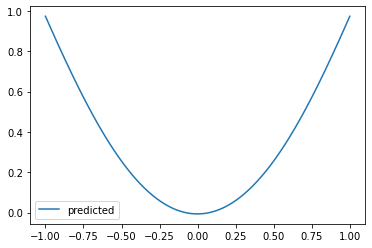

In [11]:
import matplotlib.pyplot as plt
x_pred = jnp.linspace(-1, 1, 10000)
x_pred = x_pred.reshape((10000, num_features))
y_pred = batched_prediction(params, x_pred)
#plt.plot(x_train, y_train, "-ro", label="Train data")
plt.plot(x_pred, y_pred, label="predicted")
plt.legend()

In [2]:
#!pip install equinox

## PINN for Burger's Equation in JAX

In [17]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import scipy.io
from pyDOE import lhs
from jax.nn import tanh, relu
import sys
from jax.example_libraries import optimizers
from tqdm import trange
sys.path.insert(0, 'Utilities/')
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

100%|██████████| 201/201 [00:25<00:00,  7.94it/s, Loss=0.08693237, loss_physics=0.028787091] 


Error u: 6.664986e-01


<ipython-input-19-c672c5d05973>:156: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


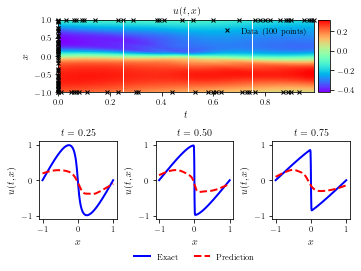

In [19]:
def random_layer_params(m, n, key, scale):
    w_key, b_key = random.split(key)
    return scale*random.normal(w_key, (m, n)), jnp.zeros(n)

def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, 2.0/(jnp.sqrt(m+n))) \
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


@jit
def predict(params, X, lb, ub):
    H =  2.0*(X - lb)/(ub - lb) - 1.0
    for w, b in params[:-1]:
        H = tanh(jnp.dot(H, w) + b)
        final_w, final_b = params[-1]
    H = jnp.dot(H, final_w) + final_b
    return H


@jit
def net_u(params, x, t, lb, ub):
    x_con =jnp.array([x, t])
    y_pred = predict(params, x_con, lb, ub)
    return y_pred

@jit
def net_u_grad(params, x, t, lb, ub):
    x_con =jnp.array([x, t])
    y_pred = predict(params, x_con, lb, ub)
    return y_pred[0]

def net_f(params, lb, ub):
    def u_t(x, t):
        ut = grad(net_u_grad, argnums=2)(params, x, t, lb, ub) 
        return ut

    def u_x(x, t):
        ux = grad(net_u_grad, argnums=1)(params, x, t, lb, ub) 
        return ux   
    return jit(u_t), jit(u_x)


def net_fxx(params, lb, ub):
    def u_xx(x, t):
        _, u_x = net_f(params, lb, ub) 
        ux = grad(u_x, argnums=0)(x, t) 
        return ux   
    return jit(u_xx)


@jit
def loss_data(params,x,t, lb, ub, u_train):
    u_pred = vmap(net_u, (None, 0, 0, None, None))(params, x, t, lb, ub)
    loss = jnp.mean((u_pred - u_train)**2 )
    return loss

@jit
def loss_f(params, x, t, lb, ub, nu):
    u = vmap(net_u, (None, 0, 0, None, None))(params, x, t, lb, ub)
    u_tf, u_xf = net_f(params, lb, ub)
    u_xxf = net_fxx(params, lb, ub)
    u_t = vmap(u_tf, (0, 0))(x, t)
    u_x = vmap(u_xf, (0, 0))(x, t)
    u_xx = vmap(u_xxf, (0, 0))(x, t)
    res = u_t + u.flatten() * u_x - nu * u_xx 
    loss_f = jnp.mean((res.flatten())**2)
    return loss_f

@jit
def predict_u(params, x_star, t_star, lb, ub):
    u_pred = vmap(net_u, (None, 0, 0, None, None))\
    (params, x_star, t_star, lb, ub)
    return u_pred

def loss_fn(params, x_f, t_f,x_d, t_d, lb, ub, nu, y_d):
    loss_res = loss_f(params, x_f, t_f, lb, ub, nu)
    data_loss = loss_data(params, x_d, t_d, lb, ub, y_d) 
    return loss_res + data_loss

@jit
def step(istep, opt_state, t_d, x_d, y_d, t_f, x_f, lb, ub):
    param = get_params(opt_state) 
    g = grad(loss_fn, argnums=0)(param, x_f, t_f,x_d, t_d, lb, ub, nu, y_d)
    return opt_update(istep, g, opt_state)

if __name__ == "__main__":
    nu = 0.01/np.pi
    N_u = 100
    N_f = 10000
    layers = [2, 20, 20, 20, 20, 20, 20, 20,20, 20, 1]
    data = scipy.io.loadmat('Data/burgers_shock.mat')
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = np.real(data['usol']).T    
    X, T = np.meshgrid(x,t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.flatten()[:,None]              
    lb = X_star.min(0)
    ub = X_star.max(0)
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    uu1 = Exact[0:1,:].T
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    uu2 = Exact[:,0:1]
    xx3 = np.hstack((X[:,-1:], T[:,-1:]))
    uu3 = Exact[:,-1:]
    X_u_train = np.vstack([xx1, xx2, xx3])
    X_f_train = lb + (ub-lb)*lhs(2, N_f)
    X_f_train = np.vstack((X_f_train, X_u_train))
    u_train = np.vstack([uu1, uu2, uu3])
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    X_u_train = X_u_train[idx, :]
    u_train = u_train[idx,:]
    x_d = X_u_train[:, 0]
    t_d = X_u_train[:, 1]
    x_f = X_f_train[:, 0]
    t_f = X_f_train[:, 1]
    x_star = X_star[:, 0]
    t_star = X_star[:, 1]
    params = init_network_params(layers, random.PRNGKey(1234))
    opt_init, opt_update, get_params = optimizers.adam(5e-4)
    opt_state = opt_init(params)
    nIter = 200 + 1 #20001
    ld_list = []
    lf_list = []
    pbar = trange(nIter)
    
    for it in pbar:
        opt_state = step(it, opt_state, t_d, x_d, u_train, t_f, x_f, lb, ub)
        if it % 1 == 0:
            params = get_params(opt_state)
            l_d = loss_data(params, x_d, t_d, lb, ub, u_train)
            l_f = loss_f(params, x_f, t_f, lb, ub, nu)
            pbar.set_postfix({'Loss': l_d, 'loss_physics': l_f})
            ld_list.append(l_d)
            lf_list.append(l_f)


    u_pred = predict_u(params, x_star, t_star, lb, ub)
            
    error_u = jnp.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    print('Error u: %e' % (error_u))
    np.save("ld_list.npy", np.array(ld_list), allow_pickle=True) 
    np.save("lf_list.npy", np.array(lf_list), allow_pickle=True)  
 
    
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    Error = np.abs(Exact - U_pred)
    
    fig, ax = newfig(1.0, 1.1)
    ax.axis('off')
    
    ####### Row 0: u(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)
    
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(t,x)$', fontsize = 10)
    
    ####### Row 1: u(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = 0.25$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75$', fontsize = 10)

    savefig("Burgers")
    


## DeepONet for Antiderivative Operators in JAX

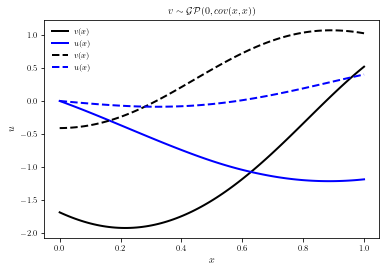

In [22]:
import numpy as np
import jax.numpy as jnp
import time
# Load the data and visualize 
d = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
v_train, x_train, u_train = jnp.array(d["X"][0]), \
jnp.array(d["X"][1]), jnp.array(d["y"])

d = np.load("antiderivative_aligned_test.npz", allow_pickle=True)
v_test, x_test, u_test = jnp.array(d["X"][0]),\
jnp.array(d["X"][1]), jnp.array(d["y"])

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1,1)
ax = plt.subplot(gs0[:, :])
ax.plot(x_train, v_train[10,:], '-k', lw=2.0, label="$v(x)$")
ax.plot(x_train, u_train[10,:], '-b', lw=2.0, label="$u(x)$")
ax.plot(x_train, v_test[100,:], '--k', lw=2.0, label="$v(x)$")
ax.plot(x_train, u_test[100,:], '--b', lw=2.0, label="$u(x)$")
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$v \sim \mathcal{GP}(0, cov(x,x))$', fontsize = 10)
plt.savefig("Data.png", dpi=300)
plt.show()

In [25]:
key = random.PRNGKey(1234)
initializer = jax.nn.initializers.glorot_normal()
def hyper_initial(layers):
    L = len(layers)
    W = []
    b = []
    for l in range(1, L):
        in_dim = layers[l-1]
        out_dim = layers[l]
        std = np.sqrt(2.0/(in_dim+out_dim))
        weight = initializer(key, (in_dim, out_dim), jnp.float32)*std
        bias = initializer(key, (1, out_dim), jnp.float32)*std
        W.append(weight)
        b.append(bias)
    return W, b
def fnn_B(X, W, b):
    inputs = X
    L = len(W)
    for i in range(L-1):
        outputs = jnp.dot(inputs, W[i]) + b[i]
        inputs = jnp.tanh(outputs)  
    Y = jnp.dot(inputs, W[-1]) + b[-1]     
    return Y

def fnn_T(X, W, b):
    inputs = X
    L = len(W)
    for i in range(L-1):
        outputs = jnp.dot(inputs, W[i]) + b[i]
        inputs = jnp.tanh(outputs)  # inputs to the next layer
    Y = jnp.dot(inputs, W[-1]) + b[-1]     
    return Y


def predict(params, data):
    W_branch, b_branch, W_trunk, b_trunk = params
    v, x = data
    u_out_branch = fnn_B(v, W_branch, b_branch) # predict on branch
    u_out_trunk = fnn_T(x, W_trunk, b_trunk) # predict on trunk
    u_pred = jnp.einsum('ik,jk->ik',u_out_branch, u_out_trunk) # matmul
    return u_pred

def loss(params, data, u):
    u_preds = predict(params, data)
    # print(u_preds)
    mse = jnp.mean(jnp.sum((u_preds - u)**2, axis = 1)) 
    # print(mse)
    return mse

@jit
def update(params, data, u, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = jax.value_and_grad(loss)(params, data, u)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value


#input dimension for Branch Net
u_dim = 100
#output dimension for Branch and Trunk Net
G_dim = 100
#Branch Net
layers_f = [u_dim] + [40]*2 + [G_dim]
# Trunk dim
x_dim = 1
#Trunk Net
layers_x = [x_dim] + [40]*2 + [G_dim]
W_branch, b_branch = hyper_initial(layers_f)
W_trunk, b_trunk =   hyper_initial(layers_x)
# Defining an optimizer in Jax
num_epochs = 101 #10000
lr = 5e-4
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init([W_branch, b_branch, W_trunk, b_trunk])
params = get_params(opt_state)
train_loss, test_loss = [], []

start_time = time.time()

for epoch in range(num_epochs):
    params, opt_state, loss_val = update(params, [v_train, x_train], u_train, opt_state)
    train_loss.append(loss_val)
    if epoch % 100 ==0:
        epoch_time = time.time() - start_time
        u_train_pred = predict(params, [v_train, x_train])
        err_train = jnp.mean(jnp.linalg.norm(u_train - u_train_pred, 2, axis=1)/\
                             np.linalg.norm(u_train , 2, axis=1))
        u_test_pred = predict(params, [v_test, x_test])
        err_test = jnp.mean(jnp.linalg.norm(u_test - u_test_pred, 2, axis=1)/\
                            np.linalg.norm(u_test , 2, axis=1))
        test_loss_val = loss(params, [v_test, x_test], u_test)
        test_loss.append(test_loss_val)
        print("Epoch {} | T: {:0.6f} | Train MSE: {:0.4f} | \
        Test MSE: {:0.4f} | Train L2: {:0.4f} | Test L2: {:0.4f}"\
              .format(epoch, epoch_time, loss_val, test_loss_val, err_train, err_test))

Epoch 0 | T: 0.470734 | Train MSE: 26.7349 |         Test MSE: 28.4372 | Train L2: 1.0300 | Test L2: 1.0517
Epoch 100 | T: 0.529918 | Train MSE: 0.1256 |         Test MSE: 0.1207 | Train L2: 0.1065 | Test L2: 0.1025


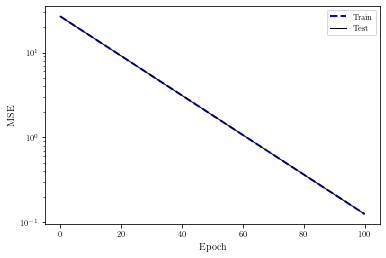

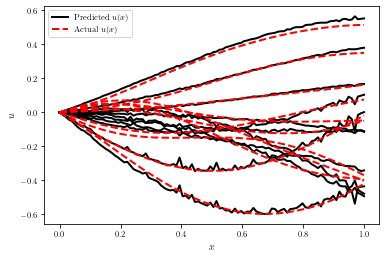

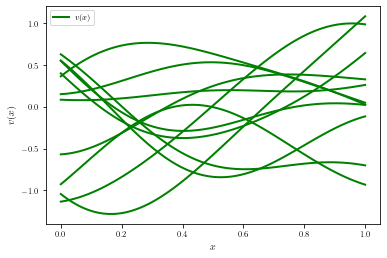

In [26]:
train_loss = np.array(train_loss)
test_loss =  np.array(test_loss)
plot_int = 100

ep = np.arange(0,num_epochs,1)
ep = ep[::plot_int]

train_loss_plot = train_loss[::plot_int]
test_loss_plot = train_loss[::plot_int]



gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[:, :])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
#ax.set_ylim([10**-5, 1])
ax.semilogy(ep, train_loss_plot, '--b', lw=2.0, label="Train")
ax.semilogy(ep, test_loss_plot, '-k', lw=1.0, label="Test")
plt.legend()
plt.savefig("Loss.png", dpi=300)
plt.show()



pred = predict(params, [v_train, x_train])
u_test_pred = predict(params, [v_test, x_test])

############################
gs1 = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs1[:, :])

ax1.plot(x_test, u_test_pred[20, :], '-k', lw=2.0, label="Predicted $u(x)$")

for i in range(10,20):
    ax1.plot(x_test, u_test_pred[i, :], '-k', lw=2.0)

ax1.plot(x_test, u_test[20, :], '--r', lw=2.0, label="Actual $u(x)$")

for i in range(10,20):
    ax1.plot(x_train,u_test[i, :], '--r', lw=2.0)



ax1.set_xlabel('$x$')
ax1.set_ylabel('$u$')
ax1.legend(frameon=True, loc = 'best')
plt.savefig("predicted_and_deeponet.png", dpi=300)
plt.show()

####
gs2 = gridspec.GridSpec(1,1)
ax2 = plt.subplot(gs2[:, :])

ax2.plot(x_test, v_test[20, :], '-g', lw=2.0, label="$v(x)$")
for i in range(10,20):
    ax2.plot(x_test, v_test[i, :], '-g', lw=2.0)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$v(x)$')
ax2.legend(frameon=True, loc = 'best')
plt.savefig("forcing.png", dpi=300)